# Final Project Implementation

## Project Template: Deep Learning on a public dataset



In [2]:
# Importing Tensor flow and checking that the GPU is Recognized

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


# Load Data

The dataset set was downloaded in the mat format a data compression method for large datasets.

In the below cell I am unpacking the images into a python dict format. The dictionary contains the images and corresponding labels.

In [ ]:
# Importing Library to load the Dataset
from scipy.io import loadmat

train_raw = loadmat('../data/mat/train_32x32.mat')  # Train Set
test_raw = loadmat('../data/mat/test_32x32.mat')    # Test Set
extra_raw = loadmat('../data/mat/extra_32x32.mat')  # Extra Set

print(type(train_raw))

<class 'dict'>


Below, I am unpacking the python dictionary containers into data and label numpy array containers.

In [4]:
import numpy as np

# Training Set & Labels
train_data = train_raw['X']
train_labels = train_raw['y']

# Extra Dataset & Labels
extra_data = extra_raw['X']
extra_labels = extra_raw['y']

# Test Data & Labels
test_data = test_raw['X']
test_labels = test_raw['y']

print(type(train_labels))

<class 'numpy.ndarray'>


Below, I am checking the shape of each of the data and labels sets.

In [5]:
print('Training Data:', train_data.shape, 'Training Labels:', train_labels.shape)
print('Extra Data:', extra_data.shape, 'Extra Labels:', extra_labels.shape)
print('Test Data:', test_data.shape, 'Test Labels:', test_labels.shape)


Training Data: (32, 32, 3, 73257) Training Labels: (73257, 1)
Extra Data: (32, 32, 3, 531131) Extra Labels: (531131, 1)
Test Data: (32, 32, 3, 26032) Test Labels: (26032, 1)


# Exploratory Analysis

Here are the first nine images from the training dataset.

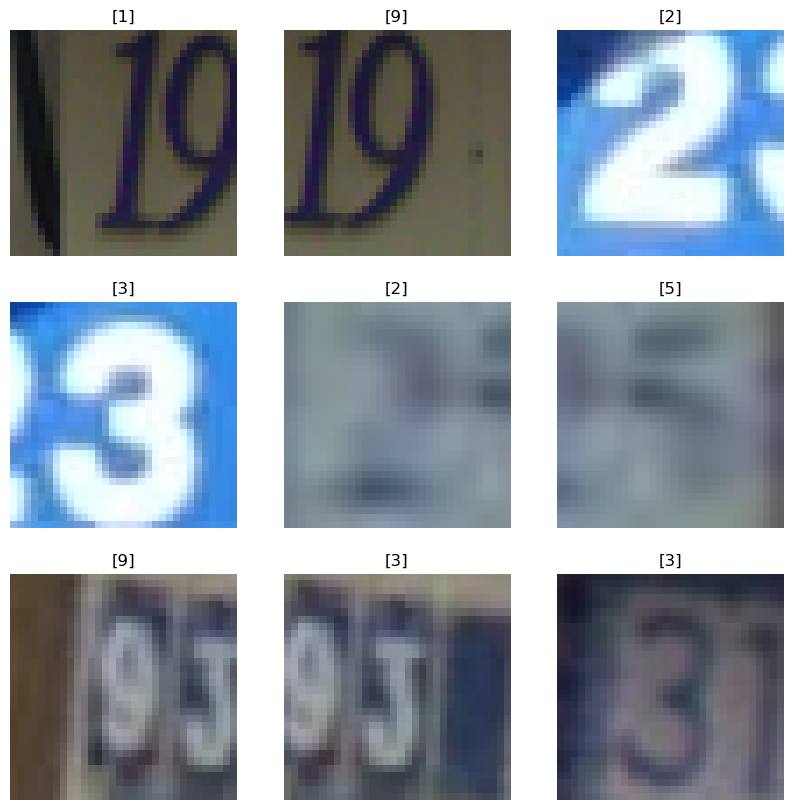

In [6]:
from utils.plotting import plot_sample_images

plot_sample_images(train_data, train_labels)

Unprocessed 32 x 32 SVHN Images. Additionally, multiple distracting digits to the side make it harder to solve since the model must focus on the core digit while ignoring unnecessary data making it a real-world issue to solve.

Plotting the datasets Label distributions.

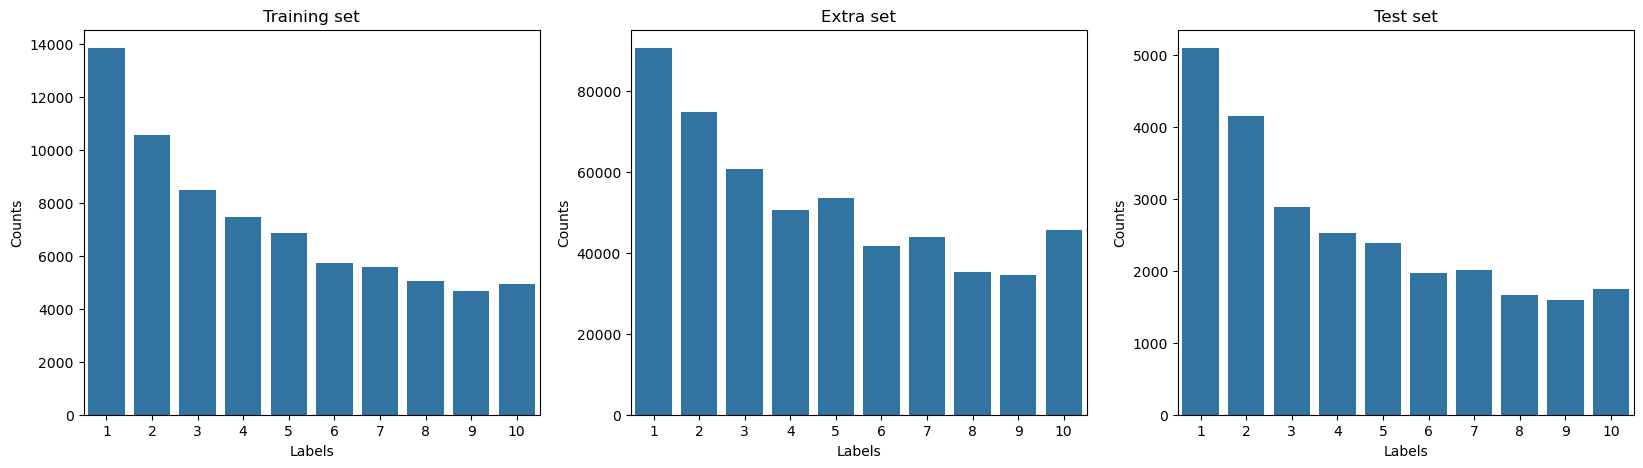

In [ ]:
from utils.statistics import label_count_plot
import matplotlib.pyplot as plt

# Create a subplot in a 3x3 grid
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
# Plot IMages
label_count_plot(train_labels, "Labels", "Counts", "Training set", axis=ax[0])
label_count_plot(extra_labels, "Labels", "Counts", "Extra set", axis=ax[1])
label_count_plot(test_labels, "Labels", "Counts", "Test set", axis=ax[2])

Training, Extra and Test Dataset Class Distributions

 The figure above shows dataset imbalance. The disparity is consistent across datasets. The most common sample is 1 and the least common is 9. To correct the imbalance, I will adjust class weights for the training set and build a validation set with balanced classes

# Pre-Processing

Here I will pre-process the dataset for training. I will be using the same method as ( Sermanet, Pierre, Chintala, Soumith, and LeCun, Yann ) in their paper 'Convolutional neural networks applied to house numbers digit classification'. 

In [8]:
# Function to create a validation set

def create_validation_set(X, y, num_samples_per_class):
    """
    Create a validation set by randomly sampling a fixed
    number of samples per class from the dataset.

    Parameters:
        X (numpy.ndarray): A 4-dimensional array representing
        the data samples. The last dimension indexes individual samples.

        y (numpy.ndarray): A 1-dimensional array of labels
        corresponding to each sample in X.

        num_samples_per_class (int): The number of samples to randomly
        select for each unique class in y.

    Returns:
        tuple:
            - numpy.ndarray: A subset of X containing the selected validation samples.

            - numpy.ndarray: A subset of y containing the labels corresponding to the
                             selected validation samples.

            - numpy.ndarray: An array of indices representing the selected samples.

    """

    # Array: Stores the unique classes of label set
    unique_classes = np.unique(y)

    # List: To store chosen indexes                   
    chosen_indexes = []                             
    
    # Loop: iterate through each class
    for cls in unique_classes:                      

        # Array: Store all indexes from a class
        class_indexes = np.where(y == cls)[0]       

        # Array: Randomly select n indices from 'class_indexes'
        chosen_class_indexes = np.random.choice(class_indexes, num_samples_per_class, replace=False)
        # List:  Add each class indices to a list
        chosen_indexes.extend(chosen_class_indexes)

    # Array: Convert list to Numpy Array
    chosen_indexes = np.array(chosen_indexes)

    # Array:  Return the selected samples, label and indexes
    return X[:, :, :, chosen_indexes], y[chosen_indexes], chosen_indexes


## Validation Set
To build a validation set, we select 400 samples per class from the training set and 200 samples per class from the extra set. The remaining samples from the train and extra datasets are later combined to form the training set.

In [9]:
# Creating Validation Function

# Choose 400 samples from the training set for each class.
X_val_train, y_val_train, val_train_indexes = create_validation_set(train_data, train_labels, 400)

# Choose 200 samples from the extra set for each class.
X_val_extra, y_val_extra, val_extra_indexes = create_validation_set(extra_data, extra_labels, 200)

# Merge the two sets' validation samples.
X_val = np.concatenate((X_val_train, X_val_extra), axis=3)  # Combine along the 4th dimension
y_val = np.concatenate((y_val_train, y_val_extra), axis=0)

print('Validation data:', X_val.shape ,'Validation Labels:', y_val.shape)



Validation data: (32, 32, 3, 6000) Validation Labels: (6000, 1)


There are 6000 samples in the dataset.

Below, I am plotting the distribution of the validation set.

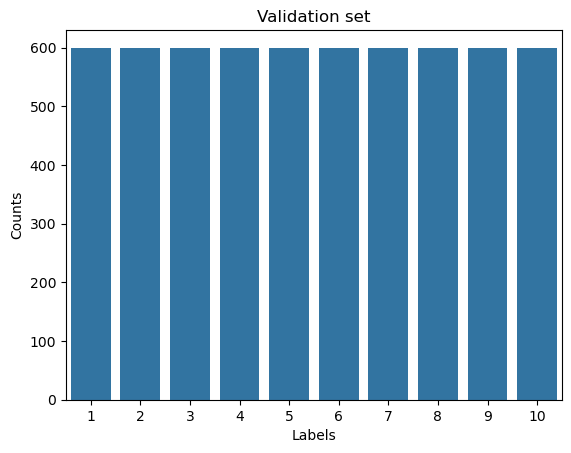

In [10]:
label_count_plot(y_val, "Labels", "Counts", "Validation set")

The validation set has an equal distribution.

A function to Shuffle the datasets

In [11]:
def shuffle_dataset(data, labels):
    """
    Shuffle the dataset and its corresponding labels
    using a fixed random seed for reproducibility.

    This feature reorders the samples in the data array,
    together with the related labels, and generates a permutation
    of indices depending on a fixed seed (42).

    Parameters:
        data (numpy.ndarray): A 4-dimensional array where the last
        dimension indexes individual samples.

        labels (numpy.ndarray): A 1-dimensional array of labels
        corresponding to each sample in the data array.

    Returns:
        tuple:
            - numpy.ndarray: The shuffled data array.
            - numpy.ndarray: The shuffled labels array.
    """

    # Create a random number generator with a fixed seed
    seed = 42
    rng = np.random.default_rng(seed)

    # Generate indexes for the validation set
    shuffle_indexes = np.arange(labels.shape[0])  # Create an array of indexes
    rng.shuffle(shuffle_indexes)  # Shuffle the indexes in-place

    # Reorder X_val and y_val using the shuffled indexes
    shuffled_data = data[:, :, :, shuffle_indexes]
    shuffled_labels = labels[shuffle_indexes]

    return shuffled_data, shuffled_labels

Shuffling the Validation set

In [ ]:
# Shuffle dataset
X_val, y_val = shuffle_dataset(X_val, y_val)

Plotting 9 sample from the validation set.

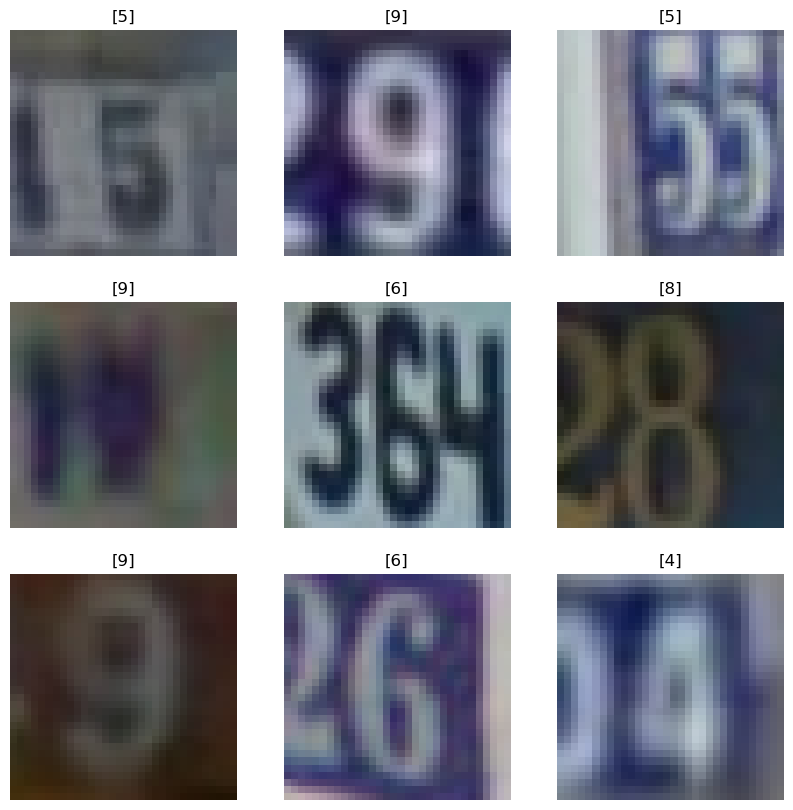

In [ ]:
# Plotting images
plot_sample_images(X_val, y_val)

## Training Set

Below, I will now remove the validation samples from the training and datasets.

In [14]:
# Remove validation samples from the original training set
X_train_new = np.delete(train_data, val_train_indexes, axis=3)
y_train_new = np.delete(train_labels, val_train_indexes, axis=0)

X_extra_new = np.delete(extra_data, val_extra_indexes, axis=3)
y_extra_new = np.delete(extra_labels, val_extra_indexes, axis=0)

print('===================================================================')
print('Original Shape')
print('Training Data:', train_data.shape, 'Training Labels:', train_labels.shape)
print('Extra Data:', extra_data.shape, 'Extra Lables:', extra_labels.shape)
print('===================================================================')
print('New Shape')
print('Training Data:', X_train_new.shape, 'Training Labels:', y_train_new.shape)
print('Extra Data:', X_extra_new.shape, 'Extra Lables:', y_extra_new.shape)

Original Shape
Training Data: (32, 32, 3, 73257) Training Labels: (73257, 1)
Extra Data: (32, 32, 3, 531131) Extra Lables: (531131, 1)
New Shape
Training Data: (32, 32, 3, 69257) Training Labels: (69257, 1)
Extra Data: (32, 32, 3, 529131) Extra Lables: (529131, 1)


Above, You can see the new datasets size after removing the validation samples

Below, I will now merge the training set and extra set together to create 1 training set.

In [15]:
# Merge the two sets' training data samples.
X_train_merge = np.concatenate((X_train_new, X_extra_new), axis=3)  # Combine along the 4th dimension
y_train_merge = np.concatenate((y_train_new, y_extra_new), axis=0)

print('New training set Data:', X_train_merge.shape, 'New Training set Labels:', y_train_merge.shape)

New training set Data: (32, 32, 3, 598388) New Training set Labels: (598388, 1)


Above, You can see there are now just under 600,00 samples

Shuffling the Merged data set

In [ ]:
# Shuffle dataset
X_train_merge, y_train_merge = shuffle_dataset(X_train_merge, y_train_merge)

Plotting the new merged dataset samples.

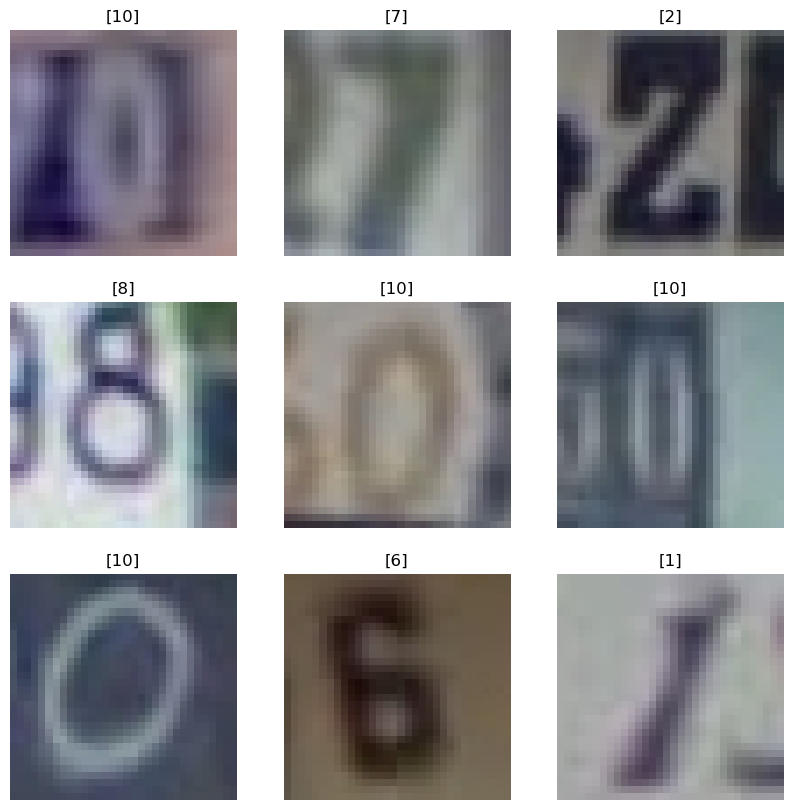

In [ ]:
# Plot Images
plot_sample_images(X_train_merge, y_train_merge)

Below, is a plot of the merged datasets distribution for each class.

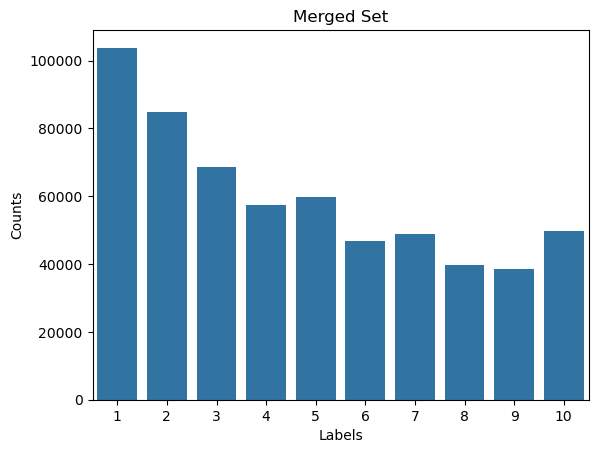

In [ ]:
# Plot the merged training set distribution
label_count_plot(y_train_merge, "Labels", "Counts", "Merged Set")

The distribution of classes for the training set are imbalanced which is addressed using class weighting.

## Converting data types and Reshaping

Below, I am converting the training set to float32 and the label set to int32 for better compatibility with the Keras model.

In [ ]:
# Convert sets to float32
X_train_float = X_train_merge.astype('float32')     # Training Set Data
X_val_float = X_val.astype('float32')               # Validation Set Data
test_data_float  = test_data.astype('float32')      # Test set Data

# Convert sets to int32
y_train_merge = y_train_merge.astype('int32')       # Train set Labels
y_val = y_val.astype('int32')                       # Validation set labels


Below, I am reshaping the data to better match the Tensorflow/Keras standard of (batch_size, height, width, depth) and printing the size of each of the datasets.

In [20]:
#Reshape

X_train_reshaped = np.transpose(X_train_float, (3, 0, 1, 2))        # Shape: (32, 32, 3, 598388)
X_val_reshaped = np.transpose(X_val_float, (3, 0, 1, 2))            # Shape: (32, 32, 3, 6000)
test_data_reshaped = np.transpose(test_data_float, (3, 0, 1, 2))    # Shape: (32, 32, 3, 26032)


print("Training data", X_train_reshaped.shape, "Training Labels", y_train_merge.shape )
print("Validation data", X_val_reshaped.shape, "598388, 32, 32, Validation Labels", y_val.shape )
print("Test data", test_data_reshaped.shape, "Test Labels", test_labels.shape)

Training data (598388, 32, 32, 3) Training Labels (598388, 1)
Validation data (6000, 32, 32, 3) 598388, 32, 32, Validation Labels (6000, 1)
Test data (26032, 32, 32, 3) Test Labels (26032, 1)


## Normalization

Normalize the data to a common scale for more efficient training.

In [22]:
# Create the Normalization object
norm_layer = tf.keras.layers.Normalization(axis=-1)

# Fit the training data to calculate the mean and Variance
norm_layer.adapt(X_train_reshaped)

In [23]:
print("Mean:", norm_layer.mean.numpy())  # Should output the computed mean
print("Variance:", norm_layer.variance.numpy())  # Should output the computed variance

Mean: [[[[109.8752  109.69416 113.78163]]]]
Variance: [[[[2511.412  2557.2578 2586.374 ]]]]


Apply normalization to the training and validation sets.

In [24]:
# Normalize Data

with tf.device('/CPU:0'):
    X_train_normalized = norm_layer(X_train_reshaped)
    X_val_normalized = norm_layer(X_val_reshaped)
    test_normalized = norm_layer(test_data_reshaped)

Checking the Images after normalization.

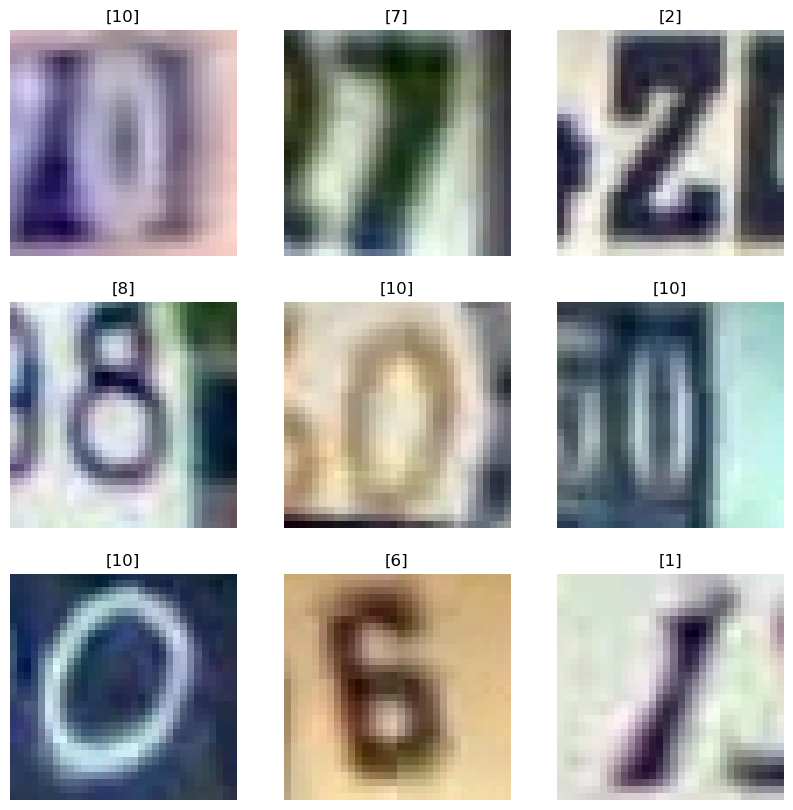

In [29]:

plt.figure(figsize=(10, 10))

# Loop over the first 9 images in the dataset
for i in range(9):
    
    # Create a subplot in a 3x3 grid
    ax = plt.subplot(3, 3, i + 1)
    
    # https://stackoverflow.com/questions/1456000/rescaling-ranges
    rescaled_image = (X_train_normalized [i, :, :, :] - tf.reduce_min(
                          X_train_normalized [i, :, :, :])) / (tf.reduce_max(
                              X_train_normalized [i, :, :, :]) - tf.reduce_min(
                                  X_train_normalized [i, :, :, :]))

    # Display the i-th image from the 'train_data'    
    plt.imshow(rescaled_image)
    
    # Set the title of the subplot to the corresponding label in 'train_labels'
    plt.title(y_train_merge[i])
    
    # Turn off the axis to remove ticks and labels for a cleaner display
    plt.axis("off")


The images look brighter after normalization.

## Common Baseline Model

Since I know my data distribution is imbalanced I will calculate the sample weight for each class to get an accurate accuracy score for my baseline.

In [30]:
# Imbalanced Dataset Compute Class Weights
# https://www.geeksforgeeks.org/how-to-handle-class-imbalance-in-tensorflow/

from sklearn.utils import class_weight


# Reshape the labels for sample_weights
y_flat_cw = y_train_merge.flatten()

# calculate the sample weights
sp_weights = class_weight.compute_sample_weight(class_weight="balanced", y=y_flat_cw)

# Create a dictionary with the Sample weights results
sample_weights = dict(enumerate(sp_weights))

Below, I need to convert the dictionary values to a numpy array so they can be processed by the dummy classier.

In [31]:
# Convert the dictionary to a numpy array
sample_weights_array = np.array(list(sample_weights.values()))
sample_weights_array

array([1.19922241, 1.22139941, 0.70627088, ..., 0.57636509, 0.57636509,
       1.22139941])

Below, I need to flatten the training data so it can be used with the dummy classier.

In [32]:
# Reshaping for Dummy Classifier
# Let numpy figure out the shape automatically with -1

# Reshape the image data to (n_samples, n_features)
X_train_flattened = X_train_merge.reshape(X_train_merge.shape[3], -1)   # Shape: (598388, 32, 32, 3)
X_val_flattened = X_val.reshape(X_val.shape[3], -1)                     # Shape: (6000, 32, 32, 3)

print('Flattened Training data:', X_train_flattened.shape, 'Flattened Validation Data:', X_val_flattened.shape )

Flattened Training data: (598388, 3072) Flattened Validation Data: (6000, 3072)


Running the dummy classifier on the Training data and evaluating on the validation set. Calculating the accuracy

In [33]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Initialize and fit DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)

# Fit the dummy to the datasets
dummy_clf.fit(X_train_flattened, y_train_merge, sample_weight=sample_weights_array)

# Get predictions on the validation set
y_pred = dummy_clf.predict(X_val_flattened)

# Evaluate accuracy
baseline_accuracy = accuracy_score(y_val, y_pred)
print(f"Baseline Accuracy (Stratified): {baseline_accuracy * 100:.2f}%")

Baseline Accuracy (Stratified): 10.07%


The accuracy is currently around 10%, which is expected for a random guess in a balanced dataset with 10 classes (digits 0–9). I applied a sample weight dictionary to the model to assign higher weights to the underrepresented labels, ensuring that the model pays more attention to them during training. To demonstrate that the machine learning model is learning patterns in the data and achieving statistical accuracy, I would expect it to perform significantly better than 10% accuracy

## Converting Labels to a One hot encoded array

I am using the 'categorical_crossentropy' loss function which expects one hot encoded values. First I will change the way the digit 0 is labelled. At the moment digit 0 is labelled as 10. I will re-label it a 0

In [34]:
# Convert 10 to 0 for all label sets

import numpy as np

# Replace label 10 with 0 for all datasets
y_train_relabelled = np.where(y_train_merge == 10, 0, y_train_merge)
y_val_relabelled = np.where(y_val == 10, 0, y_val)
y_test_relabelled = np.where(test_labels == 10, 0, test_labels)

# Validate the labels
print("Unique values in adjusted y_train_merge:", np.unique(y_train_relabelled ))
print("Unique values in adjusted y_val:", np.unique(y_val_relabelled ))
print("Unique values in adjusted test_labels:", np.unique(y_test_relabelled ))

Unique values in adjusted y_train_merge: [0 1 2 3 4 5 6 7 8 9]
Unique values in adjusted y_val: [0 1 2 3 4 5 6 7 8 9]
Unique values in adjusted test_labels: [0 1 2 3 4 5 6 7 8 9]


One hot encoded the labels below.

In [35]:
# Import module
from sklearn.preprocessing import OneHotEncoder

# Fit the OneHotEncoder to the training labels
enc = OneHotEncoder().fit(y_train_relabelled)

# Transform the label values to a one-hot-encoding scheme
y_train_oh = enc.transform(y_train_relabelled).toarray()
y_val_oh = enc.transform(y_val_relabelled).toarray()
y_test_oh = enc.transform(y_test_relabelled).toarray()

Below, I am computing the class weights of the training data. This will be used with the classification model to make sure when the accuracy is calculated the imbalance is taken into account.

In [36]:
# Reference: https://stackoverflow.com/questions/43481490/keras-class-weights-class-weight-for-one-hot-encoding
from sklearn.utils import class_weight

# Convert one-hot encoded training labels to integer labels
y_integers = np.argmax(y_train_oh, axis=1)


# Compute the class weights using the 'balanced' mode, which adjusts weights inversely proportional to class frequencies.
# np.unique(y_integers) provides the unique class labels present in the training set.
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)

# Create a dictionary that maps each class index to its computed weight.
d_class_weights = dict(enumerate(class_weights))

# Print the dictionary of class weights.
d_class_weights

{0: 1.1992224137239968,
 1: 0.5763650899143719,
 2: 0.7062708763647093,
 3: 0.8714980629751536,
 4: 1.0408376963350785,
 5: 1.0011175801378571,
 6: 1.2810978612258879,
 7: 1.2213994121489222,
 8: 1.5033741175288295,
 9: 1.5536492275736726}

## Create a Sub sample Dataset for Hyperparameter tuning

When searching for the best hyperparameters, training on the entire dataset for every combination can be very time-consuming. To speed up the process, I create a subset of the original dataset containing one-third of the samples. This allows for a quicker exploration of hyperparameter adjustments. Once the best hyperparameters are identified, I then train the model on the full training dataset.

To keep the class distribution of the larger training set I split using stratify. I also used the random state as the seed to ensure I have the same samples if I am to split again.

In [37]:
import numpy as np
from sklearn.model_selection import train_test_split


# Using Train, Test, Split I split the full dataset up into a third of the size. Using Stratify keeps the original class distribution of the original dataset
_ , X_train_split, _ , y_train_split = train_test_split(X_train_reshaped, y_train_relabelled, test_size=0.33, random_state=42, stratify=y_train_relabelled)

Below, I am normalizing the Hyperparameter search training set

In [38]:
# Normalize Data

with tf.device('/CPU:0'):
    # Apply the normalization layer to the hyperparameter data split,
    X_train_normalized_split = norm_layer(X_train_split)

# Transform the training labels into a one-hot encoded format using the encoder 'enc'.
y_train_oh_split = enc.transform(y_train_split).toarray()

Below, I am plotting to distribution of the hyperparameter training set to make sure it matches the full dataset distribution

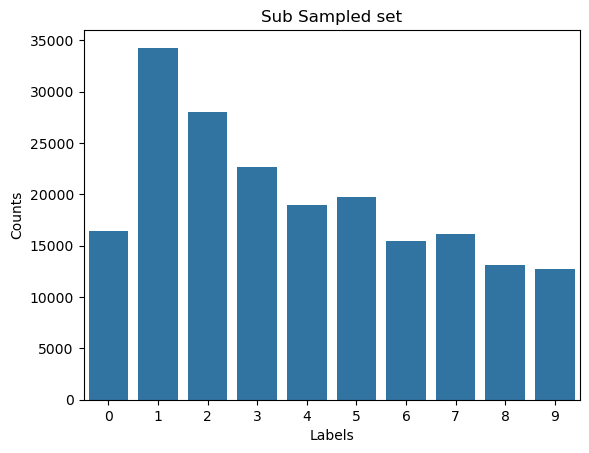

In [ ]:
# Plot Subsampled Dataset distribution
label_count_plot(y_train_split, "Labels", "Counts", "Sub Sampled set")

## Converting to Tensor

This code creates TensorFlow datasets for the full training, hyperparameter tuning, validation, and testing samples and then applies shuffling and batching to them. It converts the normalized inputs and one-hot encoded labels into TensorFlow datasets, shuffles the training datasets with a fixed buffer and seed for reproducibility, and groups all datasets into batches of 128 samples for efficient processing during training and evaluation

In [40]:
with tf.device('/cpu:0'):
    # Full Training Set
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_normalized, y_train_oh))
    # Reduce Hyperparameter Dataset
    train_dataset_hyper_search = tf.data.Dataset.from_tensor_slices((X_train_normalized_split, y_train_oh_split ))
    # Validation Set
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val_normalized, y_val_oh))
    # Test Set
    test_dataset = tf.data.Dataset.from_tensor_slices((test_normalized, y_test_oh))


In [41]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 10000

# Full Training Set
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE, seed=42).batch(BATCH_SIZE)
# Reduce Hyperparameter Dataset
hyper_p_dataset = train_dataset_hyper_search.shuffle(SHUFFLE_BUFFER_SIZE, seed=42).batch(BATCH_SIZE)
# Validation Set
val_dataset = val_dataset.batch(BATCH_SIZE)
# Test Set
test_dataset = test_dataset.batch(BATCH_SIZE)

In [42]:
Stop Here!

SyntaxError: invalid syntax (2475955567.py, line 1)

# Simple Classification Model

For the first evaluation I will create a simple CNN model with no regularization to verify that the model has sufficient capacity by overfitting the training data. This baseline provides a reference point from which I can iteratively introduce optimization and regularization techniques to improve generalization and fine-tune the model.

The structure of the model will be as follows:

1. Three Convolutional Layers:

    - With Relu Activation

1. One Fully Connected Layer:

    - After the convolutional layers, a dense (fully connected) with Relu will be used.

1. One Fully Connected Softmax Layer:

    - A standard softmax layer is used at the output for final digit classification.





## Model 1A: Simple CNN Baseline Model with no Regularization

In the cell below I am creating the baseline architecture with which I will build upon and compare regularization techniques.

In [ ]:
import tensorflow as tf

# Build the model
def simple_relu_model():
    model = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),    # Input layer  

            tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),  # Convolutional layer          

            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),  # Convolutional layer         

            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'), # Convolutional layer   

            tf.keras.layers.Flatten(),

            tf.keras.layers.Dense(256, activation='relu'),          # Fully Connected layer

            tf.keras.layers.Dense(10, activation='softmax')         # Output layer for 10 classes
        ]
    )
    return model

Below, I am plotting the Simple Baseline Model Architecture

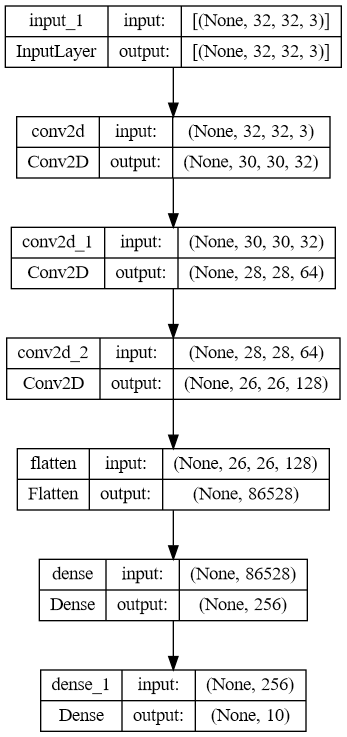

In [ ]:
from keras.utils import plot_model

# Call simple_relu_model and assign it to a new variable name
build_simple_relu_model_basic = simple_relu_model()

# User the Keras Plot model utility to build and display the plot
plot_model(build_simple_relu_model_basic, to_file='model_1.png', show_shapes=True, show_layer_names=True)

Saving trained weights is useful for reproducibility, ensuring that they can be reloaded later.

In [ ]:
# Call simple_relu_model and assign it to a new variable name
build_simple_relu_model_basic = simple_relu_model()

# Saving Weight for Reproduce ability
build_simple_relu_model_basic.save_weights("Saved Models/1. Model 1/basic/build_simple_relu_model_basic_weights.h5")


Compiling the model using the Adam optimizer and categorical crossentropy loss for multi-class classification and printing a summary of the model architecture

In [ ]:
# Compile the model
build_simple_relu_model_basic.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
build_simple_relu_model_basic.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 26, 26, 128)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 86528)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               22151424  
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 22,247,242
Trainable params: 22,247,242


The code below, initializes a ModelCheckpoint callback to save the best model based on validation loss, tracks training time using a TimeHistory callback, and then trains the model for 50 epochs with class weighting

In [ ]:
import importlib
import utils.keras_callback
importlib.reload(utils.keras_callback)
from utils.keras_callback import TimeHistory


# Call Modelcheckpoint to save the best model with the validation loss
best_model = [tf.keras.callbacks.ModelCheckpoint(
        filepath="Saved Models/1. Model 1/basic/build_simple_relu_model_basic_best.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Record the training time of the model
build_simple_relu_model_basic_time = TimeHistory()

# Save model History and fit the model
build_simple_relu_model_basic_history = build_simple_relu_model_basic.fit(
    train_dataset,                                                              # Training data and labels
    validation_data=(val_dataset),                                              # Validation data and labels
    epochs=50,                                                                  # Number of epochs
    class_weight=d_class_weights,                                               # Adding Class Weights
    callbacks=[best_model, build_simple_relu_model_basic_time],                 # Callbacks
    verbose=1                                                                   # Verbosity mode (1 for progress bar)
)

Epoch 1/50
4675/4675 [==============================] - 101s 20ms/step - loss: 0.2450 - accuracy: 0.9309 - val_loss: 0.2858 - val_accuracy: 0.9183
Epoch 2/50
4675/4675 [==============================] - 93s 20ms/step - loss: 0.1286 - accuracy: 0.9639 - val_loss: 0.2498 - val_accuracy: 0.9335
Epoch 3/50
4675/4675 [==============================] - 84s 18ms/step - loss: 0.0957 - accuracy: 0.9728 - val_loss: 0.2680 - val_accuracy: 0.9340
Epoch 4/50
4675/4675 [==============================] - 83s 18ms/step - loss: 0.0681 - accuracy: 0.9804 - val_loss: 0.3231 - val_accuracy: 0.9253
Epoch 5/50
4675/4675 [==============================] - 83s 18ms/step - loss: 0.0472 - accuracy: 0.9857 - val_loss: 0.3877 - val_accuracy: 0.9245
Epoch 6/50
4675/4675 [==============================] - 83s 18ms/step - loss: 0.0359 - accuracy: 0.9889 - val_loss: 0.4164 - val_accuracy: 0.9283
Epoch 7/50
4675/4675 [==============================] - 84s 18ms/step - loss: 0.0285 - accuracy: 0.9909 - val_loss: 0.4780 

Below I am locally saving the trained model, model history and training time information, ensuring that the can be reloaded later.

Saving Data:

- The trained model

- The model's training history 

- The training time recorded

In [ ]:
import importlib
import utils.model_utils
importlib.reload(utils.model_utils)
from utils.model_utils import save_model_data

# Specify the path to save the model
basic_model_path = 'Saved Models/1. Model 1/basic/'

# Save model, model history and training time information
save_model_data(basic_model_path,
               build_simple_relu_model_basic,'build_simple_relu_model_basic',
               build_simple_relu_model_basic_history, 'build_simple_relu_model_basic_history',
               build_simple_relu_model_basic_time, 'build_simple_relu_model_basic_time'  )

Below, I am reloading the History information to plot the curves.

In [ ]:
# Specify the path to save the model
basic_model_path = 'Saved Models/1. Model 1/basic/'

# History
build_simple_relu_model_basic_history = np.load(basic_model_path + 'build_simple_relu_model_basic_history.npy', allow_pickle=True).item()



Below, I am plotting the Model Accuracy and loss history

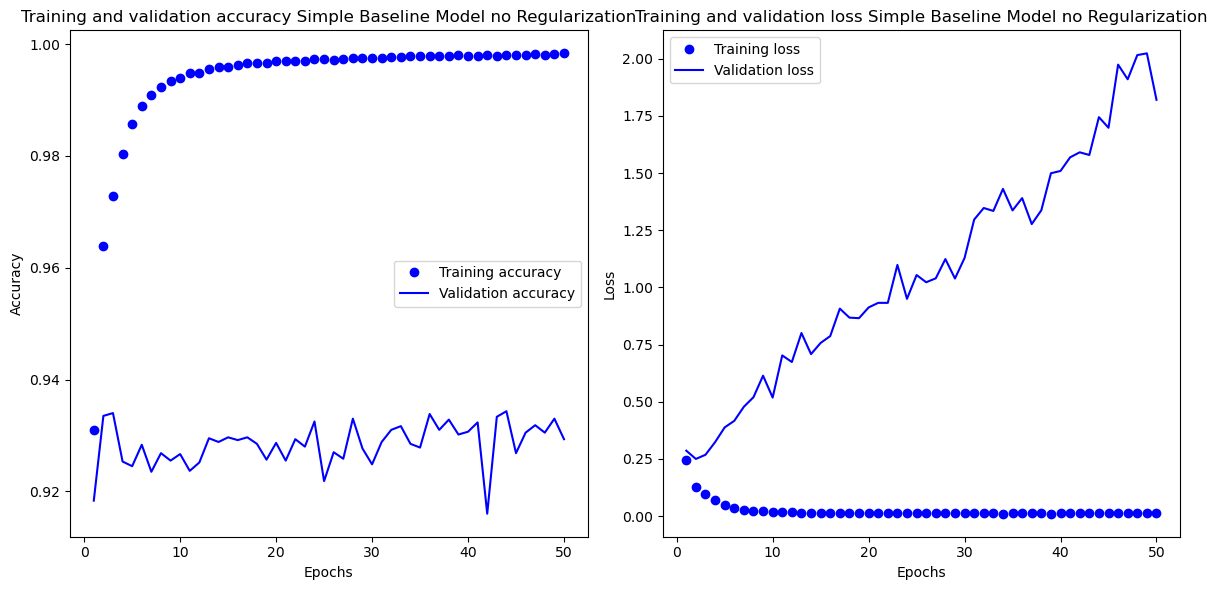

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import display_accuracy_loss

# Plot Training and validation Accuracy and loss.
display_accuracy_loss(build_simple_relu_model_basic_history, 'Simple Baseline Model no Regularization' )


Below, I am displaying the training time information of the model

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_model_times

# Print Training time information
display_model_times(build_simple_relu_model_basic_time)

Total Time: 1:10:04.669073 Average Epoch Time: 0:01:24.093381


Below, I am loading the best model that was saved during training based on the validation loss. I will use this model evaluate the test data and confusion matrix

In [51]:
# Load the best model saved during training based on validation loss
build_simple_relu_model_basic_best = tf.keras.models.load_model('Saved Models/1. Model 1/basic/build_simple_relu_model_basic_best.keras')

In [ ]:
# Run the model on the test dataset
build_simple_relu_model_basic_best.evaluate(test_dataset)

204/204 [==============================] - 1s 6ms/step - loss: 0.2679 - accuracy: 0.9281


[0.26789116859436035, 0.9280884861946106]

The Simple Baseline Model achieves an accuracy of 92.81%

Below, I am plotting the confusion matrix to evaluate on the model efficiency

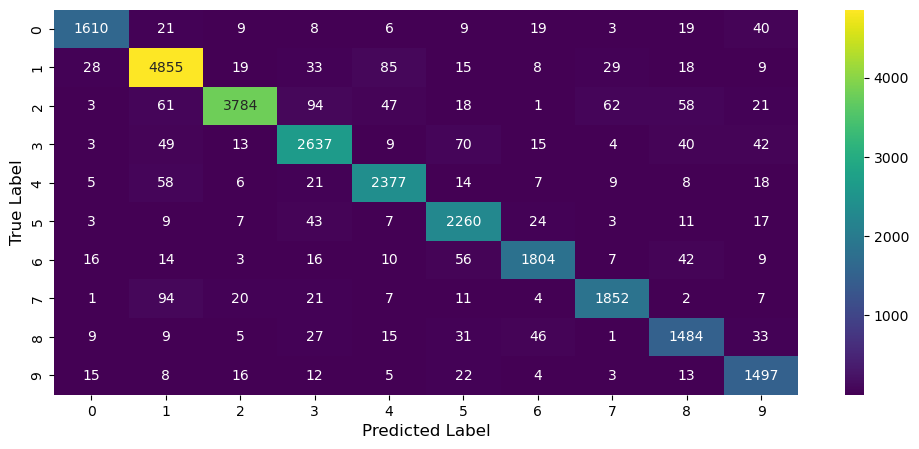

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import generate_confusion_matrix

# Plot the confusion matrix
mode_1_cm = generate_confusion_matrix(build_simple_relu_model_basic_best, test_dataset)

## Model 1B: Baseline model with Max-pooling 

In the cell below I build the on the previous model by adding the max pooling layer after the convolutional layers.

In [ ]:
import tensorflow as tf

# Build the model
def simple_relu_model_maxpooling():
    
    model = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),    # Input layer  

            tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),  # Convolutional layer
            tf.keras.layers.MaxPooling2D((2, 2)),                   # Max-pooling Layer           

            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),  # Convolutional layer
            tf.keras.layers.MaxPooling2D((2, 2)),                   # Max-pooling Layer            

            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'), # Convolutional layer
            tf.keras.layers.MaxPooling2D((2, 2)),                   # Max-pooling Layer        

            tf.keras.layers.Flatten(),

            tf.keras.layers.Dense(256, activation='relu'),          # Fully Connected layer

            tf.keras.layers.Dense(10, activation='softmax')    # Output layer for 10 classes
        ]
    )
    return model

Model Creation: Call a custom function and assign it to a variable

In [ ]:
# Call simple_relu_model_maxpooling and assign it to a new variable name
model_2_max_pooling = simple_relu_model_maxpooling()

Compile the model with:

- The Adam optimizer (optimizer='adam').

- Categorical cross-entropy loss, suitable for multi-class classification tasks.

- Accuracy as the evaluation metric.

- Print Model Summary showing the structure and the total number of parameters.

In [ ]:
# Compile the model
model_2_max_pooling.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
model_2_max_pooling.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 2, 2, 128)       

This code is setting up and training a TensorFlow/Keras model with the following main steps:

1. Checkpointing: It uses ModelCheckpoint to automatically save the model with the lowest validation loss encountered during training.

1. Time Tracking: It implements a custom callback (TimeHistory) to record how long the training process takes.

1. Model Training: It fits the model on the training data, validating it against a separate validation dataset, using specified class weights, over 50 epochs.

1. Callbacks: It incorporates both checkpointing (best_model) and timing as callbacks during training to enhance monitoring and control of the training process.

In [ ]:
import importlib
import utils.keras_callback
importlib.reload(utils.keras_callback)
from utils.keras_callback import TimeHistory


# Call Modelcheckpoint to save the best model with the validation loss
best_model = [tf.keras.callbacks.ModelCheckpoint(
        filepath="Saved Models/1. Model 1/max-pool/model_2_max_pooling_best.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Record the training time of the model
model_2_max_pooling_time = TimeHistory()

# Save model History and fit the model
model_2_max_pooling_history = model_2_max_pooling.fit(
    train_dataset,                                                              # Training data and labels
    validation_data=(val_dataset),                                              # Validation data and labels
    epochs=50,                                                                  # Number of epochs
    class_weight=d_class_weights,                                               # Adding Class Weights
    callbacks=[best_model, model_2_max_pooling_time],                           # Callbacks
    verbose=1                                                                   # Verbosity mode (1 for progress bar)
)

Epoch 1/50
4675/4675 [==============================] - 22s 4ms/step - loss: 0.2307 - accuracy: 0.9354 - val_loss: 0.2393 - val_accuracy: 0.9310
Epoch 2/50
4675/4675 [==============================] - 21s 4ms/step - loss: 0.1153 - accuracy: 0.9682 - val_loss: 0.2141 - val_accuracy: 0.9405
Epoch 3/50
4675/4675 [==============================] - 21s 5ms/step - loss: 0.0952 - accuracy: 0.9742 - val_loss: 0.2052 - val_accuracy: 0.9458
Epoch 4/50
4675/4675 [==============================] - 21s 4ms/step - loss: 0.0830 - accuracy: 0.9771 - val_loss: 0.2208 - val_accuracy: 0.9425
Epoch 5/50
4675/4675 [==============================] - 21s 4ms/step - loss: 0.0732 - accuracy: 0.9797 - val_loss: 0.2432 - val_accuracy: 0.9460
Epoch 6/50
4675/4675 [==============================] - 20s 4ms/step - loss: 0.0660 - accuracy: 0.9814 - val_loss: 0.2295 - val_accuracy: 0.9437
Epoch 7/50
4675/4675 [==============================] - 21s 4ms/step - loss: 0.0599 - accuracy: 0.9829 - val_loss: 0.2579 - val_ac

Saving a trained Keras model along with its training history and timing information.

Saving Data:

- The trained model

- The model's training history 

- The training time recorded

In [ ]:
import importlib
import utils.model_utils
importlib.reload(utils.model_utils)
from utils.model_utils import save_model_data

# Spcify the path to save the model
model_2_max_pooling_path = "Saved Models/1. Model 1/max-pool/"

# Save model, model history and training time information
save_model_data(model_2_max_pooling_path,
               model_2_max_pooling,'model_2_max_pooling',
               model_2_max_pooling_history, 'model_2_max_pooling_history',
               model_2_max_pooling_time, 'model_2_max_pooling_time'  )

Below, I am reloading the History information to plot the curves.

In [ ]:
# Specify the path to save the model
model_2_max_pooling_path = "Saved Models/1. Model 1/max-pool/"

# History
model_2_max_pooling_history = np.load(model_2_max_pooling_path + 'model_2_max_pooling_history.npy', allow_pickle=True).item()



Below, I am plotting the Model Accuracy and loss history

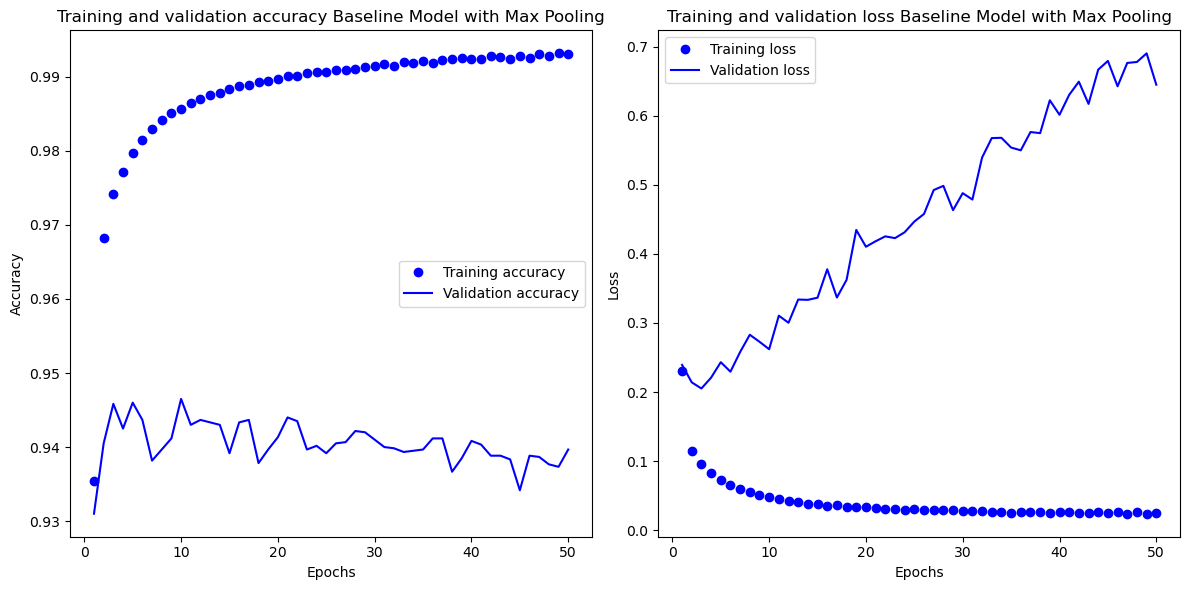

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import display_accuracy_loss

# Plot Training and validation Accuracy and loss.
display_accuracy_loss(model_2_max_pooling_history, 'Baseline Model with Max Pooling' )


Below, I am displaying the training time information of the model

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_model_times

# Print Training time information
display_model_times(model_2_max_pooling_time)

Total Time: 0:17:05.202830 Average Epoch Time: 0:00:20.504057


Below, I am loading the best model that was saved during training based on the validation loss. I will use this model evaluate the test data and confusion matrix

In [52]:
# Load the best model saved during training based on validation loss
model_2_max_pooling_best = tf.keras.models.load_model('Saved Models/1. Model 1/max-pool/model_2_max_pooling_best.keras')

In [ ]:
# Run the model on the test dataset
model_2_max_pooling_best.evaluate(test_dataset)

204/204 [==============================] - 1s 3ms/step - loss: 0.2092 - accuracy: 0.9471


[0.2092367559671402, 0.9471420049667358]

The Simple Baseline Model with Maxpooling achieves an accuracy of 94.71%

Below, I am plotting the confusion matrix to evaluate on the model efficiency

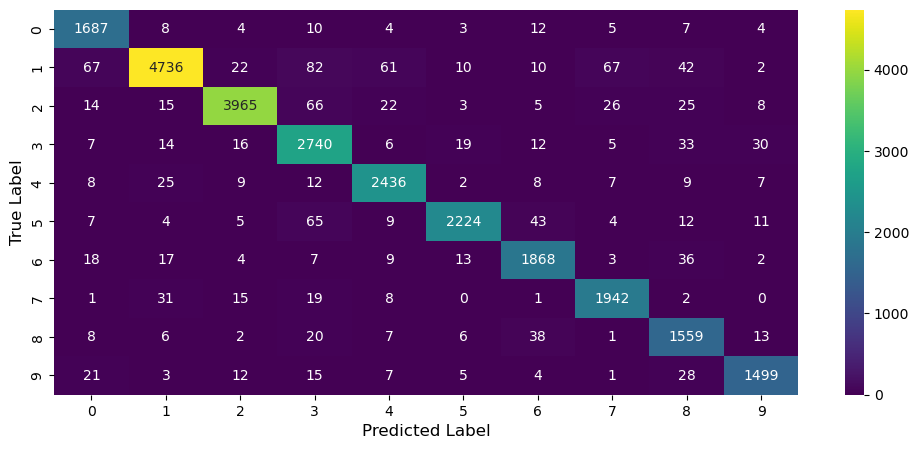

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import generate_confusion_matrix

# Plot the confusion matrix
mode_1_cm = generate_confusion_matrix(model_2_max_pooling_best, test_dataset)

## Model 1A & 1B: Comparison

The Accuracy and Loss graph shows that the Simple CNN with Max Pooling has reduced overfitting from the Simple CNN Baseline Model. The validation accuracy has incrased by about 2% with max Pooling at a cost of slitght reducing the training accuracy. The max pooling model also shows almost a 75% reduction in validaion loss. 

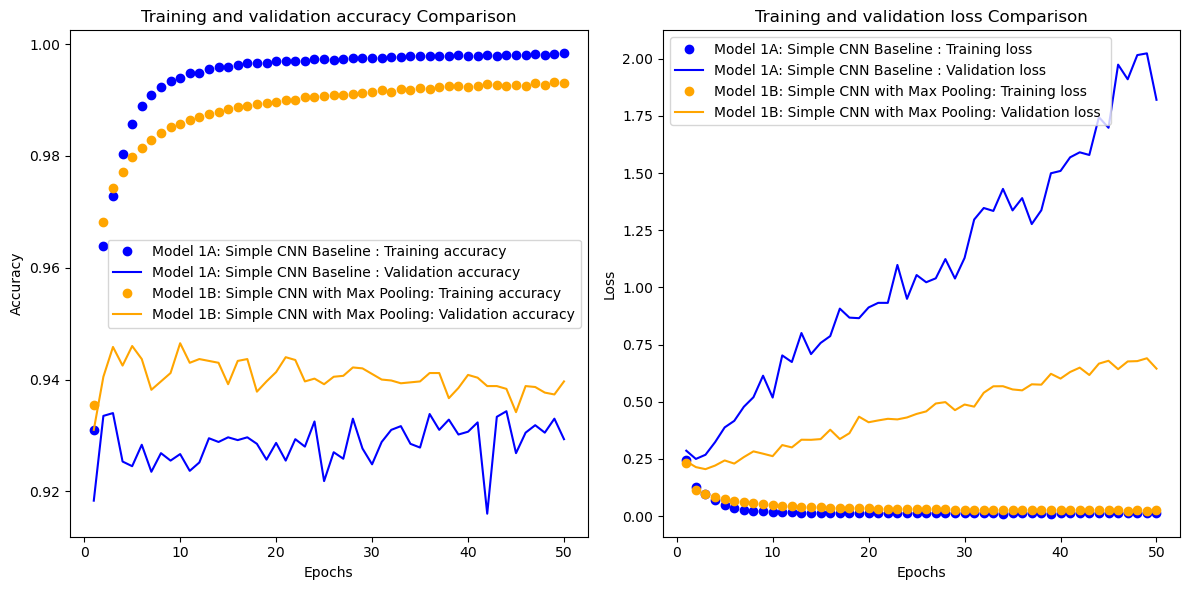

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import plot_accuracy_metric_comparison

import pandas as pd

# Load the model history
pd1 = pd.DataFrame(build_simple_relu_model_basic_history)

# Load the model history
pd2 = pd.DataFrame(model_2_max_pooling_history)

# Plot the comparison Graphs
plot_accuracy_metric_comparison(pd1,'Model 1A: Simple CNN Baseline ', pd2, 'Model 1B: Simple CNN with Max Pooling',  'Comparison')

The confusion matrix below represents the difference between the two models. A postive number indicates that the Baseline Model with Max Pooling performs better at classifying digits, while a negative number indicates that the Simple CNN architecture performs better.

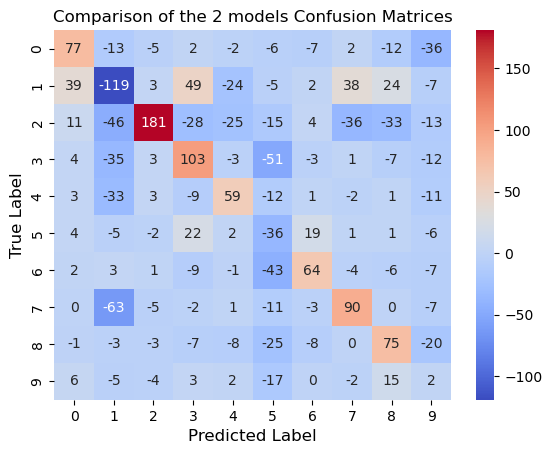

In [ ]:
importlib.reload(utils.plotting)
from utils.plotting import model_comparison_confusion_matrix

model_comparison_confusion_matrix(model_2_max_pooling_best, build_simple_relu_model_basic_best, test_dataset )

Above

- The Baseline Model (Max Pooling) is generally stronger, especially for digits 0, 2, 3, 6, 7 and 8.
- The Simple CNN performs better for digit 1 and 5, suggesting it captures certain features better.

Below, compares two neural network models "Simple CNN Baseline" and "Simple CNN with Maxpool" by plotting neuron counts and mean activations:

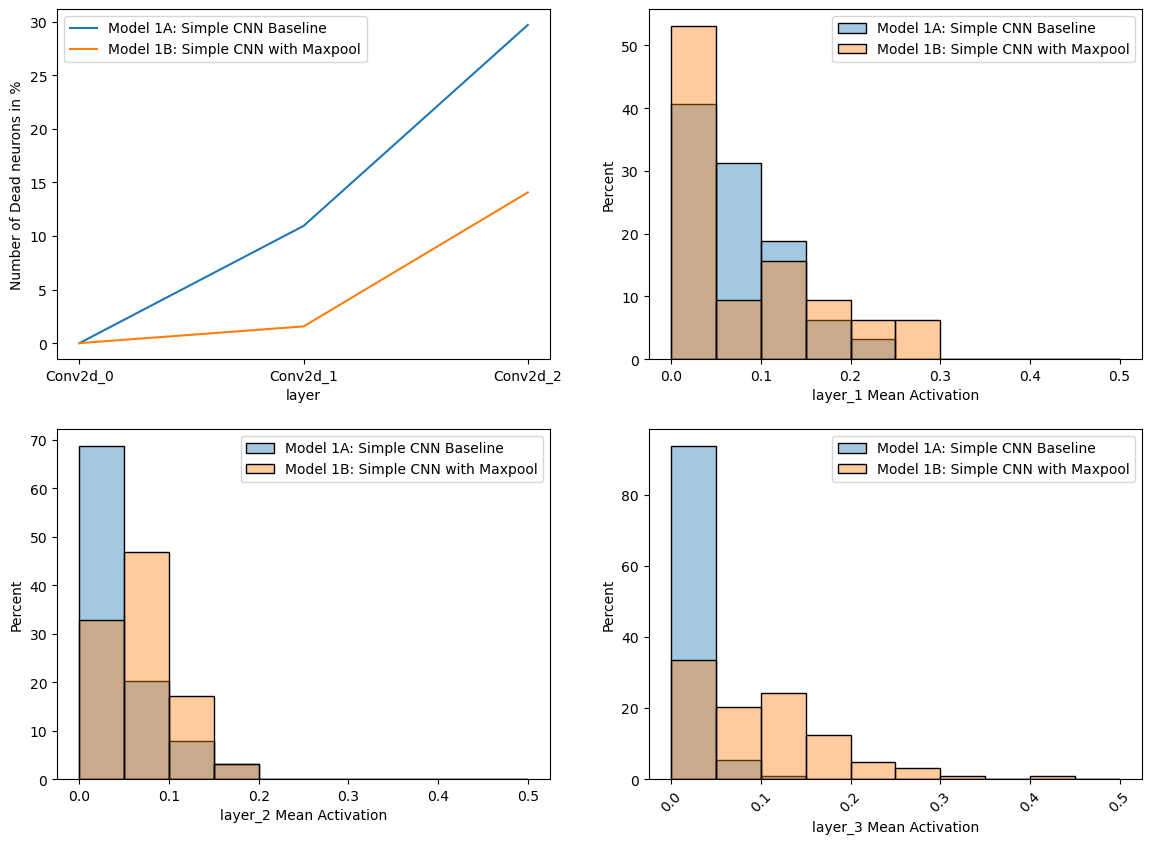

In [ ]:
import importlib
import utils.plotting
import utils.statistics
importlib.reload(utils.statistics)
importlib.reload(utils.plotting)
from utils.statistics import display_neurons_count, display_mean_activations
from utils.plotting import model_comparison_confusion_matrix

fig, axes = plt.subplots(2, 2, figsize=(14, 10))



display_neurons_count(build_simple_relu_model_basic_best, test_dataset, ('Model 1A: Simple CNN Baseline', axes[0,0]) )
display_neurons_count(model_2_max_pooling_best, test_dataset,('Model 1B: Simple CNN with Maxpool', axes[0,0]) )

display_mean_activations(build_simple_relu_model_basic_best, test_dataset, '1', 0, 0.5, 11, ('Model 1A: Simple CNN Baseline', axes[0,1]) )
display_mean_activations(model_2_max_pooling_best, test_dataset, '1',0, 0.5, 11, ('Model 1B: Simple CNN with Maxpool', axes[0,1]) )


display_mean_activations(build_simple_relu_model_basic_best, test_dataset, '2', 0, 0.5, 11, ('Model 1A: Simple CNN Baseline', axes[1,0]) )
display_mean_activations(model_2_max_pooling_best, test_dataset, '2', 0, 0.5, 11, ('Model 1B: Simple CNN with Maxpool', axes[1,0]) )

display_mean_activations(build_simple_relu_model_basic_best, test_dataset, '3', 0, 0.5, 11, ('Model 1A: Simple CNN Baseline', axes[1,1]) )
display_mean_activations(model_2_max_pooling_best,  test_dataset, '3', 0, 0.5, 11,  ('Model 1B: Simple CNN with Maxpool', axes[1,1]) )


Above, Maxpooling has also reduced dead neurons from the baseline model and has produced stronger activations in deeper layer compared to the baseline model which has a lot of activations near 0 

# Model 2: Hyper Parameter Tuning

Below, I am creating a model to search for optimal hyperparameter values using Keras Tuner. I have implemented a random search to identify the best-performing hyperparameters. The selection of hyperparameter values is done using the hp.Choice() function, as seen in the command hp.Choice('conv_1_kernel', [3, 5]). Here, a name is assigned to the hyperparameter ('conv_1_kernel'), and a list of possible values ([3, 5]) is provided for tuning

In [ ]:
import keras
from keras import layers

# Define a Keras model using hyperparameter tuning
def simple_model_Relu_hyper_p(hp):

    model = keras.Sequential()
    
    model.add(layers.InputLayer(input_shape=(32, 32, 3)))
    
    # First convolutional layer with hyperparameter choices
    model.add(layers.Conv2D(filters=hp.Choice('conv_1_filter',[32,64]),                 # Number of filters (32 or 64)
                            kernel_size=hp.Choice('conv_1_kernal',[3 ,5 ]),             # Kernel size (3x3 or 5x5
                            strides=(1,1),
                             padding=hp.Choice('Conv_1_padding', ['same', 'valid']),    # Padding method ('same' or 'valid')
                            activation='relu'))
    # First max pooling layer with hyperparameter choices
    model.add(layers.MaxPooling2D(pool_size=hp.Choice('pool_1_size', [2,3]),            # Pool size (2x2 or 3x3)
                                  strides=(2,2),
                                  padding=hp.Choice('pool_1_padding', ['same', 'valid'])))   
    
     # Second convolutional layer with hyperparameter choices
    model.add(layers.Conv2D(filters=hp.Choice('conv_2_filter',[64,128]),
                            kernel_size=hp.Choice('conv_2_kernal',[3 ,5 ]),                      
                            strides=(1,1),
                            padding=hp.Choice('Conv_2_padding', ['same', 'valid']),
                            activation='relu'))
    
    # Second max pooling layer with hyperparameter choices
    model.add(layers.MaxPooling2D(pool_size=hp.Choice('pool_2_size', [2,3]),
                                 strides=(2,2),
                                 padding=hp.Choice('pool_2_padding', ['same', 'valid'])))    
    
    # Third convolutional layer with hyperparameter choices
    model.add(layers.Conv2D(filters=hp.Choice('conv_3_filter',[128,256]),
                            kernel_size=hp.Choice('conv_3_kernal',[3 ,5 ]),
                            strides=(1,1),
                            padding=hp.Choice('Conv_3_padding', ['same', 'valid']),
                            activation='relu'))
    
     # Third max pooling layer with hyperparameter choices
    model.add(layers.MaxPooling2D(pool_size=hp.Choice('pool_3_size', [2,3]),
                                  strides=(2,2),
                                  padding=hp.Choice('pool_3_padding', ['same', 'valid'])))    
    
    # Flatten layer to convert the 2D feature maps to a 1D feature vector
    model.add(layers.Flatten())

    # Fully connected (Dense) layer with hyperparameter choices
    model.add(layers.Dense(units=hp.Choice('dense_1', [256, 512, 1024]),            # Number of neurons (256, 512, or 1024)
                           activation='relu'))
   
    # Output layer with 10 units for multi-class classification
    model.add(layers.Dense(10, activation='softmax'))

    # Compile the model with Adam optimizer and categorical cross-entropy loss
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
    )
    return model    
   



Below, I am checking the model compiles correctly with the Keras tuner hyperparameters selection

In [ ]:
import keras_tuner

# Check the Model compiles
simple_model_Relu_hyper_p(keras_tuner.HyperParameters())



Below, I am setting up the search parameters for the hyperparameter search trials.

The RandomSearch function takes several key arguments: the name of the model, the metric to track, the number of trials to run, the number of executions per trial, and the directory path and name for storing results.

I have chosen to run 20 trials, striking a balance between getting a good selection of hyperparameters and keeping the search time reasonable. To further save time, I am running only one execution per trial. I am tracking validation accuracy to identify which hyperparameter values perform best

In [ ]:
# Create path for the hyperparameter trails
hyper_model_path = 'Saved Models/1. Model 1/Hyper p/'

# Setup the hyperparameter search
tuner = keras_tuner.RandomSearch(
    hypermodel=simple_model_Relu_hyper_p,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    overwrite=True,
    directory=hyper_model_path,
    project_name="simple_model_Relu_hyper_p_v2",
)
tuner.search_space_summary()


Search space summary
Default search space size: 16
conv_1_filter (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64], 'ordered': True}
conv_1_kernal (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
Conv_1_padding (Choice)
{'default': 'same', 'conditions': [], 'values': ['same', 'valid'], 'ordered': False}
pool_1_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
pool_1_padding (Choice)
{'default': 'same', 'conditions': [], 'values': ['same', 'valid'], 'ordered': False}
conv_2_filter (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}
conv_2_kernal (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
Conv_2_padding (Choice)
{'default': 'same', 'conditions': [], 'values': ['same', 'valid'], 'ordered': False}
pool_2_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
pool_2_padding (Choice)
{'default': 'same', 'conditions': [], 'values': [

Below, to further save time, I am using the EarlyStopping callback. If validation accuracy does not improve after 5 epochs, the current trial will stop and move on to the next one.

I am also using the hyper_p_dataset, a subset of the full dataset,  and setting the epoch to 25 for the trials. This helps speed up the search while still allowing the model to train for multiple epochs.

In [ ]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)

# Setup Earlystopping to stop the train when the validation loss doesn't improve
early_stop = [tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5)
]

# Configure search Parameters
tuner.search(
    hyper_p_dataset,                                # Training data and labels
    validation_data=(val_dataset),                  # Validation data and labels
    epochs=25,                                      # Number of epochs
    class_weight=d_class_weights,                   # Adding Class Weights
    callbacks=[early_stop],                         # Callbacks
    verbose=1                                       # Verbosity mode (1 for progress bar)
)

Trial 20 Complete [00h 02m 00s]
val_accuracy: 0.934166669845581

Best val_accuracy So Far: 0.9393333196640015
Total elapsed time: 00h 45m 12s


Above output, you can see the 20 trails have run and the best accuracy found was ~93.9%

Below cell, I am displaying the best model architecture found.

In [ ]:
# Get the top 2 best models
models = tuner.get_best_models(num_models=2)

# Store the top model in a variable
best_model = models[0]

# Display the model summary
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         819456    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 256)        0

In the above output you can see the model architecture, the model parameters have increased to 1,122,314

Below Cell, I am just displaying all the trail results.

In [ ]:
# Display all results
tuner.results_summary()

Results summary
Results in Saved Models/1. Model 1/Hyper p/simple_model_Relu_hyper_p_v2
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 17 summary
Hyperparameters:
conv_1_filter: 32
conv_1_kernal: 3
Conv_1_padding: valid
pool_1_size: 2
pool_1_padding: valid
conv_2_filter: 128
conv_2_kernal: 3
Conv_2_padding: same
pool_2_size: 2
pool_2_padding: same
conv_3_filter: 256
conv_3_kernal: 5
Conv_3_padding: valid
pool_3_size: 2
pool_3_padding: valid
dense_1: 256
Score: 0.9393333196640015

Trial 00 summary
Hyperparameters:
conv_1_filter: 64
conv_1_kernal: 5
Conv_1_padding: valid
pool_1_size: 2
pool_1_padding: valid
conv_2_filter: 128
conv_2_kernal: 5
Conv_2_padding: same
pool_2_size: 2
pool_2_padding: valid
conv_3_filter: 128
conv_3_kernal: 3
Conv_3_padding: same
pool_3_size: 2
pool_3_padding: valid
dense_1: 256
Score: 0.9386666417121887

Trial 11 summary
Hyperparameters:
conv_1_filter: 32
conv_1_kernal: 3
Conv_1_padding: valid
pool_1_size: 2
pool_1_padding: same
c

In the cell below, I am loading the top 5 hyperparameters found during the search into variables. I then select the best one and load the model with these values, storing it in a new variable. After this, I will run the model on the full training set.

In [ ]:
# Get the top 5 models
best_hps = tuner.get_best_hyperparameters(5)

# Load the values into the model and store them in a new variable name
initial_relu_model_hyper_p = simple_model_Relu_hyper_p(best_hps[0])

In [ ]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)

# Configure the path to save the model information
hyper_model_path = 'Saved Models/1. Model 1/Hyper p/'


# Call Modelcheckpoint to save the best model with the validation loss
best_model = [tf.keras.callbacks.ModelCheckpoint(
        filepath= hyper_model_path + "initial_relu_model_hyper_p_best.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Record the training time of the model
initial_relu_model_hyper_p_time = TimeHistory()

# Save model History and fit the model
initial_relu_model_hyper_p_history = initial_relu_model_hyper_p.fit(
    train_dataset,                                                      # Training data and labels
    validation_data=(val_dataset),                                      # Validation data and labels
    epochs=50,                                                          # Number of epochs
    class_weight=d_class_weights,                                       # Adding Class Weights
    callbacks=[best_model, initial_relu_model_hyper_p_time],            # Callbacks
    verbose=1                                                           # Verbosity mode (1 for progress bar)
)

Epoch 1/50
4675/4675 [==============================] - 46s 10ms/step - loss: 0.2027 - accuracy: 0.9433 - val_loss: 0.2287 - val_accuracy: 0.9348
Epoch 2/50
4675/4675 [==============================] - 45s 10ms/step - loss: 0.1011 - accuracy: 0.9727 - val_loss: 0.2146 - val_accuracy: 0.9395
Epoch 3/50
4675/4675 [==============================] - 45s 10ms/step - loss: 0.0800 - accuracy: 0.9782 - val_loss: 0.2083 - val_accuracy: 0.9463
Epoch 4/50
4675/4675 [==============================] - 44s 9ms/step - loss: 0.0673 - accuracy: 0.9816 - val_loss: 0.2190 - val_accuracy: 0.9467
Epoch 5/50
4675/4675 [==============================] - 44s 9ms/step - loss: 0.0579 - accuracy: 0.9839 - val_loss: 0.2224 - val_accuracy: 0.9493
Epoch 6/50
4675/4675 [==============================] - 44s 9ms/step - loss: 0.0498 - accuracy: 0.9857 - val_loss: 0.2498 - val_accuracy: 0.9460
Epoch 7/50
4675/4675 [==============================] - 44s 9ms/step - loss: 0.0443 - accuracy: 0.9872 - val_loss: 0.2884 - val

Saving the model information in the below cell

In [ ]:
import importlib
import utils.model_utils
importlib.reload(utils.model_utils)
from utils.model_utils import save_model_data

# Specify the path to save the model
hyper_model_path = 'Saved Models/1. Model 1/Hyper p/'

# Save model, model history and training time information
save_model_data(hyper_model_path,
               initial_relu_model_hyper_p,'build_simple_relu_model_basic_hyper_p',
               initial_relu_model_hyper_p_history, 'build_simple_relu_model_basic_history_hyper_p',
               initial_relu_model_hyper_p_time, 'build_simple_relu_model_basic_time_hyper_p'  )

Below, I am reloading the History information to plot the curves.

In [ ]:
hyper_model_path = 'Saved Models/1. Model 1/Hyper p/'

# History
initial_relu_model_hyper_p_history = np.load(hyper_model_path + 'build_simple_relu_model_basic_history_hyper_p.npy', allow_pickle=True).item()



In the below cell I am plotting the models Accuracy and loss history.

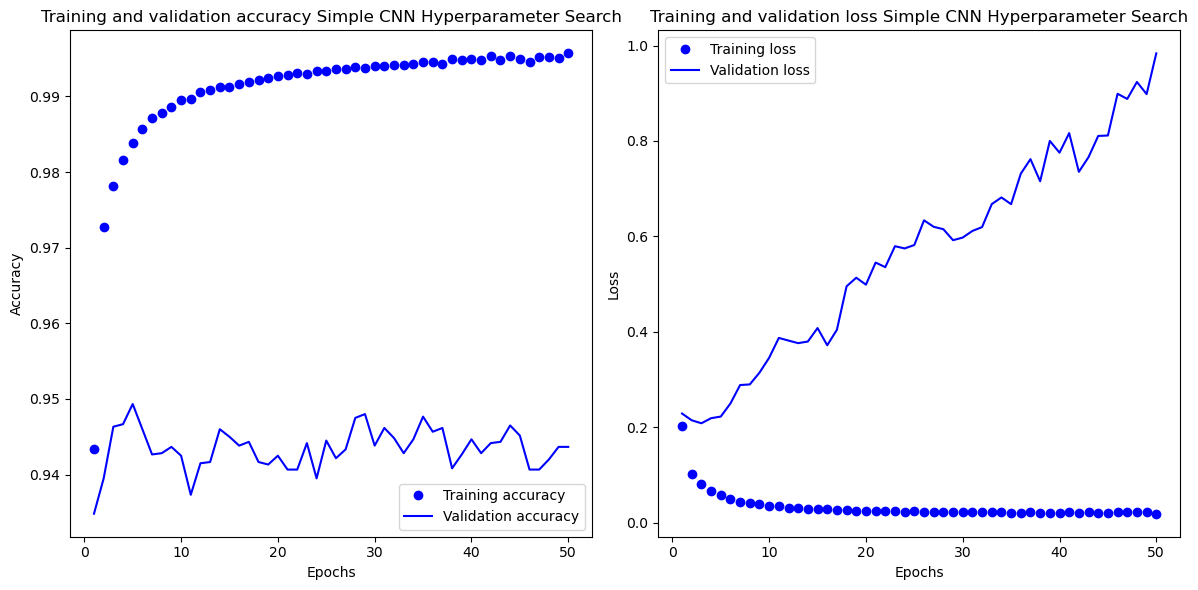

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import display_accuracy_loss

# Plot Training and validation Accuracy and loss.
display_accuracy_loss(initial_relu_model_hyper_p_history, 'Simple CNN Hyperparameter Search' )


Printing the training time history in cell below

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_model_times

# Print Training time information
display_model_times(initial_relu_model_hyper_p_time)

Total Time: 0:37:00.595923 Average Epoch Time: 0:00:44.411918


Load the model that performed the best during training based on validation loss.

In [53]:
# Configure the path to the saved model information
hyper_model_path = 'Saved Models/1. Model 1/Hyper p/'

# Load the best model saved during training based on validation loss
initial_relu_model_hyper_p_best = tf.keras.models.load_model(hyper_model_path + "initial_relu_model_hyper_p_best.keras")

Evaluate the best model using the test dataset.

In [ ]:
initial_relu_model_hyper_p_best.evaluate(test_dataset)

204/204 [==============================] - 1s 5ms/step - loss: 0.2100 - accuracy: 0.9476


[0.20999173820018768, 0.9476413726806641]

Model 2 achieves an accuracy of 94.76%

To evaluate the model's performance of each digit classification, i plot the confusion matrix.

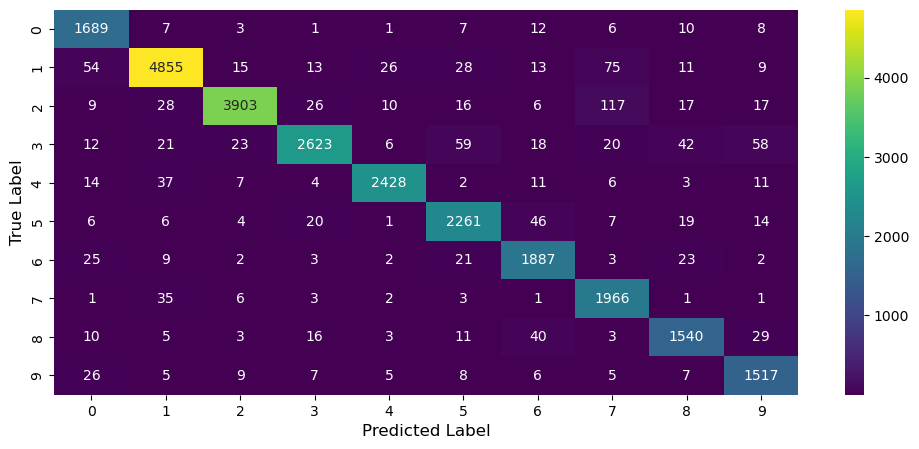

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import generate_confusion_matrix

# Plot the confusion matrix
mode_2_cm = generate_confusion_matrix(initial_relu_model_hyper_p_best, test_dataset)

## Model 1B & 2: Comparison

The established hyperparameters are compared to the Simple CNN with Max Pool settings.  Both models have high training accuracy (~99%), indicating good data fit.  Validation accuracy ranges from 93-95%, indicating overfitting and a gap from training performance.  The fact that training loss continuously falls and stabilises at zero and validation loss initially remains low but soon grows over time indicates overfitting. 

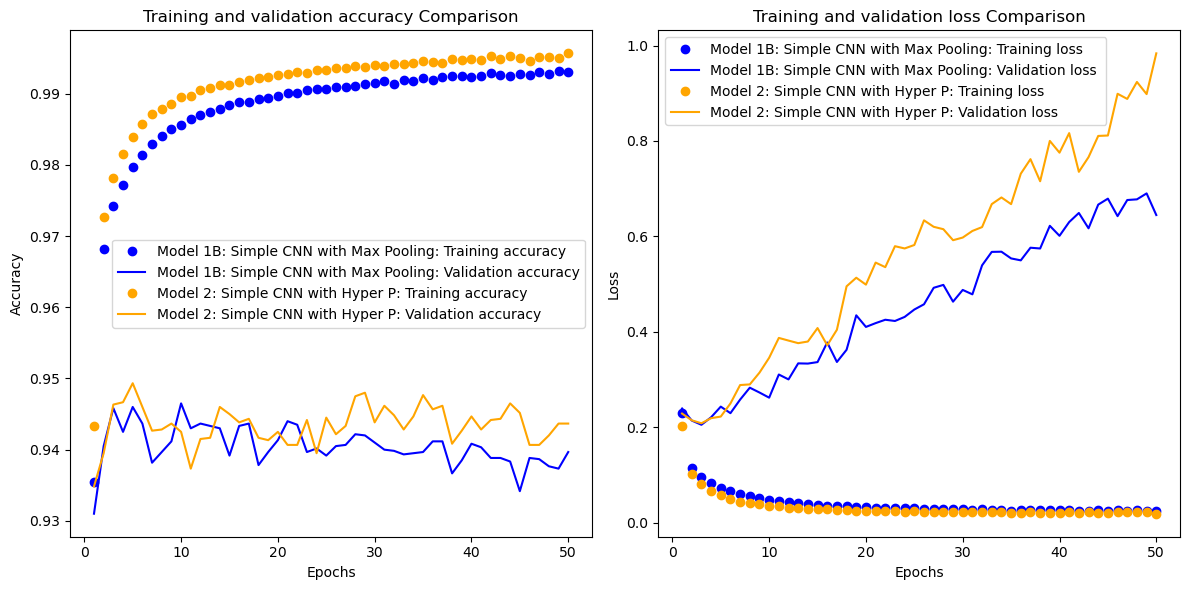

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import plot_accuracy_metric_comparison

import pandas as pd

# Load the model history
pd1 = pd.DataFrame(model_2_max_pooling_history)

# Load the model history
pd2 = pd.DataFrame(initial_relu_model_hyper_p_history)

# Plot the comparison Graphs
plot_accuracy_metric_comparison(pd1,'Model 1B: Simple CNN with Max Pooling', pd2, 'Model 2: Simple CNN with Hyper P',  'Comparison')



The table below tells us that the found hyperparameters have increased the computational complexity and resulted in a longer training time.

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import compare_times

compare_times(model_2_max_pooling_time, initial_relu_model_hyper_p_time)

Average Epoch      Total Time
Model                                  
Model_1  0:00:20.504057  0:17:05.202830
Model_2  0:00:44.411918  0:37:00.595923

In the Below output, the Simple CNN with Max Pool has fewer inactive neurons in the first two layers compared to Model 2, suggesting more consistent neuron usage. Despite Model 2 having additional filters, many appear to fire rarely. Mean activation analysis across layers shows that Simple CNN with Max Pool maintains higher average activations (0.05–0.2), indicating more frequent neuron usage. In contrast, Model 2 exhibits sparser activations, with most values near zero.

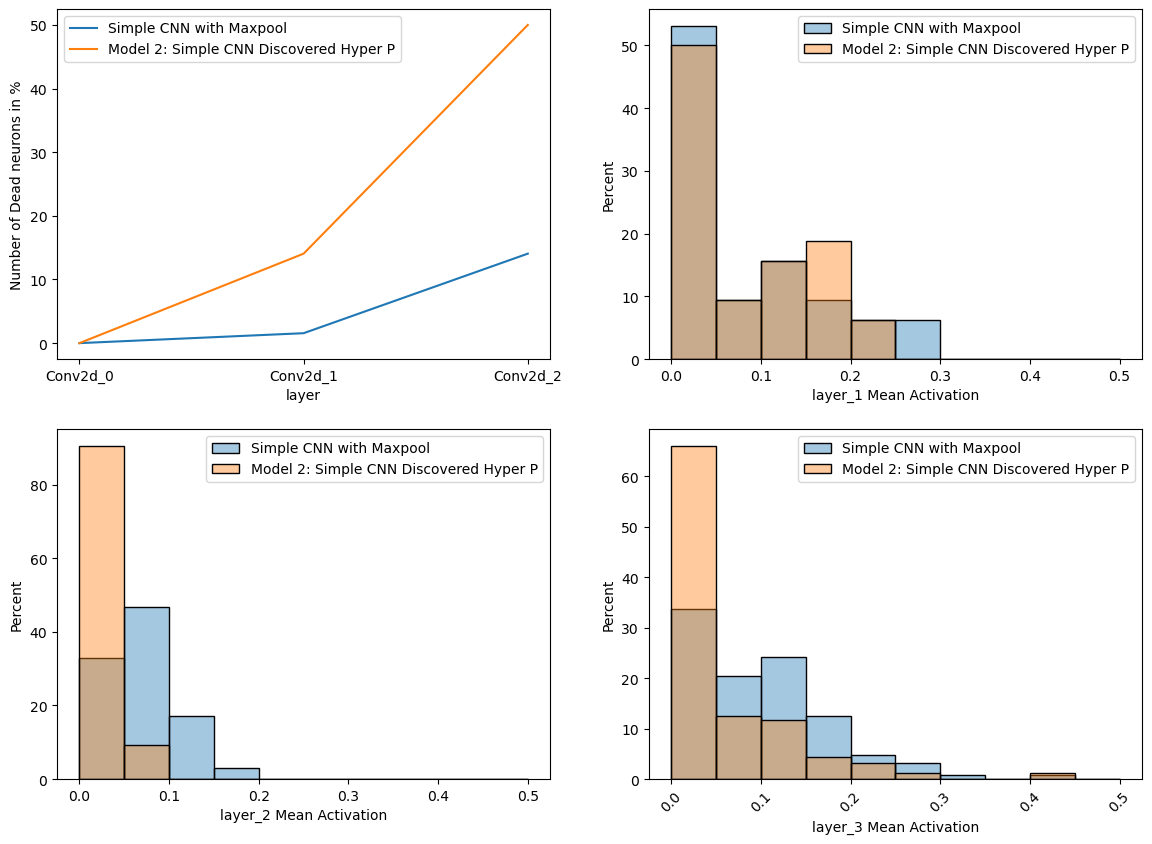

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_neurons_count, display_mean_activations

fig, axes = plt.subplots(2, 2, figsize=(14, 10))



display_neurons_count(model_2_max_pooling_best, test_dataset, ('Simple CNN with Maxpool', axes[0,0]) )
display_neurons_count(initial_relu_model_hyper_p_best, test_dataset, ('Model 2: Simple CNN Discovered Hyper P', axes[0,0]) )

display_mean_activations(model_2_max_pooling_best, test_dataset, '1', 0, 0.5, 11, ('Simple CNN with Maxpool', axes[0,1]) )
display_mean_activations(initial_relu_model_hyper_p_best, test_dataset, '1', 0, 0.5, 11, ('Model 2: Simple CNN Discovered Hyper P', axes[0,1]) )

display_mean_activations(model_2_max_pooling_best, test_dataset, '2', 0, 0.5, 11, ('Simple CNN with Maxpool', axes[1,0]) )
display_mean_activations(initial_relu_model_hyper_p_best, test_dataset, '2', 0, 0.5, 11, ('Model 2: Simple CNN Discovered Hyper P', axes[1,0]) )

display_mean_activations(model_2_max_pooling_best, test_dataset, '3', 0, 0.5, 11, ('Simple CNN with Maxpool', axes[1,1]) )
display_mean_activations(initial_relu_model_hyper_p_best, test_dataset, '3', 0, 0.5, 11, ('Model 2: Simple CNN Discovered Hyper P', axes[1,1]) )


The confusion matrix suggests that there is not much difference between the two models, as shown by their similar test accuracy scores. A negative number (bluer square) indicates that the Simple CNN Model with Max Pooling classifies digits better, while a positive number (redder square) means Model 2 – hyperparameter search performs better.

You can see that Model 2 performs better on digits 2, 3, 4, and 8 (highlighted in red), which includes some of the majority class. Meanwhile, the Simple CNN with Max Pooling performs better on the minority classes.

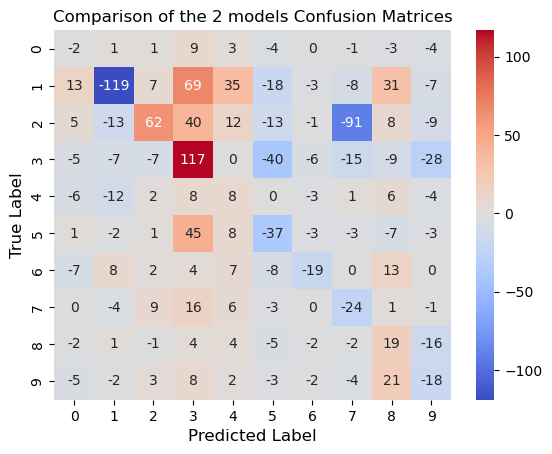

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import model_comparison_confusion_matrix

model_comparison_confusion_matrix(model_2_max_pooling_best, initial_relu_model_hyper_p_best, test_dataset )

# Dropout Vs Dropblock

## Model 3: Dropout

### Hyperparameter Tuning

In the following example, I am configuring a model to use Keras Tuner's random search feature to find the optimal Dropout hyperparameter settings. I have applied 5 dropout layers with a range of values [0.25,0.5,0.75].

In [ ]:
import keras
from keras import layers

# Define a Keras CNN model with Dropout regularization and hyperparameter tuning
def simple_model_Relu_with_dropout_hyper_p(hp):

    model = keras.Sequential()
    
    model.add(layers.InputLayer(input_shape=(32, 32, 3)))

    # First Dropout layer with a hyperparameter choice of dropout rate
    model.add(layers.Dropout(rate=hp.Choice('rate_1', [0.25,0.5,0.75])))

    model.add(layers.Conv2D(32, kernel_size=(3, 3), strides=(1,1), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    # Second Dropout layer with hyperparameter choice    
    model.add(layers.Dropout(rate=hp.Choice('rate_2', [0.25,0.5,0.75])))

    model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=(1,1), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    # Third Dropout layer with hyperparameter choic    
    model.add(layers.Dropout(rate=hp.Choice('rate_3', [0.25,0.5,0.75]))) 

    model.add(layers.Conv2D(128,kernel_size=(3, 3), strides=(1,1), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    # Fourth Dropout layer with hyperparameter choice    
    model.add(layers.Dropout(rate=hp.Choice('rate_4', [0.25,0.5,0.75])))

    model.add(layers.Flatten())

    model.add(layers.Dense(256, activation='relu'))
     # Fifth Dropout layer with hyperparameter choice
    model.add(layers.Dropout(rate=hp.Choice('rate_5', [0.25,0.5,0.75])))

    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
    )
    return model    
   
    



Below, I am checking the model compiles correctly with the Keras tuner hyperparameters selection

In [ ]:
import keras_tuner

# Checking the Model compiles
simple_model_Relu_with_dropout_hyper_p(keras_tuner.HyperParameters())

Below, I am setting up the search parameters for the hyperparameter search trials.

In [ ]:
# Create path for the hyperparameter trails
model_3_hyper_v_path = 'saved models/2. model 2 dropout/hyper p/'

# Setup the hyperparameter search
tuner = keras_tuner.RandomSearch(
    hypermodel=simple_model_Relu_with_dropout_hyper_p,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    overwrite=False,
    directory=model_3_hyper_v_path,
    project_name="simple_model_Relu_with_dropout_hyper_p",
)
tuner.search_space_summary()


Reloading Tuner from saved models/2. model 2 dropout/hyper p/simple_model_Relu_with_dropout_hyper_p\tuner0.json
Search space summary
Default search space size: 5
rate_1 (Choice)
{'default': 0.25, 'conditions': [], 'values': [0.25, 0.5, 0.75], 'ordered': True}
rate_2 (Choice)
{'default': 0.25, 'conditions': [], 'values': [0.25, 0.5, 0.75], 'ordered': True}
rate_3 (Choice)
{'default': 0.25, 'conditions': [], 'values': [0.25, 0.5, 0.75], 'ordered': True}
rate_4 (Choice)
{'default': 0.25, 'conditions': [], 'values': [0.25, 0.5, 0.75], 'ordered': True}
rate_5 (Choice)
{'default': 0.25, 'conditions': [], 'values': [0.25, 0.5, 0.75], 'ordered': True}


Below, I use EarlyStopping callback below to save time.  If validation accuracy does not improve after 5 epochs, the trial will end and move on.

 I'm also using the hyper_p_dataset, a subset of the complete dataset, and setting the trial epoch to 25.  This speeds up search and lets the model train for a number of epochs.

In [ ]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)

# Setup Earlystopping to stop the train when the validation loss doesn't improve
early_stop = [tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5)
]

# Configure search Parameters
tuner.search(
    hyper_p_dataset,                                # Training data and labels
    validation_data=(val_dataset),                  # Validation data and labels
    epochs=25,                                      # Number of epochs
    class_weight=d_class_weights,                   # Adding Class Weights
    callbacks=[early_stop],                         # Callbacks
    verbose=1                                       # Verbosity mode (1 for progress bar)
)

Below cell, I am displaying the best model architecture found.

In [ ]:
# Get Top model configuration
models = tuner.get_best_models(num_models=1)
# Load top model configuration
best_model = models[0]
# Print summary of top model
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                    

Below Cell, I am just displaying all the trail results.

In [ ]:
# Display all results
tuner.results_summary()


Results summary
Results in saved models/2. model 2 dropout/hyper p/simple_model_Relu_with_dropout_hyper_p
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 04 summary
Hyperparameters:
rate_1: 0.25
rate_2: 0.5
rate_3: 0.25
rate_4: 0.25
rate_5: 0.25
Score: 0.9225000143051147

Trial 03 summary
Hyperparameters:
rate_1: 0.5
rate_2: 0.25
rate_3: 0.5
rate_4: 0.25
rate_5: 0.5
Score: 0.8933333158493042

Trial 11 summary
Hyperparameters:
rate_1: 0.5
rate_2: 0.25
rate_3: 0.25
rate_4: 0.5
rate_5: 0.75
Score: 0.8820000290870667

Trial 02 summary
Hyperparameters:
rate_1: 0.5
rate_2: 0.25
rate_3: 0.25
rate_4: 0.5
rate_5: 0.5
Score: 0.8784999847412109

Trial 09 summary
Hyperparameters:
rate_1: 0.5
rate_2: 0.5
rate_3: 0.5
rate_4: 0.5
rate_5: 0.25
Score: 0.8654999732971191

Trial 10 summary
Hyperparameters:
rate_1: 0.5
rate_2: 0.25
rate_3: 0.25
rate_4: 0.75
rate_5: 0.25
Score: 0.8629999756813049

Trial 07 summary
Hyperparameters:
rate_1: 0.5
rate_2: 0.75
rate_3: 0.25
rate_4: 

The top 5 search hyperparameters are loaded into a variable in the cell below.  I select the top congifuration and load the model with these values into a new variable.  The model will then be run on the entire training set.

In [ ]:
# Select the Top 5 performing hyperparameters configurations
best_hps = tuner.get_best_hyperparameters(5)

# Load a new model with the Top configuration
initial_relu_model_with_dropout_hyper_p = simple_model_Relu_with_dropout_hyper_p(best_hps[0])

I am setting up the path to save the top-performing model for the model checkpoint callback in the cell below.  Providing the fit function two calls back that save the best model and record the training time.  The full training dataset and the validation set are used, along with the epoch rate and the class weighted dictionary.

In [ ]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)

# Configure the path to save the model information
model_3_hyper_v_path = 'saved models/2. model 2 dropout/hyper p/'

# Call Modelcheckpoint to save the best model with the validation loss
best_model = [tf.keras.callbacks.ModelCheckpoint(
        filepath=model_3_hyper_v_path + "initial_relu_model_with_dropout_best_hyper_p.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Record the training time of the model
initial_relu_model_with_dropout_hyper_p_time = TimeHistory()

# Save model History and fit the model
initial_relu_model_with_dropout_hyper_p_history = initial_relu_model_with_dropout_hyper_p.fit(
    train_dataset,                                                                       # Training data and labels
    validation_data=(val_dataset),                                                       # Validation data and labels
    epochs=50,                                                                           # Number of epochs
    class_weight=d_class_weights,                                                        # Adding Class Weights
    callbacks=[best_model, initial_relu_model_with_dropout_hyper_p_time],                # Callbacks
    verbose=1                                                                            # Verbosity mode (1 for progress bar)
)

Saving the model information in the below cell

In [ ]:
import importlib
import utils.model_utils
importlib.reload(utils.model_utils)
from utils.model_utils import save_model_data

# Save model, model history and training time information
save_model_data(model_3_hyper_v_path,
               initial_relu_model_with_dropout_hyper_p,'initial_relu_model_with_dropout_hyper_p',
               initial_relu_model_with_dropout_hyper_p_history, 'initial_relu_model_with_dropout_hyper_p_history',
               initial_relu_model_with_dropout_hyper_p_time, 'initial_relu_model_with_dropout_hyper_p_time'  )

I plot model accuracy and loss history in the cell below.

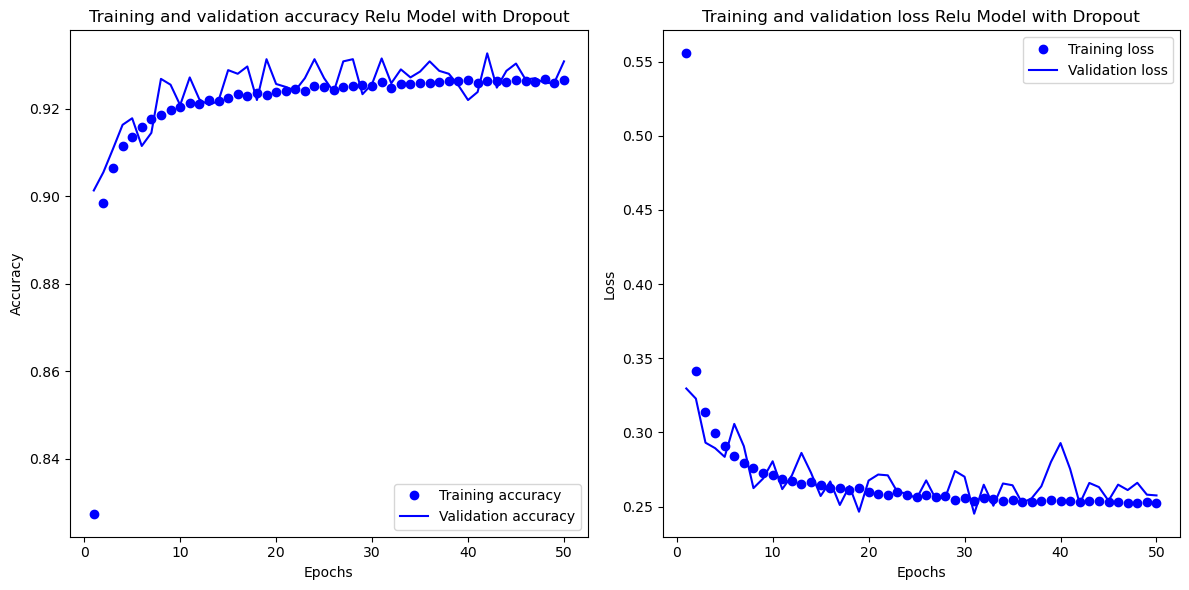

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import display_accuracy_loss

# Plot Training and validation Accuracy and loss.
display_accuracy_loss(initial_relu_model_with_dropout_hyper_p_history, 'Relu Model with Dropout', reload=True )

Printing the training time history in cell below

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_model_times

# Print the model Training Time
display_model_times(initial_relu_model_with_dropout_hyper_p_time, reload=True)

Total Time: 0:18:59.880183 Average Epoch Time: 0:00:22.797604


Load the best performing model that was trained and saved according to validation loss

In [ ]:
# Configure the path to the saved model information
model_3_hyper_v_path = 'saved models/2. model 2 dropout/hyper p/'

# Load the best model saved during training based on validation loss
initial_relu_model_with_dropout_best_hyper_p = tf.keras.models.load_model(model_3_hyper_v_path +
                                                                   'initial_relu_model_with_dropout_best_hyper_p.keras')

Evaluate the best performing model on the test dataset

In [ ]:
# Evaluating the model on the test dataset
initial_relu_model_with_dropout_best_hyper_p.evaluate(test_dataset)

204/204 [==============================] - 1s 3ms/step - loss: 0.2438 - accuracy: 0.9379


[0.24380727112293243, 0.9379225373268127]

Model 3 achieves an accuracy of 93.79%

Plotting the confusion matrix to see how the model handle each digit classification

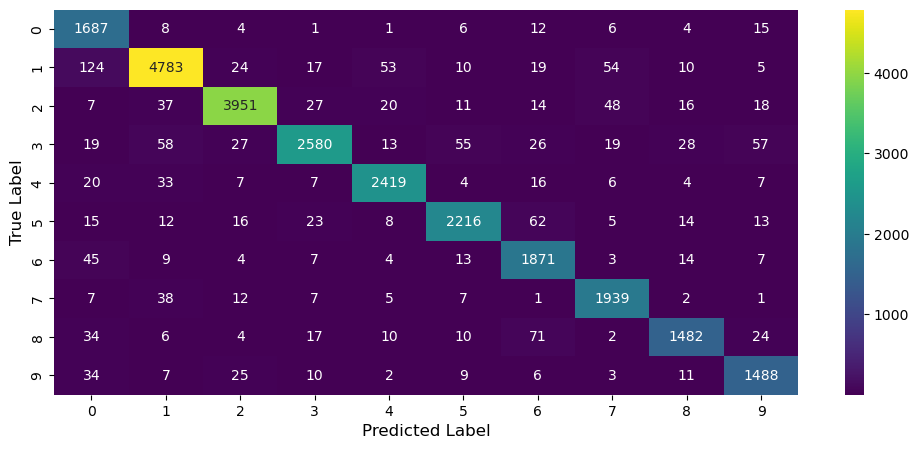

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import generate_confusion_matrix

# Plot the confusion matrix
dropout_cm = generate_confusion_matrix(initial_relu_model_with_dropout_best_hyper_p, test_dataset)

## Model 4: Dropblock

### Hyperparameter Tuning

In order to get the best-performing hyperparameters, I've set up a model below that uses Keras Tuner's random search feature to find the ideal Dropblock hyperparameter values. I have applied 4 dropblock layers with a with a rate range of [0.2, 0.3,0.4] and a block size range of [2, 3, 4].

In [ ]:
import keras
from keras import layers

import importlib
import utils.DropBlock
importlib.reload(utils.DropBlock)
from utils.DropBlock import DropBlock2D

# Define a CNN model with DropBlock regularization and hyperparameter tuning
def simple_model_Relu_with_dropblock_hyper_p(hp):

    model = keras.Sequential()
    
    model.add(layers.InputLayer(input_shape=(32, 32, 3)))
    # First DropBlock layer with hyperparameter choices for rate and block size
    model.add(DropBlock2D(rate=hp.Choice('rate_1',[0.2, 0.3,0.4]),
                          block_size=hp.Choice('block_size_1', [2, 3, 4] )))

    model.add(layers.Conv2D(32, kernel_size=(3, 3),
                            strides=(1,1),
                             activation='relu'))
    # Second DropBlock layer
    model.add(DropBlock2D(rate=hp.Choice('rate_2',[0.2, 0.3,0.4]),
                          block_size=hp.Choice('block_size_2', [2, 3, 4] )))
    model.add(layers.MaxPooling2D(pool_size=(2,2),
                                  strides=(2,2)))    
    

    model.add(layers.Conv2D(64, kernel_size=(3, 3),
                            strides=(1,1),
                             activation='relu'))
    # Third DropBlock layer
    model.add(DropBlock2D(rate=hp.Choice('rate_3',[0.2, 0.3,0.4]),
                          block_size=hp.Choice('block_size_3', [2, 3, 4] )))
    model.add(layers.MaxPooling2D(pool_size=(2,2),
                                  strides=(2,2)))    


    model.add(layers.Conv2D(128,kernel_size=(3, 3),
                            strides=(1,1),
                            activation='relu'))
    # Fourth DropBlock layer
    model.add(DropBlock2D(rate=hp.Choice('rate_4',[0.2, 0.3,0.4]),
                          block_size=hp.Choice('block_size_4', [2, 3, 4] )))
    model.add(layers.MaxPooling2D(pool_size=(2,2),
                                  strides=(2,2)))    


    model.add(layers.Flatten())

    model.add(layers.Dense(256, activation='relu'))

    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
    )
    return model    
   

Below, I am checking the model compiles correctly with the Keras tuner hyperparameters selection

In [ ]:
import keras_tuner

# Check the Model compiles
simple_model_Relu_with_dropblock_hyper_p(keras_tuner.HyperParameters())

Below, I am setting up the search parameters for the hyperparameter search trials.

In [ ]:
# Create path for the hyperparameter trails
model_4_hyper_v_path = 'saved models/3. model 3 dropblock/hyper p/'

# Setup the hyperparameter search
tuner = keras_tuner.RandomSearch(
    hypermodel=simple_model_Relu_with_dropblock_hyper_p,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    overwrite=False,
    directory=model_4_hyper_v_path,
    project_name="simple_model_Relu_with_dropblock_hyper_p",
)
tuner.search_space_summary()

Reloading Tuner from saved models/3. model 3 dropblock/hyper p/simple_model_Relu_with_dropblock_hyper_p\tuner0.json
Search space summary
Default search space size: 8
rate_1 (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}
block_size_1 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4], 'ordered': True}
rate_2 (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}
block_size_2 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4], 'ordered': True}
rate_3 (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}
block_size_3 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4], 'ordered': True}
rate_4 (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}
block_size_4 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4], 'ordered': True}


To save time, I use the EarlyStopping callback below.   The trial will end and advance if, after five epochs, validation accuracy does not increase.

  In addition, I have the trial epoch set to 25 and am utilising the hyper_p_dataset, which is a subset of the full dataset.   This allows the model to train over several epochs and speeds up search.

In [ ]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)

# Setup Earlystopping to stop the train when the validation loss doesn't improve
early_stop = [tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5)
]

# Configure search Parameters
tuner.search(
    hyper_p_dataset,                                  # Training data and labels
    validation_data=(val_dataset),                    # Validation data and labels
    epochs=25,                                        # Number of epochs
    class_weight=d_class_weights,                     # Adding Class Weights
    callbacks=[early_stop],                           # Callbacks
    verbose=1                                         # Verbosity mode (1 for progress bar)
)

Below cell, I am displaying the best model architecture found.

In [ ]:
# Get the top 2 best models
models = tuner.get_best_models(num_models=1)
# Store the top model in a variable
best_model = models[0]
# Display the model summary
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 drop_block2d (DropBlock2D)  (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 drop_block2d_1 (DropBlock2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 drop_block2d_2 (DropBlock2D  (None, 13, 13, 64)       0

In [ ]:
# Display all results
tuner.results_summary()

Results summary
Results in saved models/3. model 3 dropblock/hyper p/simple_model_Relu_with_dropblock_hyper_p
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 09 summary
Hyperparameters:
rate_1: 0.2
block_size_1: 4
rate_2: 0.3
block_size_2: 2
rate_3: 0.2
block_size_3: 4
rate_4: 0.2
block_size_4: 4
Score: 0.9328333139419556

Trial 03 summary
Hyperparameters:
rate_1: 0.2
block_size_1: 4
rate_2: 0.4
block_size_2: 4
rate_3: 0.2
block_size_3: 2
rate_4: 0.4
block_size_4: 2
Score: 0.9281666874885559

Trial 18 summary
Hyperparameters:
rate_1: 0.2
block_size_1: 2
rate_2: 0.2
block_size_2: 2
rate_3: 0.2
block_size_3: 3
rate_4: 0.4
block_size_4: 3
Score: 0.9265000224113464

Trial 10 summary
Hyperparameters:
rate_1: 0.3
block_size_1: 2
rate_2: 0.3
block_size_2: 2
rate_3: 0.3
block_size_3: 4
rate_4: 0.2
block_size_4: 4
Score: 0.925000011920929

Trial 04 summary
Hyperparameters:
rate_1: 0.2
block_size_1: 3
rate_2: 0.3
block_size_2: 4
rate_3: 0.3
block_size_3: 4
rate_4: 0

The variable in the cell below is supplied with the top 5 search hyperparameters.   I import the model into a new variable after selecting the best configuration.   The complete training set will then be used to run the model.

In [ ]:
# Select the Top 5 performing hyperparameters configurations
best_hps = tuner.get_best_hyperparameters(5)

# Load a new model with the Top configuration
initial_relu_model_with_dropblock_hyper_p = simple_model_Relu_with_dropblock_hyper_p(best_hps[0])

In the cell below, I'm setting up the path to save the best model for the model checkpoint return.   Providing gives the fit function two calls back that save the best model and keep track of the training time.   The epoch rate, the class weighted dictionary, and the entire training and validation datasets are used.

In [ ]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)

# Configure the path to save the model information
model_4_hyper_v_path = 'saved models/3. model 3 dropblock/hyper p/'

best_model = [tf.keras.callbacks.ModelCheckpoint(
        filepath=model_4_hyper_v_path + "initial_relu_model_with_dropblock_best_hyper_p.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Record the training time of the model
initial_relu_model_with_dropblock_hyper_p_time = TimeHistory()

# Save model History and fit the model
initial_relu_model_with_dropblock_hyper_p_history = initial_relu_model_with_dropblock_hyper_p.fit(
    train_dataset,                                  # Training data and labels
    validation_data=(val_dataset),                  # Validation data and labels
    epochs=50,                                     # Number of epochs
    class_weight=d_class_weights,                   # Adding Class Weights
    callbacks=[best_model, initial_relu_model_with_dropblock_hyper_p_time],             # Callbacks
    verbose=1                                       # Verbosity mode (1 for progress bar)
)

Saving the model information in the below cell

In [ ]:
import importlib
import utils.model_utils
importlib.reload(utils.model_utils)
from utils.model_utils import save_model_data


save_model_data(model_3_hyper_v_path,
               initial_relu_model_with_dropblock_hyper_p,'initial_relu_model_with_dropblock_hyper_p',
               initial_relu_model_with_dropblock_hyper_p_history, 'initial_relu_model_with_dropblock_hyper_p_history',
               initial_relu_model_with_dropblock_hyper_p_time, 'initial_relu_model_with_dropblock_hyper_p_time'  )

I plot model accuracy and loss history in the cell below.

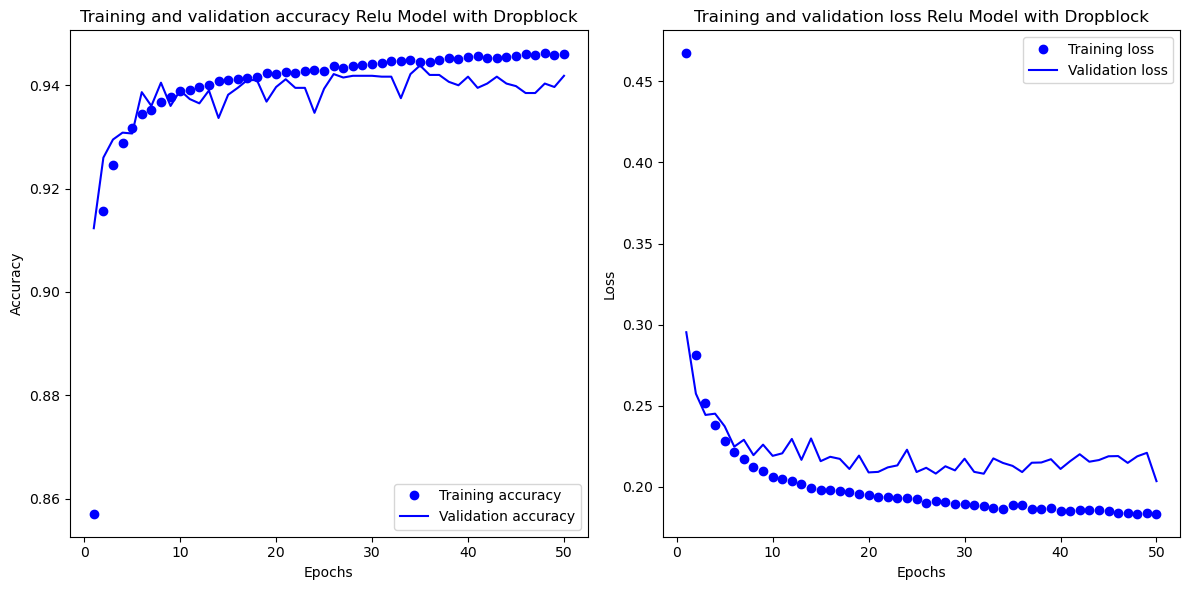

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import display_accuracy_loss

# Plot Training and validation Accuracy and loss.
display_accuracy_loss(initial_relu_model_with_dropblock_hyper_p_history, 'Relu Model with Dropblock' , reload=True)

Printing the training time history in cell below

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_model_times

# Print the model Training Time
display_model_times(initial_relu_model_with_dropblock_hyper_p_time, reload=True)

Total Time: 0:33:37.342581 Average Epoch Time: 0:00:40.346852


Load the best performing model that was trained and saved according to validation loss

In [ ]:
# Importing the Dropblock Library.
from utils.DropBlock import DropBlock2D

# Configure the path to the saved model information
model_4_hyper_v_path = 'saved models/3. model 3 dropblock/hyper p/'


# Load the best model saved during training based on validation loss
initial_relu_model_with_dropblock_best_hyper_p = tf.keras.models.load_model(model_4_hyper_v_path +
                                                                   'initial_relu_model_with_dropblock_hyper_p.keras', {"DropBlock2D": DropBlock2D})

Evaluate the best performing model on the test dataset

In [ ]:
# Evaluating the model on the test dataset
initial_relu_model_with_dropblock_best_hyper_p.evaluate(test_dataset)

204/204 [==============================] - 1s 3ms/step - loss: 0.2008 - accuracy: 0.9475


[0.20084699988365173, 0.9474877119064331]

Model 4 achieves an accuracy of 94.75%

Plotting the confusion matrix to see how the model handle each digit classification

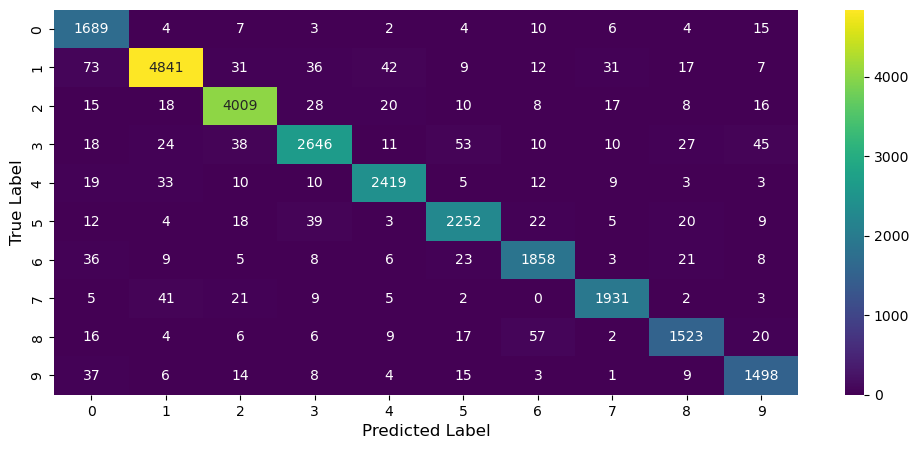

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import generate_confusion_matrix

# Plot the confusion matrix
dropblock_cm = generate_confusion_matrix(initial_relu_model_with_dropblock_best_hyper_p, test_dataset)

## Model 3 & 4: Comparison

Applying Dropout reduces training accuracy from 99% to 92% and validation accuracy from 94% to 92%. DropBlock achieves higher accuracy, with training at 94% and validation at 93%.  In terms of loss, both Dropout and DropBlock exhibit a minimal gap between training and validation loss, indicating very minimal over-fitting

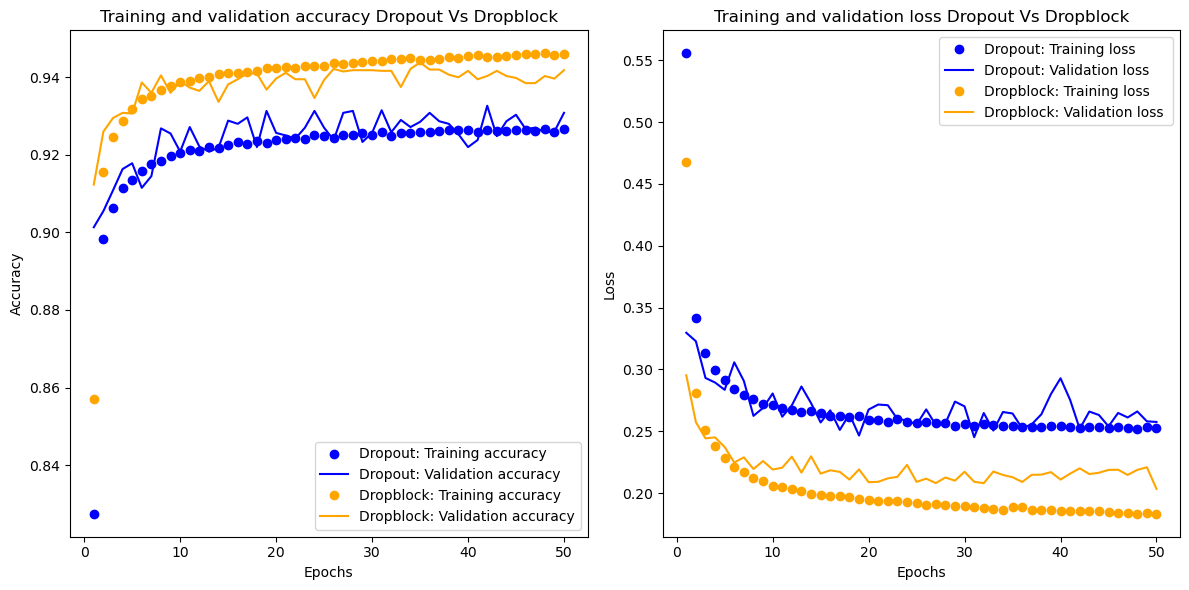

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import plot_accuracy_metric_comparison
import pandas as pd

# Load the model history into a dataframe
pd1 = pd.DataFrame(initial_relu_model_with_dropout_hyper_p_history.history)

# Load the model history into a dataframe
pd2 = pd.DataFrame(initial_relu_model_with_dropblock_hyper_p_history.history)

# Plot the comparison Graphs
plot_accuracy_metric_comparison(pd1,'Dropout', pd2, 'Dropblock',  'Dropout Vs Dropblock')


Dropout and Dropblock training time have increased from the Simple CNN with Max Pool settings Model 1B. Dropblock has almost doubled the training time.

Reasons for this:
- Dropout makes training take longer because each time the network has to learn with a different group of neurones.
- When compared to element-wise Dropout, making and using block masks can add a small amount of extra work to the model. This is because the model has to make up for suddenly missing "patches" of activations, which can slow traning time.

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import compare_times

compare_times(initial_relu_model_with_dropout_hyper_p_time, initial_relu_model_with_dropblock_hyper_p_time, reload=True)

Average Epoch      Total Time
Model                                  
Model_1  0:00:22.797604  0:18:59.880183
Model_2  0:00:40.346852  0:33:37.342581

DropBlock creates more never-activated neurons than Dropout, especially in the middle layer. Compared to the last model 1B both Dropout and DropBlock now show a tighter activation range near zero in the first two layers, suggesting these early layers capture basic features. By the third layer, both methods have increased moderate activation levels (0.0–0.45), indicating stronger responses for more complex features.

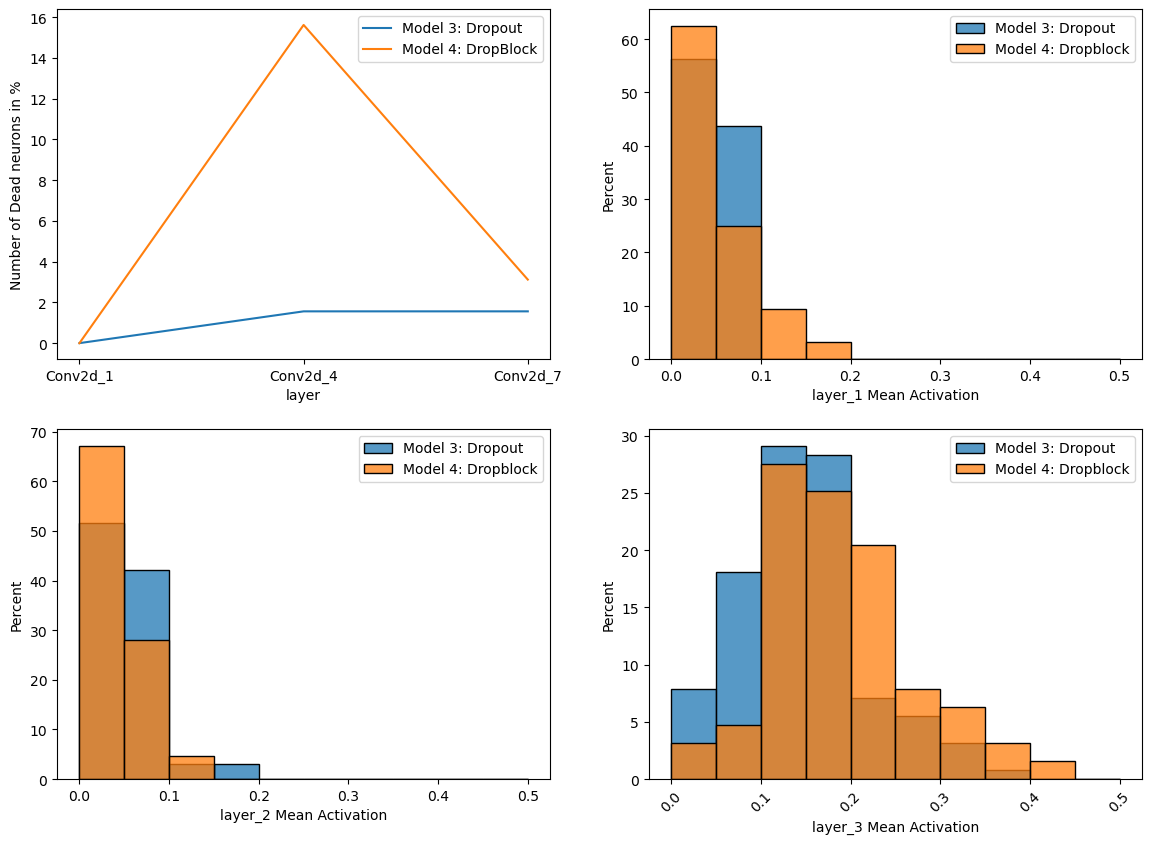

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_neurons_count, display_mean_activations

fig, axes = plt.subplots(2, 2, figsize=(14, 10))


display_neurons_count(initial_relu_model_with_dropout_best_hyper_p, test_dataset, ('Model 3: Dropout', axes[0,0]) )
display_neurons_count(initial_relu_model_with_dropblock_best_hyper_p, test_dataset, ('Model 4: DropBlock', axes[0,0]) )

display_mean_activations(initial_relu_model_with_dropout_best_hyper_p, test_dataset, '1', ('Model 3: Dropout', axes[0,1]) )
display_mean_activations(initial_relu_model_with_dropblock_best_hyper_p, test_dataset, '1', ('Model 4: Dropblock', axes[0,1]) )

display_mean_activations(initial_relu_model_with_dropout_best_hyper_p, test_dataset, '2', ('Model 3: Dropout', axes[1,0]) )
display_mean_activations(initial_relu_model_with_dropblock_best_hyper_p, test_dataset, '2', ('Model 4: Dropblock', axes[1,0]) )

display_mean_activations(initial_relu_model_with_dropout_best_hyper_p, test_dataset, '3', ('Model 3: Dropout', axes[1,1]) )
display_mean_activations(initial_relu_model_with_dropblock_best_hyper_p, test_dataset, '3', ('Model 4: Dropblock', axes[1,1]) )



Confusion Matrix: A negative number or more blue square indicates that the model 3: Dropout classifies digits better, while a positive number or more red square means the Model 4: Dropblock performs better.

Dropblock classifies digits better with more red squares on the diagonal. 

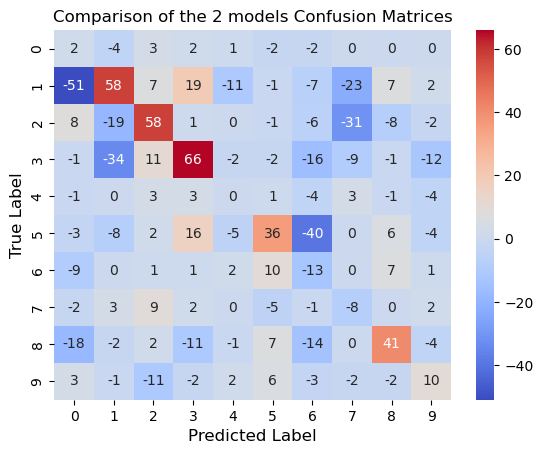

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import model_comparison_confusion_matrix

model_comparison_confusion_matrix(initial_relu_model_with_dropblock_best_hyper_p, initial_relu_model_with_dropout_best_hyper_p, test_dataset )

# Data Augmentation

Tried different augmentation techniques but this lead to a lower validation loss than training loss which implies the training data is harder to learn than the validation data. I have had to reduce the augmentation to achieve a more stable learning curve

In [43]:
from keras import layers

# Configure the contract augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomContrast(0.2)
])


# data_augmentation = tf.keras.Sequential([
#     layers.RandomBrightness(0.05),
#     layers.RandomContrast(0.05),
#     layers.RandomZoom(0.05, fill_mode='nearest'),
#     layers.RandomRotation(0.05)
# ])

This code uses TensorFlow’s tf.data API to create two training datasets with data augmentation applied in parallel. First, it loads input images (X_train_reshaped or X_train_split) and their labels (y_train_oh or y_train_oh_split) into a tf.data.Dataset. Then it applies a data augmentation layer (data_augmentation) to each image, shuffles them with a defined buffer size, batches them (with BATCH_SIZE=128), and prefetches them for efficient loading.

In [44]:
# dynamically tune the parallelism
AUTO = tf.data.AUTOTUNE

# Set natch size and shuffle size
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 10000

# run dataset preprocessing on the CPU
with tf.device('/cpu:0'):

     # Create the augmented training dataset
    aug_train_dataset = (tf.data.Dataset.from_tensor_slices((X_train_reshaped, y_train_oh))             # Convert training data into a TensorFlow dataset
                        .map(lambda x, y: (data_augmentation(x),y), num_parallel_calls=AUTO)            # Apply data augmentation in parallel
                        .shuffle(SHUFFLE_BUFFER_SIZE, seed=42)                                          # Shuffle the dataset with a fixed buffer size for randomness
                        .batch(BATCH_SIZE)                                                              # Group the dataset into batches for efficient training                                
                        .prefetch(AUTO)                                                                 # Prefetch data to improve pipeline performance by overlapping preprocessing and training
                        )
    # Create the augmented dataset for hyperparameter tuning (a subset of the training data)
    aug_train_hyper_p_dataset = (tf.data.Dataset.from_tensor_slices((X_train_split, y_train_oh_split )) # Convert training data into a TensorFlow dataset
                                .map(lambda x, y: (data_augmentation(x),y), num_parallel_calls=AUTO)    # Apply data augmentation in parallel
                                .shuffle(SHUFFLE_BUFFER_SIZE, seed=42)                                  # Shuffle the dataset with a fixed buffer size for randomness
                                .batch(BATCH_SIZE)                                                      # Group the dataset into batches for efficient training
                                .prefetch(AUTO)                                                         # Prefetch data to improve pipeline performance by overlapping preprocessing and training
                                 )

I am displaying the augmented images below.

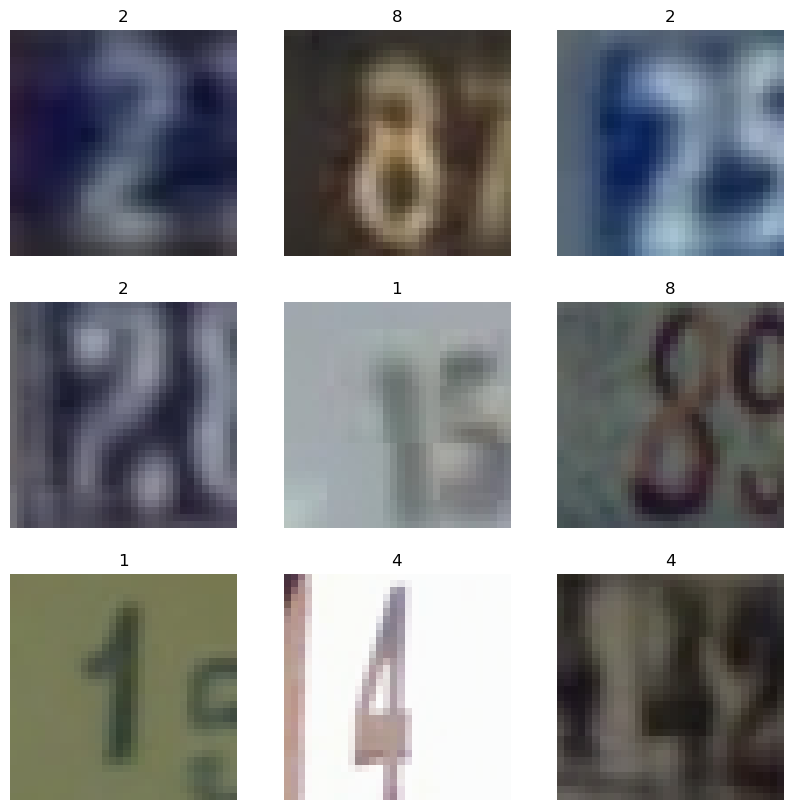

In [ ]:
# Importing Keras backend functions for tensor operations
import keras.backend as K

# Get a batch of augmented training images and their corresponding labels
image_batch, label_batch = next(iter(aug_train_dataset))

# rescaled_image = denormalizer_layer(image_batch)

# Set up a 10x10 figure for displaying images
plt.figure(figsize=(10, 10))
# Loop through the first 9 images in the batch
for i in range(9):
    
    # Create a 3x3 grid of subplots
    ax = plt.subplot(3, 3, i + 1)    

    # Set title as the class label
    plt.title(np.argmax(label_batch[i]))
    # Display the image, casting it to uint8 for proper visualizatio
    plt.imshow(K.cast(image_batch[i], dtype='uint8'))
    # Remove axis markings for cleaner visualization
    plt.axis("off")

Below, I am applying the normalization process to the augmented datasets.

In [46]:
# Create normalization layers
aug_norm = tf.keras.layers.Normalization(axis=-1)
aug_norm_hyper_p = tf.keras.layers.Normalization(axis=-1)

The datasets are mapped to extract only the feature component x

In [47]:
# Extract only the features (images) from the augmented training datasets
aug_train_dataset_features = aug_train_dataset.map(lambda x,y: x)
aug_train_hyper_p_dataset_features = aug_train_hyper_p_dataset.map(lambda x,y: x)

Adapting Normalization Layers

In [48]:
# Adapt (fit) the normalization layers to the feature distributions
aug_norm.adapt(aug_train_dataset_features)
aug_norm_hyper_p .adapt(aug_train_hyper_p_dataset_features)

The learned normalization is applied back to the original datasets

In [49]:
# Apply the learned normalization to the training dataset
aug_train_dataset = (aug_train_dataset.shuffle(SHUFFLE_BUFFER_SIZE)
                    .map(lambda x, y: (aug_norm(x),y), num_parallel_calls=AUTO)                     
                        )

# Apply the learned normalization to the hyperparameter tuning dataset
aug_train_hyper_p_dataset = (aug_train_hyper_p_dataset.shuffle(SHUFFLE_BUFFER_SIZE)
                    .map(lambda x, y: (aug_norm_hyper_p(x),y), num_parallel_calls=AUTO)                     
                        )

In [50]:
Stop Here !

SyntaxError: invalid syntax (3194995719.py, line 1)

## Model 5: Dropout with Augmentation

Reload the Dropout Model

I am reloading Model 3: Dropout configuration and tuning values to run on the augmented dataset.

In [ ]:
# Import Keras Tuner for hyperparameter tuning
import keras_tuner

# create the directory path where the hyperparameter tuning results will be saved
model_3_hyper_v_path = 'saved models/2. model 2 dropout/hyper p/'

# Reload a previously run hyperparameter tuning process using Keras Tuner
tuner_reload = keras_tuner.RandomSearch(
    hypermodel=simple_model_Relu_with_dropout_hyper_p,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    directory=model_3_hyper_v_path,
    project_name="simple_model_Relu_with_dropout_hyper_p",
    overwrite=False,
)

# Reloads previously saved tuning trials from the specified directory
tuner_reload.reload()
trials = tuner_reload.oracle.trials

# Display a summary of the tuning results
tuner_reload.results_summary()

Reloading Tuner from saved models/2. model 2 dropout/hyper p/simple_model_Relu_with_dropout_hyper_p\tuner0.json
Results summary
Results in saved models/2. model 2 dropout/hyper p/simple_model_Relu_with_dropout_hyper_p
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 04 summary
Hyperparameters:
rate_1: 0.25
rate_2: 0.5
rate_3: 0.25
rate_4: 0.25
rate_5: 0.25
Score: 0.9225000143051147

Trial 03 summary
Hyperparameters:
rate_1: 0.5
rate_2: 0.25
rate_3: 0.5
rate_4: 0.25
rate_5: 0.5
Score: 0.8933333158493042

Trial 11 summary
Hyperparameters:
rate_1: 0.5
rate_2: 0.25
rate_3: 0.25
rate_4: 0.5
rate_5: 0.75
Score: 0.8820000290870667

Trial 02 summary
Hyperparameters:
rate_1: 0.5
rate_2: 0.25
rate_3: 0.25
rate_4: 0.5
rate_5: 0.5
Score: 0.8784999847412109

Trial 09 summary
Hyperparameters:
rate_1: 0.5
rate_2: 0.5
rate_3: 0.5
rate_4: 0.5
rate_5: 0.25
Score: 0.8654999732971191

Trial 10 summary
Hyperparameters:
rate_1: 0.5
rate_2: 0.25
rate_3: 0.25
rate_4: 0.75
rate_5: 

Load the best configuration values found in the random search trial into a model.

In [ ]:
# load the top 5 best hyperparameter configurations from the tuner
best_hps = tuner_reload.get_best_hyperparameters(5)

# Use the best hyperparameter configuration to build the model
model_5_relu_model_with_dropout_aug = simple_model_Relu_with_dropout_hyper_p(best_hps[0])

# Print the model architecture summary
model_5_relu_model_with_dropout_aug.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 32, 32, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                 

In [ ]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)

# create the directory path where the best model will be saved
model_5_aug_dropout_path = 'saved models/2. model 2 dropout/aug/'

# Configure the model checkpoint call back and monitor the validation loss
best_model = [tf.keras.callbacks.ModelCheckpoint(
        filepath=model_5_aug_dropout_path + "model_5_relu_model_with_dropout_aug_best.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Record the time the model take to train
model_5_relu_model_with_dropout_aug_time = TimeHistory()

# Fit the model and record the training history
model_5_relu_model_with_dropout_aug_history = model_5_relu_model_with_dropout_aug.fit(
    aug_train_dataset,                                                                  # Training data and labels
    validation_data=(val_dataset),                                                      # Validation data and labels
    epochs=50,                                                                          # Number of epochs
    class_weight=d_class_weights,                                                       # Adding Class Weights
    callbacks=[best_model, model_5_relu_model_with_dropout_aug_time],                   # Callbacks
    verbose=1                                                                           # Verbosity mode (1 for progress bar)
)

Epoch 1/50
4675/4675 [==============================] - 33s 5ms/step - loss: 0.6022 - accuracy: 0.8104 - val_loss: 0.3257 - val_accuracy: 0.9032
Epoch 2/50
4675/4675 [==============================] - 27s 5ms/step - loss: 0.3496 - accuracy: 0.8959 - val_loss: 0.3077 - val_accuracy: 0.9127
Epoch 3/50
4675/4675 [==============================] - 26s 5ms/step - loss: 0.3230 - accuracy: 0.9040 - val_loss: 0.2791 - val_accuracy: 0.9207
Epoch 4/50
4675/4675 [==============================] - 26s 5ms/step - loss: 0.3085 - accuracy: 0.9085 - val_loss: 0.2722 - val_accuracy: 0.9240
Epoch 5/50
4675/4675 [==============================] - 26s 5ms/step - loss: 0.2986 - accuracy: 0.9118 - val_loss: 0.2869 - val_accuracy: 0.9200
Epoch 6/50
4675/4675 [==============================] - 26s 5ms/step - loss: 0.2916 - accuracy: 0.9138 - val_loss: 0.2558 - val_accuracy: 0.9290
Epoch 7/50
4675/4675 [==============================] - 26s 5ms/step - loss: 0.2868 - accuracy: 0.9154 - val_loss: 0.2605 - val_ac

Saving the model information in the below cell

In [ ]:
import importlib
import utils.model_utils
importlib.reload(utils.model_utils)
from utils.model_utils import save_model_data

# Save model, model history and training time information
save_model_data(model_5_aug_dropout_path,
               model_5_relu_model_with_dropout_aug,'model_5_relu_model_with_dropout_aug',
               model_5_relu_model_with_dropout_aug_history, 'model_5_relu_model_with_dropout_aug_history',
               model_5_relu_model_with_dropout_aug_time, 'model_5_relu_model_with_dropout_aug_time'  )

I plot model accuracy and loss history in the cell below.

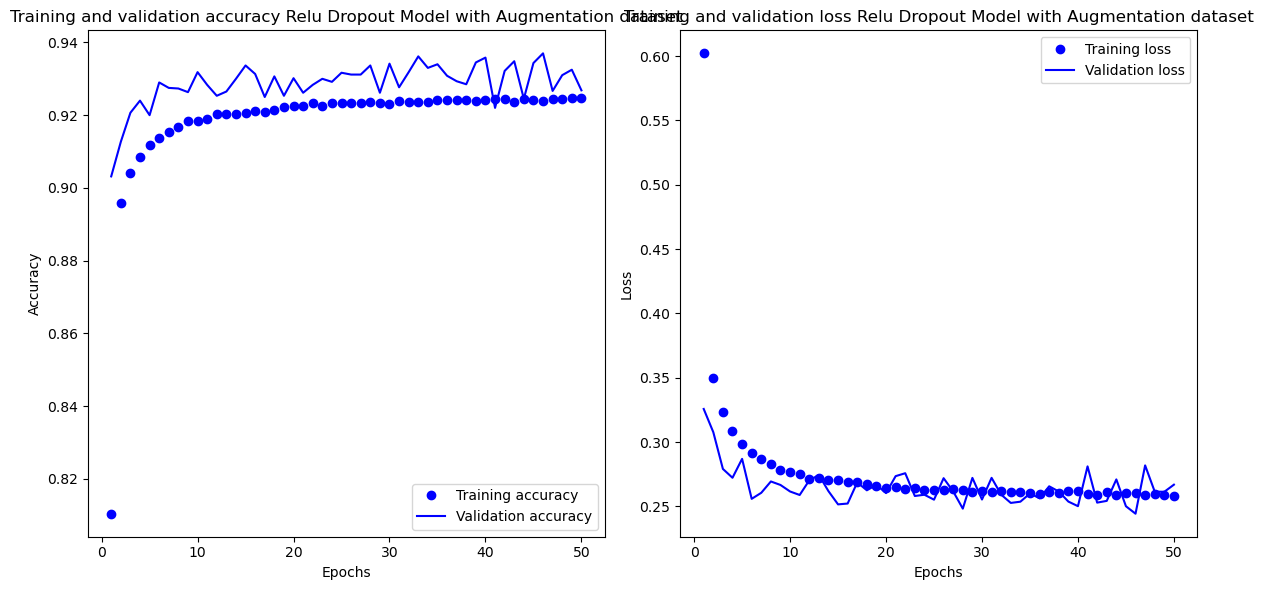

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import display_accuracy_loss

# Plot Training and validation Accuracy and loss.
display_accuracy_loss(model_5_relu_model_with_dropout_aug_history, 'Relu Dropout Model with Augmentation dataset' )

Printing the training time history in cell below

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_model_times

# Print the model Training Time
display_model_times(model_5_relu_model_with_dropout_aug_time)

Total Time: 0:21:36.255451 Average Epoch Time: 0:00:25.925109


Load the best performing model that was trained and saved according to validation loss

In [56]:
# Configure the path to the saved model information
model_5_aug_dropout_path = 'saved models/2. model 2 dropout/aug/'

# Load the best model saved during training based on validation loss
model_5_relu_model_with_dropout_aug_best = tf.keras.models.load_model(model_5_aug_dropout_path + "model_5_relu_model_with_dropout_aug_best.keras")

Evaluate the best performing model on the test dataset

In [ ]:
# Evaluate the model on the test dataset.
model_5_relu_model_with_dropout_aug_best.evaluate(test_dataset)

204/204 [==============================] - 1s 3ms/step - loss: 0.2251 - accuracy: 0.9428


[0.2251451313495636, 0.9428395628929138]

Model 5 achieves an accuracy of 94.28%

Plotting the confusion matrix to see how the model handle each digit classification

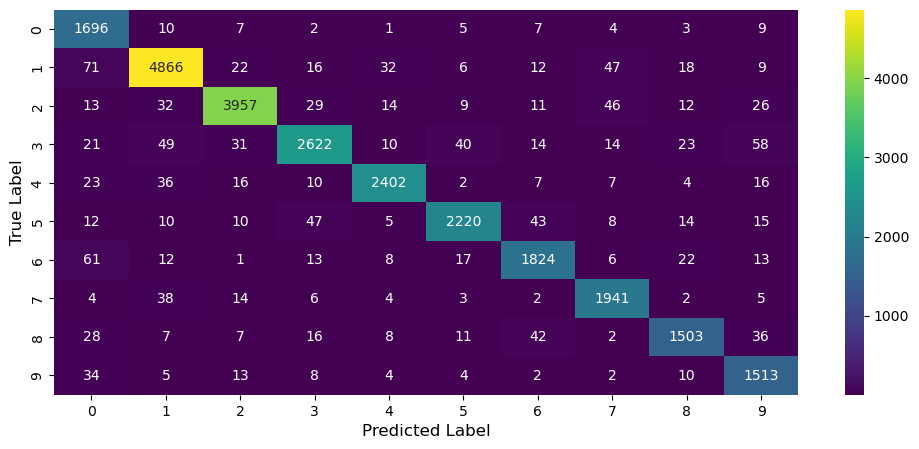

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import generate_confusion_matrix

# Display the models confusion matrix
dropout_aug_cm = generate_confusion_matrix(model_5_relu_model_with_dropout_aug_best, test_dataset)

## Model 6: Dropblock with Augmentation

I am reloading Model 4: Dropblock configuration and tuning values to run on the augmented dataset.

In [ ]:
# create the directory path where the hyperparameter tuning results will be saved
model_4_hyper_v_path = 'saved models/3. model 3 dropblock/hyper p/'

# Reload a previously run hyperparameter tuning process using Keras Tuner
tuner_reload = keras_tuner.RandomSearch(
    hypermodel=simple_model_Relu_with_dropblock_hyper_p,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    directory=model_4_hyper_v_path,
    project_name="simple_model_Relu_with_dropblock_hyper_p",
    overwrite=False,
)

# Reloads previously saved tuning trials from the specified directory
tuner_reload.reload()
trials = tuner_reload.oracle.trials

# Display a summary of the tuning results
tuner_reload.results_summary()

Reloading Tuner from saved models/3. model 3 dropblock/hyper p/simple_model_Relu_with_dropblock_hyper_p\tuner0.json
Results summary
Results in saved models/3. model 3 dropblock/hyper p/simple_model_Relu_with_dropblock_hyper_p
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 09 summary
Hyperparameters:
rate_1: 0.2
block_size_1: 4
rate_2: 0.3
block_size_2: 2
rate_3: 0.2
block_size_3: 4
rate_4: 0.2
block_size_4: 4
Score: 0.9328333139419556

Trial 03 summary
Hyperparameters:
rate_1: 0.2
block_size_1: 4
rate_2: 0.4
block_size_2: 4
rate_3: 0.2
block_size_3: 2
rate_4: 0.4
block_size_4: 2
Score: 0.9281666874885559

Trial 18 summary
Hyperparameters:
rate_1: 0.2
block_size_1: 2
rate_2: 0.2
block_size_2: 2
rate_3: 0.2
block_size_3: 3
rate_4: 0.4
block_size_4: 3
Score: 0.9265000224113464

Trial 10 summary
Hyperparameters:
rate_1: 0.3
block_size_1: 2
rate_2: 0.3
block_size_2: 2
rate_3: 0.3
block_size_3: 4
rate_4: 0.2
block_size_4: 4
Score: 0.925000011920929

Trial 04 su

Load the best configuration values found in the random search trial into a model.

In [ ]:
# load the top 5 best hyperparameter configurations from the tuner
best_hps = tuner_reload.get_best_hyperparameters(5)

# Use the best hyperparameter configuration to build the model
model_6_relu_model_with_dropblock_aug = simple_model_Relu_with_dropblock_hyper_p(best_hps[0])

# Print the model architecture summary
model_6_relu_model_with_dropblock_aug.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 drop_block2d (DropBlock2D)  (None, 32, 32, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 drop_block2d_1 (DropBlock2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 drop_block2d_2 (DropBlock2D  (None, 13, 13, 64)      

In [ ]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)

# create the directory path where the best model will be saved
model_6_relu_model_with_dropblock_aug_path = 'saved models/3. model 3 dropblock/aug/'

# Configure the model checkpoint call back and monitor the validation loss
best_model = [tf.keras.callbacks.ModelCheckpoint(
        filepath=model_6_relu_model_with_dropblock_aug_path + "model_6_relu_model_with_dropblock_aug_best.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Record the time the model take to train
model_6_relu_model_with_dropblock_aug_time = TimeHistory()

# Fit the model and record the training history
model_6_relu_model_with_dropblock_aug_history = model_6_relu_model_with_dropblock_aug.fit(
    aug_train_dataset,                                                                      # Training data and labels
    validation_data=(val_dataset),                                                          # Validation data and labels
    epochs=50,                                                                              # Number of epochs
    class_weight=d_class_weights,                                                           # Adding Class Weights
    callbacks=[best_model, model_6_relu_model_with_dropblock_aug_time],                     # Callbacks
    verbose=1                                                                               # Verbosity mode (1 for progress bar)
)

Epoch 1/50
4675/4675 [==============================] - 45s 8ms/step - loss: 0.4768 - accuracy: 0.8538 - val_loss: 0.2776 - val_accuracy: 0.9213
Epoch 2/50
4675/4675 [==============================] - 41s 8ms/step - loss: 0.2895 - accuracy: 0.9131 - val_loss: 0.2716 - val_accuracy: 0.9277
Epoch 3/50
4675/4675 [==============================] - 39s 7ms/step - loss: 0.2580 - accuracy: 0.9228 - val_loss: 0.2401 - val_accuracy: 0.9322
Epoch 4/50
4675/4675 [==============================] - 39s 7ms/step - loss: 0.2465 - accuracy: 0.9264 - val_loss: 0.2367 - val_accuracy: 0.9325
Epoch 5/50
4675/4675 [==============================] - 42s 8ms/step - loss: 0.2357 - accuracy: 0.9297 - val_loss: 0.2361 - val_accuracy: 0.9360
Epoch 6/50
4675/4675 [==============================] - 42s 8ms/step - loss: 0.2277 - accuracy: 0.9321 - val_loss: 0.2307 - val_accuracy: 0.9342
Epoch 7/50
4675/4675 [==============================] - 42s 8ms/step - loss: 0.2237 - accuracy: 0.9330 - val_loss: 0.2178 - val_ac

Saving the model information in the below cell

In [ ]:
import importlib
import utils.model_utils
importlib.reload(utils.model_utils)
from utils.model_utils import save_model_data

# Save model, model history and training time information
save_model_data(model_6_relu_model_with_dropblock_aug_path,
               model_6_relu_model_with_dropblock_aug,'model_6_relu_model_with_dropblock_aug',
               model_6_relu_model_with_dropblock_aug_history, 'model_6_relu_model_with_dropblock_aug_history',
               model_6_relu_model_with_dropblock_aug_time, 'model_6_relu_model_with_dropblock_aug_time'  )

I plot model accuracy and loss history in the cell below.

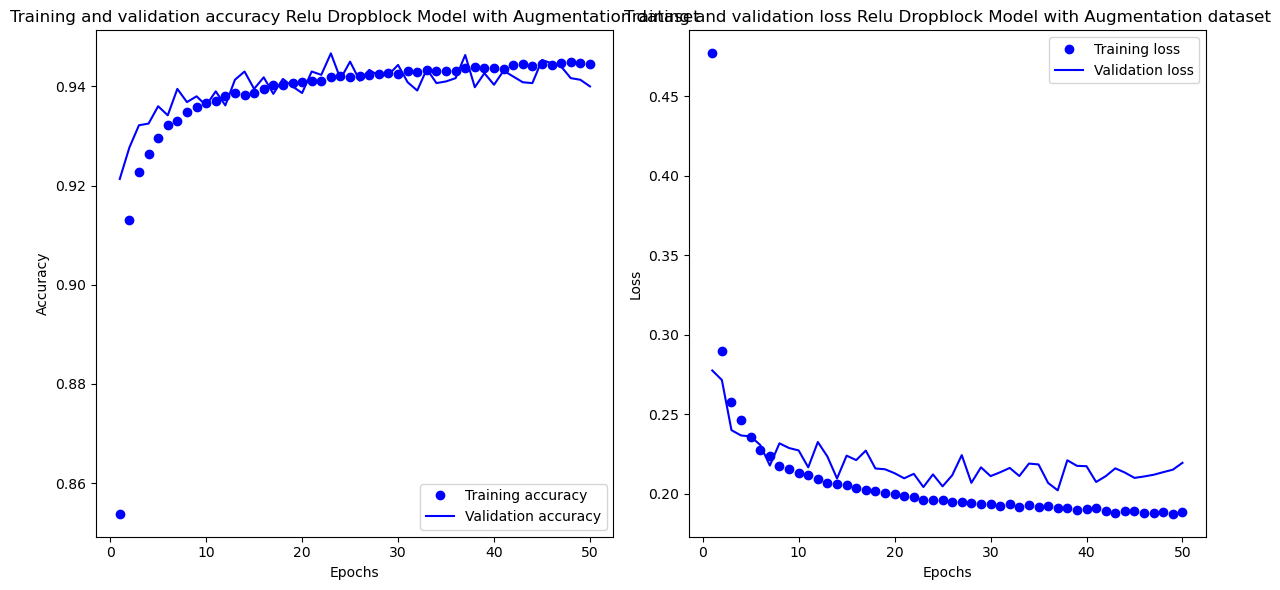

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import display_accuracy_loss

# Plot Training and validation Accuracy and loss.
display_accuracy_loss(model_6_relu_model_with_dropblock_aug_history, 'Relu Dropblock Model with Augmentation dataset' )

Printing the training time history in cell below

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_model_times

# Print the model Training Time
display_model_times(model_6_relu_model_with_dropblock_aug_time)

Total Time: 0:34:07.597585 Average Epoch Time: 0:00:40.951952


Load the best performing model that was trained and saved according to validation loss

In [57]:
import importlib
import utils.DropBlock
importlib.reload(utils.DropBlock)
from utils.DropBlock import DropBlock2D

# Configure the path to the saved model information
model_6_relu_model_with_dropblock_aug_path = 'saved models/3. model 3 dropblock/aug/'

# Load the best model saved during training based on validation loss
model_6_relu_model_with_dropblock_aug_best = tf.keras.models.load_model(model_6_relu_model_with_dropblock_aug_path + "model_6_relu_model_with_dropblock_aug_best.keras", {"DropBlock2D": DropBlock2D})

Evaluate the best performing model on the test dataset

In [ ]:
# Evaluate the model on the test dataset.
model_6_relu_model_with_dropblock_aug_best.evaluate(test_dataset)

204/204 [==============================] - 1s 3ms/step - loss: 0.1994 - accuracy: 0.9478


[0.19939202070236206, 0.9478334188461304]

Model 6 Achieves and accuracy of 94.78%

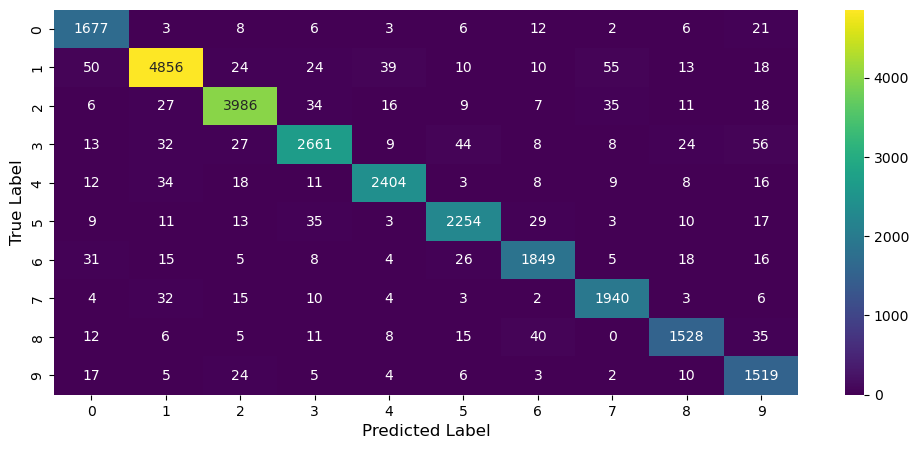

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import generate_confusion_matrix

# Display the models confusion matrix
dropout_cm = generate_confusion_matrix(model_6_relu_model_with_dropblock_aug_best, test_dataset)

## Model 5 & 6: Comparison

Both Dropout and DropBlock show results similar to the previous models, with training accuracy largely unchanged from Model 3 & 4. Dropout achieves a slight improvement in validation accuracy, while DropBlock also raises validation accuracy slightly. Notably, Augmentation narrows the gap between training and validation accuracy and loss on the Dropblock model, indicating a more stable fit compared to Model 4 

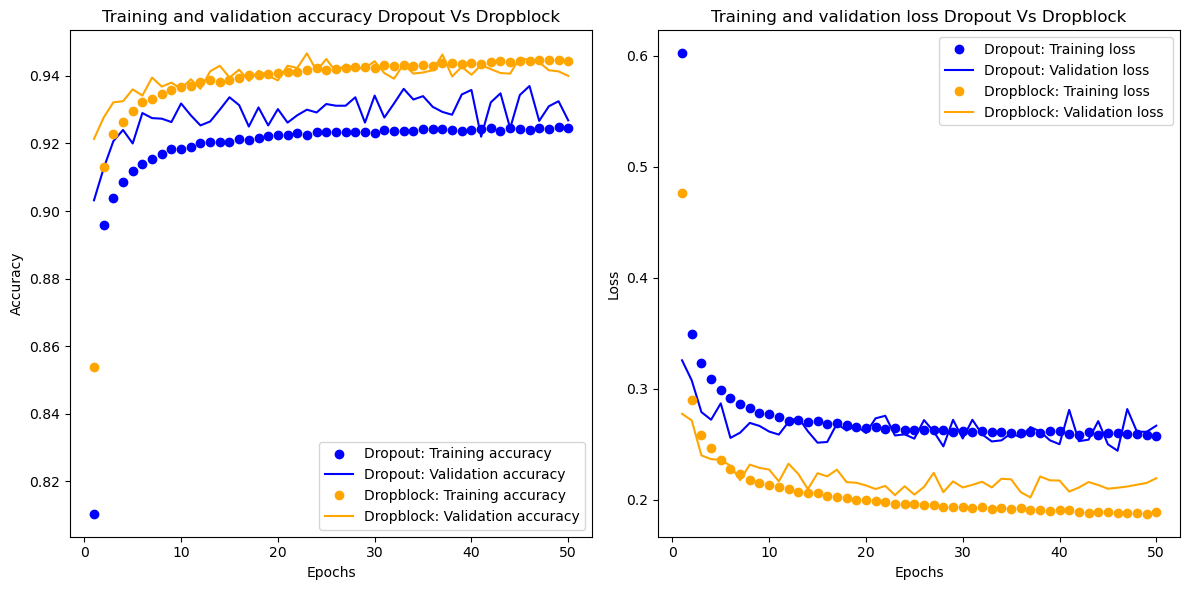

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import plot_accuracy_metric_comparison
import pandas as pd

# Load the model history into a dataframe
pd1 = pd.DataFrame(model_5_relu_model_with_dropout_aug_history.history)

# Load the model history into a dataframe
pd2 = pd.DataFrame(model_6_relu_model_with_dropblock_aug_history.history)

# Plot the comparison Graphs
plot_accuracy_metric_comparison(pd1,'Model 5: Dropout', pd2, 'Model 6: Dropblock',  'Dropout Vs Dropblock')

Dropout and Dropblock training time have increased from the models 3 & 4 results. Indicating that augmentation and forces the model to learn new features increasing the runtime.

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import compare_times

compare_times(model_5_relu_model_with_dropout_aug_time, model_6_relu_model_with_dropblock_aug_time)

Average Epoch      Total Time
Model                                  
Model_1  0:00:25.925109  0:21:36.255451
Model_2  0:00:40.951952  0:34:07.597585

The top-left graph shows an increase in never-activated neurons compared to the last model 3 & 4. Meanwhile, the other graphs indicate fewer near-zero activations and more moderate to strong activations, particularly in layer 3, leading to improved accuracy. 

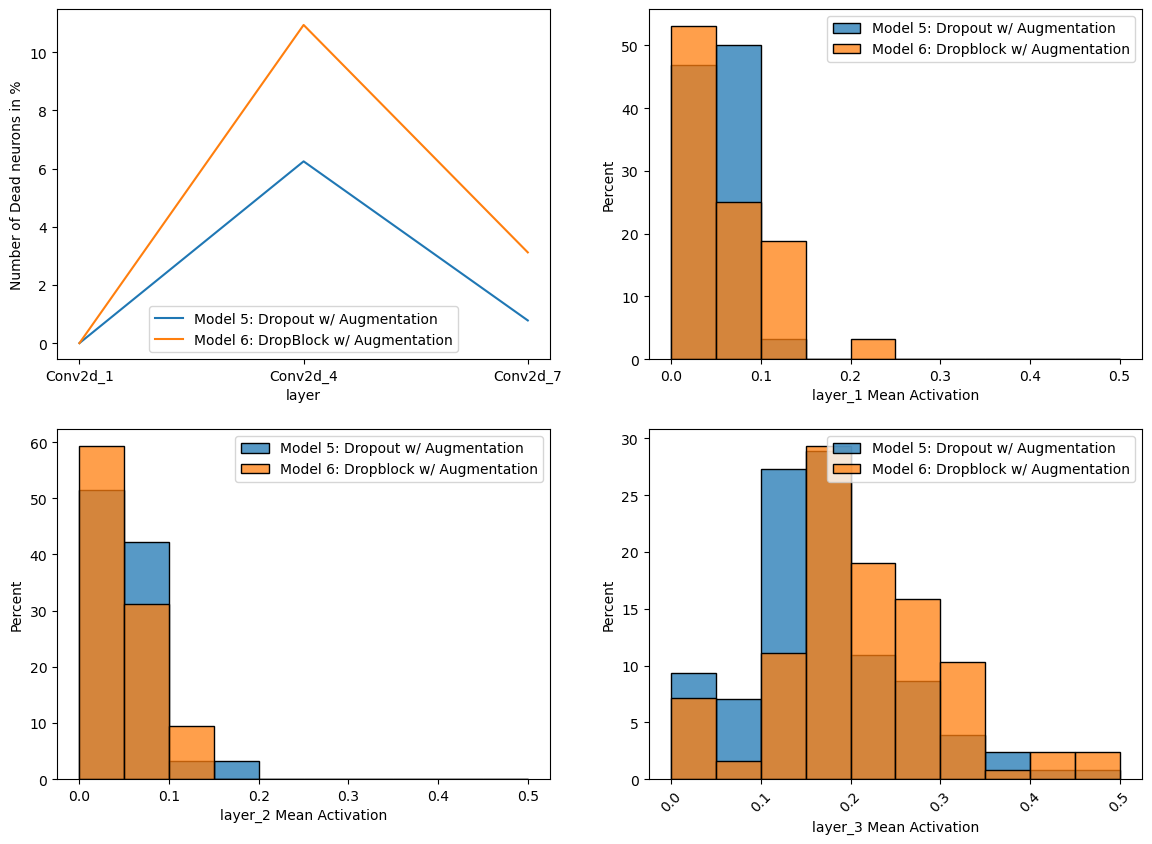

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_neurons_count, display_mean_activations

fig, axes = plt.subplots(2, 2, figsize=(14, 10))



display_neurons_count(model_5_relu_model_with_dropout_aug, test_dataset, ('Model 5: Dropout w/ Augmentation', axes[0,0]) )
display_neurons_count(model_6_relu_model_with_dropblock_aug, test_dataset, ('Model 6: DropBlock w/ Augmentation', axes[0,0]) )

display_mean_activations(model_5_relu_model_with_dropout_aug, test_dataset, '1', ('Model 5: Dropout w/ Augmentation', axes[0,1]) )
display_mean_activations(model_6_relu_model_with_dropblock_aug, test_dataset, '1', ('Model 6: Dropblock w/ Augmentation', axes[0,1]) )

display_mean_activations(model_5_relu_model_with_dropout_aug, test_dataset, '2', ('Model 5: Dropout w/ Augmentation', axes[1,0]) )
display_mean_activations(model_6_relu_model_with_dropblock_aug, test_dataset, '2', ('Model 6: Dropblock w/ Augmentation', axes[1,0]) )

display_mean_activations(model_5_relu_model_with_dropout_aug, test_dataset, '3', ('Model 5: Dropout w/ Augmentation', axes[1,1]) )
display_mean_activations(model_6_relu_model_with_dropblock_aug, test_dataset, '3', ('Model 6: Dropblock w/ Augmentation', axes[1,1]) )



Confusion matrix shows that Dropblock classifies digits better with more red squares on the diagonal. 

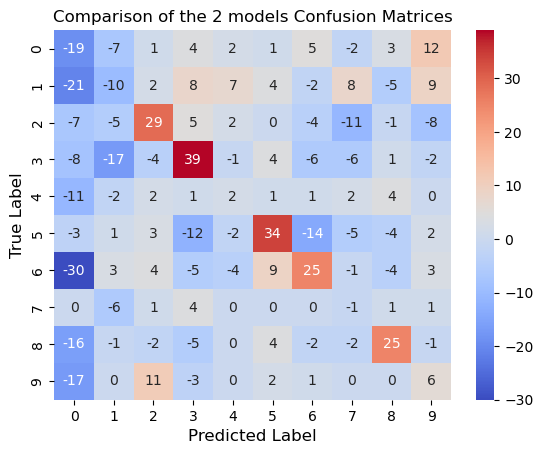

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import model_comparison_confusion_matrix

model_comparison_confusion_matrix(model_6_relu_model_with_dropblock_aug_best,model_5_relu_model_with_dropout_aug_best, test_dataset )

# Batch Normalization

In this section I will implement Batch Normalization on top of the architecture in Model 5 & 6.

## Model 7: Dropout with Batch Normalization

In [ ]:
import keras
from keras import layers

# Define a convolutional neural network model with Dropout, Batch Normalization,
# and hyperparameter tuning for dropout rates
def model_7_relu_w_dropout_aug_batch(hp):

    model = keras.Sequential()
    
    model.add(layers.InputLayer(input_shape=(32, 32, 3)))
    model.add(layers.Dropout(rate=hp.Choice('rate_1', [0.25,0.5,0.75])))

    # First convolutional block with Batch Normalization
    model.add(layers.Conv2D(32, kernel_size=(3, 3), strides=(1,1), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    
    model.add(layers.Dropout(rate=hp.Choice('rate_2', [0.25,0.5,0.75])))

    # Second convolutional block with Batch Normalization
    model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=(1,1), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    
    model.add(layers.Dropout(rate=hp.Choice('rate_3', [0.25,0.5,0.75]))) 

    # Third convolutional block with Batch Normalization
    model.add(layers.Conv2D(128,kernel_size=(3, 3), strides=(1,1), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    
    model.add(layers.Dropout(rate=hp.Choice('rate_4', [0.25,0.5,0.75])))

    model.add(layers.Flatten())

    # Dense fully-connected layer with Batch Normalization
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate=hp.Choice('rate_5', [0.25,0.5,0.75])))

    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
    )
    return model    

Loading the previous saved trail parameters to use with Batch Normalization model

In [ ]:
import keras_tuner

model_3_hyper_v_path = 'saved models/2. model 2 dropout/hyper p/'

tuner_reload = keras_tuner.RandomSearch(
    hypermodel=simple_model_Relu_with_dropout_hyper_p,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    directory=model_3_hyper_v_path,
    project_name="simple_model_Relu_with_dropout_hyper_p",
    overwrite=False,
)

tuner_reload.reload()
trials = tuner_reload.oracle.trials


tuner_reload.results_summary()

Reloading Tuner from saved models/2. model 2 dropout/hyper p/simple_model_Relu_with_dropout_hyper_p\tuner0.json
Results summary
Results in saved models/2. model 2 dropout/hyper p/simple_model_Relu_with_dropout_hyper_p
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 04 summary
Hyperparameters:
rate_1: 0.25
rate_2: 0.5
rate_3: 0.25
rate_4: 0.25
rate_5: 0.25
Score: 0.9225000143051147

Trial 03 summary
Hyperparameters:
rate_1: 0.5
rate_2: 0.25
rate_3: 0.5
rate_4: 0.25
rate_5: 0.5
Score: 0.8933333158493042

Trial 11 summary
Hyperparameters:
rate_1: 0.5
rate_2: 0.25
rate_3: 0.25
rate_4: 0.5
rate_5: 0.75
Score: 0.8820000290870667

Trial 02 summary
Hyperparameters:
rate_1: 0.5
rate_2: 0.25
rate_3: 0.25
rate_4: 0.5
rate_5: 0.5
Score: 0.8784999847412109

Trial 09 summary
Hyperparameters:
rate_1: 0.5
rate_2: 0.5
rate_3: 0.5
rate_4: 0.5
rate_5: 0.25
Score: 0.8654999732971191

Trial 10 summary
Hyperparameters:
rate_1: 0.5
rate_2: 0.25
rate_3: 0.25
rate_4: 0.75
rate_5: 

In [ ]:
# Get the top 5 best models
best_hps = tuner_reload.get_best_hyperparameters(5)

# load the top model configuration
model_7_relu_w_dropout_aug_batch = model_7_relu_w_dropout_aug_batch(best_hps[0])

In [ ]:
# Print a summary of the model
model_7_relu_w_dropout_aug_batch.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_25 (Dropout)        (None, 32, 32, 3)         0         
                                                                 
 conv2d_21 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_39 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 15, 15, 32)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 13, 13, 64)      

In the cell below, I'm setting up the path to save the best model for the model checkpoint return.   Providing gives the fit function two calls back that save the best model and keep track of the training time.   The epoch rate, the class weighted dictionary, and the entire training and validation datasets are used.

In [ ]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)

# create the directory path where the best model will be saved
model_7_relu_w_dropout_aug_batch_path = 'saved models/2. model 2 dropout/batch/'

# Configure the model checkpoint call back and monitor the validation loss
best_model = [tf.keras.callbacks.ModelCheckpoint(
        filepath=model_7_relu_w_dropout_aug_batch_path + "model_7_relu_w_dropout_aug_batch_best.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Record the time the model take to train
model_7_relu_w_dropout_aug_batch_time = TimeHistory()

# Fit the model and record the training history
model_7_relu_w_dropout_aug_batch_history = model_7_relu_w_dropout_aug_batch.fit(
    aug_train_dataset,                                                          # Training data and labels
    validation_data=(val_dataset),                                              # Validation data and labels
    epochs=50,                                                                  # Number of epochs
    class_weight=d_class_weights,                                               # Adding Class Weights
    callbacks=[best_model, model_7_relu_w_dropout_aug_batch_time],              # Callbacks
    verbose=1                                                                   # Verbosity mode (1 for progress bar)
)

Epoch 1/50
4675/4675 [==============================] - 39s 7ms/step - loss: 0.4880 - accuracy: 0.8490 - val_loss: 0.2716 - val_accuracy: 0.9213
Epoch 2/50
4675/4675 [==============================] - 35s 7ms/step - loss: 0.2705 - accuracy: 0.9187 - val_loss: 0.2377 - val_accuracy: 0.9345
Epoch 3/50
4675/4675 [==============================] - 34s 6ms/step - loss: 0.2413 - accuracy: 0.9275 - val_loss: 0.2227 - val_accuracy: 0.9382
Epoch 4/50
4675/4675 [==============================] - 35s 6ms/step - loss: 0.2254 - accuracy: 0.9325 - val_loss: 0.2189 - val_accuracy: 0.9357
Epoch 5/50
4675/4675 [==============================] - 35s 6ms/step - loss: 0.2161 - accuracy: 0.9353 - val_loss: 0.2136 - val_accuracy: 0.9408
Epoch 6/50
4675/4675 [==============================] - 34s 6ms/step - loss: 0.2102 - accuracy: 0.9374 - val_loss: 0.2109 - val_accuracy: 0.9422
Epoch 7/50
4675/4675 [==============================] - 34s 6ms/step - loss: 0.2059 - accuracy: 0.9384 - val_loss: 0.2015 - val_ac

Saving the model information in the below cell

In [ ]:
import importlib
import utils.model_utils
importlib.reload(utils.model_utils)
from utils.model_utils import save_model_data


save_model_data(model_7_relu_w_dropout_aug_batch_path,
               model_7_relu_w_dropout_aug_batch,'model_7_relu_w_dropout_aug_batch',
               model_7_relu_w_dropout_aug_batch_history, 'model_7_relu_w_dropout_aug_batch_history',
               model_7_relu_w_dropout_aug_batch_time, 'model_7_relu_w_dropout_aug_batch_time'  )

I plot model accuracy and loss history in the cell below.

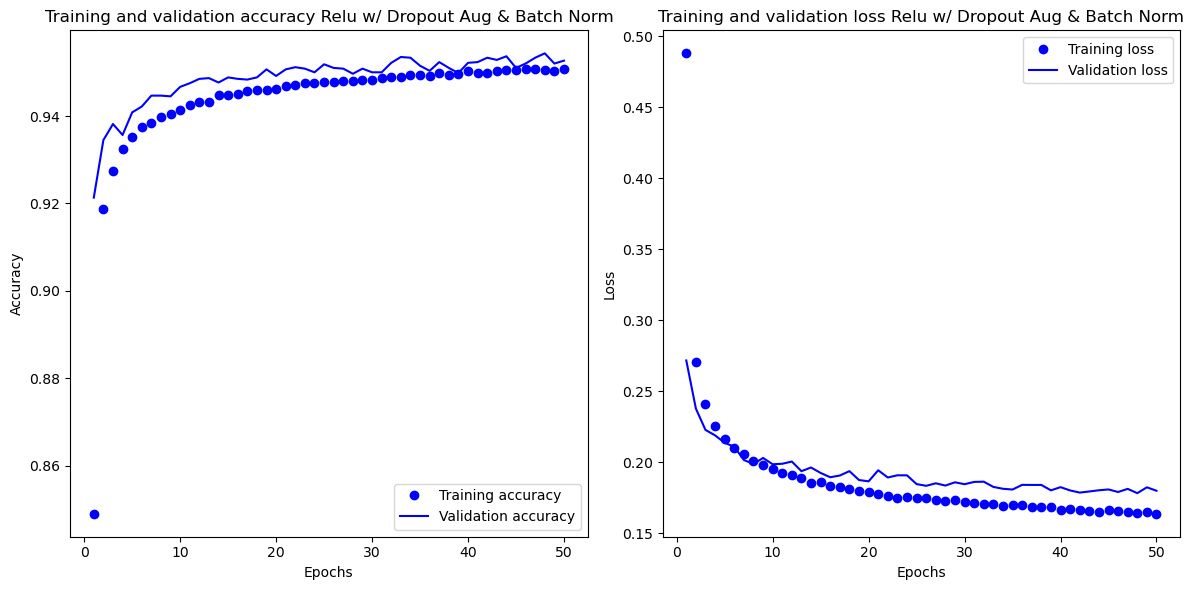

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import display_accuracy_loss

display_accuracy_loss(model_7_relu_w_dropout_aug_batch_history, 'Relu w/ Dropout Aug & Batch Norm' )

Printing the training time history in cell below

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_model_times

display_model_times(model_7_relu_w_dropout_aug_batch_time)

Total Time: 0:29:46.474548 Average Epoch Time: 0:00:35.729491


Load the best performing model that was trained and saved according to validation loss

In [58]:
model_7_relu_w_dropout_aug_batch_path = 'saved models/2. model 2 dropout/batch/'

model_7_relu_w_dropout_aug_batch_best = tf.keras.models.load_model(model_7_relu_w_dropout_aug_batch_path + "model_7_relu_w_dropout_aug_batch_best.keras")

Evaluate the best performing model on the test dataset

In [ ]:
model_7_relu_w_dropout_aug_batch_best.evaluate(test_dataset)

204/204 [==============================] - 1s 3ms/step - loss: 0.1691 - accuracy: 0.9567


[0.16911116242408752, 0.9567071199417114]

Model 7 achieves an accuracy of 95.67%

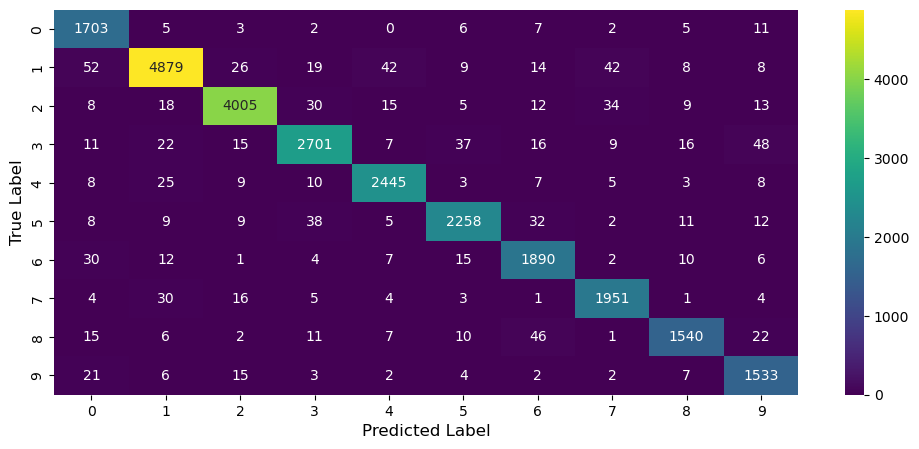

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import generate_confusion_matrix


dropout_aug_cm = generate_confusion_matrix(model_7_relu_w_dropout_aug_batch_best, test_dataset)

## Model 8: Dropblock with Batch Normalization

In [ ]:
# Define a convolutional neural network model with Dropblock, Batch Normalization,
# and hyperparameter tuning for dropout rates

def model_8_relu_w_dropblock_aug_batch(hp):

    model = keras.Sequential()
    
    model.add(layers.InputLayer(input_shape=(32, 32, 3)))
    model.add(DropBlock2D(rate=hp.Choice('rate_1',[0.2, 0.3,0.4]), block_size=hp.Choice('block_size_1', [2, 3, 4] )))

    # First convolutional block with Batch Normalization
    model.add(layers.Conv2D(32, kernel_size=(3, 3), strides=(1,1), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(DropBlock2D(rate=hp.Choice('rate_2',[0.2, 0.3,0.4]), block_size=hp.Choice('block_size_2', [2, 3, 4] )))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    
    
    # Second convolutional block with Batch Normalization
    model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=(1,1), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(DropBlock2D(rate=hp.Choice('rate_3',[0.2, 0.3,0.4]), block_size=hp.Choice('block_size_3', [2, 3, 4] )))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    

    # Third convolutional block with Batch Normalization
    model.add(layers.Conv2D(128,kernel_size=(3, 3), strides=(1,1), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(DropBlock2D(rate=hp.Choice('rate_4',[0.2, 0.3,0.4]), block_size=hp.Choice('block_size_4', [2, 3, 4] )))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    


    model.add(layers.Flatten())
    
    # Dense fully-connected layer with Batch Normalization
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
    )
    return model    

Loading the previous saved trail parameters to use with Batch Normalization model

In [ ]:
import keras_tuner

model_4_hyper_v_path = 'saved models/3. model 3 dropblock/hyper p/'

tuner_reload = keras_tuner.RandomSearch(
    hypermodel=simple_model_Relu_with_dropblock_hyper_p,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    directory=model_4_hyper_v_path,
    project_name="simple_model_Relu_with_dropblock_hyper_p",
    overwrite=False,
)

tuner_reload.reload()
trials = tuner_reload.oracle.trials

tuner_reload.results_summary()

Reloading Tuner from saved models/3. model 3 dropblock/hyper p/simple_model_Relu_with_dropblock_hyper_p\tuner0.json
Results summary
Results in saved models/3. model 3 dropblock/hyper p/simple_model_Relu_with_dropblock_hyper_p
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 09 summary
Hyperparameters:
rate_1: 0.2
block_size_1: 4
rate_2: 0.3
block_size_2: 2
rate_3: 0.2
block_size_3: 4
rate_4: 0.2
block_size_4: 4
Score: 0.9328333139419556

Trial 03 summary
Hyperparameters:
rate_1: 0.2
block_size_1: 4
rate_2: 0.4
block_size_2: 4
rate_3: 0.2
block_size_3: 2
rate_4: 0.4
block_size_4: 2
Score: 0.9281666874885559

Trial 18 summary
Hyperparameters:
rate_1: 0.2
block_size_1: 2
rate_2: 0.2
block_size_2: 2
rate_3: 0.2
block_size_3: 3
rate_4: 0.4
block_size_4: 3
Score: 0.9265000224113464

Trial 10 summary
Hyperparameters:
rate_1: 0.3
block_size_1: 2
rate_2: 0.3
block_size_2: 2
rate_3: 0.3
block_size_3: 4
rate_4: 0.2
block_size_4: 4
Score: 0.925000011920929

Trial 04 su

In [ ]:
# Get the top 5 best models
best_hps = tuner_reload.get_best_hyperparameters(5)

# load the top model configuration
model_8_relu_w_dropblock_aug_batch = model_8_relu_w_dropblock_aug_batch(best_hps[0])

In [ ]:
# Print a summary of the model
model_8_relu_w_dropblock_aug_batch.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 drop_block2d_4 (DropBlock2D  (None, 32, 32, 3)        0         
 )                                                               
                                                                 
 conv2d_15 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 drop_block2d_5 (DropBlock2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                 

In the cell below, I'm setting up the path to save the best model for the model checkpoint return.   Providing gives the fit function two calls back that save the best model and keep track of the training time.   The epoch rate, the class weighted dictionary, and the entire training and validation datasets are used.

In [ ]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)

# create the directory path where the best model will be saved
model_8_relu_w_dropblock_aug_batch_path = 'saved models/3. model 3 dropblock/batch/'

# Configure the model checkpoint call back and monitor the validation loss
best_model = [tf.keras.callbacks.ModelCheckpoint(
        filepath=model_8_relu_w_dropblock_aug_batch_path + "model_8_relu_w_dropblock_aug_batch_best.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Record the time the model take to train
model_8_relu_w_dropblock_aug_batch_time = TimeHistory()

# Fit the model and record the training history
model_8_relu_w_dropblock_aug_batch_history = model_8_relu_w_dropblock_aug_batch.fit(
    aug_train_dataset,                                                              # Training data and labels
    validation_data=(val_dataset),                                                  # Validation data and labels
    epochs=50,                                                                      # Number of epochs
    class_weight=d_class_weights,                                                   # Adding Class Weights
    callbacks=[best_model, model_8_relu_w_dropblock_aug_batch_time],                # Callbacks
    verbose=1                                                                       # Verbosity mode (1 for progress bar)
)

Epoch 1/50
4675/4675 [==============================] - 50s 10ms/step - loss: 0.4330 - accuracy: 0.8660 - val_loss: 0.2834 - val_accuracy: 0.9170
Epoch 2/50
4675/4675 [==============================] - 48s 10ms/step - loss: 0.2485 - accuracy: 0.9251 - val_loss: 0.2389 - val_accuracy: 0.9330
Epoch 3/50
4675/4675 [==============================] - 47s 10ms/step - loss: 0.2182 - accuracy: 0.9343 - val_loss: 0.2291 - val_accuracy: 0.9353
Epoch 4/50
4675/4675 [==============================] - 48s 10ms/step - loss: 0.2028 - accuracy: 0.9390 - val_loss: 0.2169 - val_accuracy: 0.9368
Epoch 5/50
4675/4675 [==============================] - 49s 10ms/step - loss: 0.1919 - accuracy: 0.9422 - val_loss: 0.2040 - val_accuracy: 0.9422
Epoch 6/50
4675/4675 [==============================] - 49s 10ms/step - loss: 0.1838 - accuracy: 0.9448 - val_loss: 0.1975 - val_accuracy: 0.9462
Epoch 7/50
4675/4675 [==============================] - 48s 10ms/step - loss: 0.1787 - accuracy: 0.9465 - val_loss: 0.1937 -

Saving the model information in the below cell

In [ ]:
import importlib
import utils.model_utils
importlib.reload(utils.model_utils)
from utils.model_utils import save_model_data


save_model_data(model_8_relu_w_dropblock_aug_batch_path,
               model_8_relu_w_dropblock_aug_batch,'model_8_relu_w_dropblock_aug_batch',
               model_8_relu_w_dropblock_aug_batch_history, 'model_8_relu_w_dropblock_aug_batch_history',
               model_8_relu_w_dropblock_aug_batch_time, 'model_8_relu_w_dropblock_aug_batch_time'  )

I plot model accuracy and loss history in the cell below.

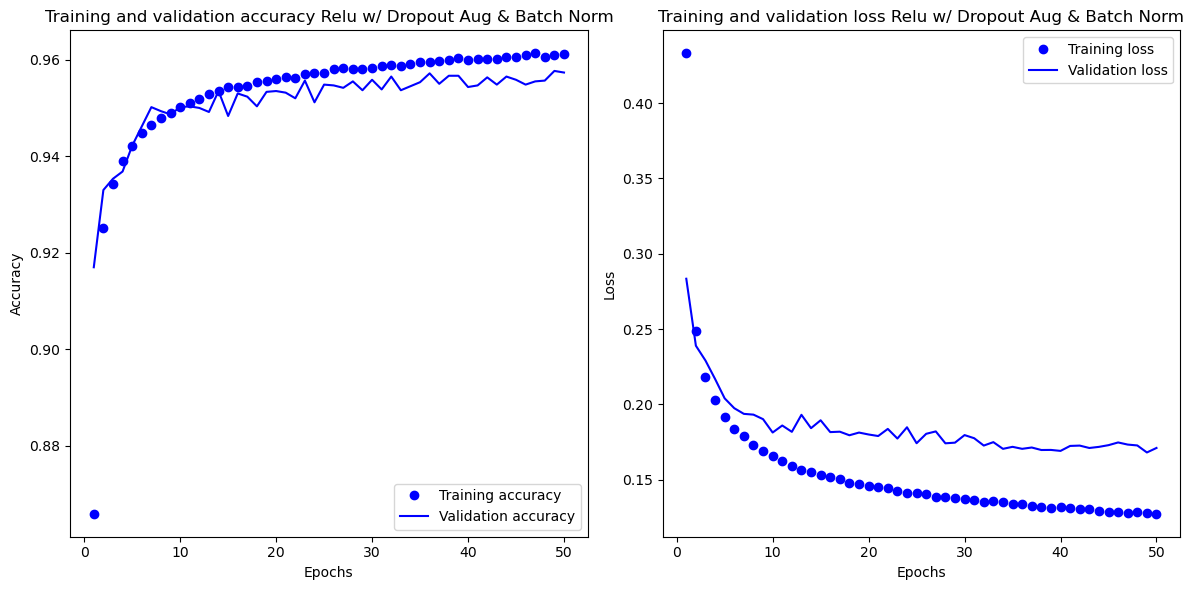

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import display_accuracy_loss

display_accuracy_loss(model_8_relu_w_dropblock_aug_batch_history, 'Relu w/ Dropout Aug & Batch Norm' )

Printing the training time history in cell below

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_model_times

display_model_times(model_8_relu_w_dropblock_aug_batch_time)

Total Time: 0:40:00.287273 Average Epoch Time: 0:00:48.005745


Load the best performing model that was trained and saved according to validation loss

In [59]:
model_8_relu_w_dropblock_aug_batch_path = 'saved models/3. model 3 dropblock/batch/'

model_8_relu_w_dropblock_aug_batch_best = tf.keras.models.load_model(model_8_relu_w_dropblock_aug_batch_path + "model_8_relu_w_dropblock_aug_batch_best.keras" , {"DropBlock2D": DropBlock2D})

Evaluate the best performing model on the test dataset

In [ ]:
model_8_relu_w_dropblock_aug_batch_best.evaluate(test_dataset)

204/204 [==============================] - 1s 4ms/step - loss: 0.1588 - accuracy: 0.9605


[0.15876799821853638, 0.9605485796928406]

Model 7 achieves an accuracy of 96.05%

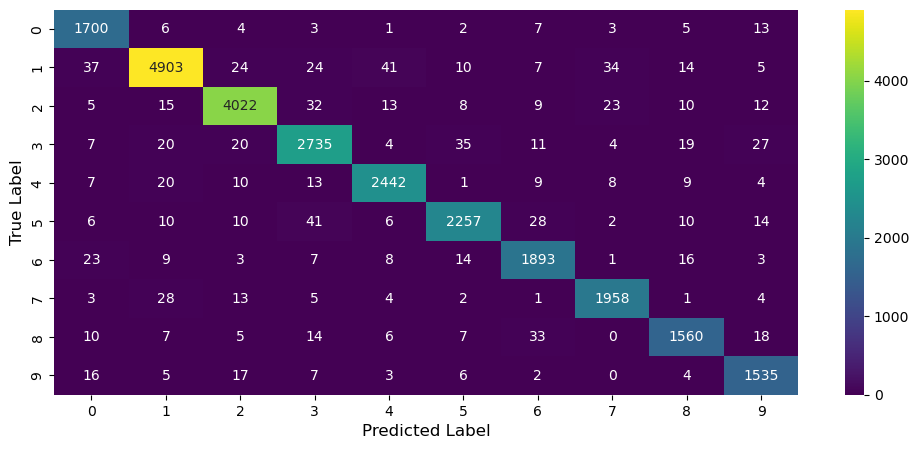

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import generate_confusion_matrix


dropout_aug_cm = generate_confusion_matrix(model_8_relu_w_dropblock_aug_batch_best, test_dataset)

## Model 7 & 8: Comparison

Batch Normalisation improves training and validation accuracy and reduces loss compared to the previous models.Also , it reduced noise, resulting in smoother validation loss lines. 

Below I am reloading the History and Time data to plot the the curves

In [ ]:
model_7_relu_w_dropout_aug_batch_path = 'saved models/2. model 2 dropout/batch/'

# Time
model_7_relu_w_dropout_aug_batch_time = np.load(model_7_relu_w_dropout_aug_batch_path + 'model_7_relu_w_dropout_aug_batch_time.npy', allow_pickle=True)

# History
model_7_relu_w_dropout_aug_batch_history = np.load(model_7_relu_w_dropout_aug_batch_path + 'model_7_relu_w_dropout_aug_batch_history.npy', allow_pickle=True).item()

Below, I am plotting the curves of Model 7: Dropout & Model 8: Dropblock

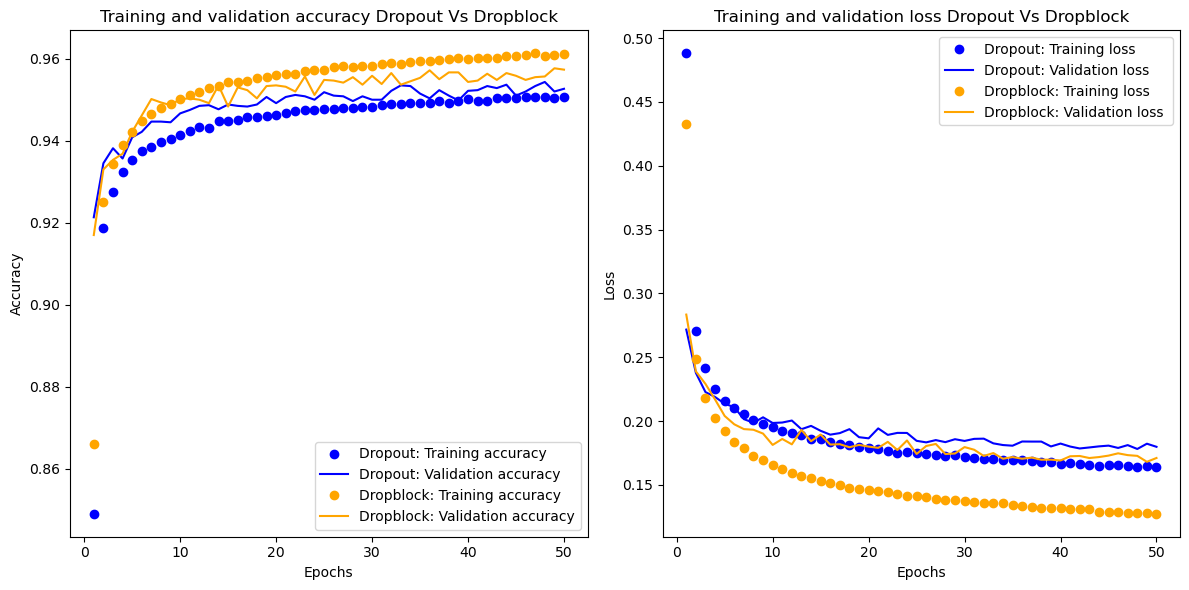

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import plot_accuracy_metric_comparison

import pandas as pd

# Load the model history into a dataframe
pd1 = pd.DataFrame(model_7_relu_w_dropout_aug_batch_history.history)

# Load the model history into a dataframe
pd2 = pd.DataFrame(model_8_relu_w_dropblock_aug_batch_history.history)

# Plot the comparison Graphs
plot_accuracy_metric_comparison(pd1,'Model 7:Dropout', pd2, 'Model 8: Dropblock',  'Dropout Vs Dropblock')

Batch Normalization has added some overhead with the increased training time compared with Model 5 & 6

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import compare_times

compare_times(model_7_relu_w_dropout_aug_batch_time, model_8_relu_w_dropblock_aug_batch_time, reload=True)

Average Epoch      Total Time
Model                                  
Model_1  0:00:35.729491  0:29:46.474548
Model_2  0:00:48.005745  0:40:00.287273

Batch Normalization eliminated dead neurones from both models.  Which may have improved test accuracy. Layer_1 has a small group of neurones that fire similarly, but over a much larger area.  Layers 2 and 3 go from almost 0 to a wider spread of strongly active neurones. This suggests that the network pulls out more detailed or strong features, making the new model more accurate than the old one.

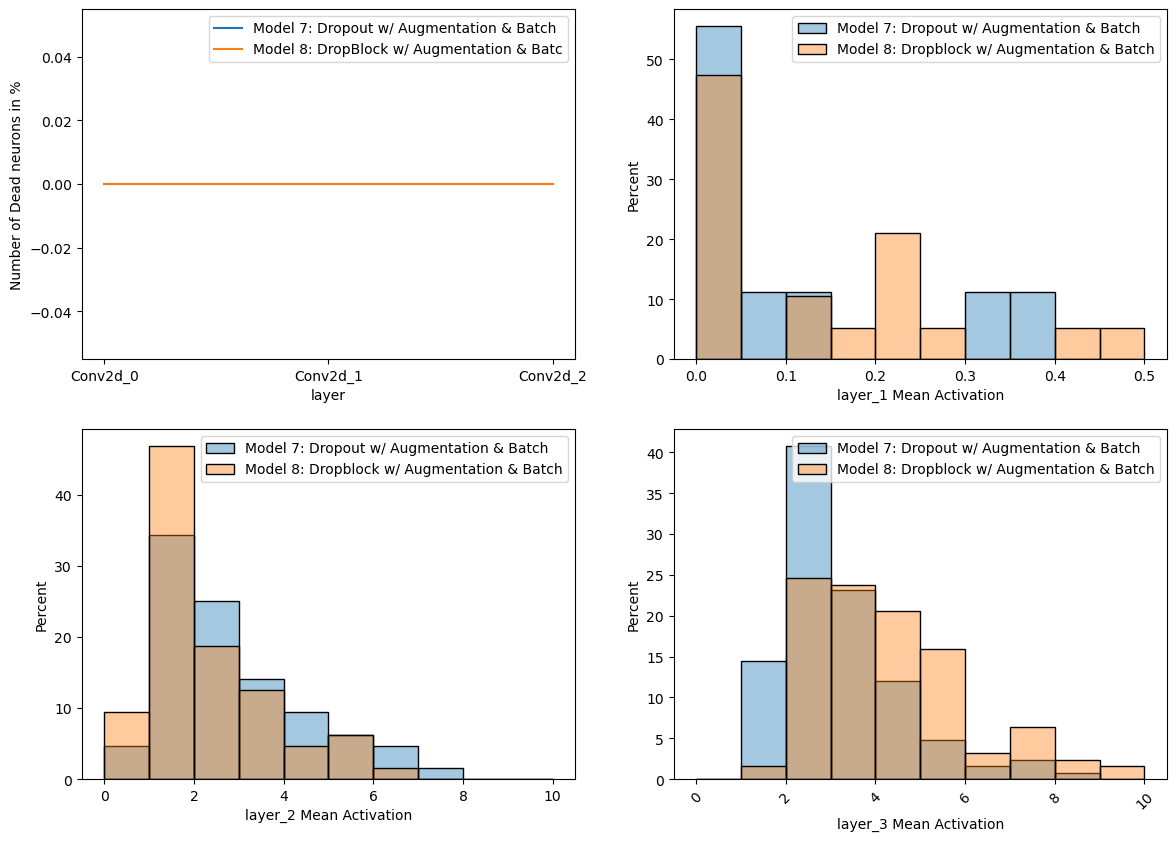

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_neurons_count, display_mean_activations

fig, axes = plt.subplots(2, 2, figsize=(14, 10))



display_neurons_count(model_7_relu_w_dropout_aug_batch_best, test_dataset, ('Model 7: Dropout w/ Augmentation & Batch', axes[0,0]) )
display_neurons_count(model_8_relu_w_dropblock_aug_batch_best, test_dataset, ('Model 8: DropBlock w/ Augmentation & Batc', axes[0,0]) )

display_mean_activations(model_7_relu_w_dropout_aug_batch_best, test_dataset, '1', 0, 0.5, 11, ('Model 7: Dropout w/ Augmentation & Batch', axes[0,1]) )
display_mean_activations(model_8_relu_w_dropblock_aug_batch_best, test_dataset, '1',0, 0.5, 11, ('Model 8: Dropblock w/ Augmentation & Batch', axes[0,1]) )

display_mean_activations(model_7_relu_w_dropout_aug_batch_best, test_dataset, '2', 0, 10, 11, ('Model 7: Dropout w/ Augmentation & Batch', axes[1,0]) )
display_mean_activations(model_8_relu_w_dropblock_aug_batch_best, test_dataset, '2', 0, 10, 11, ('Model 8: Dropblock w/ Augmentation & Batch', axes[1,0]) )

display_mean_activations(model_7_relu_w_dropout_aug_batch_best, test_dataset, '3', 0, 10, 11, ('Model 7: Dropout w/ Augmentation & Batch', axes[1,1]) )
display_mean_activations(model_8_relu_w_dropblock_aug_batch_best, test_dataset, '3', 0, 10, 11,  ('Model 8: Dropblock w/ Augmentation & Batch', axes[1,1]) )



Dropblock performs very well on 1,2,3, & 8.  The majority of images are 1,2,3, however 8 is more uncommon (Figure 16).

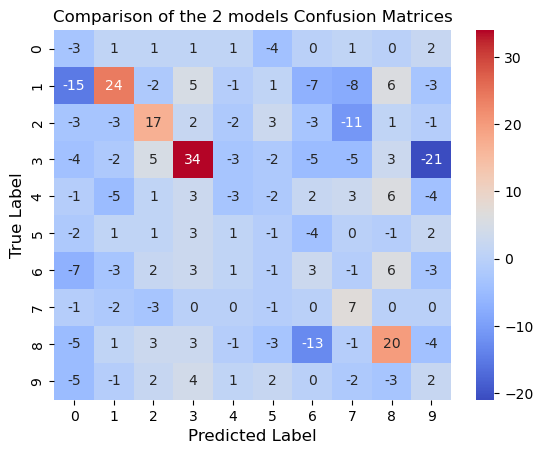

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import model_comparison_confusion_matrix

model_comparison_confusion_matrix(model_8_relu_w_dropblock_aug_batch_best, model_7_relu_w_dropout_aug_batch_best, test_dataset )

# Bottleneck

## Model 9: Dropout Bottleneck

In [ ]:
import keras
from keras import layers
from keras.constraints import MaxNorm
from keras.optimizers import Adam
from keras import regularizers


# Define a CNN model with Dropout, Batch Normalization, and a bottleneck Dense layer
# Includes hyperparameter tuning for the bottleneck and final dense layer sizes
def model_9_relu_w_dropout_aug_batch_bottleneck(hp):
    model = keras.Sequential()
    
    model.add(layers.InputLayer(input_shape=(32, 32, 3)))
    model.add(layers.Dropout(rate=0.25))

    model.add(layers.Conv2D(32, kernel_size=(3, 3), strides=(1,1),
                             activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    
    model.add(layers.Dropout(rate=0.5))

    model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=(1,1),
                             activation='relu'))    
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    
    model.add(layers.Dropout(rate=0.25))
     

    model.add(layers.Conv2D(128,kernel_size=(3, 3), strides=(1,1),  
                             activation='relu'))    
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    
    model.add(layers.Dropout(rate=0.25))

    model.add(layers.Flatten())

    # Bottleneck layer with tunable size (small Dense layer before larger one)
    model.add(layers.Dense(units=hp.Choice('bottleneck_1', [16,32,64]),  
                           activation='relu'))
     
    # Fully connected Dense layer with tunable number of neurons
    model.add(layers.Dense(units=hp.Choice('Dense_neurons', [256,512,1024]),
                           activation='relu'))               
    model.add(layers.BatchNormalization())    
    model.add(layers.Dropout(rate=0.25))

    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']) 

    return model   

Below, I am checking the model compiles correctly with the Keras tuner hyperparameters selection

In [ ]:
import keras_tuner

# Checking the Model compiles
model_9_relu_w_dropout_aug_batch_bottleneck(keras_tuner.HyperParameters())

Below, I am setting up the search parameters for the hyperparameter search trials.

In [ ]:
model_9_bottleneck_path = 'saved models/2. model 2 dropout/bottleneck/hyper p/'

tuner = keras_tuner.RandomSearch(
    hypermodel=model_9_relu_w_dropout_aug_batch_bottleneck,
    objective="val_accuracy",
    max_trials=9,
    executions_per_trial=1,
    overwrite=True,
    directory=model_9_bottleneck_path,
    project_name="model_9_bottleneck_hyper_p",
)
tuner.search_space_summary()


Search space summary
Default search space size: 2
bottleneck_1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
Dense_neurons (Choice)
{'default': 256, 'conditions': [], 'values': [256, 512, 1024], 'ordered': True}


Below, I use EarlyStopping callback below to save time.  If validation accuracy does not improve after 5 epochs, the trial will end and move on.

 I'm also using the hyper_p_dataset, a subset of the complete dataset, and setting the trial epoch to 25.  This speeds up search and lets the model train for a number of epochs.

In [ ]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)

# Setup Earlystopping to stop the train when the validation loss doesn't improve
early_stop = [tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5)
]

# Configure search Parameters
tuner.search(
    aug_train_hyper_p_dataset,                      # Training data and labels
    validation_data=(val_dataset),                  # Validation data and labels
    epochs=25,                                      # Number of epochs
    class_weight=d_class_weights,                   # Adding Class Weights
    callbacks=[early_stop],                         # Callbacks
    verbose=1                                       # Verbosity mode (1 for progress bar)
)

Trial 9 Complete [00h 05m 25s]
val_accuracy: 0.940500020980835

Best val_accuracy So Far: 0.9413333535194397
Total elapsed time: 00h 47m 45s


Below cell, I am displaying the best model architecture found.

In [ ]:
# Get Top model configuration
models = tuner.get_best_models(num_models=1)
# Load top model configuration
best_model = models[0]
# Print summary of top model
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        1

Below Cell, I am just displaying all the trail results.

In [ ]:
tuner.results_summary()

Results summary
Results in saved models/2. model 2 dropout/bottleneck/hyper p/model_9_bottleneck_hyper_p
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
bottleneck_1: 64
Dense_neurons: 1024
Score: 0.9413333535194397

Trial 7 summary
Hyperparameters:
bottleneck_1: 32
Dense_neurons: 512
Score: 0.9413333535194397

Trial 5 summary
Hyperparameters:
bottleneck_1: 64
Dense_neurons: 256
Score: 0.9411666393280029

Trial 6 summary
Hyperparameters:
bottleneck_1: 64
Dense_neurons: 512
Score: 0.940666675567627

Trial 8 summary
Hyperparameters:
bottleneck_1: 32
Dense_neurons: 256
Score: 0.940500020980835

Trial 0 summary
Hyperparameters:
bottleneck_1: 16
Dense_neurons: 1024
Score: 0.937166690826416

Trial 1 summary
Hyperparameters:
bottleneck_1: 32
Dense_neurons: 1024
Score: 0.937166690826416

Trial 2 summary
Hyperparameters:
bottleneck_1: 16
Dense_neurons: 512
Score: 0.9351666569709778

Trial 3 summary
Hyperparameters:
bottleneck_1: 16
Dense_

The top 5 search hyperparameters are loaded into a variable in the cell below.  I select the top congifuration and load the model with these values into a new variable.  The model will then be run on the entire training set.

In [ ]:
# Select the Top 5 performing hyperparameters configurations
best_hps = tuner.get_best_hyperparameters(5)

# Load a new model with the Top configuration
model_9_bottleneck = model_9_relu_w_dropout_aug_batch_bottleneck(best_hps[0])

I am setting up the path to save the top-performing model for the model checkpoint callback in the cell below.  Providing the fit function two calls back that save the best model and record the training time.  The full training dataset and the validation set are used, along with the epoch rate and the class weighted dictionary.

In [ ]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)

# Configure the path to save the model information
model_9_bottleneck_path = 'saved models/2. model 2 dropout/bottleneck/'

# Compile the model
model_9_bottleneck.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
    )

# Call Modelcheckpoint to save the best model with the validation loss
best_model = [tf.keras.callbacks.ModelCheckpoint(
        filepath=model_9_bottleneck_path  + "model_9_bottleneck_best.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Record the training time of the model
model_9_bottleneck_time = TimeHistory()

# Save model History and fit the model
model_9_bottleneck_history = model_9_bottleneck.fit(
    aug_train_dataset,                                          # Training data and labels
    validation_data=(val_dataset),                              # Validation data and labels
    epochs=50,                                                  # Number of epochs
    class_weight=d_class_weights,                               # Adding Class Weights
    callbacks=[best_model, model_9_bottleneck_time],            # Callbacks
    verbose=1                                                   # Verbosity mode (1 for progress bar)
)

Epoch 1/50
4675/4675 [==============================] - 41s 7ms/step - loss: 0.5254 - accuracy: 0.8362 - val_loss: 0.2970 - val_accuracy: 0.9122
Epoch 2/50
4675/4675 [==============================] - 38s 7ms/step - loss: 0.2710 - accuracy: 0.9185 - val_loss: 0.2583 - val_accuracy: 0.9285
Epoch 3/50
4675/4675 [==============================] - 35s 7ms/step - loss: 0.2375 - accuracy: 0.9287 - val_loss: 0.2409 - val_accuracy: 0.9317
Epoch 4/50
4675/4675 [==============================] - 36s 7ms/step - loss: 0.2199 - accuracy: 0.9340 - val_loss: 0.2211 - val_accuracy: 0.9368
Epoch 5/50
4675/4675 [==============================] - 36s 7ms/step - loss: 0.2098 - accuracy: 0.9366 - val_loss: 0.2216 - val_accuracy: 0.9380
Epoch 6/50
4675/4675 [==============================] - 36s 7ms/step - loss: 0.2019 - accuracy: 0.9394 - val_loss: 0.2046 - val_accuracy: 0.9428
Epoch 7/50
4675/4675 [==============================] - 35s 7ms/step - loss: 0.1954 - accuracy: 0.9416 - val_loss: 0.2081 - val_ac

Saving the model information in the below cell

In [ ]:
import importlib
import utils.model_utils
importlib.reload(utils.model_utils)
from utils.model_utils import save_model_data

# Configure the path to save the model information
model_9_bottleneck_path = 'saved models/2. model 2 dropout/bottleneck/'

# Save model, model history and training time information
save_model_data(model_9_bottleneck_path ,
               model_9_bottleneck,'model_9_bottleneck',
               model_9_bottleneck_history, 'model_9_bottleneck_history',
               model_9_bottleneck_time, 'model_9_bottleneck_time'  )

I plot model accuracy and loss history in the cell below.

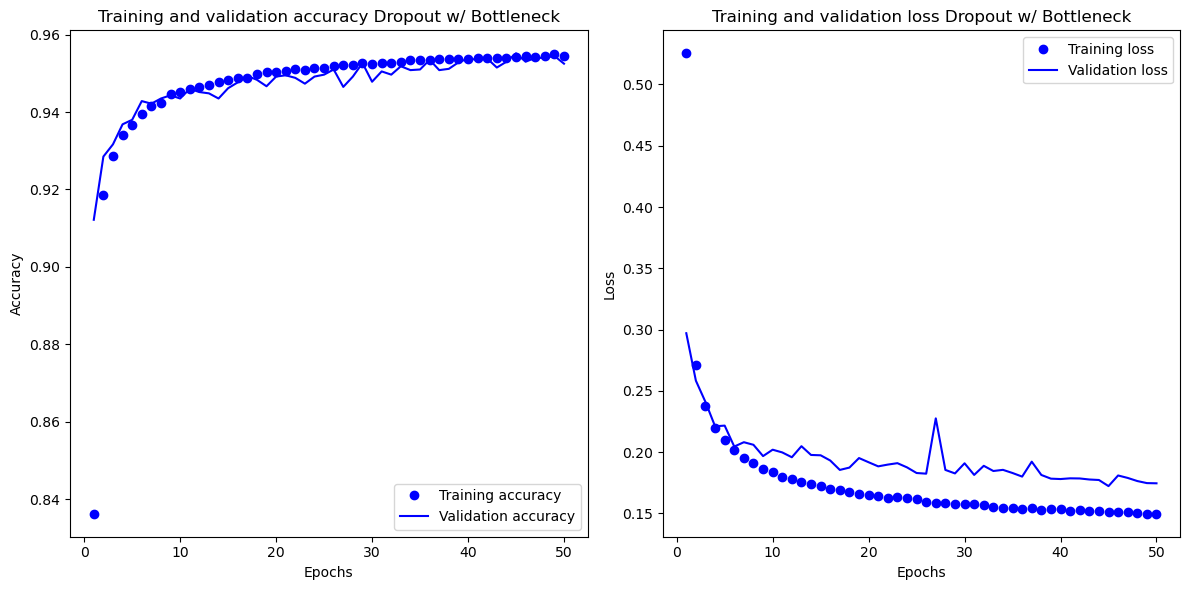

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import display_accuracy_loss

# Plot Training and validation Accuracy and loss
display_accuracy_loss(model_9_bottleneck_history, 'Dropout w/ Bottleneck' )

Printing the training time history in cell below

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_model_times

display_model_times(model_9_bottleneck_time)

Total Time: 0:29:49.864135 Average Epoch Time: 0:00:35.797283


Load the best performing model that was trained and saved according to validation loss

In [ ]:
# Configure the path to the saved model information
model_9_bottleneck_path = 'saved models/2. model 2 dropout/bottleneck/'

# Load the best model saved during training based on validation loss
model_9_bottleneck_best = tf.keras.models.load_model(model_9_bottleneck_path  + "model_9_bottleneck_best.keras")

Evaluate the best performing model on the test dataset

In [ ]:
model_9_bottleneck_best.evaluate(test_dataset)

204/204 [==============================] - 1s 4ms/step - loss: 0.1718 - accuracy: 0.9556


[0.17178209125995636, 0.9556315541267395]

Model 9 achieves an accuracy of 95.59%

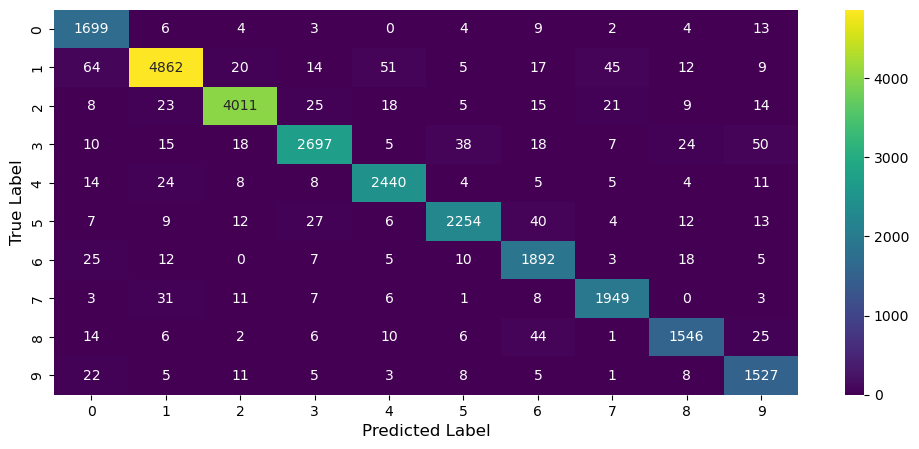

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import generate_confusion_matrix


dropout_aug_cm = generate_confusion_matrix(model_9_bottleneck_best, test_dataset)

## Model 10: Dropblock bottleneck

In [ ]:
import keras
from keras import layers
from keras.constraints import MaxNorm
from keras.optimizers import Adam

import importlib
import utils.DropBlock
importlib.reload(utils.DropBlock)
from utils.DropBlock import DropBlock2D
from keras import regularizers

# Define a CNN model with Dropblock, Batch Normalization, and a bottleneck Dense layer
# Includes hyperparameter tuning for the bottleneck and final dense layer sizes
def model_10_relu_w_dropblock_aug_batch_bottleneck(hp):

    model = keras.Sequential()
    
    model.add(layers.InputLayer(input_shape=(32, 32, 3)))
    model.add(DropBlock2D(rate=0.2, block_size=4))

    model.add(layers.Conv2D(32, kernel_size=(3, 3), strides=(1,1),
                            activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(DropBlock2D(rate=0.3, block_size=2))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    
    

    model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=(1,1),
                            activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(DropBlock2D(rate=0.2, block_size=4))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    


    model.add(layers.Conv2D(128,kernel_size=(3, 3), strides=(1,1),
                            activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(DropBlock2D(rate=0.2, block_size=4))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    


    model.add(layers.Flatten())

    # Bottleneck layer with tunable size (small Dense layer before larger one)
    model.add(layers.Dense(units=hp.Choice('bottleneck_1', [16,32,64]),
                           activation='relu'))

    # Fully connected Dense layer with tunable number of neurons
    model.add(layers.Dense(units=hp.Choice('Dense_neurons', [256,512,1024]),   
                           activation='relu'))
    model.add(layers.BatchNormalization())


    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
    )
    return model    

Below, I am checking the model compiles correctly with the Keras tuner hyperparameters selection

In [ ]:
import keras_tuner

# Checking the Model compiles
model_10_relu_w_dropblock_aug_batch_bottleneck(keras_tuner.HyperParameters())

Below, I am setting up the search parameters for the hyperparameter search trials.

In [ ]:
model_10_bottleneck_path = 'saved models/3. Model 3 DropBlock/bottleneck/hyper p/'

tuner = keras_tuner.RandomSearch(
    hypermodel=model_10_relu_w_dropblock_aug_batch_bottleneck,
    objective="val_accuracy",
    max_trials=9,
    executions_per_trial=1,
    overwrite=True,
    directory=model_10_bottleneck_path,
    project_name="model_10_bottleneck_hyper_p",
)
tuner.search_space_summary()


Search space summary
Default search space size: 2
bottleneck_1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
Dense_neurons (Choice)
{'default': 256, 'conditions': [], 'values': [256, 512, 1024], 'ordered': True}


Below, I use EarlyStopping callback below to save time.  If validation accuracy does not improve after 5 epochs, the trial will end and move on.

 I'm also using the hyper_p_dataset, a subset of the complete dataset, and setting the trial epoch to 25.  This speeds up search and lets the model train for a number of epochs.

In [ ]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)

# Setup Earlystopping to stop the train when the validation loss doesn't improve
early_stop = [tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5)
]

# Configure search Parameters
tuner.search(
    aug_train_hyper_p_dataset,                      # Training data and labels
    validation_data=(val_dataset),                  # Validation data and labels
    epochs=25,                                      # Number of epochs
    class_weight=d_class_weights,                   # Adding Class Weights
    callbacks=[early_stop],                         # Callbacks
    verbose=1                                       # Verbosity mode (1 for progress bar)
)

Trial 9 Complete [00h 07m 22s]
val_accuracy: 0.9390000104904175

Best val_accuracy So Far: 0.9461666941642761
Total elapsed time: 01h 06m 39s


Below cell, I am displaying the best model architecture found.

In [ ]:
# Get Top model configuration
models = tuner.get_best_models(num_models=1)
# Load top model configuration
best_model = models[0]
# Print summary of top model
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 drop_block2d (DropBlock2D)  (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 drop_block2d_1 (DropBlock2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                        

Below Cell, I am just displaying all the trail results.

In [ ]:
tuner.results_summary()

Results summary
Results in saved models/3. Model 3 DropBlock/bottleneck/hyper p/model_10_bottleneck_hyper_p
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 6 summary
Hyperparameters:
bottleneck_1: 64
Dense_neurons: 512
Score: 0.9461666941642761

Trial 3 summary
Hyperparameters:
bottleneck_1: 64
Dense_neurons: 256
Score: 0.9434999823570251

Trial 4 summary
Hyperparameters:
bottleneck_1: 32
Dense_neurons: 512
Score: 0.9434999823570251

Trial 1 summary
Hyperparameters:
bottleneck_1: 64
Dense_neurons: 1024
Score: 0.9418333172798157

Trial 5 summary
Hyperparameters:
bottleneck_1: 32
Dense_neurons: 1024
Score: 0.940500020980835

Trial 2 summary
Hyperparameters:
bottleneck_1: 16
Dense_neurons: 1024
Score: 0.9396666884422302

Trial 8 summary
Hyperparameters:
bottleneck_1: 16
Dense_neurons: 512
Score: 0.9390000104904175

Trial 0 summary
Hyperparameters:
bottleneck_1: 16
Dense_neurons: 256
Score: 0.9388333559036255

Trial 7 summary
Hyperparameters:
bottleneck_1: 32


The top 5 search hyperparameters are loaded into a variable in the cell below.  I select the top congifuration and load the model with these values into a new variable.  The model will then be run on the entire training set.

In [ ]:
best_hps = tuner.get_best_hyperparameters(5)

model_10_bottleneck = model_10_relu_w_dropblock_aug_batch_bottleneck(best_hps[0])

I am setting up the path to save the top-performing model for the model checkpoint callback in the cell below.  Providing the fit function two calls back that save the best model and record the training time.  The full training dataset and the validation set are used, along with the epoch rate and the class weighted dictionary.

In [ ]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)

# Compile the model
model_10_bottleneck.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
    )

# Configure the path to save the model information
model_10_bottleneck_path = 'saved models/3. Model 3 DropBlock/bottleneck/'

# Call Modelcheckpoint to save the best model with the validation loss
best_model = [tf.keras.callbacks.ModelCheckpoint(
        filepath=model_10_bottleneck_path  + "model_10_bottleneck_best.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Record the training time of the model
model_10_bottleneck_time = TimeHistory()

# Save model History and fit the model
model_10_bottleneck_history = model_10_bottleneck.fit(
    aug_train_dataset,                                          # Training data and labels
    validation_data=(val_dataset),                              # Validation data and labels
    epochs=50,                                                  # Number of epochs
    class_weight=d_class_weights,                               # Adding Class Weights
    callbacks=[best_model, model_10_bottleneck_time],            # Callbacks
    verbose=1                                                   # Verbosity mode (1 for progress bar)
)

Epoch 1/50
4675/4675 [==============================] - 53s 10ms/step - loss: 0.4736 - accuracy: 0.8517 - val_loss: 0.2893 - val_accuracy: 0.9177
Epoch 2/50
4675/4675 [==============================] - 50s 10ms/step - loss: 0.2638 - accuracy: 0.9203 - val_loss: 0.2434 - val_accuracy: 0.9273
Epoch 3/50
4675/4675 [==============================] - 50s 10ms/step - loss: 0.2289 - accuracy: 0.9308 - val_loss: 0.2230 - val_accuracy: 0.9365
Epoch 4/50
4675/4675 [==============================] - 50s 10ms/step - loss: 0.2120 - accuracy: 0.9360 - val_loss: 0.2149 - val_accuracy: 0.9382
Epoch 5/50
4675/4675 [==============================] - 50s 10ms/step - loss: 0.1999 - accuracy: 0.9398 - val_loss: 0.2052 - val_accuracy: 0.9425
Epoch 6/50
4675/4675 [==============================] - 50s 10ms/step - loss: 0.1915 - accuracy: 0.9423 - val_loss: 0.2031 - val_accuracy: 0.9420
Epoch 7/50
4675/4675 [==============================] - 50s 10ms/step - loss: 0.1852 - accuracy: 0.9443 - val_loss: 0.1969 -

Saving the model information in the below cell

In [ ]:
import importlib
import utils.model_utils
importlib.reload(utils.model_utils)
from utils.model_utils import save_model_data

# Configure the path to save the model information
model_10_bottleneck_path = 'saved models/3. Model 3 DropBlock/bottleneck/'

save_model_data(model_10_bottleneck_path ,
               model_10_bottleneck,'model_10_bottleneck',
               model_10_bottleneck_history, 'model_10_bottleneck_history',
               model_10_bottleneck_time, 'model_10_bottleneck_time'  )

I plot model accuracy and loss history in the cell below.

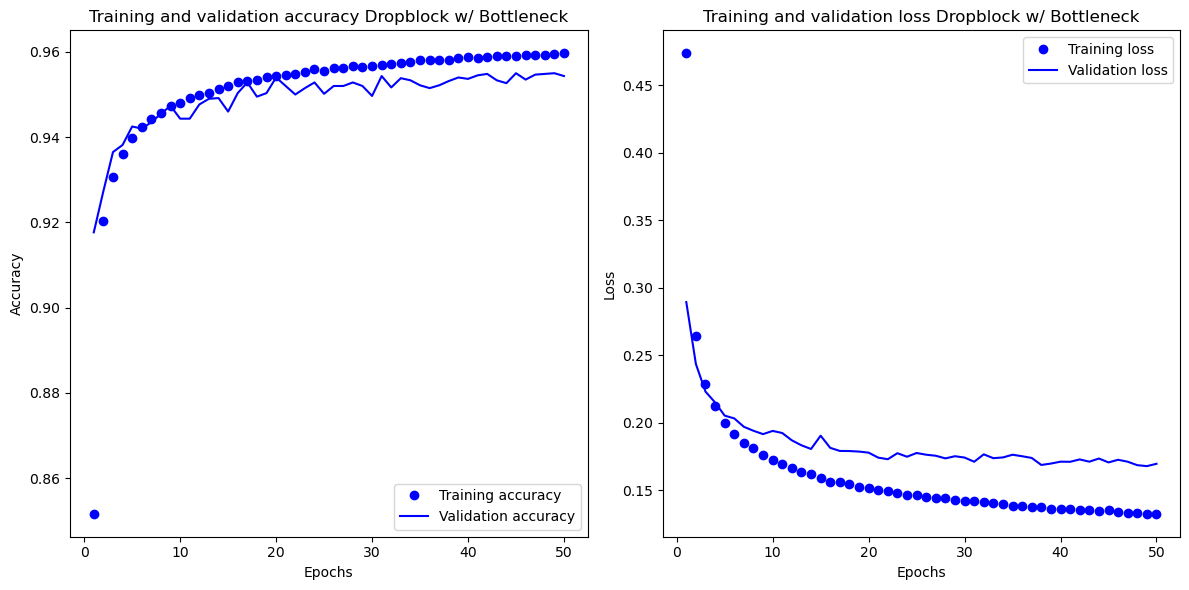

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import display_accuracy_loss

display_accuracy_loss(model_10_bottleneck_history, 'Dropblock w/ Bottleneck' )

Printing the training time history in cell below

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_model_times

display_model_times(model_10_bottleneck_time)

Total Time: 0:42:29.964416 Average Epoch Time: 0:00:50.999288


Load the best performing model that was trained and saved according to validation loss

In [61]:
model_10_bottleneck_path = 'saved models/3. Model 3 DropBlock/bottleneck/'

model_10_bottleneck_best = tf.keras.models.load_model(model_10_bottleneck_path  + "model_10_bottleneck_best.keras" , {"DropBlock2D": DropBlock2D})

Evaluate the best performing model on the test dataset

In [ ]:
model_10_bottleneck_best.evaluate(test_dataset)

204/204 [==============================] - 1s 5ms/step - loss: 0.1574 - accuracy: 0.9588


[0.15736524760723114, 0.9587814807891846]

Model 10 achieves an accuracy of 95.88%

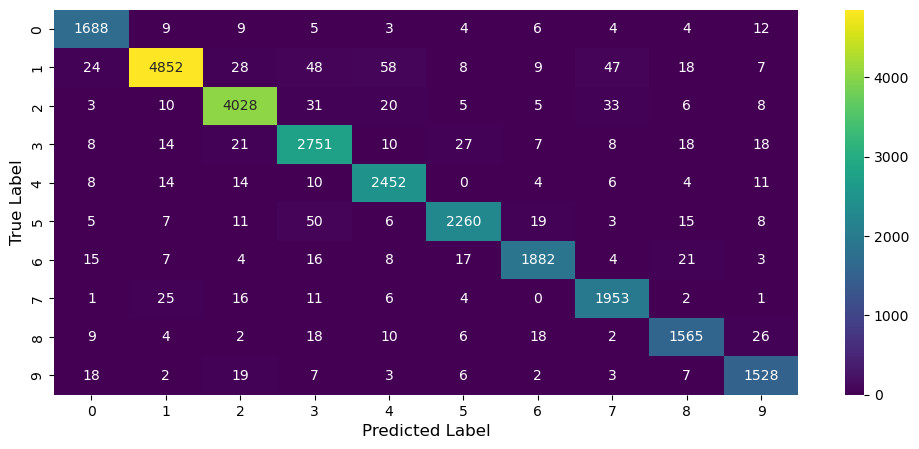

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import generate_confusion_matrix


dropout_aug_cm = generate_confusion_matrix(model_10_bottleneck_best, test_dataset)

## Model 9 & 10: Comparison

I applied a bottleneck dense layer after the flatten layer in both models and ran a hyperparameter search on both dense layers. With the introduction of the bottleneck layer it has reduced the overall total parameters. You can see Dropouts and Dropblocks training/validation accuracy and loss remain stable and very similar to the prior model. Positive diagonal numbers in the confusion matrix  and better performance in the accuracy and loss graph show that Dropblock still outperforms dropout in digit classification. 

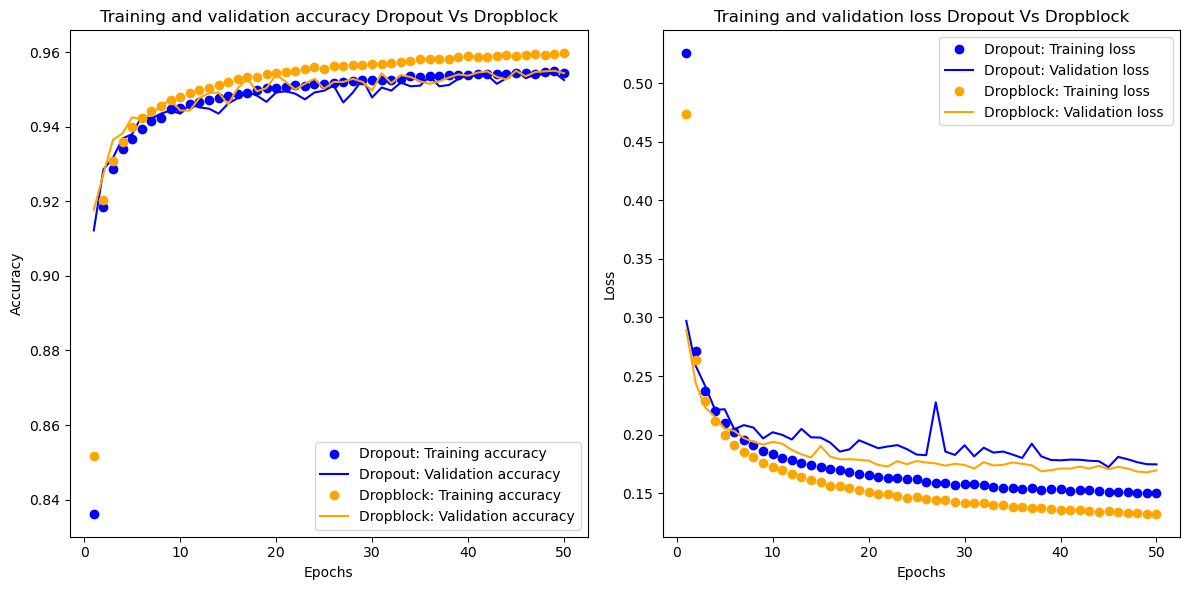

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import plot_accuracy_metric_comparison

import pandas as pd

# Load the model history into a dataframe
pd1 = pd.DataFrame(model_9_bottleneck_history.history)

# Load the model history into a dataframe
pd2 = pd.DataFrame(model_10_bottleneck_history.history)

# Plot the comparison Graphs
plot_accuracy_metric_comparison(pd1,'Model 9: Dropout', pd2, 'Model 10: Dropblock',  'Dropout Vs Dropblock')


Dropblock's training time has increased slightly despite having fewer parameters, likely due to the second dense layer doubling neurons from 256 to 512

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import compare_times

compare_times(model_9_bottleneck_time, model_10_bottleneck_time)

Average Epoch      Total Time
Model                                  
Model_1  0:00:35.797283  0:29:49.864135
Model_2  0:00:50.999288  0:42:29.964416

Sparsity has not returned to the model due to bottleneck, as dead neurones remain at 0. Similar output to the previous model where middle to lower layer activation diverges from 0. The bottleneck concentrates neurones slightly more, making them activate stronger compared to the previous models. 

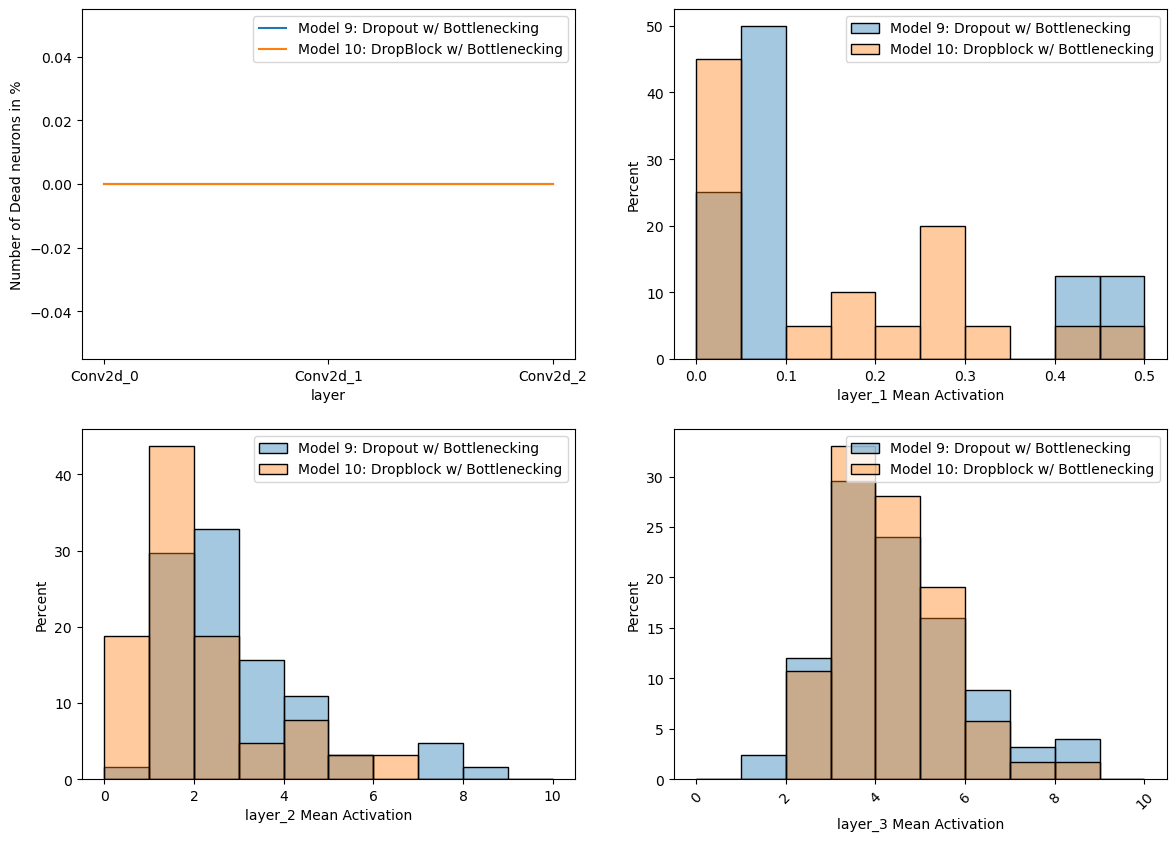

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_neurons_count, display_mean_activations

fig, axes = plt.subplots(2, 2, figsize=(14, 10))



display_neurons_count(model_9_bottleneck_best, test_dataset, ('Model 9: Dropout w/ Bottlenecking', axes[0,0]) )
display_neurons_count(model_10_bottleneck_best, test_dataset, ('Model 10: DropBlock w/ Bottlenecking', axes[0,0]) )

display_mean_activations(model_9_bottleneck_best, test_dataset, '1', 0, 0.5, 11, ('Model 9: Dropout w/ Bottlenecking', axes[0,1]) )
display_mean_activations(model_10_bottleneck_best, test_dataset, '1',0, 0.5, 11, ('Model 10: Dropblock w/ Bottlenecking', axes[0,1]) )

display_mean_activations(model_9_bottleneck_best, test_dataset, '2', 0, 10, 11, ('Model 9: Dropout w/ Bottlenecking', axes[1,0]) )
display_mean_activations(model_10_bottleneck_best, test_dataset, '2', 0, 10, 11, ('Model 10: Dropblock w/ Bottlenecking', axes[1,0]) )

display_mean_activations(model_9_bottleneck_best, test_dataset, '3', 0, 10, 11, ('Model 9: Dropout w/ Bottlenecking', axes[1,1]) )
display_mean_activations(model_10_bottleneck_best, test_dataset, '3', 0, 10, 11,  ('Model 10: Dropblock w/ Bottlenecking', axes[1,1]) )



While we have seen a tiny reduction in accuracy possibly due to a reduction in model size.

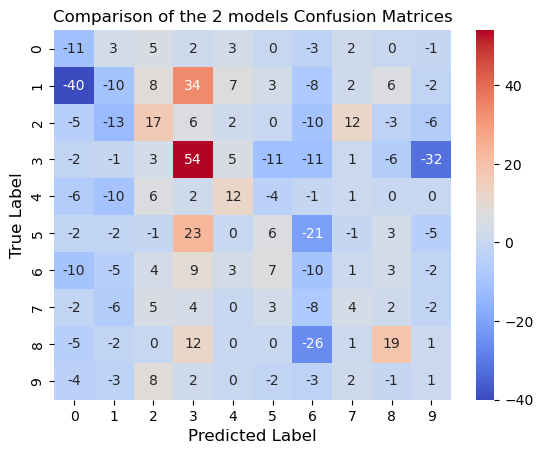

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import model_comparison_confusion_matrix

model_comparison_confusion_matrix(model_10_bottleneck_best, model_9_bottleneck_best, test_dataset )

# Maxout

In this section, I'll switch out the ReLu activation function for the Maxout function.  It will be used on the same model architecture in Models 9 & 10.  The value of the Maxout Hyperparameter must be a multiple of the value of the Conv2d Filter.  That means I can set the Maxout Values to [4, 8, 16] for a Conv2d layer with 32 filters.

## Model 11: Dropout with Maxout

I will be using maxout with the Model 9 values

In [ ]:
import keras
from keras import layers
from keras.constraints import MaxNorm
from keras.optimizers import Adam
from keras import regularizers
import tensorflow_addons as tfa

# Define a CNN using Maxout activations, Dropout, and Batch Normalization
# with hyperparameter tuning applied to Maxout units and bottleneck structure
def model_11_maxout_w_dropout_aug_batch_bottleneck_hyper_p(hp):

    model = keras.Sequential()
    
    model.add(layers.InputLayer(input_shape=(32, 32, 3)))
    model.add(layers.Dropout(rate=0.25))

    model.add(layers.Conv2D(32, kernel_size=(3, 3), strides=(1,1),))
    # First Maxout Layer
    model.add(tfa.layers.Maxout(num_units=hp.Choice('rate_1',[4, 8, 16]))),
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    
    model.add(layers.Dropout(rate=0.5))

    model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=(1,1)))
    # Second Maxout Layer
    model.add(tfa.layers.Maxout(num_units=hp.Choice('rate_2',[8, 16, 32]))),
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    
    model.add(layers.Dropout(rate=0.25)) 

    model.add(layers.Conv2D(128,kernel_size=(3, 3), strides=(1,1)))
    # Third Maxout Layer
    model.add(tfa.layers.Maxout(num_units=hp.Choice('rate_3',[16, 32, 64]))),
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    
    model.add(layers.Dropout(rate=0.25))

    model.add(layers.Flatten())

    model.add(layers.Dense(64))
    # Fourth Maxout Layer
    model.add(tfa.layers.Maxout(num_units=hp.Choice('rate_4',[4, 8, 16]))),

    model.add(layers.Dense(1024))
    # Fifth Maxout Layer
    model.add(tfa.layers.Maxout(num_units=hp.Choice('rate_5',[32, 64, 128]))),
               
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate=0.25))

    # Output softmax layer for 10-class classification
    model.add(layers.Dense(10, activation='softmax')) 

    # Compile with Adam optimizer and categorical crossentropy loss
    model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
    )
    return model   

c:\Users\seand\.conda\envs\Final_project_Testing\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\seand\.conda\envs\Final_project_Testing\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, d

Below, I am checking the model compiles correctly with the Keras tuner hyperparameters selection

In [ ]:
import keras_tuner

# Checking the Model compiles
model_11_maxout_w_dropout_aug_batch_bottleneck_hyper_p(keras_tuner.HyperParameters())

Below, I am setting up the search parameters for the hyperparameter search trials.

In [ ]:
# Create path for the hyperparameter trails
model_11_maxout_hyper_v_path = 'saved models/2. model 2 dropout/maxout/hyper p/'

# Setup the hyperparameter search
reload_tuner = keras_tuner.RandomSearch(
    hypermodel=model_11_maxout_w_dropout_aug_batch_bottleneck_hyper_p,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    overwrite=False,
    directory=model_11_maxout_hyper_v_path,
    project_name="model_11_maxout_hyper_p_v2",
)
reload_tuner.search_space_summary()

Reloading Tuner from saved models/2. model 2 dropout/maxout/hyper p/model_11_maxout_hyper_p_v2\tuner0.json
Search space summary
Default search space size: 5
rate_1 (Choice)
{'default': 4, 'conditions': [], 'values': [4, 8, 16], 'ordered': True}
rate_2 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
rate_3 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
rate_4 (Choice)
{'default': 4, 'conditions': [], 'values': [4, 8, 16], 'ordered': True}
rate_5 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}


Below, I use EarlyStopping callback below to save time.  If validation accuracy does not improve after 5 epochs, the trial will end and move on.

 I'm also using the hyper_p_dataset, a subset of the complete dataset, and setting the trial epoch to 25.  This speeds up search and lets the model train for a number of epochs.

In [ ]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)

# Setup Earlystopping to stop the train when the validation loss doesn't improve
early_stop = [tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5)
]

# Configure search Parameters
reload_tuner.search(
    aug_train_hyper_p_dataset,                                  # Training data and labels
    validation_data=(val_dataset),                              # Validation data and labels
    epochs=25,                                                  # Number of epochs
    class_weight=d_class_weights,                               # Adding Class Weights
    callbacks=[early_stop],                                     # Callbacks
    verbose=1                                                   # Verbosity mode (1 for progress bar)
)

Trial 20 Complete [00h 05m 34s]
val_accuracy: 0.8744999766349792

Best val_accuracy So Far: 0.921833336353302
Total elapsed time: 02h 08m 02s


Below cell, I am displaying the best model architecture found.

In [ ]:
# Get Top model configuration
models = reload_tuner.get_best_models(num_models=1)
# Load top model configuration
best_model = models[0]
# Print summary of top model
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 maxout (Maxout)             (None, 30, 30, 16)        0         
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 16)       0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 15, 15, 16)        0

Below Cell, I am just displaying all the trail results.

In [ ]:
# Display all results
reload_tuner.results_summary()

Results summary
Results in saved models/2. model 2 dropout/maxout/hyper p/model_11_maxout_hyper_p_v2
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 15 summary
Hyperparameters:
rate_1: 16
rate_2: 8
rate_3: 64
rate_4: 16
rate_5: 64
Score: 0.921833336353302

Trial 03 summary
Hyperparameters:
rate_1: 16
rate_2: 8
rate_3: 64
rate_4: 16
rate_5: 32
Score: 0.9178333282470703

Trial 00 summary
Hyperparameters:
rate_1: 16
rate_2: 16
rate_3: 32
rate_4: 8
rate_5: 32
Score: 0.9156666398048401

Trial 07 summary
Hyperparameters:
rate_1: 16
rate_2: 32
rate_3: 64
rate_4: 4
rate_5: 64
Score: 0.9154999852180481

Trial 09 summary
Hyperparameters:
rate_1: 16
rate_2: 16
rate_3: 32
rate_4: 8
rate_5: 64
Score: 0.9151666760444641

Trial 16 summary
Hyperparameters:
rate_1: 8
rate_2: 32
rate_3: 32
rate_4: 8
rate_5: 32
Score: 0.9118333458900452

Trial 12 summary
Hyperparameters:
rate_1: 8
rate_2: 16
rate_3: 32
rate_4: 8
rate_5: 64
Score: 0.9113333225250244

Trial 13 summary
Hyperpar

The top 5 search hyperparameters are loaded into a variable in the cell below.  I select the top congifuration and load the model with these values into a new variable.  The model will then be run on the entire training set.

In [ ]:
# Select the Top 5 performing hyperparameters configurations
best_hps = reload_tuner.get_best_hyperparameters(5)

# Load a new model with the Top configuration
model_11_maxout = model_11_maxout_w_dropout_aug_batch_bottleneck_hyper_p(best_hps[0])

I am setting up the path to save the top-performing model for the model checkpoint callback in the cell below.  Providing the fit function two calls back that save the best model and record the training time.  The full training dataset and the validation set are used, along with the epoch rate and the class weighted dictionary.

In [ ]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)

# Configure the path to save the model information
model_11_maxout_path = 'saved models/2. model 2 dropout/maxout/'

# Call Modelcheckpoint to save the best model with the validation loss
best_model = [tf.keras.callbacks.ModelCheckpoint(
        filepath=model_11_maxout_path + "model_11_maxout_best.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Record the training time of the model
model_11_maxout_time = TimeHistory()

# Save model History and fit the model
model_11_maxout_history = model_11_maxout.fit(
    aug_train_dataset,                                  # Training data and labels
    validation_data=(val_dataset),                      # Validation data and labels
    epochs=50,                                          # Number of epochs
    class_weight=d_class_weights,                       # Adding Class Weights
    callbacks=[best_model, model_11_maxout_time],       # Callbacks
    verbose=1                                           # Verbosity mode (1 for progress bar)
)

Epoch 1/50
4675/4675 [==============================] - 44s 7ms/step - loss: 0.8572 - accuracy: 0.7207 - val_loss: 0.3771 - val_accuracy: 0.8880
Epoch 2/50
4675/4675 [==============================] - 35s 6ms/step - loss: 0.4392 - accuracy: 0.8652 - val_loss: 0.3362 - val_accuracy: 0.9018
Epoch 3/50
4675/4675 [==============================] - 34s 6ms/step - loss: 0.3935 - accuracy: 0.8798 - val_loss: 0.3102 - val_accuracy: 0.9100
Epoch 4/50
4675/4675 [==============================] - 33s 6ms/step - loss: 0.3708 - accuracy: 0.8863 - val_loss: 0.2945 - val_accuracy: 0.9140
Epoch 5/50
4675/4675 [==============================] - 34s 6ms/step - loss: 0.3537 - accuracy: 0.8915 - val_loss: 0.2798 - val_accuracy: 0.9195
Epoch 6/50
4675/4675 [==============================] - 34s 6ms/step - loss: 0.3455 - accuracy: 0.8942 - val_loss: 0.2771 - val_accuracy: 0.9192
Epoch 7/50
4675/4675 [==============================] - 33s 6ms/step - loss: 0.3369 - accuracy: 0.8967 - val_loss: 0.2826 - val_ac

Saving the model information in the below cell

In [ ]:
import importlib
import utils.model_utils
importlib.reload(utils.model_utils)
from utils.model_utils import save_model_data

# Save model, model history and training time information
save_model_data(model_11_maxout_path,
               model_11_maxout,'model_11_maxout',
               model_11_maxout_history, 'model_11_maxout_history',
               model_11_maxout_time, 'model_11_maxout_time'  )

Below, I am reloading the history and Timing data to plot the curves.

In [ ]:
model_11_maxout_path = 'saved models/2. model 2 dropout/maxout/'

# Time
model_11_maxout_time= np.load(model_11_maxout_path + 'model_11_maxout_time.npy', allow_pickle=True)

# History
model_11_maxout_history = np.load(model_11_maxout_path + 'model_11_maxout_history.npy', allow_pickle=True).item()



I plot model accuracy and loss history in the cell below.

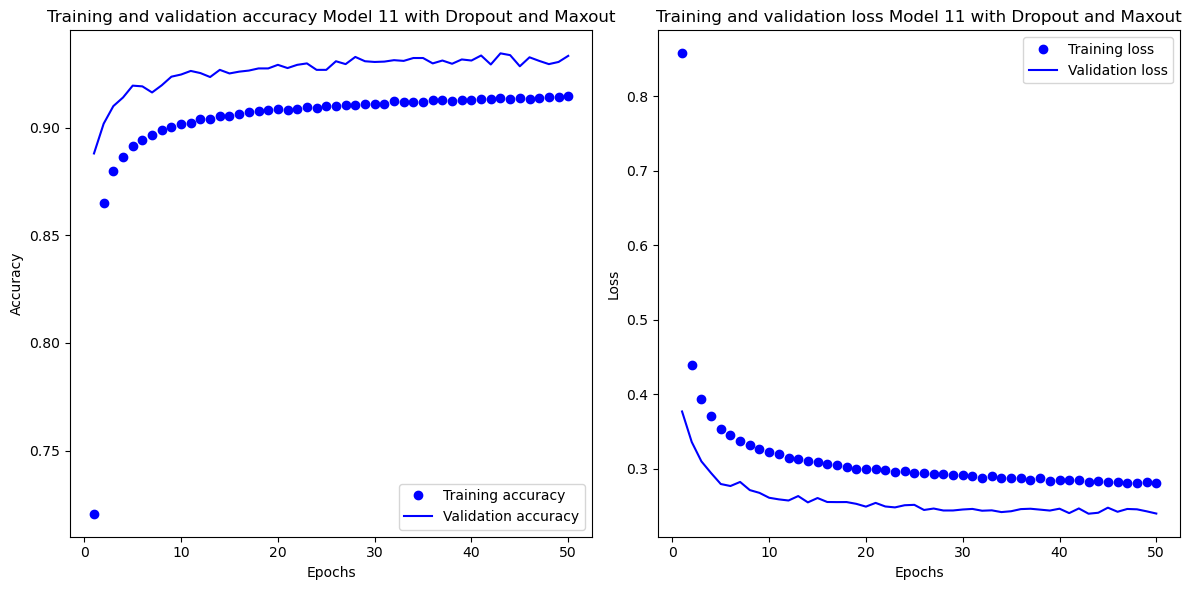

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import display_accuracy_loss

# Plot Training and validation Accuracy and loss.
display_accuracy_loss(model_11_maxout_history, 'Model 11 with Dropout and Maxout' )

Printing the training time history in cell below

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_model_times

# Print the model Training Time
display_model_times(model_11_maxout_time)

Total Time: 0:27:59.156345 Average Epoch Time: 0:00:33.583127


Load the best performing model that was trained and saved according to validation loss

In [63]:
import tensorflow_addons as tfa

# Configure the path to save the model information
model_11_maxout_path = 'saved models/2. model 2 dropout/maxout/'

# Load the best model saved during training based on validation loss
model_11_maxout_best = tf.keras.models.load_model(model_11_maxout_path + "model_11_maxout_best.keras")

c:\Users\seand\.conda\envs\Final_project_Testing\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\seand\.conda\envs\Final_project_Testing\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, d

Evaluate the best performing model on the test dataset

In [ ]:
model_11_maxout_best.evaluate(test_dataset)

204/204 [==============================] - 1s 3ms/step - loss: 0.2362 - accuracy: 0.9346


[0.23624077439308167, 0.9346189498901367]

Model 11 achieves an accuracy of 93.46%

Plotting the confusion matrix to see how the model handle each digit classification

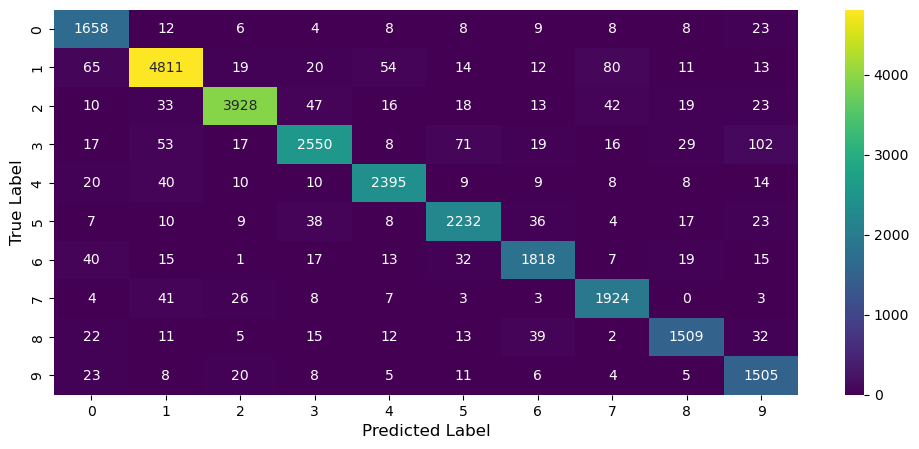

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import generate_confusion_matrix


dropout_aug_cm = generate_confusion_matrix(model_11_maxout_best, test_dataset)

## Model 12: Dropblock with Maxout

In [ ]:
import keras
from keras import layers
from keras.constraints import MaxNorm
from keras.optimizers import Adam

import importlib
import utils.DropBlock
importlib.reload(utils.DropBlock)
from utils.DropBlock import DropBlock2D
from keras import regularizers
import tensorflow_addons as tfa


def model_12_maxout_w_dropblock_aug_batch_bottleneck(hp):

    model = keras.Sequential()
    
    model.add(layers.InputLayer(input_shape=(32, 32, 3)))
    model.add(DropBlock2D(rate=0.2, block_size=4))

    model.add(layers.Conv2D(32, kernel_size=(3, 3), strides=(1,1)))
     # First Maxout Layer
    model.add(tfa.layers.Maxout(num_units=hp.Choice('rate_1',[4, 8, 16]))),
    model.add(layers.BatchNormalization())
    model.add(DropBlock2D(rate=0.3, block_size=2))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    
    

    model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=(1,1)))
    # Second Maxout Layer
    model.add(tfa.layers.Maxout(num_units=hp.Choice('rate_2',[8, 16, 32]))),
    model.add(layers.BatchNormalization())
    model.add(DropBlock2D(rate=0.2, block_size=4))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    


    model.add(layers.Conv2D(128,kernel_size=(3, 3), strides=(1,1)))
    # Third Maxout Layer
    model.add(tfa.layers.Maxout(num_units=hp.Choice('rate_3',[16, 32, 64]))),
    model.add(layers.BatchNormalization())
    model.add(DropBlock2D(rate=0.2, block_size=4))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    


    model.add(layers.Flatten())

    model.add(layers.Dense(64))
    # Fourth Maxout Layer
    model.add(tfa.layers.Maxout(num_units=hp.Choice('rate_4',[8, 16, 32]))),

    model.add(layers.Dense(512))
    # Fifth Maxout Layer
    model.add(tfa.layers.Maxout(num_units=hp.Choice('rate_5',[64, 128, 256]))),
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
    )
    return model    

c:\Users\seand\.conda\envs\Final_project_Testing\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\seand\.conda\envs\Final_project_Testing\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, d

Below, I am checking the model compiles correctly with the Keras tuner hyperparameters selection

In [ ]:
import keras_tuner

# Checking the Model compiles
model_12_maxout_w_dropblock_aug_batch_bottleneck(keras_tuner.HyperParameters())

Below, I am setting up the search parameters for the hyperparameter search trials.

In [ ]:
# Create path for the hyperparameter trails
model_12_maxout_hyper_v_path = 'saved models/3. Model 3 DropBlock/maxout/hyper p/'

# Setup the hyperparameter search
tuner = keras_tuner.RandomSearch(
    hypermodel=model_12_maxout_w_dropblock_aug_batch_bottleneck,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    overwrite=False,
    directory=model_12_maxout_hyper_v_path,
    project_name="model_12_maxout_hyper_p",
)
tuner.search_space_summary()

Reloading Tuner from saved models/3. Model 3 DropBlock/maxout/hyper p/model_12_maxout_hyper_p\tuner0.json
Search space summary
Default search space size: 5
rate_1 (Choice)
{'default': 4, 'conditions': [], 'values': [4, 8, 16], 'ordered': True}
rate_2 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
rate_3 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
rate_4 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
rate_5 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}


Below, I use EarlyStopping callback below to save time.  If validation accuracy does not improve after 5 epochs, the trial will end and move on.

 I'm also using the hyper_p_dataset, a subset of the complete dataset, and setting the trial epoch to 25.  This speeds up search and lets the model train for a number of epochs.

In [ ]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)

# Setup Earlystopping to stop the train when the validation loss doesn't improve
early_stop = [tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5)
]

# Configure search Parameters
tuner.search(
    aug_train_hyper_p_dataset,                                  # Training data and labels
    validation_data=(val_dataset),                              # Validation data and labels
    epochs=25,                                                  # Number of epochs
    class_weight=d_class_weights,                               # Adding Class Weights
    callbacks=[early_stop],                                     # Callbacks
    verbose=1                                                   # Verbosity mode (1 for progress bar)
)

Trial 20 Complete [00h 08m 48s]
val_accuracy: 0.8993333578109741

Best val_accuracy So Far: 0.940500020980835
Total elapsed time: 02h 40m 48s


Below cell, I am displaying the best model architecture found.

In [ ]:
# Get Top model configuration
models = tuner.get_best_models(num_models=1)
# Load top model configuration
best_model = models[0]
# Print summary of top model
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 drop_block2d (DropBlock2D)  (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 maxout (Maxout)             (None, 30, 30, 8)         0         
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 8)        32        
 ormalization)                                                   
                                                                 
 drop_block2d_1 (DropBlock2D  (None, 30, 30, 8)        0         
 )                                                               
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 8)        0

Below Cell, I am just displaying all the trail results.

In [ ]:
# Display all results
tuner.results_summary()

Results summary
Results in saved models/3. Model 3 DropBlock/maxout/hyper p/model_12_maxout_hyper_p
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 18 summary
Hyperparameters:
rate_1: 8
rate_2: 32
rate_3: 64
rate_4: 32
rate_5: 128
Score: 0.940500020980835

Trial 16 summary
Hyperparameters:
rate_1: 16
rate_2: 32
rate_3: 64
rate_4: 8
rate_5: 64
Score: 0.934333324432373

Trial 02 summary
Hyperparameters:
rate_1: 8
rate_2: 16
rate_3: 64
rate_4: 32
rate_5: 64
Score: 0.9330000281333923

Trial 06 summary
Hyperparameters:
rate_1: 8
rate_2: 32
rate_3: 64
rate_4: 8
rate_5: 64
Score: 0.9323333501815796

Trial 04 summary
Hyperparameters:
rate_1: 8
rate_2: 32
rate_3: 64
rate_4: 8
rate_5: 256
Score: 0.9296666383743286

Trial 15 summary
Hyperparameters:
rate_1: 16
rate_2: 32
rate_3: 32
rate_4: 8
rate_5: 64
Score: 0.9296666383743286

Trial 12 summary
Hyperparameters:
rate_1: 4
rate_2: 32
rate_3: 64
rate_4: 32
rate_5: 64
Score: 0.9265000224113464

Trial 09 summary
Hyperpar

The top 5 search hyperparameters are loaded into a variable in the cell below.  I select the top congifuration and load the model with these values into a new variable.  The model will then be run on the entire training set.

In [ ]:
# Select the Top 5 performing hyperparameters configurations
best_hps = tuner.get_best_hyperparameters(5)

# Load a new model with the Top configuration
model_12_maxout = model_12_maxout_w_dropblock_aug_batch_bottleneck(best_hps[0])

I am setting up the path to save the top-performing model for the model checkpoint callback in the cell below.  Providing the fit function two calls back that save the best model and record the training time.  The full training dataset and the validation set are used, along with the epoch rate and the class weighted dictionary.

In [ ]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)

# Configure the path to save the model information
model_12_maxout_path = 'saved models/3. Model 3 DropBlock/maxout/'

# Call Modelcheckpoint to save the best model with the validation loss
best_model = [tf.keras.callbacks.ModelCheckpoint(
        filepath=model_12_maxout_path + "model_12_maxout_best.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Record the training time of the model
model_12_maxout_time = TimeHistory()

# Save model History and fit the model
model_12_maxout_history = model_12_maxout.fit(
    aug_train_dataset,                                  # Training data and labels
    validation_data=(val_dataset),                  # Validation data and labels
    epochs=50,                                     # Number of epochs
    class_weight=d_class_weights,                   # Adding Class Weights
    callbacks=[best_model, model_12_maxout_time],             # Callbacks
    verbose=1                                       # Verbosity mode (1 for progress bar)
)

Epoch 1/50
4675/4675 [==============================] - 49s 8ms/step - loss: 0.6155 - accuracy: 0.8030 - val_loss: 0.3751 - val_accuracy: 0.8908
Epoch 2/50
4675/4675 [==============================] - 42s 8ms/step - loss: 0.3729 - accuracy: 0.8849 - val_loss: 0.3389 - val_accuracy: 0.9013
Epoch 3/50
4675/4675 [==============================] - 42s 8ms/step - loss: 0.3347 - accuracy: 0.8965 - val_loss: 0.3177 - val_accuracy: 0.9088
Epoch 4/50
4675/4675 [==============================] - 42s 8ms/step - loss: 0.3155 - accuracy: 0.9027 - val_loss: 0.3061 - val_accuracy: 0.9118
Epoch 5/50
4675/4675 [==============================] - 41s 8ms/step - loss: 0.3020 - accuracy: 0.9069 - val_loss: 0.2970 - val_accuracy: 0.9138
Epoch 6/50
4675/4675 [==============================] - 41s 8ms/step - loss: 0.2909 - accuracy: 0.9103 - val_loss: 0.2864 - val_accuracy: 0.9180
Epoch 7/50
4675/4675 [==============================] - 42s 8ms/step - loss: 0.2841 - accuracy: 0.9123 - val_loss: 0.2820 - val_ac

Saving the model information in the below cell

In [ ]:
import importlib
import utils.model_utils
importlib.reload(utils.model_utils)
from utils.model_utils import save_model_data

# Save model, model history and training time information
save_model_data(model_12_maxout_path,
               model_12_maxout,'model_12_maxout',
               model_12_maxout_history, 'model_12_maxout_history',
               model_12_maxout_time, 'model_12_maxout_time'  )

Below, I am reloading the history and Timing data to plot the curves.

In [ ]:
model_12_maxout_path = 'saved models/3. Model 3 DropBlock/maxout/'

# Time
model_12_maxout_time = np.load(model_12_maxout_path+ 'model_12_maxout_time.npy', allow_pickle=True)

# History
model_12_maxout_history = np.load(model_12_maxout_path + 'model_12_maxout_history.npy', allow_pickle=True).item()



I plot model accuracy and loss history in the cell below.

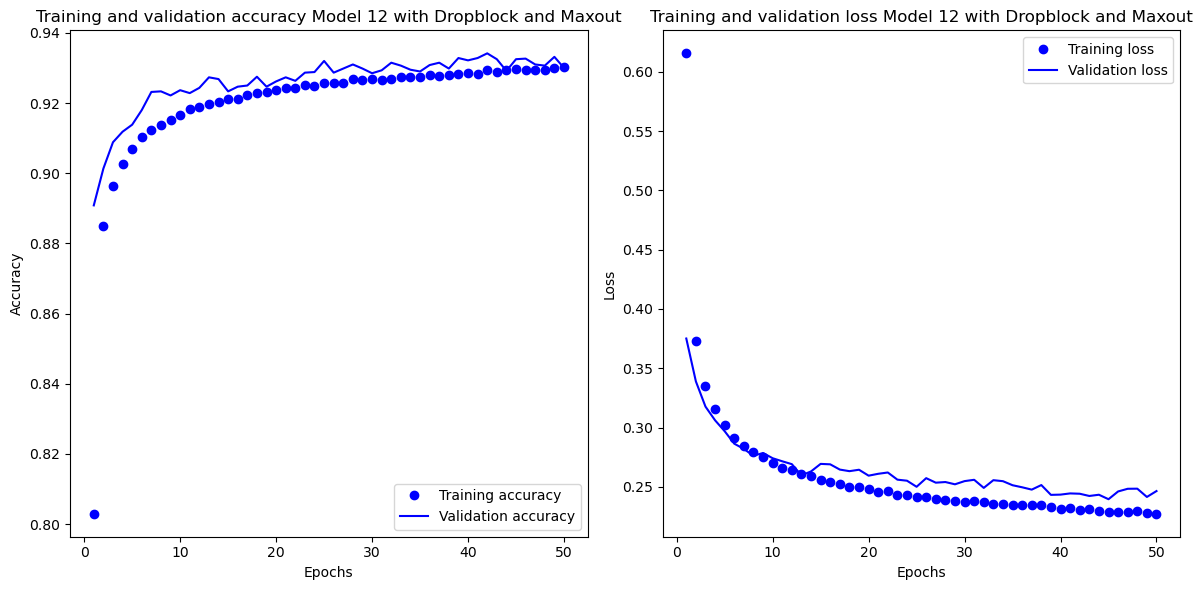

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import display_accuracy_loss

# Plot Training and validation Accuracy and loss.
display_accuracy_loss(model_12_maxout_history, 'Model 12 with Dropblock and Maxout', reload=True )

Printing the training time history in cell below

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_model_times

# Print the model Training Time
display_model_times(model_12_maxout_time , reload=True)

Total Time: 0:34:25.864151 Average Epoch Time: 0:00:41.317283


Load the best performing model that was trained and saved according to validation loss

In [64]:
import utils.DropBlock
importlib.reload(utils.DropBlock)
from utils.DropBlock import DropBlock2D
import tensorflow_addons as tfa

# Configure the path to save the model information
model_12_maxout_path = 'saved models/3. Model 3 DropBlock/maxout/'

# Load the best model saved during training based on validation loss
model_12_maxout_best = tf.keras.models.load_model(model_12_maxout_path + "model_12_maxout_best.keras", {"DropBlock2D": DropBlock2D})

Evaluate the best performing model on the test dataset

In [ ]:
model_12_maxout_best.evaluate(test_dataset)

204/204 [==============================] - 5s 3ms/step - loss: 0.2099 - accuracy: 0.9424


[0.20990966260433197, 0.9423786401748657]

Model 12 achieves an accuracy of 94.24%

Plotting the confusion matrix to see how the model handle each digit classification

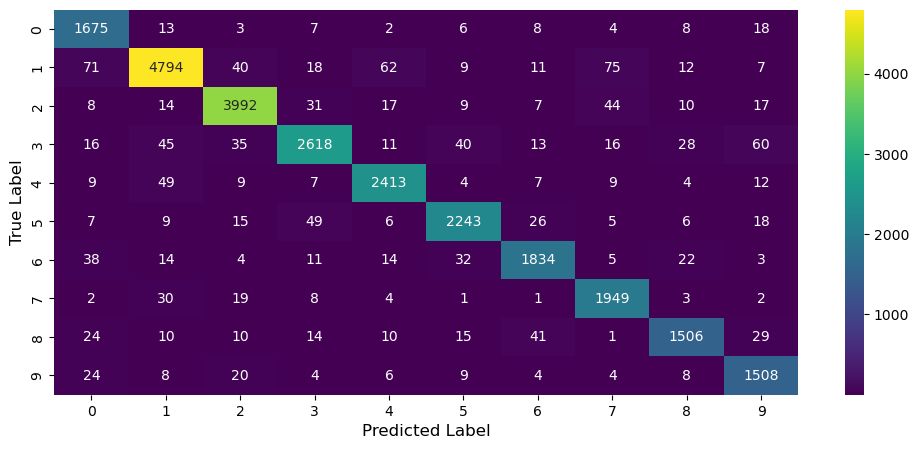

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import generate_confusion_matrix


dropout_aug_cm = generate_confusion_matrix(model_12_maxout_best, test_dataset)

## Model 11 & 12: Comparison

Applying Maxout smoothes accuracy and loss curves. The accuracy and loss curves for dropblock training and validation are very close to being the same, which shows that they fit very well. Since Maxout was used, you can see that the dropout validation accuracy and curve is better than the training curve.

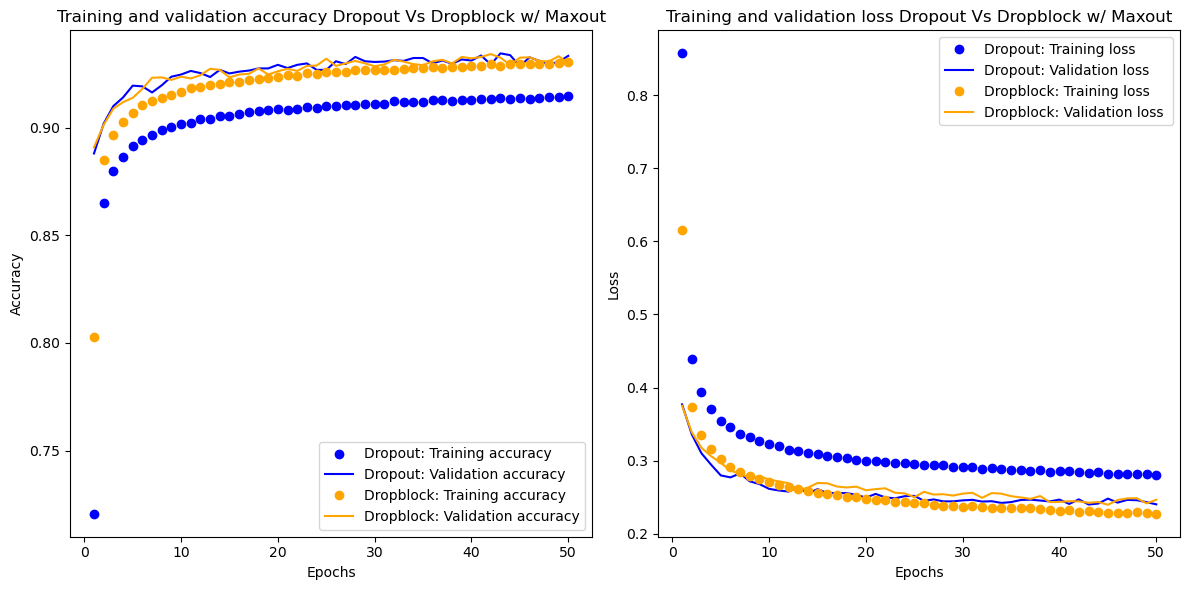

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import plot_accuracy_metric_comparison

import pandas as pd

# Load the model history into a dataframe
pd1 = pd.DataFrame(model_11_maxout_history.history)

# Load the model history into a dataframe
pd2 = pd.DataFrame(model_12_maxout_history)

# Plot the comparison Graphs
plot_accuracy_metric_comparison(pd1,'Model 11: Dropout w/ Maxout', pd2, 'Model 12: Dropblock w/ Maxout',  'Dropout Vs Dropblock w/ Maxout')


We also see that adding Maxout has improved the training time for the Dropblock and Dropout model from the previous results

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import compare_times

compare_times(model_11_maxout_time, model_12_maxout_time, reload=True)

Average Epoch      Total Time
Model                                  
Model_1  0:00:33.583127  0:27:59.156345
Model_2  0:00:41.317283  0:34:25.864151

Maxout has not contributed to adding dead neurons to the model. You can see Maxout has produce a smaller activation range in middle to deeper layers. Many neurons are similarly activated compared to a wider range of activations in the previous models 9 & 10. This may be down to Maxout making the neural network perform better by inducing more similarly activated neurons at the cost decreasing the parameters

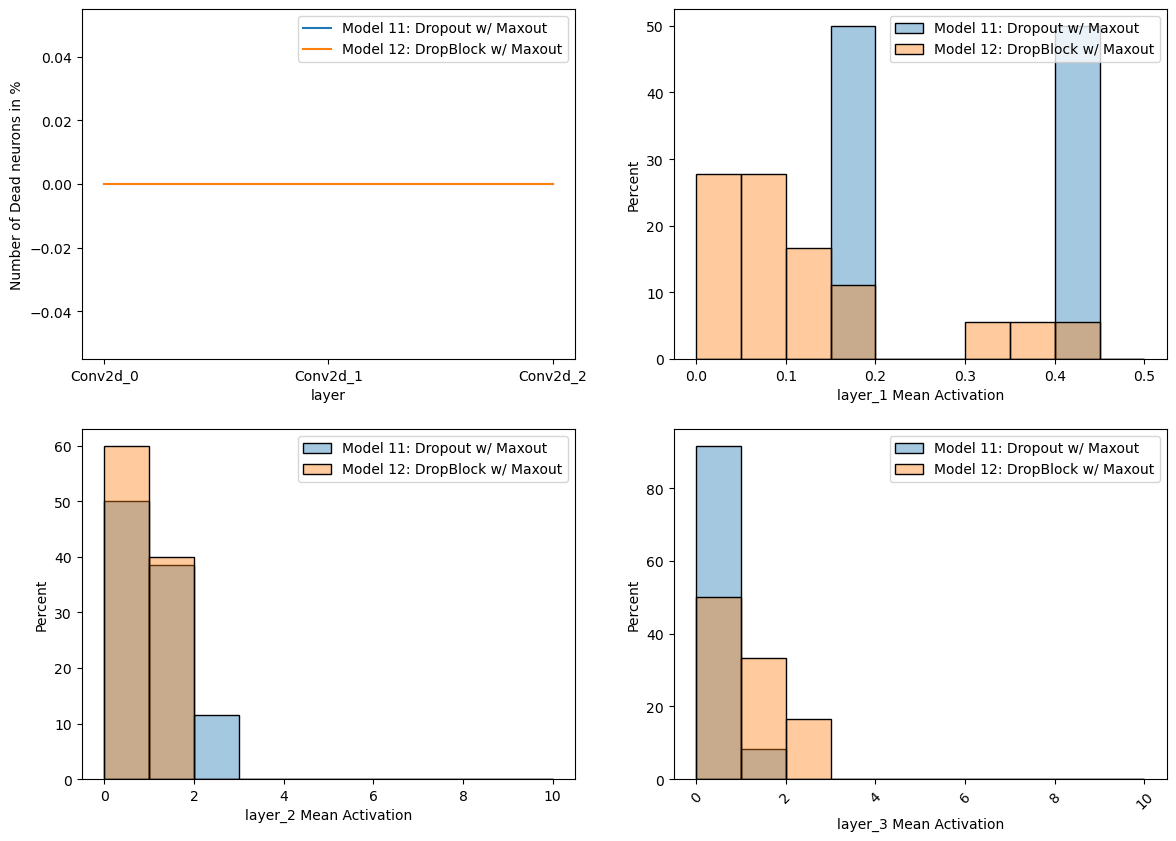

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_neurons_count, display_mean_activations

fig, axes = plt.subplots(2, 2, figsize=(14, 10))



display_neurons_count(model_11_maxout_best, test_dataset, ('Model 11: Dropout w/ Maxout', axes[0,0]) )
display_neurons_count(model_12_maxout_best, test_dataset, ('Model 12: DropBlock w/ Maxout', axes[0,0]) )

display_mean_activations(model_11_maxout_best, test_dataset, '1', 0, 0.5, 11, ('Model 11: Dropout w/ Maxout', axes[0,1]) )
display_mean_activations(model_12_maxout_best, test_dataset, '1',0, 0.5, 11, ('Model 12: DropBlock w/ Maxout', axes[0,1]) )

display_mean_activations(model_11_maxout_best, test_dataset, '2', 0, 10, 11, ('Model 11: Dropout w/ Maxout', axes[1,0]) )
display_mean_activations(model_12_maxout_best, test_dataset, '2', 0, 10, 11, ('Model 12: DropBlock w/ Maxout', axes[1,0]) )

display_mean_activations(model_11_maxout_best, test_dataset, '3', 0, 10, 11, ('Model 11: Dropout w/ Maxout', axes[1,1]) )
display_mean_activations(model_12_maxout_best, test_dataset, '3', 0, 10, 11,  ('Model 12: DropBlock w/ Maxout', axes[1,1]) )



The confusion matrix shows Dropblock model outperforming Dropout on correct classification.

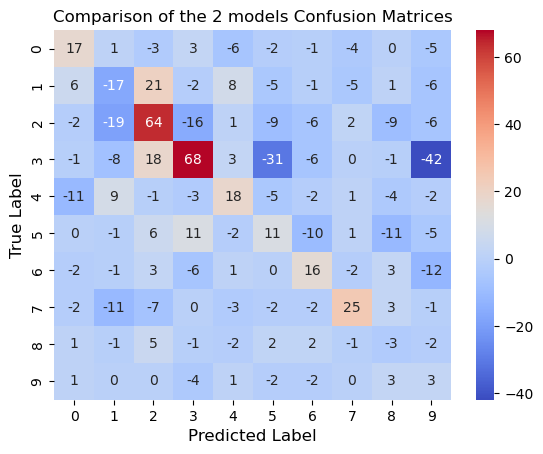

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import model_comparison_confusion_matrix

model_comparison_confusion_matrix(model_12_maxout_best, model_11_maxout_best, test_dataset )

# Kernel Constraints Max Norm

Maxnorm was applied to the three convolutional layers and the two dense layers on top of the Bottleneck architecture in Model 9 & 10. A hyperparameter search was conducted to find best-found values for each model. The values used for the hyperparameter Maxnorm search are [3.0, 3.25, 3.5, 3.75, 4.0]

## Model 13: Dropout

In [ ]:
import keras
from keras import layers
from keras.constraints import MaxNorm
from keras.optimizers import Adam

# CNN model using Dropout, Batch Normalization, Bottleneck Dense layers,
# and MaxNorm kernel constraints with hyperparameter tuning
def model_13_relu_w_dropout_aug_batch_bottleneck_maxnorm(hp):

    model = keras.Sequential()
    
    model.add(layers.InputLayer(input_shape=(32, 32, 3)))
    model.add(layers.Dropout(rate=0.25))

    # First convolutional block with MaxNorm constraint
    model.add(layers.Conv2D(32, kernel_size=(3, 3), strides=(1,1),
                             kernel_constraint=MaxNorm(hp.Choice('max_norm_1', [3.0, 3.25, 3.5, 3.75, 4.0])),
                             activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    
    model.add(layers.Dropout(rate=0.5))

    # Second convolutional block with MaxNorm
    model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=(1,1),
                             kernel_constraint=MaxNorm(hp.Choice('max_norm_2', [3.0, 3.25, 3.5, 3.75, 4.0])),
                             activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    
    model.add(layers.Dropout(rate=0.25)) 

    # Third convolutional block with MaxNorm
    model.add(layers.Conv2D(128,kernel_size=(3, 3), strides=(1,1), 
                             kernel_constraint=MaxNorm(hp.Choice('max_norm_3', [3.0, 3.25, 3.5, 3.75, 4.0])),
                             activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    
    model.add(layers.Dropout(rate=0.25))

    model.add(layers.Flatten())

    # Bottleneck dense layer with MaxNorm
    model.add(layers.Dense(64,
                        kernel_constraint=MaxNorm(hp.Choice('max_norm_4', [3.0, 3.25, 3.5, 3.75, 4.0])),
                        activation='relu'))
    
    # Larger dense layer with MaxNorm
    model.add(layers.Dense(1024,
                           kernel_constraint=MaxNorm(hp.Choice('max_norm_5', [3.0, 3.25, 3.5, 3.75, 4.0])),
                           activation='relu'))
               
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate=0.25))

    # Output softmax layer for 10-class classification
    model.add(layers.Dense(10, activation='softmax'))

    # Compile with Adam optimizer and categorical crossentropy loss
    model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
    )
    return model   

Below, I am checking the model compiles correctly with the Keras tuner hyperparameters selection

In [ ]:
import keras_tuner

# Checking the Model compiles
model_13_relu_w_dropout_aug_batch_bottleneck_maxnorm(keras_tuner.HyperParameters())

Below, I am setting up the search parameters for the hyperparameter search trials.

In [ ]:
# Create path for the hyperparameter trails
model_13_path = 'saved models/2. Model 2 Dropout/maxnorm/'

# Setup the hyperparameter search
tuner = keras_tuner.RandomSearch(
    hypermodel=model_13_relu_w_dropout_aug_batch_bottleneck_maxnorm,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    overwrite=True,
    directory=model_13_path,
    project_name="model_13_relu_w_dropout_aug_batch_bottleneck_maxnorm",
)
tuner.search_space_summary()

KeyboardInterrupt: 

Below, I use EarlyStopping callback below to save time.  If validation accuracy does not improve after 5 epochs, the trial will end and move on.

 I'm also using the hyper_p_dataset, a subset of the complete dataset, and setting the trial epoch to 25.  This speeds up search and lets the model train for a number of epochs.

In [ ]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)

# Setup Earlystopping to stop the train when the validation loss doesn't improve
early_stop = [tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5)
]

# Configure search Parameters
tuner.search(
    aug_train_hyper_p_dataset,                                  # Training data and labels
    validation_data=(val_dataset),                              # Validation data and labels
    epochs=25,                                                  # Number of epochs
    class_weight=d_class_weights,                               # Adding Class Weights
    callbacks=[early_stop],                                     # Callbacks
    verbose=1                                                   # Verbosity mode (1 for progress bar)
)

Trial 20 Complete [00h 06m 02s]
val_accuracy: 0.9423333406448364

Best val_accuracy So Far: 0.9446666836738586
Total elapsed time: 01h 51m 23s


Below cell, I am displaying the best model architecture found.

In [ ]:
# Get Top model configuration
models = tuner.get_best_models(num_models=1)
# Load top model configuration
best_model = models[0]
# Print summary of top model
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        1

Below Cell, I am just displaying all the trail results.

In [ ]:
# Display all results
tuner.results_summary()

Results summary
Results in saved models/2. Model 2 Dropout/maxnorm/model_13_relu_w_dropout_aug_batch_bottleneck_maxnorm
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
max_norm_1: 4.0
max_norm_2: 3.75
max_norm_3: 3.75
max_norm_4: 3.0
max_norm_5: 4.0
Score: 0.9446666836738586

Trial 09 summary
Hyperparameters:
max_norm_1: 3.75
max_norm_2: 3.75
max_norm_3: 3.5
max_norm_4: 3.0
max_norm_5: 3.5
Score: 0.9443333148956299

Trial 14 summary
Hyperparameters:
max_norm_1: 4.0
max_norm_2: 4.0
max_norm_3: 4.0
max_norm_4: 3.75
max_norm_5: 3.75
Score: 0.9443333148956299

Trial 04 summary
Hyperparameters:
max_norm_1: 4.0
max_norm_2: 3.5
max_norm_3: 3.75
max_norm_4: 4.0
max_norm_5: 4.0
Score: 0.9440000057220459

Trial 07 summary
Hyperparameters:
max_norm_1: 4.0
max_norm_2: 3.5
max_norm_3: 4.0
max_norm_4: 4.0
max_norm_5: 3.75
Score: 0.9434999823570251

Trial 17 summary
Hyperparameters:
max_norm_1: 3.75
max_norm_2: 3.25
max_norm_3: 3.5
max_norm_4:

The top 5 search hyperparameters are loaded into a variable in the cell below.  I select the top congifuration and load the model with these values into a new variable.  The model will then be run on the entire training set.

In [ ]:
# Select the Top 5 performing hyperparameters configurations
best_hps = tuner.get_best_hyperparameters(5)

# Load a new model with the Top configuration
model_13_maxnorm = model_13_relu_w_dropout_aug_batch_bottleneck_maxnorm(best_hps[0])

I am setting up the path to save the top-performing model for the model checkpoint callback in the cell below.  Providing the fit function two calls back that save the best model and record the training time.  The full training dataset and the validation set are used, along with the epoch rate and the class weighted dictionary.

In [ ]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)

# Configure the path to save the model information
model_13_maxnorm_path = 'saved models/2. Model 2 Dropout/maxnorm/'

# Call Modelcheckpoint to save the best model with the validation loss
best_model = [tf.keras.callbacks.ModelCheckpoint(
        filepath=model_13_maxnorm_path  + "model_13_maxnorm_best.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Record the training time of the model
model_13_maxnorm_time = TimeHistory()

# Save model History and fit the model
model_13_maxnorm_history = model_13_maxnorm.fit(
    aug_train_dataset,                                  # Training data and labels
    validation_data=(val_dataset),                      # Validation data and labels
    epochs=50,                                          # Number of epochs
    class_weight=d_class_weights,                       # Adding Class Weights
    callbacks=[best_model, model_13_maxnorm_time],      # Callbacks
    verbose=1                                           # Verbosity mode (1 for progress bar)
)

Epoch 1/50
4675/4675 [==============================] - 39s 7ms/step - loss: 0.5229 - accuracy: 0.8367 - val_loss: 0.2926 - val_accuracy: 0.9160
Epoch 2/50
4675/4675 [==============================] - 37s 7ms/step - loss: 0.2733 - accuracy: 0.9179 - val_loss: 0.2693 - val_accuracy: 0.9248
Epoch 3/50
4675/4675 [==============================] - 37s 7ms/step - loss: 0.2394 - accuracy: 0.9284 - val_loss: 0.2409 - val_accuracy: 0.9338
Epoch 4/50
4675/4675 [==============================] - 37s 7ms/step - loss: 0.2205 - accuracy: 0.9341 - val_loss: 0.2288 - val_accuracy: 0.9372
Epoch 5/50
4675/4675 [==============================] - 37s 7ms/step - loss: 0.2106 - accuracy: 0.9369 - val_loss: 0.2187 - val_accuracy: 0.9408
Epoch 6/50
4675/4675 [==============================] - 36s 7ms/step - loss: 0.2038 - accuracy: 0.9388 - val_loss: 0.2264 - val_accuracy: 0.9382
Epoch 7/50
4675/4675 [==============================] - 37s 7ms/step - loss: 0.1977 - accuracy: 0.9408 - val_loss: 0.2142 - val_ac

Saving the model information in the below cell

In [ ]:
import importlib
import utils.model_utils
importlib.reload(utils.model_utils)
from utils.model_utils import save_model_data

# Configure the path to save the model information
model_13_maxnorm_path = 'saved models/2. Model 2 Dropout/maxnorm/'

# Save model, model history and training time information
save_model_data(model_13_maxnorm_path,
               model_13_maxnorm,'model_13_maxnorm',
               model_13_maxnorm_history, 'model_13_maxnorm_history',
               model_13_maxnorm_time, 'model_13_maxnorm_time'  )

I plot model accuracy and loss history in the cell below.

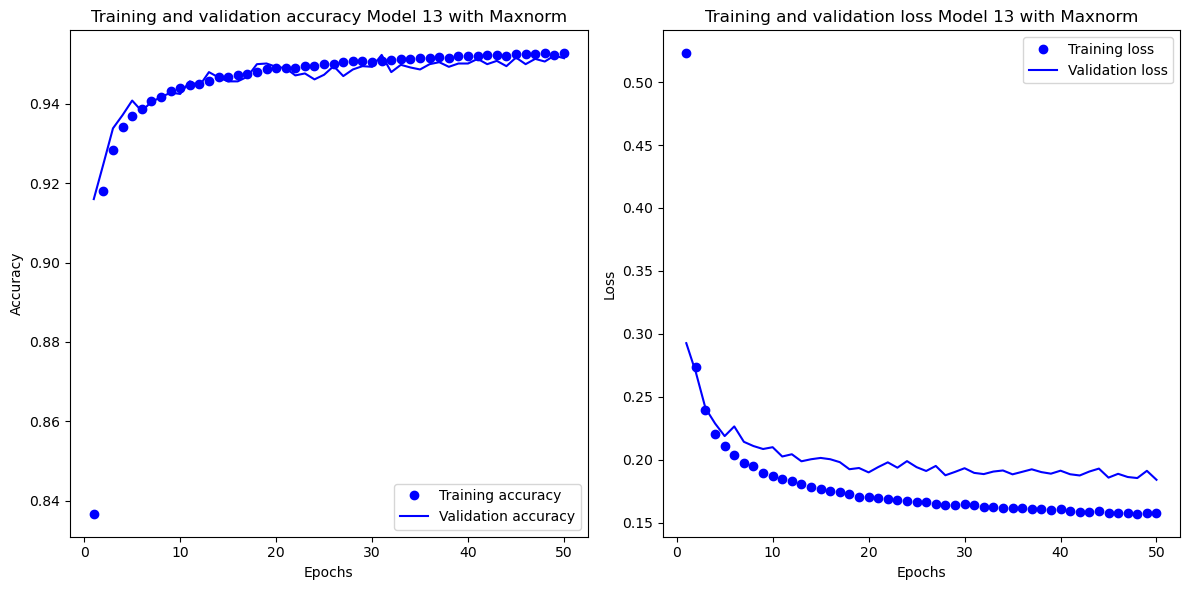

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import display_accuracy_loss

# Plot Training and validation Accuracy and loss.
display_accuracy_loss(model_13_maxnorm_history, 'Model 13 with Maxnorm' )

Printing the training time history in cell below

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_model_times

# Print the model Training Time
display_model_times(model_13_maxnorm_time)

Total Time: 0:30:09.218984 Average Epoch Time: 0:00:36.184380


Load the best performing model that was trained and saved according to validation loss

In [ ]:
# Configure the path to save the model information
model_13_maxnorm_path = 'saved models/2. Model 2 Dropout/maxnorm/'

# Load the best model saved during training based on validation loss
model_13_maxnorm_best = tf.keras.models.load_model(model_13_maxnorm_path  + "model_13_maxnorm_best.keras")

Evaluate the best performing model on the test dataset

In [ ]:
model_13_maxnorm_best.evaluate(test_dataset)

204/204 [==============================] - 1s 4ms/step - loss: 0.1708 - accuracy: 0.9551


[0.17077231407165527, 0.9550937414169312]

Model 13 achieves an accuracy of 95.51%

Plotting the confusion matrix to see how the model handle each digit classification

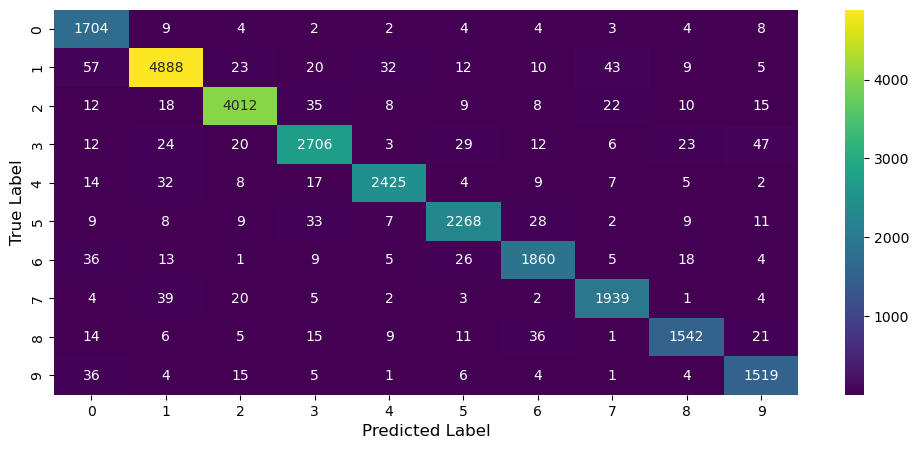

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import generate_confusion_matrix


dropout_aug_cm = generate_confusion_matrix(model_13_maxnorm_best, test_dataset)

## Model 14: Dropblock

In [ ]:
import keras
from keras import layers
from keras.constraints import MaxNorm
from keras.optimizers import Adam

import importlib
import utils.DropBlock
importlib.reload(utils.DropBlock)
from utils.DropBlock import DropBlock2D


# CNN model using Dropblock, Batch Normalization, Bottleneck Dense layers,
# and MaxNorm kernel constraints with hyperparameter tuning
def model_14_relu_w_dropblock_aug_batch_bottleneck_maxnorm(hp):

    model = keras.Sequential()
    
    model.add(layers.InputLayer(input_shape=(32, 32, 3)))
    model.add(DropBlock2D(rate=0.2, block_size=4))

    # First convolutional block with MaxNorm constraint
    model.add(layers.Conv2D(32, kernel_size=(3, 3), strides=(1,1),
                            kernel_constraint=MaxNorm(hp.Choice('max_norm_1', [3.0, 3.25, 3.5, 3.75, 4.0])),
                            activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(DropBlock2D(rate=0.3, block_size=2))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    
    
    # Second convolutional block with MaxNorm
    model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=(1,1),
                            kernel_constraint=MaxNorm(hp.Choice('max_norm_2', [3.0, 3.25, 3.5, 3.75, 4.0])),
                            activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(DropBlock2D(rate=0.2, block_size=4))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    

    # Third convolutional block with MaxNorm
    model.add(layers.Conv2D(128,kernel_size=(3, 3), strides=(1,1),
                            kernel_constraint=MaxNorm(hp.Choice('max_norm_3', [3.0, 3.25, 3.5, 3.75, 4.0])),
                            activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(DropBlock2D(rate=0.2, block_size=4))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    

    model.add(layers.Flatten())

    # Bottleneck dense layer with MaxNorm
    model.add(layers.Dense(64,
                        kernel_constraint=MaxNorm(hp.Choice('max_norm_4', [3.0, 3.25, 3.5, 3.75, 4.0])),
                        activation='relu'))

    # Larger dense layer with MaxNorm
    model.add(layers.Dense(512,
                           kernel_constraint=MaxNorm(hp.Choice('max_norm_5', [3.0, 3.25, 3.5, 3.75, 4.0])),
                           activation='relu'))
    model.add(layers.BatchNormalization())

    # Output softmax layer for 10-class classification
    model.add(layers.Dense(10, activation='softmax'))

    # Compile with Adam optimizer and categorical crossentropy loss
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
    )
    return model    

Below, I am checking the model compiles correctly with the Keras tuner hyperparameters selection

In [ ]:
import keras_tuner

# Checking the Model compiles
model_14_relu_w_dropblock_aug_batch_bottleneck_maxnorm(keras_tuner.HyperParameters())

Below, I am setting up the search parameters for the hyperparameter search trials.

In [ ]:
# Create path for the hyperparameter trails
model_14_maxnorm_path = 'saved models/3. Model 3 DropBlock/maxnorm/'

# Setup the hyperparameter search
tuner = keras_tuner.RandomSearch(
    hypermodel=model_14_relu_w_dropblock_aug_batch_bottleneck_maxnorm,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    overwrite=True,
    directory=model_14_maxnorm_path ,
    project_name="model_14_relu_w_dropblock_aug_batch_bottleneck_maxnorm",
)
tuner.search_space_summary()

Search space summary
Default search space size: 4
max_norm_1 (Choice)
{'default': 3.0, 'conditions': [], 'values': [3.0, 3.25, 3.5, 3.75, 4.0], 'ordered': True}
max_norm_2 (Choice)
{'default': 3.0, 'conditions': [], 'values': [3.0, 3.25, 3.5, 3.75, 4.0], 'ordered': True}
max_norm_3 (Choice)
{'default': 3.0, 'conditions': [], 'values': [3.0, 3.25, 3.5, 3.75, 4.0], 'ordered': True}
max_norm_4 (Choice)
{'default': 3.0, 'conditions': [], 'values': [3.0, 3.25, 3.5, 3.75, 4.0], 'ordered': True}


Below, I use EarlyStopping callback below to save time.  If validation accuracy does not improve after 5 epochs, the trial will end and move on.

 I'm also using the hyper_p_dataset, a subset of the complete dataset, and setting the trial epoch to 25.  This speeds up search and lets the model train for a number of epochs.

In [ ]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)

# Setup Earlystopping to stop the train when the validation loss doesn't improve
early_stop = [tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5)
]

# Configure search Parameters
tuner.search(
    aug_train_hyper_p_dataset,                                  # Training data and labels
    validation_data=(val_dataset),                              # Validation data and labels
    epochs=25,                                                  # Number of epochs
    class_weight=d_class_weights,                               # Adding Class Weights
    callbacks=[early_stop],                                     # Callbacks
    verbose=1                                                   # Verbosity mode (1 for progress bar)
)

Trial 20 Complete [00h 06m 44s]
val_accuracy: 0.937666654586792

Best val_accuracy So Far: 0.9428333044052124
Total elapsed time: 02h 25m 47s


Below cell, I am displaying the best model architecture found.

In [ ]:
# Get Top model configuration
models = tuner.get_best_models(num_models=1)
# Load top model configuration
best_model = models[0]
# Print summary of top model
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 drop_block2d (DropBlock2D)  (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 drop_block2d_1 (DropBlock2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                        

Below Cell, I am just displaying all the trail results.

In [ ]:
# Display all results
tuner.results_summary()

Results summary
Results in saved models/3. Model 3 DropBlock/maxnorm/model_14_relu_w_dropblock_aug_batch_bottleneck_maxnorm
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 09 summary
Hyperparameters:
max_norm_1: 3.5
max_norm_2: 4.0
max_norm_3: 3.25
max_norm_4: 3.0
Score: 0.9428333044052124

Trial 06 summary
Hyperparameters:
max_norm_1: 3.25
max_norm_2: 3.75
max_norm_3: 3.0
max_norm_4: 4.0
Score: 0.9423333406448364

Trial 08 summary
Hyperparameters:
max_norm_1: 4.0
max_norm_2: 3.5
max_norm_3: 3.5
max_norm_4: 4.0
Score: 0.9416666626930237

Trial 12 summary
Hyperparameters:
max_norm_1: 3.5
max_norm_2: 3.25
max_norm_3: 3.5
max_norm_4: 3.25
Score: 0.9409999847412109

Trial 05 summary
Hyperparameters:
max_norm_1: 3.25
max_norm_2: 4.0
max_norm_3: 3.25
max_norm_4: 3.75
Score: 0.940666675567627

Trial 11 summary
Hyperparameters:
max_norm_1: 3.5
max_norm_2: 3.75
max_norm_3: 3.0
max_norm_4: 3.0
Score: 0.9403333067893982

Trial 00 summary
Hyperparameters:
max_norm_1: 

The top 5 search hyperparameters are loaded into a variable in the cell below.  I select the top congifuration and load the model with these values into a new variable.  The model will then be run on the entire training set.

In [ ]:
# Select the Top 5 performing hyperparameters configurations
best_hps = tuner.get_best_hyperparameters(5)

# Load a new model with the Top configuration
model_14_maxnorm = model_14_relu_w_dropblock_aug_batch_bottleneck_maxnorm(best_hps[0])

I am setting up the path to save the top-performing model for the model checkpoint callback in the cell below.  Providing the fit function two calls back that save the best model and record the training time.  The full training dataset and the validation set are used, along with the epoch rate and the class weighted dictionary.

In [ ]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)

# Configure the path to save the model information
model_14_maxnorm_path = 'saved models/3. Model 3 DropBlock/maxnorm/'

# Call Modelcheckpoint to save the best model with the validation loss
best_model = [tf.keras.callbacks.ModelCheckpoint(
        filepath=model_14_maxnorm_path  + "model_14_maxnorm_best.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Record the training time of the model
model_14_maxnorm_time = TimeHistory()

# Save model History and fit the model
model_14_maxnorm_history = model_14_maxnorm.fit(
    aug_train_dataset,                                  # Training data and labels
    validation_data=(val_dataset),                      # Validation data and labels
    epochs=50,                                          # Number of epochs
    class_weight=d_class_weights,                       # Adding Class Weights
    callbacks=[best_model, model_14_maxnorm_time],      # Callbacks
    verbose=1                                           # Verbosity mode (1 for progress bar)
)

Epoch 1/50
4675/4675 [==============================] - 62s 11ms/step - loss: 0.4598 - accuracy: 0.8563 - val_loss: 0.3013 - val_accuracy: 0.9143
Epoch 2/50
4675/4675 [==============================] - 56s 11ms/step - loss: 0.2645 - accuracy: 0.9200 - val_loss: 0.2608 - val_accuracy: 0.9248
Epoch 3/50
4675/4675 [==============================] - 56s 11ms/step - loss: 0.2311 - accuracy: 0.9305 - val_loss: 0.2460 - val_accuracy: 0.9320
Epoch 4/50
4675/4675 [==============================] - 56s 11ms/step - loss: 0.2144 - accuracy: 0.9355 - val_loss: 0.2307 - val_accuracy: 0.9347
Epoch 5/50
4675/4675 [==============================] - 56s 11ms/step - loss: 0.2021 - accuracy: 0.9391 - val_loss: 0.2180 - val_accuracy: 0.9383
Epoch 6/50
4675/4675 [==============================] - 56s 11ms/step - loss: 0.1959 - accuracy: 0.9409 - val_loss: 0.2257 - val_accuracy: 0.9357
Epoch 7/50
4675/4675 [==============================] - 56s 11ms/step - loss: 0.1881 - accuracy: 0.9436 - val_loss: 0.2125 -

Saving the model information in the below cell

In [ ]:
import importlib
import utils.model_utils
importlib.reload(utils.model_utils)
from utils.model_utils import save_model_data

# Configure the path to save the model information
model_14_maxnorm_path = 'saved models/3. Model 3 DropBlock/maxnorm/'

# Save model, model history and training time information
save_model_data(model_14_maxnorm_path,
               model_14_maxnorm,'model_14_maxnorm',
               model_14_maxnorm_history, 'model_14_maxnorm_history',
               model_14_maxnorm_time, 'model_14_maxnorm_time'  )

I plot model accuracy and loss history in the cell below.

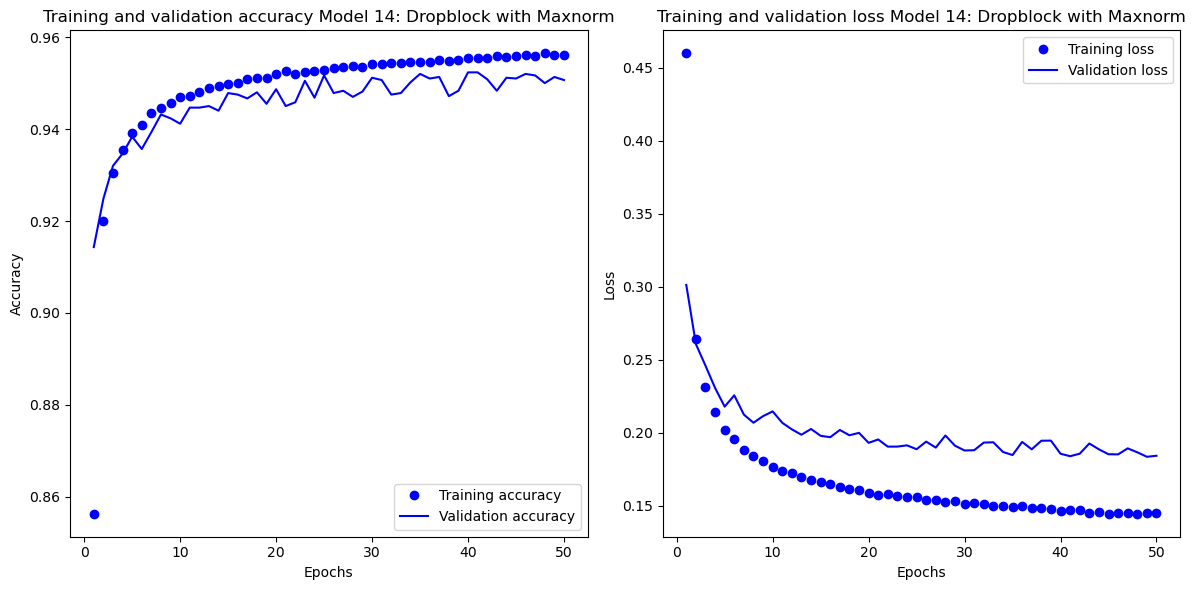

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import display_accuracy_loss

# Plot Training and validation Accuracy and loss.
display_accuracy_loss(model_14_maxnorm_history, 'Model 14: Dropblock with Maxnorm' )

Printing the training time history in cell below

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_model_times

# Print the model Training Time
display_model_times(model_14_maxnorm_time)

Total Time: 0:46:31.980669 Average Epoch Time: 0:00:55.839613


Load the best performing model that was trained and saved according to validation loss

In [ ]:
import importlib
import utils.DropBlock
importlib.reload(utils.DropBlock)
from utils.DropBlock import DropBlock2D

# Configure the path to save the model information
model_14_maxnorm_path = 'saved models/3. Model 3 DropBlock/maxnorm/'

# Load the best model saved during training based on validation loss
model_14_maxnorm_best = tf.keras.models.load_model(model_14_maxnorm_path  + "model_14_maxnorm_best.keras", {"DropBlock2D": DropBlock2D})

Evaluate the best performing model on the test dataset

In [ ]:
model_14_maxnorm_best.evaluate(test_dataset)

204/204 [==============================] - 1s 4ms/step - loss: 0.1606 - accuracy: 0.9583


[0.16061389446258545, 0.9583205580711365]

Model 14 achieves an accuracy of 95.83%

Plotting the confusion matrix to see how the model handle each digit classification

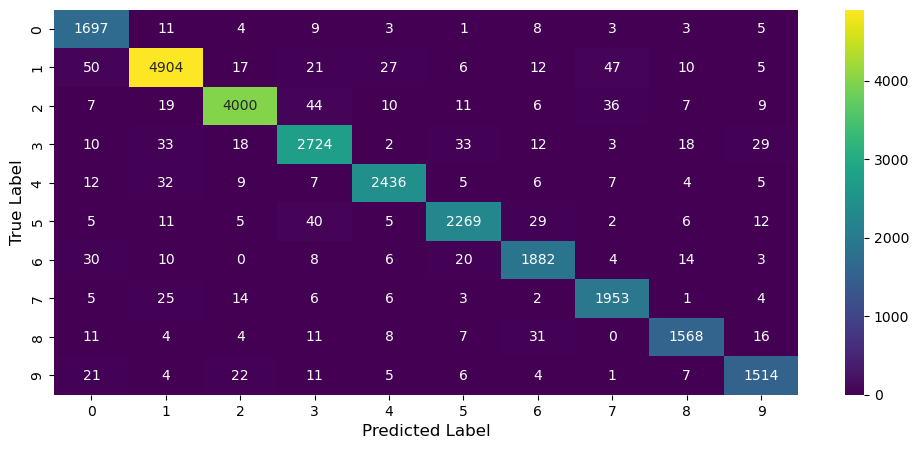

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import generate_confusion_matrix


dropout_aug_cm = generate_confusion_matrix(model_14_maxnorm_best, test_dataset)

## Model 13 & 14 Comparison

There is not much difference between the Maxnorm Curves and the Curves on the Bottleneck model. The validation and loss curves in are smoother than those in Bottleneck model. This might be because Maxnorm helps limit the weights, which makes training more stable.   

In the cell below, I am reloading the history and training time data for analysis

In [ ]:
model_13_maxnorm_path = 'saved models/2. Model 2 Dropout/maxnorm/'
model_14_maxnorm_path = 'saved models/3. Model 3 DropBlock/maxnorm/'

# Time
model_13_maxnorm_time = np.load(model_13_maxnorm_path + 'model_13_maxnorm_time.npy', allow_pickle=True)
model_14_maxnorm_time = np.load(model_14_maxnorm_path + 'model_14_maxnorm_time.npy', allow_pickle=True)

# History
model_13_maxnorm_history = np.load(model_13_maxnorm_path + 'model_13_maxnorm_history.npy', allow_pickle=True).item()
model_14_maxnorm_history = np.load(model_14_maxnorm_path + 'model_14_maxnorm_history.npy', allow_pickle=True).item()



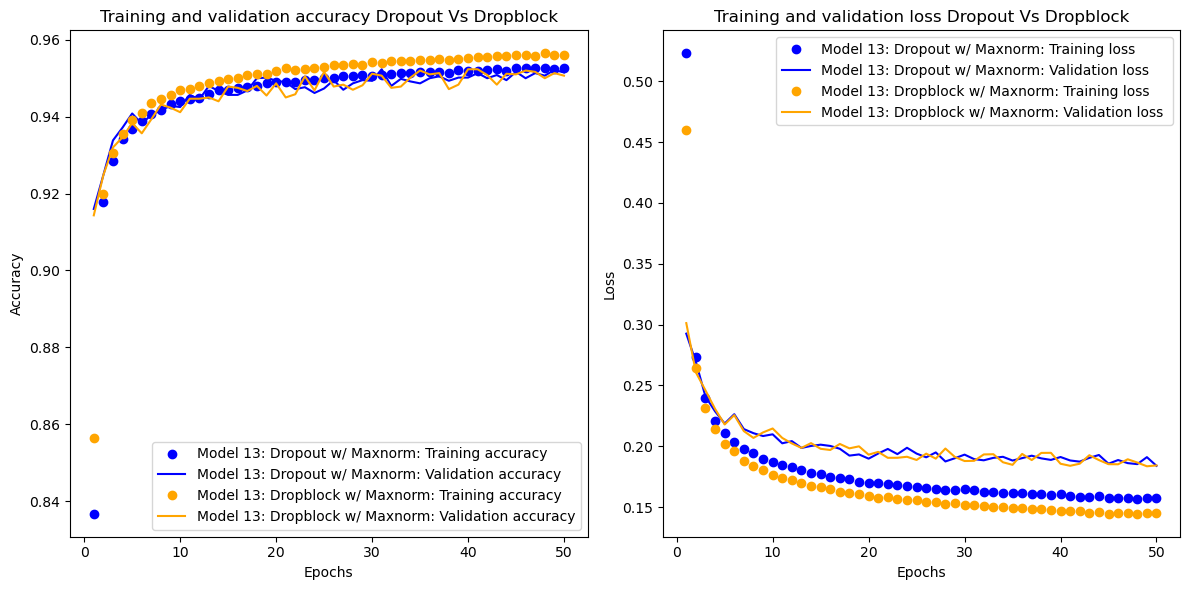

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import plot_accuracy_metric_comparison

import pandas as pd

# Load the model history into a dataframe
pd1 = pd.DataFrame(model_13_maxnorm_history)

# Load the model history into a dataframe
pd2 = pd.DataFrame(model_14_maxnorm_history)

# Plot the comparison Graphs
plot_accuracy_metric_comparison(pd1,'Model 13: Dropout w/ Maxnorm', pd2, 'Model 13: Dropblock w/ Maxnorm',  'Dropout Vs Dropblock')

The training time has increased from the bottleneck model most likely to the extra computational calculations per step.

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import compare_times

compare_times(model_13_maxnorm_time, model_14_maxnorm_time,reload=True)

Average Epoch      Total Time
Model                                  
Model_1  0:00:36.184380  0:30:09.218984
Model_2  0:00:55.839613  0:46:31.980669

Sparsity has not returned to the model due to Maxnorm, as dead neurones remain at 0. While Model 14 (DropBlock) displays a wider spread, indicating more varied neurone responses in early layers, Model 13 (Dropout) displays a more concentrated activation range close to 0–0.1.Middle to lower layers have more spread-out neuron activation in a higher range, less concentrated near 0. 

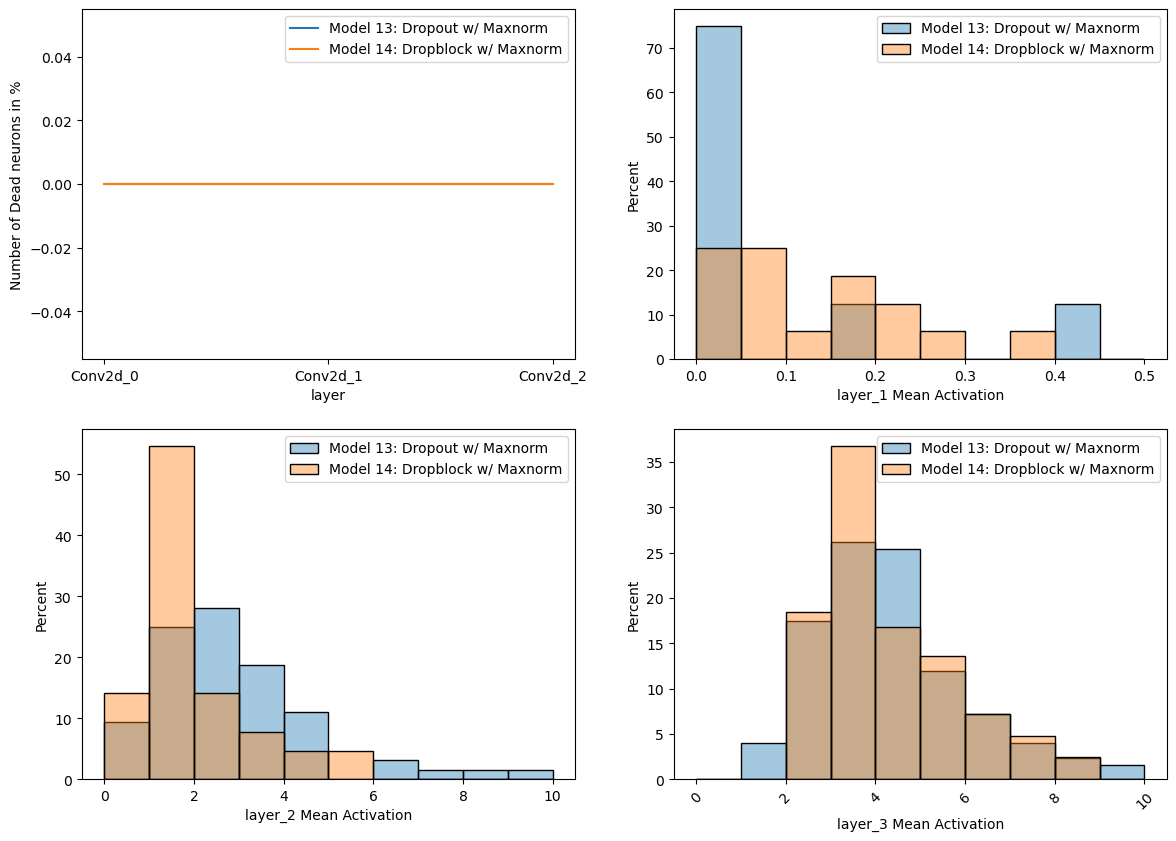

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_neurons_count, display_mean_activations

fig, axes = plt.subplots(2, 2, figsize=(14, 10))



display_neurons_count(model_13_maxnorm_best, test_dataset, ('Model 13: Dropout w/ Maxnorm', axes[0,0]) )
display_neurons_count(model_14_maxnorm_best, test_dataset, ('Model 14: Dropblock w/ Maxnorm', axes[0,0]) )

display_mean_activations(model_13_maxnorm_best, test_dataset, '1', 0, 0.5, 11, ('Model 13: Dropout w/ Maxnorm', axes[0,1]) )
display_mean_activations(model_14_maxnorm_best, test_dataset, '1',0, 0.5, 11, ('Model 14: Dropblock w/ Maxnorm', axes[0,1]) )

display_mean_activations(model_13_maxnorm_best, test_dataset, '2', 0, 10, 11, ('Model 13: Dropout w/ Maxnorm', axes[1,0]) )
display_mean_activations(model_14_maxnorm_best, test_dataset, '2', 0, 10, 11, ('Model 14: Dropblock w/ Maxnorm', axes[1,0]) )

display_mean_activations(model_13_maxnorm_best, test_dataset, '3', 0, 10, 11, ('Model 13: Dropout w/ Maxnorm', axes[1,1]) )
display_mean_activations(model_14_maxnorm_best, test_dataset, '3', 0, 10, 11,  ('Model 14: Dropblock w/ Maxnorm', axes[1,1]) )



The confusion matrix and the accuracy and loss curve still show that Dropout is not as good at classifying as Dropblock. 

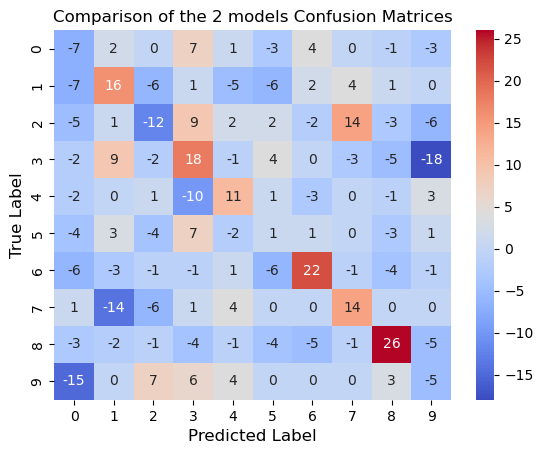

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import model_comparison_confusion_matrix

model_comparison_confusion_matrix(model_14_maxnorm_best, model_13_maxnorm_best, test_dataset )

# L2 Regularization

L2 Regularization was applied to the three convolutional layers and the two dense layers on top of the Maxnorm architecture in Model 13 & 14. A hyperparameter search was conducted. The l2_values search space is offers a nice balance of granularity and range and covers a logarithmic range

## Model 15: Dropout

In [ ]:
import keras
from keras import layers
from keras.constraints import MaxNorm
from keras.optimizers import Adam
from keras import regularizers

# L2 regularization values to search during hyperparameter tuning
l2_values = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3]  

# CNN model using Dropout, Batch Normalization, Bottleneck Dense layers,
# MaxNorm constraints, and L2 regularization with hyperparameter tuning
def model_15_relu_w_dropout_aug_batch_bottleneck_maxnorm_l2(hp):

    model = keras.Sequential()
    
    model.add(layers.InputLayer(input_shape=(32, 32, 3)))
    model.add(layers.Dropout(rate=0.25))

    # First convolutional block with MaxNorm and L2 regularization
    model.add(layers.Conv2D(32, kernel_size=(3, 3), strides=(1,1),
                             kernel_constraint=MaxNorm(4.0),
                             activation='relu',
                             kernel_regularizer=regularizers.L2(hp.Choice('l2_1',l2_values))))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    
    model.add(layers.Dropout(rate=0.5))

    # Second convolutional block with MaxNorm and L2
    model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=(1,1),
                             kernel_constraint=MaxNorm(3.75),
                             activation='relu',
                             kernel_regularizer=regularizers.L2(hp.Choice('l2_2',l2_values))))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    
    model.add(layers.Dropout(rate=0.25)) 

    # Third convolutional block with MaxNorm and L2
    model.add(layers.Conv2D(128,kernel_size=(3, 3), strides=(1,1), 
                             kernel_constraint=MaxNorm(3.75),
                             activation='relu',
                             kernel_regularizer=regularizers.L2(hp.Choice('l2_3',l2_values))))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    
    model.add(layers.Dropout(rate=0.25))

    model.add(layers.Flatten())

    # Bottleneck dense layer with MaxNorm and L2
    model.add(layers.Dense(64,
                        kernel_constraint=MaxNorm(3.0),
                        activation='relu',
                        kernel_regularizer=regularizers.L2(hp.Choice('l2_4',l2_values))))

    # Large dense layer with MaxNorm and L2
    model.add(layers.Dense(1024,
                           kernel_constraint=MaxNorm(4.0),
                           activation='relu',
                           kernel_regularizer=regularizers.L2(hp.Choice('l2_5',l2_values))))
               
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate=0.25))

    # Output layer for 10-class classification
    model.add(layers.Dense(10, activation='softmax')) 

    # Compile the model
    model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
    )
    return model   

Below, I am checking the model compiles correctly with the Keras tuner hyperparameters selection

In [ ]:
import keras_tuner

# Checking the Model compiles
model_15_relu_w_dropout_aug_batch_bottleneck_maxnorm_l2(keras_tuner.HyperParameters())

Below, I am setting up the search parameters for the hyperparameter search trials.

In [ ]:
import keras_tuner

# Create path for the hyperparameter trails
model_15_l2_path = 'saved models/2. Model 2 Dropout/l2/'

# Setup the hyperparameter search
tuner = keras_tuner.RandomSearch(
    hypermodel=model_15_relu_w_dropout_aug_batch_bottleneck_maxnorm_l2,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    overwrite=True,
    directory=model_15_l2_path,
    project_name="model_15_relu_w_dropout_aug_batch_bottleneck_maxnorm_l2",
)
tuner.search_space_summary()

Search space summary
Default search space size: 5
l2_1 (Choice)
{'default': 1e-06, 'conditions': [], 'values': [1e-06, 5e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005], 'ordered': True}
l2_2 (Choice)
{'default': 1e-06, 'conditions': [], 'values': [1e-06, 5e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005], 'ordered': True}
l2_3 (Choice)
{'default': 1e-06, 'conditions': [], 'values': [1e-06, 5e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005], 'ordered': True}
l2_4 (Choice)
{'default': 1e-06, 'conditions': [], 'values': [1e-06, 5e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005], 'ordered': True}
l2_5 (Choice)
{'default': 1e-06, 'conditions': [], 'values': [1e-06, 5e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005], 'ordered': True}


Below, I use EarlyStopping callback below to save time.  If validation accuracy does not improve after 5 epochs, the trial will end and move on.

 I'm also using the hyper_p_dataset, a subset of the complete dataset, and setting the trial epoch to 25.  This speeds up search and lets the model train for a number of epochs.

In [ ]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)

# Setup Earlystopping to stop the train when the validation loss doesn't improve
early_stop = [tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5)
]

# Configure search Parameters
tuner.search(
    aug_train_hyper_p_dataset,                                  # Training data and labels
    validation_data=(val_dataset),                              # Validation data and labels
    epochs=25,                                                  # Number of epochs
    class_weight=d_class_weights,                               # Adding Class Weights
    callbacks=[early_stop],                                     # Callbacks
    verbose=1                                                   # Verbosity mode (1 for progress bar)
)

Trial 20 Complete [00h 04m 12s]
val_accuracy: 0.9283333420753479

Best val_accuracy So Far: 0.940500020980835
Total elapsed time: 01h 52m 19s


Below cell, I am displaying the best model architecture found.

In [ ]:
# Get Top model configuration
models = tuner.get_best_models(num_models=1)
# Load top model configuration
best_model = models[0]
# Print summary of top model
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        1

Below Cell, I am just displaying all the trail results.

In [ ]:
# Display all results
tuner.results_summary()

Results summary
Results in saved models/2. Model 2 Dropout/l2/model_15_relu_w_dropout_aug_batch_bottleneck_maxnorm_l2
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 08 summary
Hyperparameters:
l2_1: 0.0005
l2_2: 1e-05
l2_3: 5e-05
l2_4: 5e-05
l2_5: 5e-06
Score: 0.940500020980835

Trial 03 summary
Hyperparameters:
l2_1: 1e-05
l2_2: 0.001
l2_3: 5e-05
l2_4: 1e-06
l2_5: 0.0001
Score: 0.9399999976158142

Trial 11 summary
Hyperparameters:
l2_1: 5e-06
l2_2: 0.0001
l2_3: 1e-06
l2_4: 1e-05
l2_5: 0.001
Score: 0.9388333559036255

Trial 16 summary
Hyperparameters:
l2_1: 1e-06
l2_2: 5e-06
l2_3: 0.0005
l2_4: 1e-06
l2_5: 1e-06
Score: 0.9366666674613953

Trial 13 summary
Hyperparameters:
l2_1: 0.0005
l2_2: 0.0005
l2_3: 0.0005
l2_4: 1e-06
l2_5: 1e-06
Score: 0.9365000128746033

Trial 15 summary
Hyperparameters:
l2_1: 0.0005
l2_2: 5e-05
l2_3: 5e-05
l2_4: 1e-06
l2_5: 0.005
Score: 0.9365000128746033

Trial 07 summary
Hyperparameters:
l2_1: 0.0005
l2_2: 5e-05
l2_3: 5e-06
l2_4: 

The top 5 search hyperparameters are loaded into a variable in the cell below.  I select the top congifuration and load the model with these values into a new variable.  The model will then be run on the entire training set.

In [ ]:
# Select the Top 5 performing hyperparameters configurations
best_hps = tuner.get_best_hyperparameters(5)

# Load a new model with the Top configuration
model_15_l2 = model_15_relu_w_dropout_aug_batch_bottleneck_maxnorm_l2(best_hps[0])

I am setting up the path to save the top-performing model for the model checkpoint callback in the cell below.  Providing the fit function two calls back that save the best model and record the training time.  The full training dataset and the validation set are used, along with the epoch rate and the class weighted dictionary.

In [ ]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)

# Configure the path to save the model information
model_15_l2_path = 'saved models/2. Model 2 Dropout/l2/'

# Call Modelcheckpoint to save the best model with the validation loss
best_model = [tf.keras.callbacks.ModelCheckpoint(
        filepath=model_15_l2_path  + "model_15_l2_best.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Record the training time of the model
model_15_l2_time = TimeHistory()

# Save model History and fit the model
model_15_l2_history = model_15_l2.fit(
    aug_train_dataset,                                  # Training data and labels
    validation_data=(val_dataset),                      # Validation data and labels
    epochs=50,                                          # Number of epochs
    class_weight=d_class_weights,                       # Adding Class Weights
    callbacks=[best_model, model_15_l2_time],           # Callbacks
    verbose=1                                           # Verbosity mode (1 for progress bar)
)

Epoch 1/50
4675/4675 [==============================] - 38s 7ms/step - loss: 0.5472 - accuracy: 0.8345 - val_loss: 0.3111 - val_accuracy: 0.9188
Epoch 2/50
4675/4675 [==============================] - 36s 7ms/step - loss: 0.3050 - accuracy: 0.9178 - val_loss: 0.3010 - val_accuracy: 0.9242
Epoch 3/50
4675/4675 [==============================] - 36s 7ms/step - loss: 0.2853 - accuracy: 0.9270 - val_loss: 0.2886 - val_accuracy: 0.9342
Epoch 4/50
4675/4675 [==============================] - 35s 7ms/step - loss: 0.2779 - accuracy: 0.9314 - val_loss: 0.2913 - val_accuracy: 0.9335
Epoch 5/50
4675/4675 [==============================] - 36s 7ms/step - loss: 0.2730 - accuracy: 0.9340 - val_loss: 0.2846 - val_accuracy: 0.9345
Epoch 6/50
4675/4675 [==============================] - 35s 7ms/step - loss: 0.2692 - accuracy: 0.9356 - val_loss: 0.2850 - val_accuracy: 0.9360
Epoch 7/50
4675/4675 [==============================] - 35s 7ms/step - loss: 0.2657 - accuracy: 0.9370 - val_loss: 0.2859 - val_ac

Saving the model information in the below cell

In [ ]:
import importlib
import utils.model_utils
importlib.reload(utils.model_utils)
from utils.model_utils import save_model_data

# Configure the path to save the model information
model_15_l2_path = 'saved models/2. Model 2 Dropout/l2/'

# Save model, model history and training time information
save_model_data(model_15_l2_path,
               model_15_l2,'model_15_l2',
               model_15_l2_history, 'model_15_l2_history',
               model_15_l2_time, 'model_15_l2_time'  )

I plot model accuracy and loss history in the cell below.

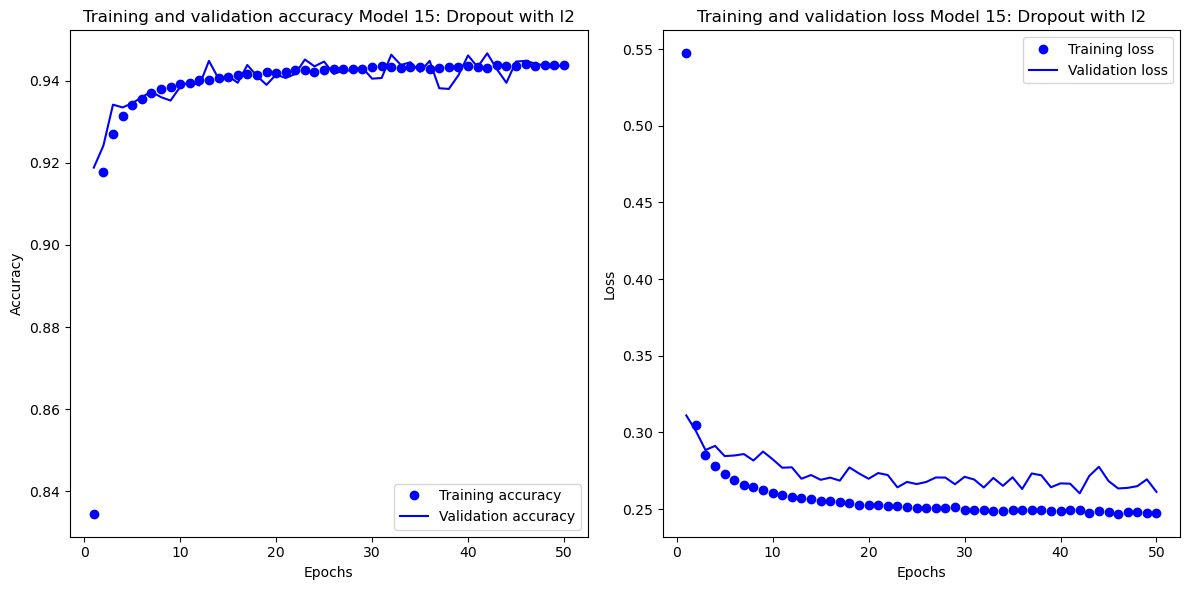

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import display_accuracy_loss

# Plot Training and validation Accuracy and loss.
display_accuracy_loss(model_15_l2_history, 'Model 15: Dropout with l2')

Printing the training time history in cell below

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_model_times

# Print the model Training Time
display_model_times(model_15_l2_time)

Total Time: 0:29:31.161204 Average Epoch Time: 0:00:35.423224


Load the best performing model that was trained and saved according to validation loss

In [ ]:
# Configure the path to save the model information
model_15_l2_path = 'saved models/2. Model 2 Dropout/l2/'

# Load the best model saved during training based on validation loss
model_15_l2_best = tf.keras.models.load_model(model_15_l2_path  + "model_15_l2_best.keras")

Evaluate the best performing model on the test dataset

In [ ]:
model_15_l2_best.evaluate(test_dataset)

204/204 [==============================] - 1s 6ms/step - loss: 0.2496 - accuracy: 0.9495


[0.24962083995342255, 0.9494852423667908]

Model 15 achieves an accuracy of 94.95%

Plotting the confusion matrix to see how the model handle each digit classification

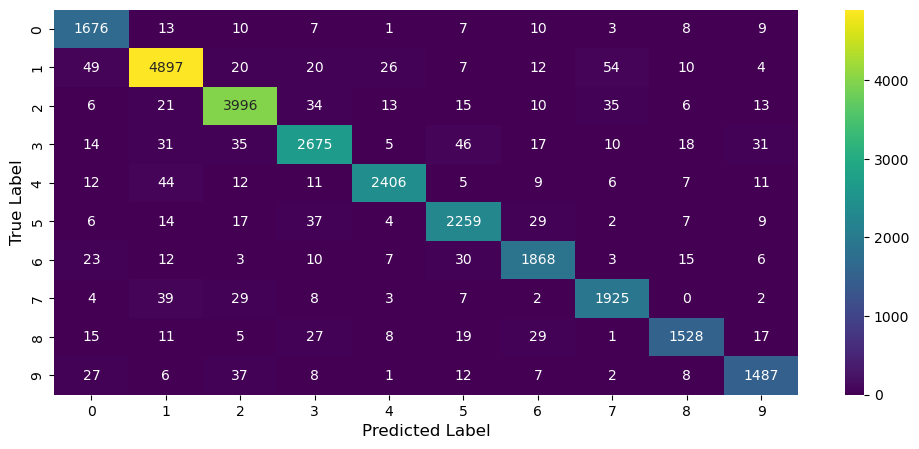

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import generate_confusion_matrix


dropout_aug_cm = generate_confusion_matrix(model_15_l2_best, test_dataset)

## Model 16: Dropblock

In [ ]:
import keras
from keras import layers
from keras.constraints import MaxNorm
from keras.optimizers import Adam

import importlib
import utils.DropBlock
importlib.reload(utils.DropBlock)
from utils.DropBlock import DropBlock2D
from keras import regularizers

# L2 regularization values to search during hyperparameter tuning
l2_values = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3]

# CNN model using Dropout, Batch Normalization, Bottleneck Dense layers,
# MaxNorm constraints, and L2 regularization with hyperparameter tuning
def model_16_relu_w_dropblock_aug_batch_bottleneck_maxnorm_l2(hp):

    model = keras.Sequential()
    
    model.add(layers.InputLayer(input_shape=(32, 32, 3)))
    model.add(DropBlock2D(rate=0.2, block_size=4))

    # First convolutional block with MaxNorm and L2 regularization
    model.add(layers.Conv2D(32, kernel_size=(3, 3), strides=(1,1),
                            kernel_constraint=MaxNorm(3.5),
                            activation='relu',
                            kernel_regularizer=regularizers.L2(hp.Choice('l2_1',l2_values))))
    model.add(layers.BatchNormalization())
    model.add(DropBlock2D(rate=0.3, block_size=2))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    
    
    # Second convolutional block with MaxNorm and L2
    model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=(1,1),
                            kernel_constraint=MaxNorm(4.0),
                            activation='relu',
                            kernel_regularizer=regularizers.L2(hp.Choice('l2_2',l2_values))))
    model.add(layers.BatchNormalization())
    model.add(DropBlock2D(rate=0.2, block_size=4))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    

    # Third convolutional block with MaxNorm and L2
    model.add(layers.Conv2D(128,kernel_size=(3, 3), strides=(1,1),
                            kernel_constraint=MaxNorm(3.25),
                            activation='relu',
                            kernel_regularizer=regularizers.L2(hp.Choice('l2_3',l2_values))))
    model.add(layers.BatchNormalization())
    model.add(DropBlock2D(rate=0.2, block_size=4))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))    


    model.add(layers.Flatten())

    # Bottleneck dense layer with MaxNorm and L2
    model.add(layers.Dense(64,
                        kernel_constraint=MaxNorm(3.0),
                        activation='relu',
                        kernel_regularizer=regularizers.L2(hp.Choice('l2_4',l2_values))))
    
    # Large dense layer with MaxNorm and L2
    model.add(layers.Dense(512,
                           kernel_constraint=MaxNorm(3.0),
                           activation='relu',
                           kernel_regularizer=regularizers.L2(hp.Choice('l2_5',l2_values))))
    model.add(layers.BatchNormalization())

    # Output layer for 10-class classification
    model.add(layers.Dense(10, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
    )
    return model    

Below, I am checking the model compiles correctly with the Keras tuner hyperparameters selection

In [ ]:
import keras_tuner

# Checking the Model compiles
model_16_relu_w_dropblock_aug_batch_bottleneck_maxnorm_l2(keras_tuner.HyperParameters())

Below, I am setting up the search parameters for the hyperparameter search trials.

In [ ]:
import keras_tuner

# Create path for the hyperparameter trails
model_16_l2_path = 'saved models/3. Model 3 DropBlock/l2/'

# Setup the hyperparameter search
tuner = keras_tuner.RandomSearch(
    hypermodel=model_16_relu_w_dropblock_aug_batch_bottleneck_maxnorm_l2,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    overwrite=True,
    directory=model_16_l2_path,
    project_name="model_16_relu_w_dropblock_aug_batch_bottleneck_maxnorm_l2_hyper_p",
)
tuner.search_space_summary()

Search space summary
Default search space size: 5
l2_1 (Choice)
{'default': 1e-06, 'conditions': [], 'values': [1e-06, 5e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005], 'ordered': True}
l2_2 (Choice)
{'default': 1e-06, 'conditions': [], 'values': [1e-06, 5e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005], 'ordered': True}
l2_3 (Choice)
{'default': 1e-06, 'conditions': [], 'values': [1e-06, 5e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005], 'ordered': True}
l2_4 (Choice)
{'default': 1e-06, 'conditions': [], 'values': [1e-06, 5e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005], 'ordered': True}
l2_5 (Choice)
{'default': 1e-06, 'conditions': [], 'values': [1e-06, 5e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005], 'ordered': True}


Below, I use EarlyStopping callback below to save time.  If validation accuracy does not improve after 5 epochs, the trial will end and move on.

 I'm also using the hyper_p_dataset, a subset of the complete dataset, and setting the trial epoch to 25.  This speeds up search and lets the model train for a number of epochs.

In [ ]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)

# Setup Earlystopping to stop the train when the validation loss doesn't improve
early_stop = [tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5)
]
# Configure search Parameters
tuner.search(
    aug_train_hyper_p_dataset,                                  # Training data and labels
    validation_data=(val_dataset),                              # Validation data and labels
    epochs=25,                                                  # Number of epochs
    class_weight=d_class_weights,                               # Adding Class Weights
    callbacks=[early_stop],                                     # Callbacks
    verbose=1                                                   # Verbosity mode (1 for progress bar)
)

Trial 20 Complete [00h 08m 04s]
val_accuracy: 0.9283333420753479

Best val_accuracy So Far: 0.9431666731834412
Total elapsed time: 02h 08m 32s


Below cell, I am displaying the best model architecture found.

In [ ]:
# Get Top model configuration
models = tuner.get_best_models(num_models=1)
# Load top model configuration
best_model = models[0]
# Print summary of top model
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 drop_block2d (DropBlock2D)  (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 drop_block2d_1 (DropBlock2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                        

Below Cell, I am just displaying all the trail results.

In [ ]:
# Display all results
tuner.results_summary()

Results summary
Results in saved models/3. Model 3 DropBlock/l2/model_16_relu_w_dropblock_aug_batch_bottleneck_maxnorm_l2_hyper_p
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 04 summary
Hyperparameters:
l2_1: 5e-06
l2_2: 1e-06
l2_3: 5e-06
l2_4: 1e-06
l2_5: 0.0001
Score: 0.9431666731834412

Trial 09 summary
Hyperparameters:
l2_1: 1e-05
l2_2: 5e-06
l2_3: 0.0005
l2_4: 1e-05
l2_5: 1e-06
Score: 0.9413333535194397

Trial 14 summary
Hyperparameters:
l2_1: 5e-05
l2_2: 0.0001
l2_3: 5e-06
l2_4: 1e-06
l2_5: 0.0001
Score: 0.9409999847412109

Trial 13 summary
Hyperparameters:
l2_1: 1e-05
l2_2: 1e-05
l2_3: 5e-06
l2_4: 0.0001
l2_5: 5e-05
Score: 0.940833330154419

Trial 10 summary
Hyperparameters:
l2_1: 0.001
l2_2: 1e-06
l2_3: 5e-06
l2_4: 5e-06
l2_5: 0.005
Score: 0.9384999871253967

Trial 15 summary
Hyperparameters:
l2_1: 0.0001
l2_2: 0.0001
l2_3: 0.0001
l2_4: 0.0005
l2_5: 0.005
Score: 0.9359999895095825

Trial 07 summary
Hyperparameters:
l2_1: 0.001
l2_2: 0.0005
l2_3:

The top 5 search hyperparameters are loaded into a variable in the cell below.  I select the top congifuration and load the model with these values into a new variable.  The model will then be run on the entire training set.

In [ ]:
# Select the Top 5 performing hyperparameters configurations
best_hps = tuner.get_best_hyperparameters(5)

# Load a new model with the Top configuration
model_16_l2 = model_16_relu_w_dropblock_aug_batch_bottleneck_maxnorm_l2(best_hps[0])

I am setting up the path to save the top-performing model for the model checkpoint callback in the cell below.  Providing the fit function two calls back that save the best model and record the training time.  The full training dataset and the validation set are used, along with the epoch rate and the class weighted dictionary.

In [ ]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)
from keras.optimizers import Adam

# Configure the path to save the model information
model_16_l2_path = 'saved models/3. Model 3 DropBlock/l2/'

# Call Modelcheckpoint to save the best model with the validation loss
best_model = [tf.keras.callbacks.ModelCheckpoint(
        filepath=model_16_l2_path  + "model_16_l2_best.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Record the training time of the model
model_16_l2_time = TimeHistory()

# Save model History and fit the model
model_16_l2_history = model_16_l2.fit(
    aug_train_dataset,                                  # Training data and labels
    validation_data=(val_dataset),                      # Validation data and labels
    epochs=50,                                          # Number of epochs
    class_weight=d_class_weights,                       # Adding Class Weights
    callbacks=[best_model, model_16_l2_time],           # Callbacks
    verbose=1                                           # Verbosity mode (1 for progress bar)
)

Epoch 1/50
4675/4675 [==============================] - 53s 10ms/step - loss: 0.4822 - accuracy: 0.8534 - val_loss: 0.2916 - val_accuracy: 0.9220
Epoch 2/50
4675/4675 [==============================] - 52s 10ms/step - loss: 0.2831 - accuracy: 0.9189 - val_loss: 0.2644 - val_accuracy: 0.9298
Epoch 3/50
4675/4675 [==============================] - 52s 10ms/step - loss: 0.2533 - accuracy: 0.9291 - val_loss: 0.2556 - val_accuracy: 0.9327
Epoch 4/50
4675/4675 [==============================] - 52s 10ms/step - loss: 0.2390 - accuracy: 0.9335 - val_loss: 0.2478 - val_accuracy: 0.9378
Epoch 5/50
4675/4675 [==============================] - 52s 10ms/step - loss: 0.2283 - accuracy: 0.9372 - val_loss: 0.2435 - val_accuracy: 0.9383
Epoch 6/50
4675/4675 [==============================] - 52s 10ms/step - loss: 0.2225 - accuracy: 0.9395 - val_loss: 0.2390 - val_accuracy: 0.9407
Epoch 7/50
4675/4675 [==============================] - 52s 10ms/step - loss: 0.2182 - accuracy: 0.9405 - val_loss: 0.2313 -

Saving the model information in the below cell

In [ ]:
import importlib
import utils.model_utils
importlib.reload(utils.model_utils)
from utils.model_utils import save_model_data

# Configure the path to save the model information
model_16_l2_path = 'saved models/3. Model 3 DropBlock/l2/'

# Save model, model history and training time information
save_model_data(model_16_l2_path,
               model_16_l2,'model_16_l2',
               model_16_l2_history, 'model_16_l2_history',
               model_16_l2_time, 'model_16_l2_time'  )

I plot model accuracy and loss history in the cell below.

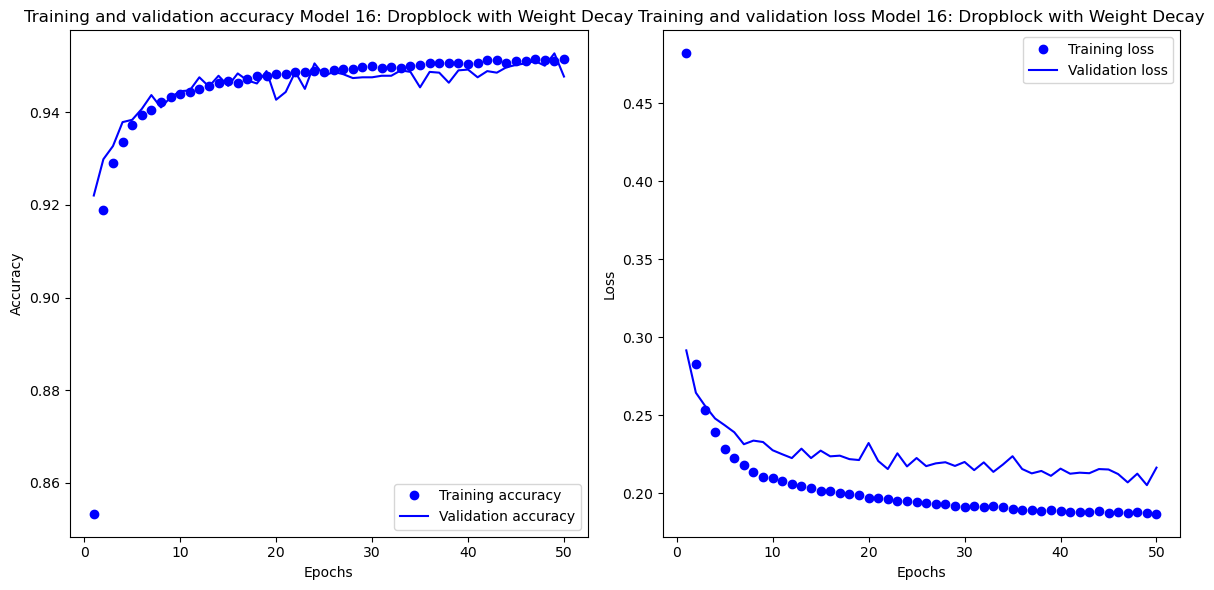

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import display_accuracy_loss

# Plot Training and validation Accuracy and loss.
display_accuracy_loss(model_16_l2_history, 'Model 16: Dropblock with Weight Decay' )

Printing the training time history in cell below

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_model_times

# Print the model Training Time
display_model_times(model_16_l2_time)

Total Time: 0:43:15.417714 Average Epoch Time: 0:00:51.908354


Load the best performing model that was trained and saved according to validation loss

In [ ]:
# Configure the path to save the model information
model_16_l2_path = 'saved models/3. Model 3 DropBlock/l2/'

# Load the best model saved during training based on validation loss
model_16_l2_best = tf.keras.models.load_model(model_16_l2_path   + "model_16_l2_best.keras", custom_objects={'DropBlock2D': DropBlock2D})

Evaluate the best performing model on the test dataset

In [ ]:
model_16_l2_best.evaluate(test_dataset)

204/204 [==============================] - 1s 4ms/step - loss: 0.1994 - accuracy: 0.9523


[0.19938182830810547, 0.9523279070854187]

Model 16 achieves an accuracy of 95.23%

Plotting the confusion matrix to see how the model handle each digit classification

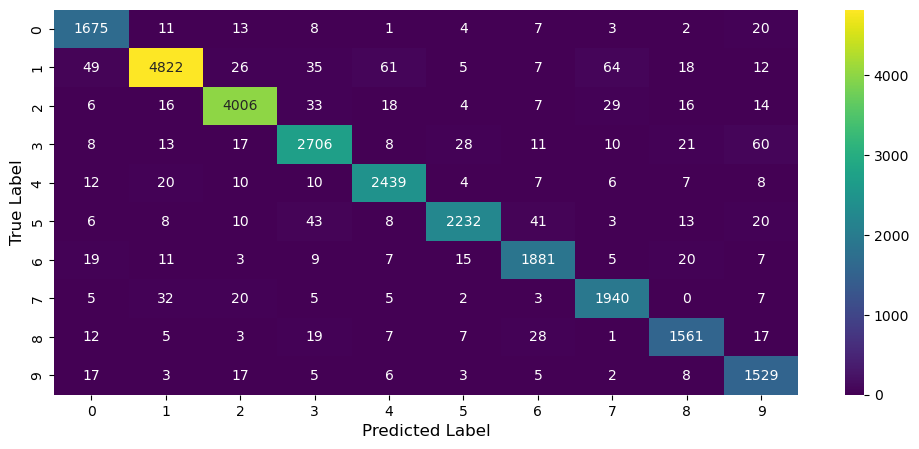

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import generate_confusion_matrix


dropout_aug_cm = generate_confusion_matrix(model_16_l2_best, test_dataset)

## Model 15 & 16 Comparison

The graph shows that applying L2 regularization on top of Max-Norm has reduced the performance of both models compared to Model 13 & 14 with Dropout seeing a larger drop. The drop in test accuracy could be due to over-regularising the model. The flatter training and validation curves also suggest this, as L2 regularisation penalises large weights and slows learning.

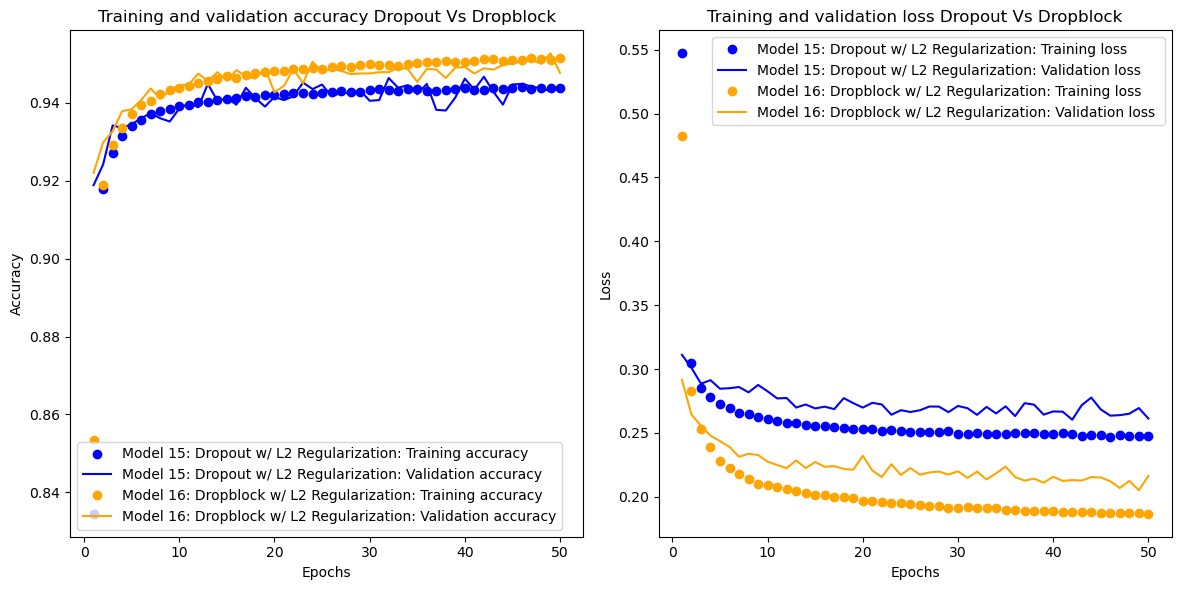

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import plot_accuracy_metric_comparison
import pandas as pd

# Load the model history into a dataframe
pd1 = pd.DataFrame(model_15_l2_history.history)

# Load the model history into a dataframe
pd2 = pd.DataFrame(model_16_l2_history.history)

# Plot the comparison Graphs
plot_accuracy_metric_comparison(pd1,'Model 15: Dropout w/ L2 Regularization', pd2, 'Model 16: Dropblock w/ L2 Regularization',  'Dropout Vs Dropblock')

Training times for both models 15 & 16 decreased slightly compared to Models 13 and 14. This could be as a result of L2 regularisation, which can lower computational overhead and stabilise convergence by limiting the size of the weights.

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import compare_times

compare_times(model_15_l2_time, model_16_l2_time)

Average Epoch      Total Time
Model                                  
Model_1  0:00:35.423224  0:29:31.161204
Model_2  0:00:51.908354  0:43:15.417714

Sparsity has not returned to the model due to L2 regularization, as dead neurones remain at 0. Compared to Model 13 & 14 the neuron activations shows more activativity clustered near zero for the middle to deeper layers, resulting in a narrower range of activation. As a result, fewer stronger neurons are firing. The affects of the L2 regularization can be seen in the activations as the penalizing of the weights has leads to weaker more uniform activations.

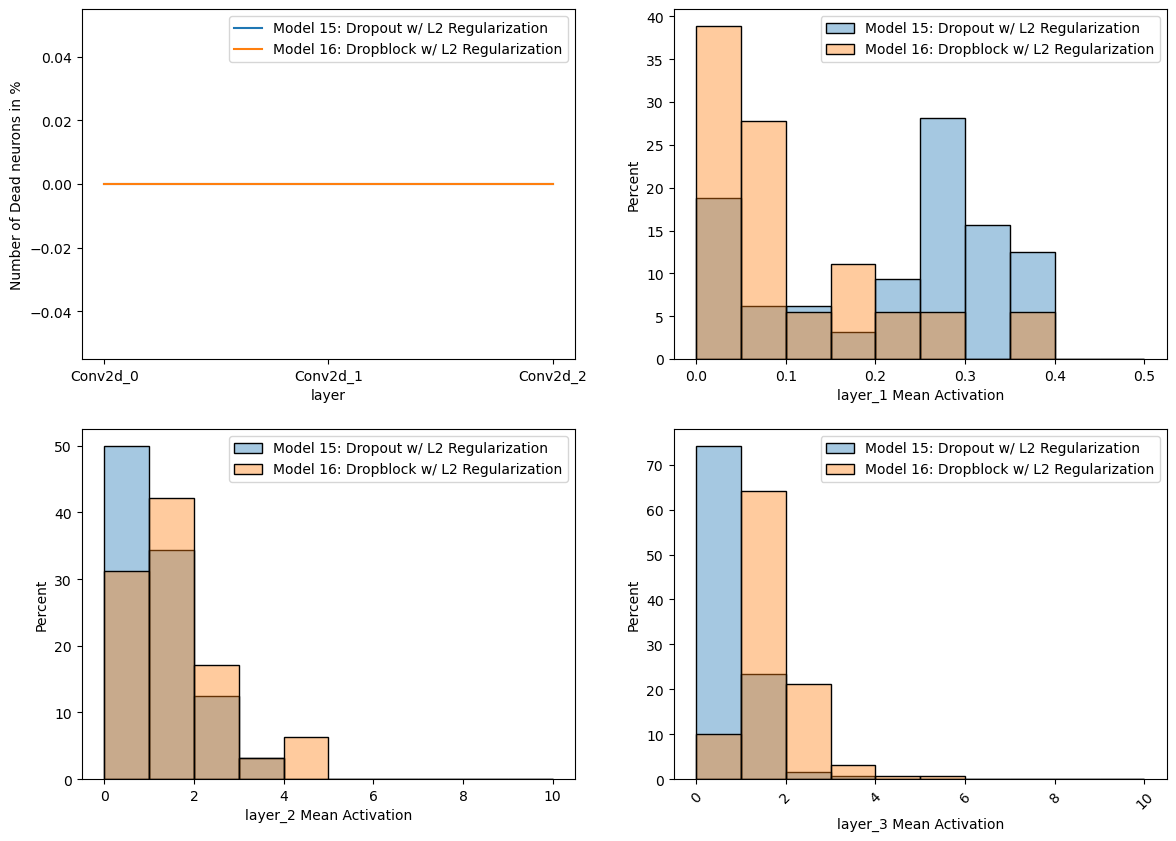

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_neurons_count, display_mean_activations

fig, axes = plt.subplots(2, 2, figsize=(14, 10))



display_neurons_count(model_15_l2_best, test_dataset, ('Model 15: Dropout w/ L2 Regularization', axes[0,0]) )
display_neurons_count(model_16_l2_best, test_dataset, ('Model 16: Dropblock w/ L2 Regularization', axes[0,0]) )

display_mean_activations(model_15_l2_best, test_dataset, '1', 0, 0.5, 11, ('Model 15: Dropout w/ L2 Regularization', axes[0,1]) )
display_mean_activations(model_16_l2_best, test_dataset, '1',0, 0.5, 11, ('Model 16: Dropblock w/ L2 Regularization', axes[0,1]) )

display_mean_activations(model_15_l2_best, test_dataset, '2', 0, 10, 11, ('Model 15: Dropout w/ L2 Regularization', axes[1,0]) )
display_mean_activations(model_16_l2_best, test_dataset, '2', 0, 10, 11, ('Model 16: Dropblock w/ L2 Regularization', axes[1,0]) )

display_mean_activations(model_15_l2_best, test_dataset, '3', 0, 10, 11, ('Model 15: Dropout w/ L2 Regularization', axes[1,1]) )
display_mean_activations(model_16_l2_best, test_dataset, '3', 0, 10, 11,  ('Model 16: Dropblock w/ L2 Regularization', axes[1,1]) )



Despite the drop in accuracy of around 0.5% for both, Dropblock still outperforms Dropout in correct classifications 

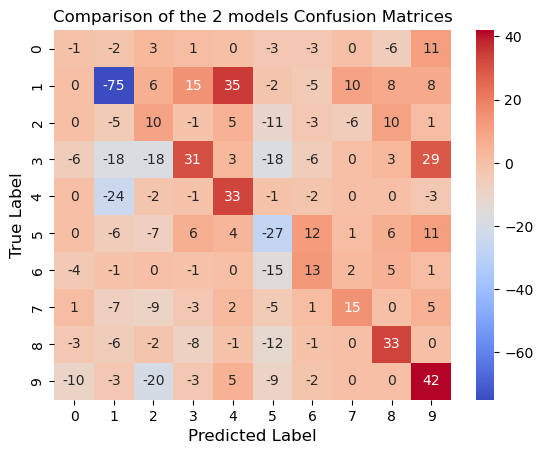

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import model_comparison_confusion_matrix

model_comparison_confusion_matrix(model_16_l2_best, model_15_l2_best, test_dataset )

In [ ]:
Stop Here !

SyntaxError: invalid syntax (3194995719.py, line 1)

# Learning Rate

## Model 17: Dropout

I used the one cycle learning rate approach proposed in "A disciplined approach to neural network hyper-parameters" to train the network. I ran a pre-training learning rate range test to find the maximum learning rate. This involved starting with a small learning rate and gradually increasing it over 25 epochs. I then plotted the training loss against the learning rate to find where the model started to overfit—this point was taken as the upper bound. From there, I set the minimum learning rate to be 20× smaller. Using these values, I applied the one cycle learning rate policy over 50 epochs. The learning rate increases linearly from the minimum to the maximum over the first 25 epochs, then decreases back down over the final 25. This approach helps the model take large steps early on to explore the loss landscape, then fine-tunes with smaller step s toward the end

I will be finding the learning rate using models 15 best hyperparameters found.

In [ ]:
import keras_tuner

# Create path for the hyperparameter trails
model_15_l2_path = 'saved models/2. Model 2 Dropout/l2/'

# Reload the hyperparameter search trails
reload_tuner = keras_tuner.RandomSearch(
    hypermodel=model_15_relu_w_dropout_aug_batch_bottleneck_maxnorm_l2,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    overwrite=False,
    directory=model_15_l2_path,
    project_name="model_15_relu_w_dropout_aug_batch_bottleneck_maxnorm_l2",
)
reload_tuner.search_space_summary()

Reloading Tuner from saved models/2. Model 2 Dropout/l2/model_15_relu_w_dropout_aug_batch_bottleneck_maxnorm_l2\tuner0.json
Search space summary
Default search space size: 5
l2_1 (Choice)
{'default': 1e-06, 'conditions': [], 'values': [1e-06, 5e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005], 'ordered': True}
l2_2 (Choice)
{'default': 1e-06, 'conditions': [], 'values': [1e-06, 5e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005], 'ordered': True}
l2_3 (Choice)
{'default': 1e-06, 'conditions': [], 'values': [1e-06, 5e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005], 'ordered': True}
l2_4 (Choice)
{'default': 1e-06, 'conditions': [], 'values': [1e-06, 5e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005], 'ordered': True}
l2_5 (Choice)
{'default': 1e-06, 'conditions': [], 'values': [1e-06, 5e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005], 'ordered': True}


### LR Range test

Here, I will focus on find the maximum learning rate value.

In [ ]:
# Select the Top 5 performing hyperparameters configurations
best_hps = reload_tuner.get_best_hyperparameters(5)

# Load a new model with the Top configuration
model_17_lr_range_test = model_15_relu_w_dropout_aug_batch_bottleneck_maxnorm_l2(best_hps[0])

In [ ]:
# Print a summary of the model architecture
model_17_lr_range_test.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 32, 32, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_8 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)       

Below, sets up a learning rate range test using a 1-cycle policy with a cyclical learning rate schedule. It trains the model from a very low learning rate to a high one over 25 epochs, helping identify the optimal learning rate by observing how the loss changes across this range. Custom callbacks record learning rate history and handle early stopping if needed.

In [ ]:
import importlib
import utils.keras_callback
importlib.reload(utils.keras_callback)
from utils.keras_callback import TimeHistory, CLR_history, stop_model
from keras.optimizers import Adam
import tensorflow_addons as tfa
import math

# Initial and Max LR wide enough range to explore learning dynamics
INIT_LR = 1e-5
MAX_LR = 4e-1

# Maximum Epoch count
epoch_count = 50

# Calculate the number of steps per epoch based on training dataset size and batch size
steps_per_epoch = math.ceil(len(X_train_normalized) / BATCH_SIZE)

# Define a cyclical learning rate schedule (1-cycle policy)
# For more info on scale_fn: https://stackoverflow.com/questions/67656969/what-does-tensorflows-cyclicallearningrate-scale-fn-argument-mean
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,    # Starting LR
    maximal_learning_rate=MAX_LR,                                           # Peak LR    
    scale_fn=lambda x: 1.0,                                                 # Keep the LR constant within each half-cycle             
    step_size=(steps_per_epoch * epoch_count) / 2                           # Only run for 25 Epochs/ Half a cycle
)

# Apply CLR to the Adam optimizer
optimizer = Adam(clr)

# Compile the model using categorical crossentropy for classification
model_17_lr_range_test.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy']
    )


# Instantiate callback to track learning rate and loss history during training
model_17_lr_range_test_clr_history = CLR_history()

# Instantiate custom early stopping callback after 25 epochs
stop_model_training = stop_model()

# Train the model with the CLR and early stopping callbacks
model_17_lr_range_test_history = model_17_lr_range_test.fit(
    aug_train_dataset,                                                              # Training data and labels
    validation_data=(val_dataset),                                                  # Validation data and labels
    epochs=epoch_count,                                                             # Number of epochs
    class_weight=d_class_weights,                                                   # Adding Class Weights
    callbacks=[ model_17_lr_range_test_clr_history, stop_model_training],           # Callbacks
    verbose=1                                                                       # Verbosity mode (1 for progress bar)
)

Epoch 1/50
4675/4675 [==============================] - 40s 7ms/step - loss: 0.6940 - accuracy: 0.8056 - val_loss: 0.5782 - val_accuracy: 0.8808
Epoch 2/50
4675/4675 [==============================] - 40s 7ms/step - loss: 0.9353 - accuracy: 0.8253 - val_loss: 1.1320 - val_accuracy: 0.7942
Epoch 3/50
4675/4675 [==============================] - 37s 7ms/step - loss: 1.3337 - accuracy: 0.7740 - val_loss: 1.3143 - val_accuracy: 0.7883
Epoch 4/50
4675/4675 [==============================] - 38s 7ms/step - loss: 1.5607 - accuracy: 0.7363 - val_loss: 1.7790 - val_accuracy: 0.6912
Epoch 5/50
4675/4675 [==============================] - 37s 7ms/step - loss: 1.7523 - accuracy: 0.7037 - val_loss: 1.9543 - val_accuracy: 0.6622
Epoch 6/50
4675/4675 [==============================] - 37s 7ms/step - loss: 1.8894 - accuracy: 0.6788 - val_loss: 1.8234 - val_accuracy: 0.6872
Epoch 7/50
4675/4675 [==============================] - 38s 7ms/step - loss: 2.4820 - accuracy: 0.6758 - val_loss: 1.8329 - val_ac

Below, I am saving the Pre trail run Model  histroy information

In [ ]:
# Save LR Range Test model 11

model_17_lr_range_test_path = 'saved models/2. model 2 dropout/lr/'
np.save(model_17_lr_range_test_path + 'model_17_lr_range_test_losses' + '.npy', model_17_lr_range_test_clr_history.losses)
np.save(model_17_lr_range_test_path + 'model_17_lr_range_test_accuracy' + '.npy', model_17_lr_range_test_clr_history.accuracy)

Below, I am loading the Pre-training run history informaiton

In [ ]:
# History
model_17_lr_range_test_loss = np.load(model_17_lr_range_test_path + 'model_17_lr_range_test_losses.npy', allow_pickle=True)


Checking at which point the curve is the lowest before it overfits

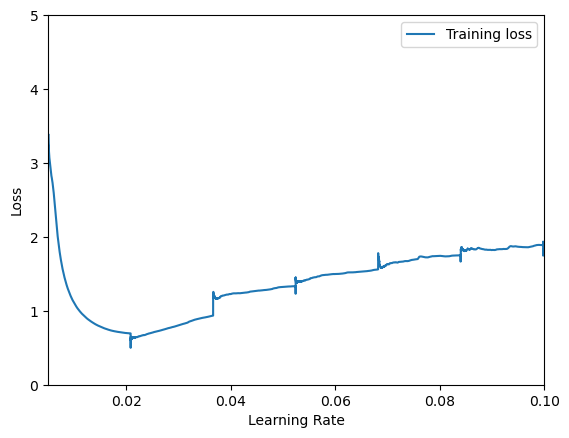

In [ ]:
import matplotlib.pyplot as plt

# Calculate number of steps per epoch based on dataset size and batch size
steps_per_epoch = math.ceil(len(X_train_normalized) / BATCH_SIZE)

# Create a range of step indices covering half a 1-cycle policy (increasing LR then decreasing)
step = np.arange(0, (50 * steps_per_epoch) /2)

# Define initial and maximum learning rates for the 1-cycle learning rate schedule
INIT_LR = 5e-3
MAX_LR = 4e-1
epoch_count = 50

# Define cyclical learning rate schedule (constant scale function)
# For more info on scale_fn: https://stackoverflow.com/questions/67656969/what-does-tensorflows-cyclicallearningrate-scale-fn-argument-mean
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1.0,               #
    step_size=(steps_per_epoch * epoch_count) / 2            # 1 Cycle
)

# Get learning rate values over the defined step range
lr = clr(step)

# Plot training loss against learning rate to identify optimal LR
plt.plot(lr,model_17_lr_range_test_loss   , "-", label="Training loss")

# Limit axes for better zoom/focus on the useful LR range
plt.ylim([0, 5])
plt.xlim([0.005, 0.1])

# Label the plot
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.legend()



The max Lr Rate identified in the above graph is around 0.02

### 1 Cycle test

Reload Model 15 Parameters value for training with the 1 Cycle policy.

In [ ]:
# Select the Top 5 performing hyperparameters configurations
best_hps = reload_tuner.get_best_hyperparameters(5)

# Load a new model with the Top configuration
model_17_lr_range_1_cycle = model_15_relu_w_dropout_aug_batch_bottleneck_maxnorm_l2(best_hps[0])

Idenitify the minimum learning rate using factor 10 or 20

In [ ]:
import importlib
import utils.keras_callback
importlib.reload(utils.keras_callback)
from utils.keras_callback import TimeHistory, CLR_history, stop_model
from keras.optimizers import Adam
import tensorflow_addons as tfa
import math

# Define the maximum and initial learning rates for 1-cycle schedule
MAX_LR = 2e-2
INIT_LR = 1e-3

# Number of epochs to train for
epoch_count = 50

# Calculate the number of steps per epoch based on training dataset size and batch size
steps_per_epoch = math.ceil(len(X_train_normalized) / BATCH_SIZE)

# Define a flat scale function for cyclical learning rate (no decay)
def scale_fn(x):
    return 1.0

# Create cyclical learning rate schedule (1-cycle policy)
# For more info on scale_fn: https://stackoverflow.com/questions/67656969/what-does-tensorflows-cyclicallearningrate-scale-fn-argument-mean
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=scale_fn,
    step_size=(steps_per_epoch * epoch_count) / 2            # Full 1-cycle spans 50 epochs
)

# Wrap CLR into the Adam optimizer
optimizer = Adam(clr)

# Compile the model with Adam optimizer and categorical crossentropy for classification
model_17_lr_range_1_cycle.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy']
    )


# Callback to track the learning rate and loss history
model_17_lr_range_1_cycle_clr_history = CLR_history()

# Callback to track total training time
model_17_lr_range_1_cycle_time = TimeHistory()

# Define file path to save the best model
model_17_lr_range_1_cycle_path = 'saved models/2. model 2 dropout/lr/'

# Callback to save the model with the lowest validation loss
best_model = [tf.keras.callbacks.ModelCheckpoint(
        filepath=model_17_lr_range_1_cycle_path  + "model_17_lr_range_1_cycle_best.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Train the model using augmented data and the 1-cycle learning rate schedule
model_17_lr_range_1_cycle_history = model_17_lr_range_1_cycle.fit(
    aug_train_dataset,                                                                                  # Training data and labels
    validation_data=(val_dataset),                                                                      # Validation data and labels
    epochs=epoch_count,                                                                                 # Number of epochs
    class_weight=d_class_weights,                                                                       # Adding Class Weights
    callbacks=[ best_model, model_17_lr_range_1_cycle_clr_history, model_17_lr_range_1_cycle_time],     # Callbacks
    verbose=1                                                                                           # Verbosity mode (1 for progress bar)
)

Epoch 1/50
4675/4675 [==============================] - 46s 9ms/step - loss: 0.5379 - accuracy: 0.8392 - val_loss: 0.3389 - val_accuracy: 0.9138
Epoch 2/50
4675/4675 [==============================] - 55s 10ms/step - loss: 0.3512 - accuracy: 0.9111 - val_loss: 0.3622 - val_accuracy: 0.9175
Epoch 3/50
4675/4675 [==============================] - 58s 10ms/step - loss: 0.3771 - accuracy: 0.9149 - val_loss: 0.3772 - val_accuracy: 0.9225
Epoch 4/50
4675/4675 [==============================] - 58s 10ms/step - loss: 0.4068 - accuracy: 0.9137 - val_loss: 0.4307 - val_accuracy: 0.9118
Epoch 5/50
4675/4675 [==============================] - 55s 9ms/step - loss: 0.4408 - accuracy: 0.9087 - val_loss: 0.4477 - val_accuracy: 0.9138
Epoch 6/50
4675/4675 [==============================] - 56s 9ms/step - loss: 0.4714 - accuracy: 0.9038 - val_loss: 0.4662 - val_accuracy: 0.9073
Epoch 7/50
4675/4675 [==============================] - 55s 9ms/step - loss: 0.4963 - accuracy: 0.9001 - val_loss: 0.5494 - val

Saving the model information in the below cell

In [ ]:
import importlib
import utils.model_utils
importlib.reload(utils.model_utils)
from utils.model_utils import save_model_data

# Configure the path to save the model information
model_17_lr_range_1_cycle_path = 'saved models/2. model 2 dropout/lr/'

# Save model, model history and training time information
save_model_data(model_17_lr_range_1_cycle_path,
               model_17_lr_range_1_cycle,'model_17_lr_range_1_cycle',
               model_17_lr_range_1_cycle_history, 'model_17_lr_range_1_cycle_history',
               model_17_lr_range_1_cycle_time, 'model_17_lr_range_1_cycle_time'  )

The plot visualizes how training loss changes over the course of training iterations when using a 1-cycle learning rate schedule.

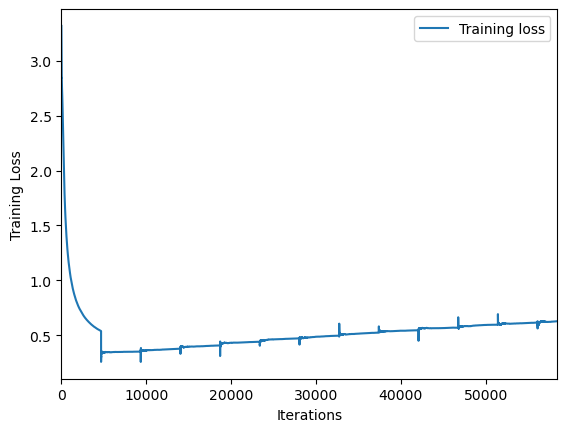

In [ ]:
import matplotlib.pyplot as plt

# steps for the full training run (50 epochs * steps per epoch)
step = np.arange(0, (50 * steps_per_epoch))

# Get the learning rate values corresponding to each step
lr = clr(step)

# Plot the recorded training loss from CLR_history against iteration steps
plt.plot(step,model_17_lr_range_1_cycle_clr_history.losses , "-", label="Training loss")

# Set the x-axis limit to match the total number of training iterations
plt.xlim([0, 58436])

# Add axis labels and legend
plt.xlabel("Iterations")
plt.ylabel("Training Loss")
plt.legend()


I plot model accuracy and loss history in the cell below.

In this schedule, the learning rate:

- Increases during the first half of training

- Decreases during the second half

It shows the model is training with the 1-cycle policy.

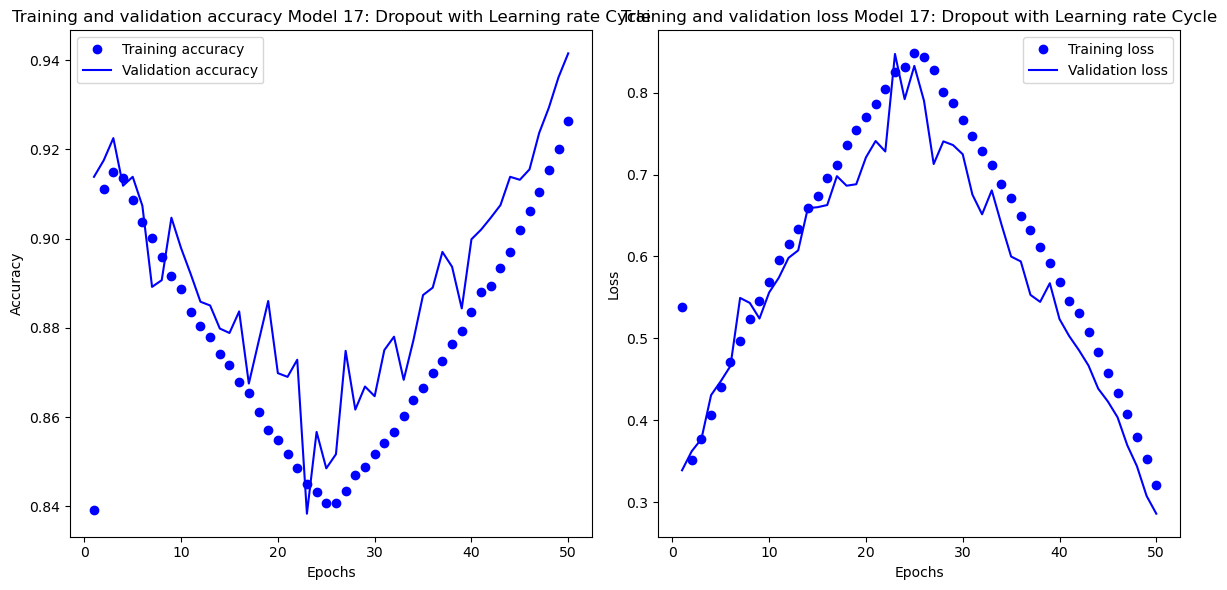

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import display_accuracy_loss

# Plot Training and validation Accuracy and loss.
display_accuracy_loss(model_17_lr_range_1_cycle_history, 'Model 17: Dropout with Learning rate Cycle')

Printing the training time history in cell below

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_model_times

# Print the model Training Time
display_model_times(model_17_lr_range_1_cycle_time)

Total Time: 0:34:31.107212 Average Epoch Time: 0:00:41.422144


Load the best performing model that was trained and saved according to validation loss. To load the model I have to reload the Learning rate schedule and re-comple the model.

In [ ]:
import math
from keras.optimizers import Adam

# Reference links for learning rate schedules and TF Addons issues
# https://colab.research.google.com/drive/1KEZu-wgAGToKanmRtQMSsp8bZ-d1xmV0?usp=sharing
# https://github.com/tensorflow/addons/issues/2380

# Define the path to the saved best model (from earlier training with 1-cycle LR)
model_17_lr_range_1_cycle_path = 'saved models/2. model 2 dropout/lr/'


# Load the previously saved best model without recompiling it yet
model_17_lr_range_1_cycle_best = tf.keras.models.load_model(model_17_lr_range_1_cycle_path + "model_17_lr_range_1_cycle_best.keras", compile=False)

# Set the learning rate boundaries for 1-cycle schedule
MAX_LR = 2e-2
INIT_LR = 1e-3

# Define how many epochs
epoch_count = 50

# Calculate the number of training steps per epoch based on dataset size and batch size
steps_per_epoch = math.ceil(len(X_train_normalized) / BATCH_SIZE)


# Define the cyclical learning rate (CLR) schedule
# For more information https://stackoverflow.com/questions/67656969/what-does-tensorflows-cyclicallearningrate-scale-fn-argument-mean
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,    # Starting LR
    maximal_learning_rate=MAX_LR,                                           # Peak LR
    scale_fn=scale_fn,                                                      # Flat scale function, no decay             
    step_size=(steps_per_epoch * epoch_count) / 2                           # 1 cycle across all training steps
)

# Wrap CLR into the Adam optimizer
optimizer = Adam(clr)

# Compile the previously loaded model with CLR-enabled Adam optimizer
model_17_lr_range_1_cycle_best.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy']
    )

Evaluate the best performing model on the test dataset

In [ ]:
model_17_lr_range_1_cycle_best.evaluate(test_dataset)

204/204 [==============================] - 1s 4ms/step - loss: 0.2984 - accuracy: 0.9380


[0.29840484261512756, 0.9379993677139282]

Model 17 achieves an accuracy of 93.80%

Plotting the confusion matrix to see how the model handle each digit classification

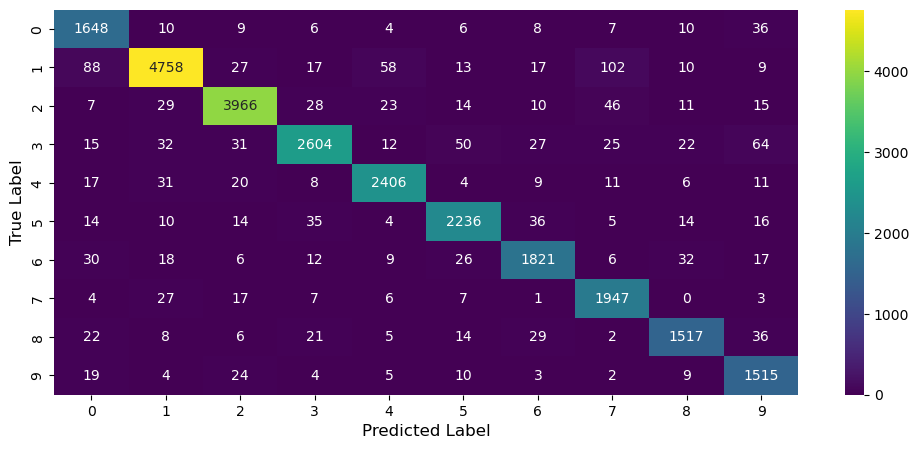

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import generate_confusion_matrix


dropout_aug_cm = generate_confusion_matrix(model_17_lr_range_1_cycle_best, test_dataset)

## Model 18: Dropblock LR

I will be finding the learning rate using models 16 best hyperparameters found.

In [ ]:
import keras_tuner

# Create path for the hyperparameter trails
model_16_l2_path = 'saved models/3. Model 3 DropBlock/l2/'

# Reload the hyperparameter search trails
tuner = keras_tuner.RandomSearch(
    hypermodel=model_16_relu_w_dropblock_aug_batch_bottleneck_maxnorm_l2,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    overwrite=False,
    directory=model_16_l2_path,
    project_name="model_16_relu_w_dropblock_aug_batch_bottleneck_maxnorm_l2_hyper_p",
)
tuner.search_space_summary()

Reloading Tuner from saved models/3. Model 3 DropBlock/l2/model_16_relu_w_dropblock_aug_batch_bottleneck_maxnorm_l2_hyper_p\tuner0.json
Search space summary
Default search space size: 5
l2_1 (Choice)
{'default': 1e-06, 'conditions': [], 'values': [1e-06, 5e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005], 'ordered': True}
l2_2 (Choice)
{'default': 1e-06, 'conditions': [], 'values': [1e-06, 5e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005], 'ordered': True}
l2_3 (Choice)
{'default': 1e-06, 'conditions': [], 'values': [1e-06, 5e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005], 'ordered': True}
l2_4 (Choice)
{'default': 1e-06, 'conditions': [], 'values': [1e-06, 5e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005], 'ordered': True}
l2_5 (Choice)
{'default': 1e-06, 'conditions': [], 'values': [1e-06, 5e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005], 'ordered': True}


### LR Range Test

Here, I will focus on find the maximum learning rate value.

In [ ]:
# Select the Top 5 performing hyperparameters configurations
best_hps = tuner.get_best_hyperparameters(5)

# Load a new model with the Top configuration
model_18_lr_range_test = model_16_relu_w_dropblock_aug_batch_bottleneck_maxnorm_l2(best_hps[0])

In [ ]:
# Print a summary of the model architecture
model_18_lr_range_test.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 drop_block2d_8 (DropBlock2D  (None, 32, 32, 3)        0         
 )                                                               
                                                                 
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_16 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 drop_block2d_9 (DropBlock2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                 

Below, sets up a learning rate range test using a 1-cycle policy with a cyclical learning rate schedule. It trains the model from a very low learning rate to a high one over 25 epochs, helping identify the optimal learning rate by observing how the loss changes across this range. Custom callbacks record learning rate history and handle early stopping if needed.

In [ ]:
import importlib
import utils.keras_callback
importlib.reload(utils.keras_callback)
from utils.keras_callback import TimeHistory, CLR_history, stop_model
from keras.optimizers import Adam
import tensorflow_addons as tfa
import math

# Initial and Max LR wide enough range to explore learning dynamics
INIT_LR = 1e-5
MAX_LR = 4e-1

# Maximum Epoch count
epoch_count = 50

# Calculate the number of steps per epoch based on training dataset size and batch size
steps_per_epoch = math.ceil(len(X_train_normalized) / BATCH_SIZE)

# Define a cyclical learning rate schedule (1-cycle policy)
# For more info on scale_fn: https://stackoverflow.com/questions/67656969/what-does-tensorflows-cyclicallearningrate-scale-fn-argument-mean
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,        # Starting LR
    maximal_learning_rate=MAX_LR,                                               # Peak LR  
    scale_fn=lambda x: 1.0,                                                     # Keep the LR constant within each half-cycle       
    step_size=(steps_per_epoch * epoch_count)                                   # Upward sweep only for the LR Range test
)

# Apply CLR to the Adam optimizer
optimizer = Adam(clr)

# Compile the model using categorical crossentropy for classification
model_18_lr_range_test.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy']
    )

# Instantiate callback to track learning rate and loss history during training
model_18_lr_range_test_clr_history = CLR_history()

# Instantiate custom early stopping callback after 25 epochs
stop_model_training = stop_model()

# Train the model with the CLR and early stopping callbacks
model_18_lr_range_test_history = model_18_lr_range_test.fit(
    aug_train_dataset,                                                              # Training data and labels
    validation_data=(val_dataset),                                                  # Validation data and labels
    epochs=epoch_count,                                                             # Number of epochs
    class_weight=d_class_weights,                                                   # Adding Class Weights
    callbacks=[ model_18_lr_range_test_clr_history, stop_model_training],           # Callbacks
    verbose=1                                                                       # Verbosity mode (1 for progress bar)
)

Epoch 1/50
4675/4675 [==============================] - 55s 10ms/step - loss: 0.6393 - accuracy: 0.8033 - val_loss: 0.3805 - val_accuracy: 0.9037
Epoch 2/50
4675/4675 [==============================] - 53s 10ms/step - loss: 0.4488 - accuracy: 0.8828 - val_loss: 0.5032 - val_accuracy: 0.8795
Epoch 3/50
4675/4675 [==============================] - 53s 10ms/step - loss: 0.5620 - accuracy: 0.8705 - val_loss: 0.5982 - val_accuracy: 0.8698
Epoch 4/50
4675/4675 [==============================] - 53s 10ms/step - loss: 0.6627 - accuracy: 0.8553 - val_loss: 0.7059 - val_accuracy: 0.8518
Epoch 5/50
4675/4675 [==============================] - 54s 10ms/step - loss: 0.7502 - accuracy: 0.8397 - val_loss: 0.7542 - val_accuracy: 0.8407
Epoch 6/50
4675/4675 [==============================] - 56s 11ms/step - loss: 0.8205 - accuracy: 0.8264 - val_loss: 0.8010 - val_accuracy: 0.8335
Epoch 7/50
4675/4675 [==============================] - 57s 11ms/step - loss: 0.8849 - accuracy: 0.8134 - val_loss: 0.7895 -

Below, I am saving the Pre trail run Model  histroy information

In [ ]:
# Save LR Range Test model 11

model_18_lr_range_test_path = 'saved models/3. Model 3 DropBlock/lr/'
np.save(model_18_lr_range_test_path + 'model_18_lr_range_test_losses' + '.npy', model_18_lr_range_test_clr_history.losses)
np.save(model_18_lr_range_test_path + 'model_18_lr_range_test_accuracy' + '.npy', model_18_lr_range_test_clr_history.accuracy)

Checking at which point the curve is the lowest before it overfits

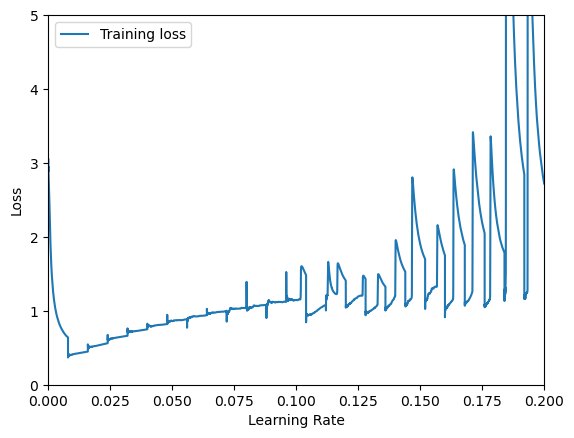

In [ ]:
import matplotlib.pyplot as plt

# Create a range of step indices covering half a 1-cycle policy (increasing LR then decreasing)
step = np.arange(0, (25 * steps_per_epoch))

# Get learning rate values over the defined step range
lr = clr(step)

# Plot training loss against learning rate to identify optimal LR
plt.plot(lr,model_18_lr_range_test_clr_history.losses , "-", label="Training loss")

# Limit axes for better zoom/focus on the useful LR range
plt.ylim([0, 5])
plt.xlim([0.0, 0.2])

# Label the plot
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.legend()


The max Lr Rate identified in the above graph is around 0.0005

### 1 Cycle test

Reload Model 16 Parameters value for training with the 1 Cycle policy.

In [ ]:
# Select the Top 5 performing hyperparameters configurations
best_hps = tuner.get_best_hyperparameters(5)

# Load a new model with the Top configuration
model_18_lr_range_1_cycle = model_16_relu_w_dropblock_aug_batch_bottleneck_maxnorm_l2(best_hps[0])

In [ ]:
# Print Model Summary
model_18_lr_range_1_cycle.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 drop_block2d_16 (DropBlock2  (None, 32, 32, 3)        0         
 D)                                                              
                                                                 
 conv2d_18 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_24 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 drop_block2d_17 (DropBlock2  (None, 30, 30, 32)       0         
 D)                                                              
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                 

Idenitify the minimum learning rate using factor 10 or 20

In [ ]:
import importlib
import utils.keras_callback
importlib.reload(utils.keras_callback)
from utils.keras_callback import TimeHistory, CLR_history, stop_model
from keras.optimizers import Adam
import tensorflow_addons as tfa
import math

# Define the maximum and initial learning rates for 1-cycle schedule
INIT_LR = 2.5e-4
MAX_LR = 0.5e-2

# Number of epochs to train for
epoch_count = 50

# Calculate the number of steps per epoch based on training dataset size and batch size
steps_per_epoch = math.ceil(len(X_train_normalized) / BATCH_SIZE)

# Define a flat scale function for cyclical learning rate (no decay)
def scale_fn(x):
    return 1.0

# Create cyclical learning rate schedule (1-cycle policy)
# For more info on scale_fn: https://stackoverflow.com/questions/67656969/what-does-tensorflows-cyclicallearningrate-scale-fn-argument-mean
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=scale_fn,               
    step_size=(steps_per_epoch * epoch_count) / 2            # Full 1-cycle spans 50 epochs
)

# Wrap CLR into the Adam optimizer
optimizer = Adam(clr)

# Compile the model with Adam optimizer and categorical crossentropy for classification
model_18_lr_range_1_cycle.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy']
    )

# Callback to track the learning rate and loss history
model_18_lr_range_1_cycle_clr_history = CLR_history()

# Callback to track total training time
model_18_lr_range_1_cycle_time = TimeHistory()

# Define file path to save the best model
model_18_lr_range_1_cycle_path = 'saved models/3. Model 3 DropBlock/lr/'

# Callback to save the model with the lowest validation loss
best_model = [tf.keras.callbacks.ModelCheckpoint(
        filepath=model_18_lr_range_1_cycle_path  + "model_18_lr_range_1_cycle_best.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Train the model using augmented data and the 1-cycle learning rate schedule
model_18_lr_range_1_cycle_history = model_18_lr_range_1_cycle.fit(
    aug_train_dataset,                                                                                          # Training data and labels
    validation_data=(val_dataset),                                                                              # Validation data and labels
    epochs=epoch_count,                                                                                         # Number of epochs
    class_weight=d_class_weights,                                                                               # Adding Class Weights
    callbacks=[best_model, model_18_lr_range_1_cycle_clr_history, model_18_lr_range_1_cycle_time],              # Callbacks
    verbose=1                                                                                                   # Verbosity mode (1 for progress bar)
)

Epoch 1/50
4675/4675 [==============================] - 55s 11ms/step - loss: 0.6954 - accuracy: 0.7818 - val_loss: 0.3455 - val_accuracy: 0.9033
Epoch 2/50
4675/4675 [==============================] - 53s 10ms/step - loss: 0.3198 - accuracy: 0.9067 - val_loss: 0.2812 - val_accuracy: 0.9233
Epoch 3/50
4675/4675 [==============================] - 53s 10ms/step - loss: 0.2703 - accuracy: 0.9221 - val_loss: 0.2764 - val_accuracy: 0.9263
Epoch 4/50
4675/4675 [==============================] - 53s 10ms/step - loss: 0.2532 - accuracy: 0.9284 - val_loss: 0.2675 - val_accuracy: 0.9293
Epoch 5/50
4675/4675 [==============================] - 53s 10ms/step - loss: 0.2441 - accuracy: 0.9322 - val_loss: 0.2747 - val_accuracy: 0.9310
Epoch 6/50
4675/4675 [==============================] - 53s 10ms/step - loss: 0.2427 - accuracy: 0.9335 - val_loss: 0.2617 - val_accuracy: 0.9342
Epoch 7/50
4675/4675 [==============================] - 53s 10ms/step - loss: 0.2425 - accuracy: 0.9346 - val_loss: 0.2614 -

The plot visualizes how training loss changes over the course of training iterations when using a 1-cycle learning rate schedule.

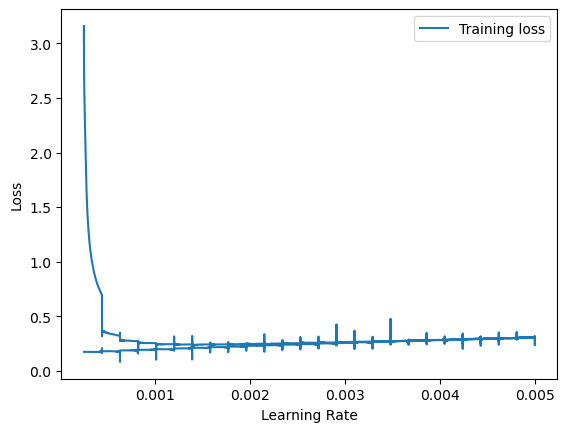

In [ ]:
import matplotlib.pyplot as plt

# steps for the full training run (50 epochs * steps per epoch)
step = np.arange(0, (50 * steps_per_epoch))

# Get the learning rate values corresponding to each step
lr = clr(step)
# Plot the recorded training loss from CLR_history against iteration steps
plt.plot(lr,model_18_lr_range_1_cycle_clr_history.losses , "-", label="Training loss")

# Add axis labels and legend
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.legend()


Saving the model information in the below cell

In [ ]:
import importlib
import utils.model_utils
importlib.reload(utils.model_utils)
from utils.model_utils import save_model_data

# Configure the path to save the model information
model_18_lr_range_1_cycle_path = 'saved models/3. Model 3 DropBlock/lr/'

# Save model, model history and training time information
save_model_data(model_18_lr_range_1_cycle_path,
               model_18_lr_range_1_cycle,'model_18_lr_range_1_cycle',
               model_18_lr_range_1_cycle_history, 'model_18_lr_range_1_cycle_history',
               model_18_lr_range_1_cycle_time, 'model_18_lr_range_1_cycle_time'  )

I plot model accuracy and loss history in the cell below.

In this schedule, the learning rate:

- Increases during the first half of training

- Decreases during the second half

It shows the model is training with the 1-cycle policy.

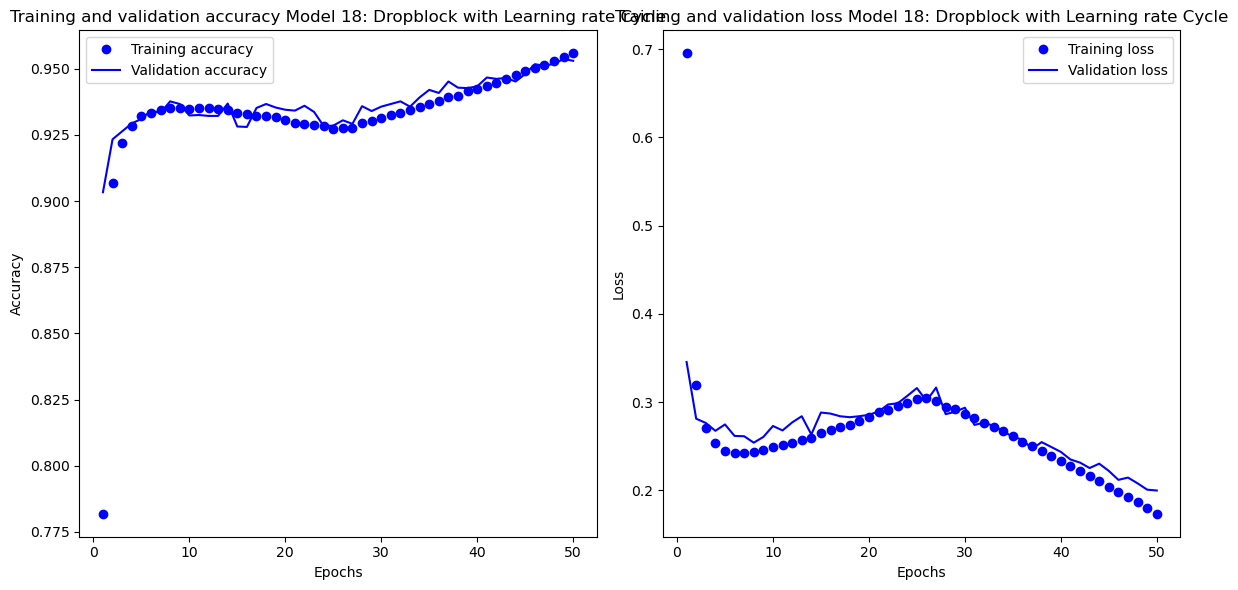

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import display_accuracy_loss

display_accuracy_loss(model_18_lr_range_1_cycle_history, 'Model 18: Dropblock with Learning rate Cycle' )

Printing the training time history in cell below

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_model_times

# Print the model Training Time
display_model_times(model_18_lr_range_1_cycle_time)

Total Time: 0:45:24.247804 Average Epoch Time: 0:00:54.484956


Load the best performing model that was trained and saved according to validation loss. To load the model I have to reload the Learning rate schedule and re-comple the model.

In [ ]:
# Reference links for learning rate schedules and TF Addons issues

# https://colab.research.google.com/drive/1KEZu-wgAGToKanmRtQMSsp8bZ-d1xmV0?usp=sharing
# https://github.com/tensorflow/addons/issues/2380

import importlib
import utils.DropBlock
importlib.reload(utils.DropBlock)
from utils.DropBlock import DropBlock2D

# Define the path to the saved best model (from earlier training with 1-cycle LR)
model_18_lr_range_1_cycle_path = 'saved models/3. Model 3 DropBlock/lr/'


# Load the previously saved best model without recompiling it yet
model_18_lr_range_1_cycle_best = tf.keras.models.load_model(model_18_lr_range_1_cycle_path  + "model_18_lr_range_1_cycle_best.keras", compile=False, custom_objects={'DropBlock2D': DropBlock2D})

# Set the learning rate boundaries for 1-cycle schedule
INIT_LR = 1.5e-3
MAX_LR = 3e-2

# Define how many epochs
epoch_count = 25

# Calculate the number of training steps per epoch based on dataset size and batch size
steps_per_epoch = math.ceil(len(X_train_normalized) / BATCH_SIZE)

# Define a flat scale function for cyclical learning rate (no decay)
def scale_fn(x):
    return 1.0

# Define the cyclical learning rate (CLR) schedule
# For more information https://stackoverflow.com/questions/67656969/what-does-tensorflows-cyclicallearningrate-scale-fn-argument-mean
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,        # Starting LR
    maximal_learning_rate=MAX_LR,                                               # Peak LR
    scale_fn=scale_fn,                                                          # Flat scale function, no decay         
    step_size=(steps_per_epoch * epoch_count) / 2                               # 1 cycle across all training steps
)

# Wrap CLR into the Adam optimizer
optimizer = Adam(clr)

# Compile the previously loaded model with CLR-enabled Adam optimizer
model_18_lr_range_1_cycle_best.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy']
    )

Evaluate the best performing model on the test dataset

In [ ]:
model_18_lr_range_1_cycle_best.evaluate(test_dataset)

204/204 [==============================] - 1s 4ms/step - loss: 0.1825 - accuracy: 0.9591


[0.18245886266231537, 0.9591272473335266]

Model 18 achieves an accuracy of 95.91%

Plotting the confusion matrix to see how the model handle each digit classification

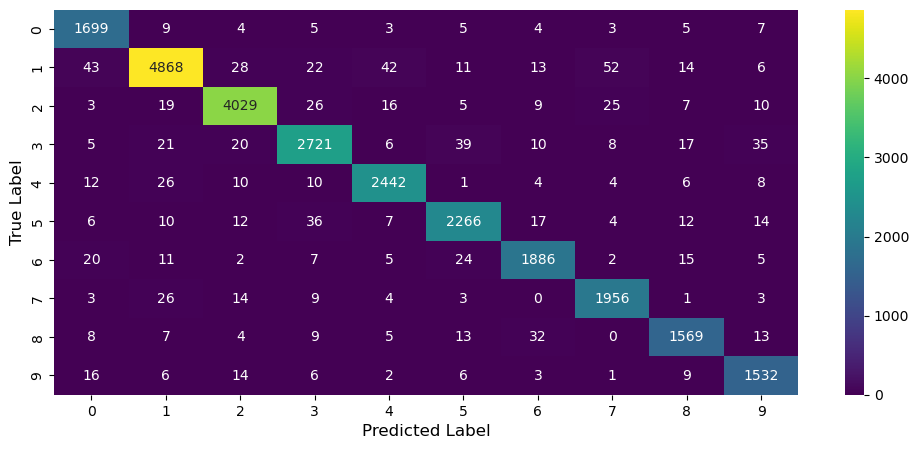

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import generate_confusion_matrix


dropout_aug_cm = generate_confusion_matrix(model_18_lr_range_1_cycle_best, test_dataset)

## Model 17 & 18 Comparison

The Dropout and Dropblock curves look quite different from Model 15 & 16. Dropout learning rate was much higher than Dropblock and you can see more of a steeper peak. The validation curves in both model are parallel with the training curves indicating the model is well regularized and adjusting the learning rate has not affected the good fit. The learning rate was applied to the L2 regularization architecture, the Dropout Test accuracy has decreased from 94.95% to 93.80%, this might indicate that I have not found the optimal learning rate for the model another trail might need to be done.  Dropblock test accuracy has increased from 95.23% to 95.91% indicating that the learning rate has helped fine tune the model. 

Below, I am loading the Training and time History to plot.

In [ ]:
# Load Training and Time history for Model 17

# Configure the path to save the model information
model_17_lr_range_1_cycle_path = 'saved models/2. model 2 dropout/lr/'

# History
model_17_lr_range_1_cycle_history = np.load(model_17_lr_range_1_cycle_path + 'model_17_lr_range_1_cycle_history.npy', allow_pickle=True).item()

# Time
model_17_lr_range_1_cycle_time = np.load(model_17_lr_range_1_cycle_path + 'model_17_lr_range_1_cycle_time.npy', allow_pickle=True)

In [ ]:
# Load Training and Time history for Model 18

# Configure the path to save the model information
model_18_lr_range_1_cycle_path = 'saved models/3. Model 3 DropBlock/lr/'

# Time
model_18_lr_range_1_cycle_time = np.load(model_18_lr_range_1_cycle_path + 'model_18_lr_range_1_cycle_time.npy', allow_pickle=True)

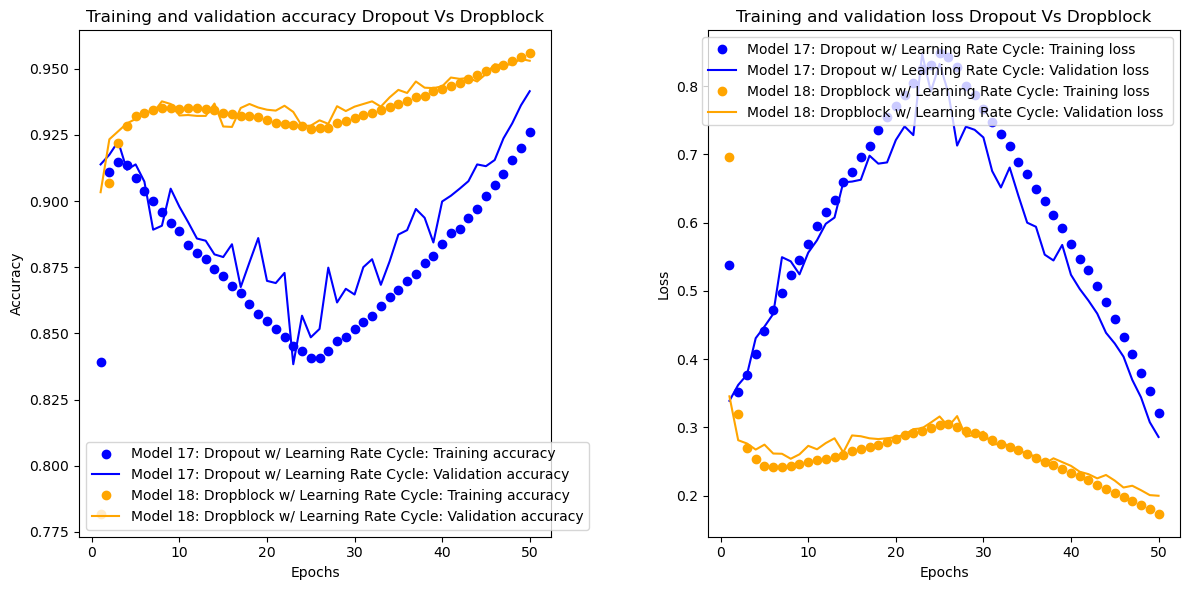

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import plot_accuracy_metric_comparison
import pandas as pd

# Load the model history into a dataframe
pd1 = pd.DataFrame(model_17_lr_range_1_cycle_history.history)

# Load the model history into a dataframe
pd2 = pd.DataFrame(model_18_lr_range_1_cycle_history.history)

# Plot the comparison Graphs
plot_accuracy_metric_comparison(pd1,'Model 17: Dropout w/ Learning Rate Cycle', pd2, 'Model 18: Dropblock w/ Learning Rate Cycle',  'Dropout Vs Dropblock')

Model 17 & 18 total training time has increased possibly due to the slower learning rates. Dropblock is still outperforming dropout in the digit classification

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import compare_times

compare_times(model_17_lr_range_1_cycle_time, model_18_lr_range_1_cycle_time)

Average Epoch      Total Time
Model                                  
Model_1  0:00:41.422144  0:34:31.107212
Model_2  0:00:54.484956  0:45:24.247804

The 1 cycle learning rate has had no effect on the Dropblock model, but it has increased never activated neurons in Dropout Top and Middle layers. You can see a broader range of activations in the middle to deeper layers in comparison to the last models 15 & 16 where the L2 regularization has narrowed the range with weaker activation. The learning rate cycle has had the effect of increasing the strength of activations over a broader range. While this has had a positive effect for Dropblock, it has had a negative effect for dropout potentially due to over-regularization or instability during rapid learning rate changes.

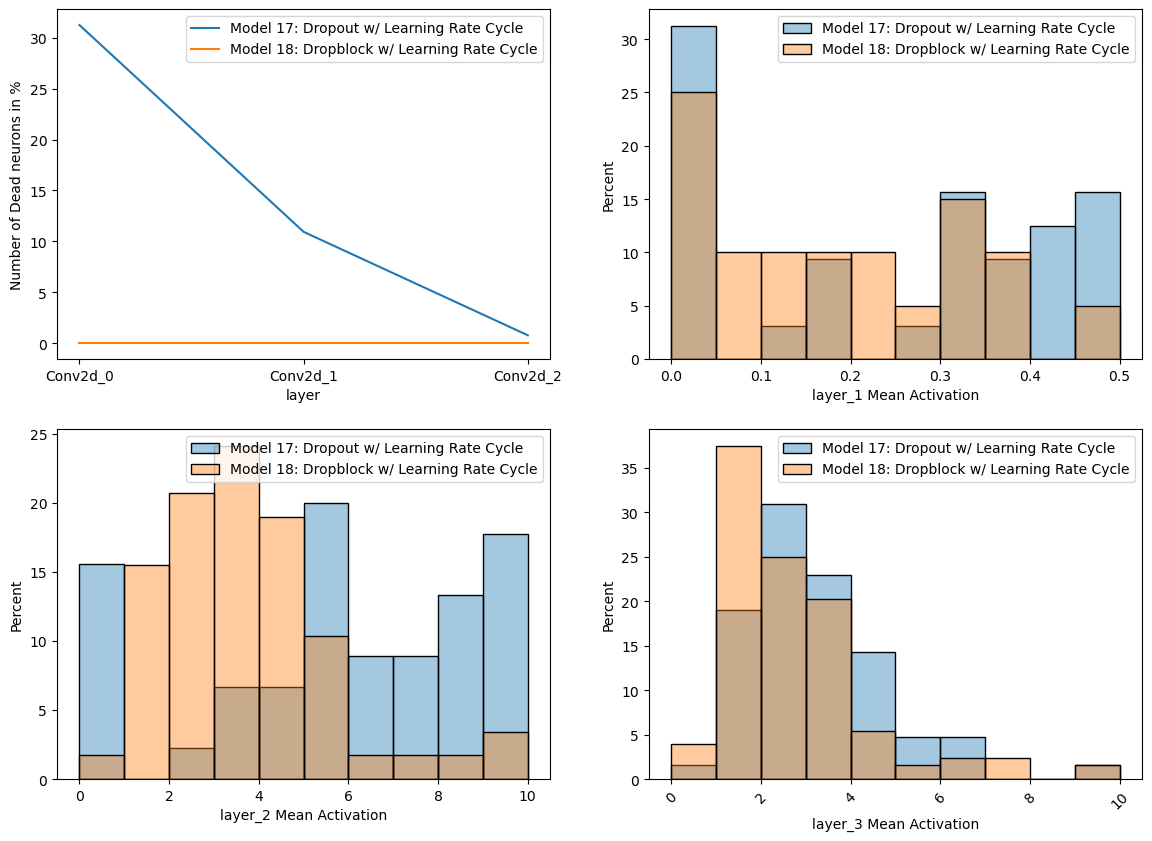

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_neurons_count, display_mean_activations

fig, axes = plt.subplots(2, 2, figsize=(14, 10))


display_neurons_count(model_17_lr_range_1_cycle_best, test_dataset, ('Model 17: Dropout w/ Learning Rate Cycle', axes[0,0]) )
display_neurons_count(model_18_lr_range_1_cycle_best, test_dataset, ('Model 18: Dropblock w/ Learning Rate Cycle', axes[0,0]) )

display_mean_activations(model_17_lr_range_1_cycle_best, test_dataset, '1', 0, 0.5, 11, ('Model 17: Dropout w/ Learning Rate Cycle', axes[0,1]) )
display_mean_activations(model_18_lr_range_1_cycle_best, test_dataset, '1',0, 0.5, 11, ('Model 18: Dropblock w/ Learning Rate Cycle', axes[0,1]) )

display_mean_activations(model_17_lr_range_1_cycle_best, test_dataset, '2', 0, 10, 11, ('Model 17: Dropout w/ Learning Rate Cycle', axes[1,0]) )
display_mean_activations(model_18_lr_range_1_cycle_best, test_dataset, '2', 0, 10, 11, ('Model 18: Dropblock w/ Learning Rate Cycle', axes[1,0]) )

display_mean_activations(model_17_lr_range_1_cycle_best, test_dataset, '3', 0, 10, 11, ('Model 17: Dropout w/ Learning Rate Cycle', axes[1,1]) )
display_mean_activations(model_18_lr_range_1_cycle_best, test_dataset, '3', 0, 10, 11,  ('Model 18: Dropblock w/ Learning Rate Cycle', axes[1,1]) )



Dropblock is still outperforming dropout in the digit classification 

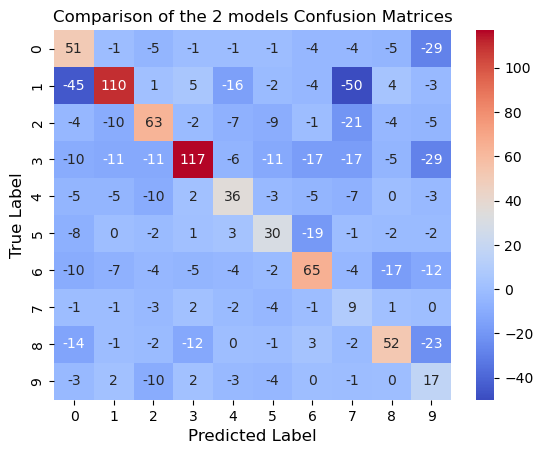

In [ ]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import model_comparison_confusion_matrix

model_comparison_confusion_matrix(model_18_lr_range_1_cycle_best, model_17_lr_range_1_cycle_best, test_dataset )

# Results

Here I will be plotting some of the Visualizations for the Evalaution section in the Report.

This DataFrame presents a summary of performance results for 20 different CNN models, each evaluated with different architectural and regularization techniques. 

In [ ]:
import pandas as pd

# Load model performance results from a CSV file into a DataFrame
model_results_df = pd.read_csv("Models Results.csv")

# Display the contents of the DataFrame
model_results_df

Model                                               Name  \
0           Model 1A                         Simple CNN Baseline Model    
1           Model 1B                          Simple CNN with Max pool    
2            Model 2   Simple CNN w/ Max pool & Hyper-parameter search    
3            Model 3                  Simple CNN w/ Max pool w/ Dropout   
4            Model 4              Simple CNN w/ Max pooll  w/ Dropblock   
5            Model 5   Simple CNN w/ Max pool w/ Dropout + Augmentation   
6            Model 6   Simple CNN w/ Max pooll w/ Dropblock + Augmen...   
7            Model 7            Applying Batch Normalisation w/ Dropout   
8            Model 8          Applying Batch Normalisation w/ Dropblock   
9           Model 9                      Applying Bottleneck w/ Dropout   
10          Model 10                   Applying Bottleneck w/ Dropblock   
11          Model 11   Replacing ReLu with Maxout Activation w/ Dropout   
12          Model 12   Replacing ReLu with Maxout Activation w/ Drop...   
13          Model 13                        Applying Maxnorm w/ Dropout   
14          Model 14                      Applying Maxnorm w/ Dropblock   
15          Model 15                 Apply L2 regularization w/ Dropout   
16          Model 16               Apply L2 regularization w/ Dropblock   
17          Model 17          Applying 1 cycle learning rate w/ Dropout   
18          Model 18        Applying 1 cycle learning rate w/ Dropblock   
19  Replicated Model               Improving Neural Networks w/ Dropout   

   Dropout / Dropblock Average Epoch Total Time Test Accuracy  
0             Baseline      00:01:24   01:10:05        92.81%  
1             Baseline      00:00:21   00:17:05        94.71%  
2             Baseline      00:00:44   00:37:01        94.76%  
3              Dropout      00:00:23   00:19:00        93.79%  
4            Dropblock      00:00:40   00:33:37        94.75%  
5              Dropout      00:00:26   00:21:36        94.28%  
6            Dropblock      00:00:41   00:34:08        94.78%  
7              Dropout      00:00:36   00:29:46        95.67%  
8            Dropblock      00:00:48   00:40:00        96.05%  
9              Dropout      00:00:36   00:29:50        95.56%  
10           Dropblock      00:00:51   00:42:30        95.88%  
11             Dropout      00:00:34   00:27:59        93.46%  
12           Dropblock      00:00:41   00:34:26        94.24%  
13             Dropout      00:00:36   00:30:09        95.51%  
14           Dropblock      00:00:56   00:46:32        95.83%  
15             Dropout      00:00:35   00:29:31        94.95%  
16           Dropblock      00:00:52   00:43:15        95.23%  
17             Dropout      00:00:41   00:34:31        93.80%  
18           Dropblock      00:00:54   00:45:24        95.91%  
19          replicated      00:01:32   07:37:39        97.06%

This filtered and sorted DataFrame displays a performance comparison of all models that used either Dropout or DropBlock, ranked by Test Accuracy

In [ ]:
# Dropout / Dropblock Filter

# Filter models that used either Dropout or DropBlock regularization
dropout_dropblock_filter = model_results_df[(model_results_df['Dropout / Dropblock'] == 'Dropout') | (model_results_df['Dropout / Dropblock'] == 'Dropblock')]

# Convert 'Test Accuracy' from string (e.g., "95.67%") to float (e.g., 95.67)
dropout_dropblock_filter['Test Accuracy'] = dropout_dropblock_filter['Test Accuracy'].str.rstrip('%').astype('float')

# Convert 'Total Time' from string format (hh:mm:ss) to total seconds (as float)
dropout_dropblock_filter['Total Time'] = pd.to_timedelta(dropout_dropblock_filter['Total Time']).dt.total_seconds()

# Sort the filtered DataFrame by test accuracy in descending order
dropout_dropblock_filter = dropout_dropblock_filter.sort_values(by='Test Accuracy', ascending=False) 

# Display the sorted DataFrame of Dropout/DropBlock models with converted metrics
dropout_dropblock_filter

C:\Users\seand\AppData\Local\Temp\ipykernel_21944\1854707693.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropout_dropblock_filter['Test Accuracy'] = dropout_dropblock_filter['Test Accuracy'].str.rstrip('%').astype('float')
C:\Users\seand\AppData\Local\Temp\ipykernel_21944\1854707693.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropout_dropblock_filter['Total Time'] = pd.to_timedelta(dropout_dropblock_filter['Total Time']).dt.total_seconds()


Model                                               Name  \
8    Model 8          Applying Batch Normalisation w/ Dropblock   
18  Model 18        Applying 1 cycle learning rate w/ Dropblock   
10  Model 10                   Applying Bottleneck w/ Dropblock   
14  Model 14                      Applying Maxnorm w/ Dropblock   
7    Model 7            Applying Batch Normalisation w/ Dropout   
9   Model 9                      Applying Bottleneck w/ Dropout   
13  Model 13                        Applying Maxnorm w/ Dropout   
16  Model 16               Apply L2 regularization w/ Dropblock   
15  Model 15                 Apply L2 regularization w/ Dropout   
6    Model 6   Simple CNN w/ Max pooll w/ Dropblock + Augmen...   
4    Model 4              Simple CNN w/ Max pooll  w/ Dropblock   
5    Model 5   Simple CNN w/ Max pool w/ Dropout + Augmentation   
12  Model 12   Replacing ReLu with Maxout Activation w/ Drop...   
17  Model 17          Applying 1 cycle learning rate w/ Dropout   
3    Model 3                  Simple CNN w/ Max pool w/ Dropout   
11  Model 11   Replacing ReLu with Maxout Activation w/ Dropout   

   Dropout / Dropblock Average Epoch  Total Time  Test Accuracy  
8            Dropblock      00:00:48      2400.0          96.05  
18           Dropblock      00:00:54      2724.0          95.91  
10           Dropblock      00:00:51      2550.0          95.88  
14           Dropblock      00:00:56      2792.0          95.83  
7              Dropout      00:00:36      1786.0          95.67  
9              Dropout      00:00:36      1790.0          95.56  
13             Dropout      00:00:36      1809.0          95.51  
16           Dropblock      00:00:52      2595.0          95.23  
15             Dropout      00:00:35      1771.0          94.95  
6            Dropblock      00:00:41      2048.0          94.78  
4            Dropblock      00:00:40      2017.0          94.75  
5              Dropout      00:00:26      1296.0          94.28  
12           Dropblock      00:00:41      2066.0          94.24  
17             Dropout      00:00:41      2071.0          93.80  
3              Dropout      00:00:23      1140.0          93.79  
11             Dropout      00:00:34      1679.0          93.46

This bar chart visualizes the test accuracy of CNN models that use either Dropout or DropBlock regularization techniques,

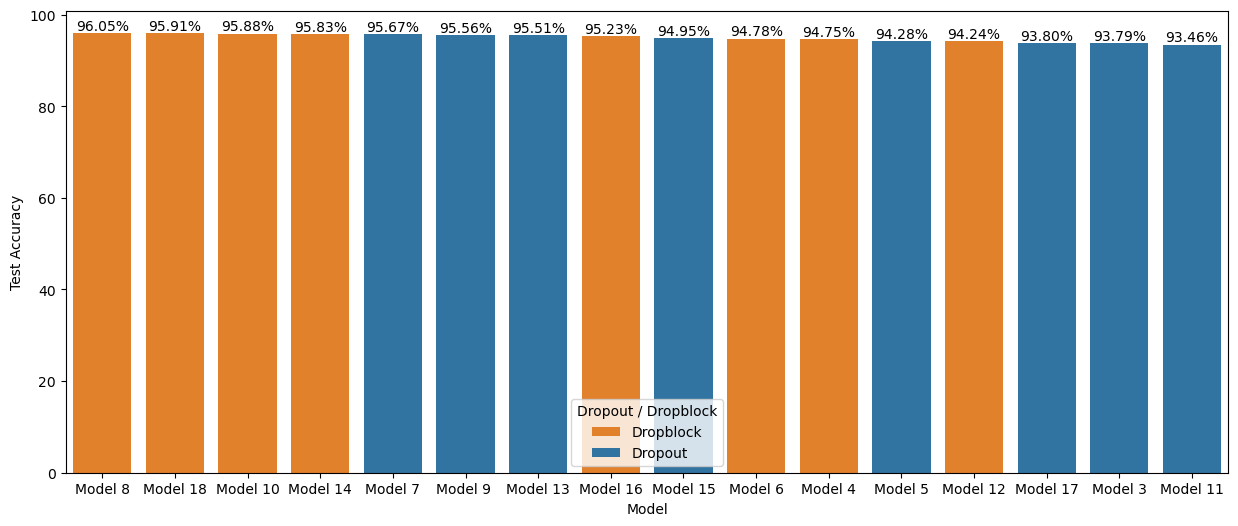

In [ ]:
import seaborn as sns

# Define custom colors for the bar chart based on regularization type
palette = {
    'Dropout': 'tab:blue',
    'Dropblock': 'tab:orange',
}

# Create a wide figure for better spacing of model labels
plt.figure(figsize=(15, 6))
# Generate a barplot showing Test Accuracy for each model, grouped by Dropout/Dropblock
ax = sns.barplot(data=dropout_dropblock_filter,                         # DataFrame containing filtered models
                 x='Model',                                             # X-axis: model identifiers
                y='Test Accuracy',                                      # Y-axis: test accuracy scores
                hue='Dropout / Dropblock',                              # Bar color depends on regularization method
                palette=palette)                                        # Use custom color palette

# Annotate each bar with its height value
for i in ax.containers:
    # Show labels with 2 decimal places and a % sign
    ax.bar_label(i,fmt='%.2f%%')


This bar chart compares the average test accuracy of CNN models that used either DropBlock or Dropout as a regularization technique.

C:\Users\seand\AppData\Local\Temp\ipykernel_43944\2663608258.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=mean_acc, x='Method', y='Average Accuracy', palette=palette)


Text(0.5, 1.0, 'Average Test Accuracy: Dropblock vs Dropout')

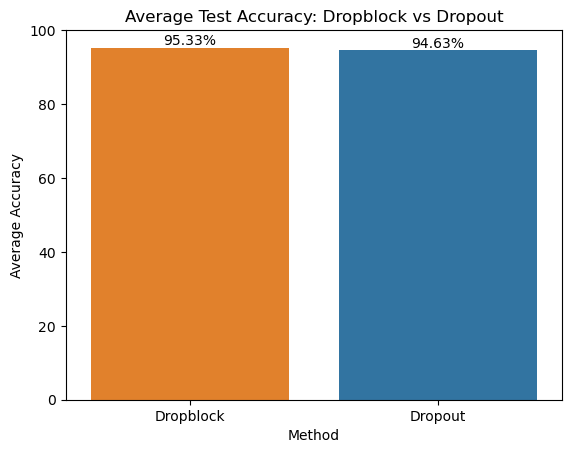

In [ ]:
import seaborn as sns

# Group by 'Dropout / Dropblock' and calculate the mean accuracy
mean_acc = dropout_dropblock_filter.groupby('Dropout / Dropblock')['Test Accuracy'].mean().reset_index()

# Rename the columns 
mean_acc.columns = ['Method', 'Average Accuracy']

# Define custom colors for each method
palette = {
    'Dropout': 'tab:blue',
    'Dropblock': 'tab:orange',
}

# Create a bar plot showing average test accuracy for each regularization method
ax = sns.barplot(data=mean_acc, x='Method', y='Average Accuracy', palette=palette)

# Annotate each bar with its height value
for i in ax.containers:
    # Show labels with 2 decimal places and a % sign
    ax.bar_label(i,fmt='%.2f%%')
    
#  title for the plot
ax.set_title(label='Average Test Accuracy: Dropblock vs Dropout')

This bar chart compares the average total training time (in seconds) for models using DropBlock versus Dropout regularization

C:\Users\seand\AppData\Local\Temp\ipykernel_43944\3464622199.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=mean_acc, x='Method', y='Time (seconds)', palette=palette)


Text(0.5, 1.0, 'Average Total Training Time: Dropblock vs Dropout')

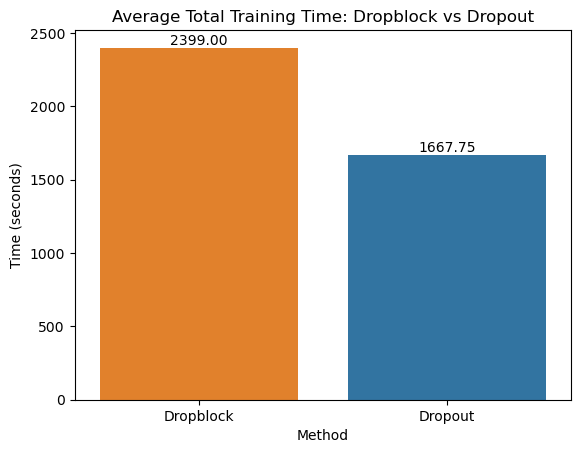

In [ ]:
import seaborn as sns

# Group by 'Dropout / Dropblock' and calculate the mean accuracy
mean_acc = dropout_dropblock_filter.groupby('Dropout / Dropblock')['Total Time'].mean().reset_index()

# Rename the columns 
mean_acc.columns = ['Method', 'Time (seconds)']

# Define custom colors for each method
palette = {
    'Dropout': 'tab:blue',
    'Dropblock': 'tab:orange',
}

# reate a bar plot showing the Average Total Training time for each regularization method
ax = sns.barplot(data=mean_acc, x='Method', y='Time (seconds)', palette=palette)

# Annotate each bar with its height value
for i in ax.containers:
    # Show labels with 2 decimal places
    ax.bar_label(i,fmt="%.2f")

#  title for the plot
ax.set_title(label='Average Total Training Time: Dropblock vs Dropout')

This scatter plot visualizes the relationship between total training time and test accuracy for models using either Dropout or DropBlock regularization

<Axes: xlabel='Total Time', ylabel='Test Accuracy'>

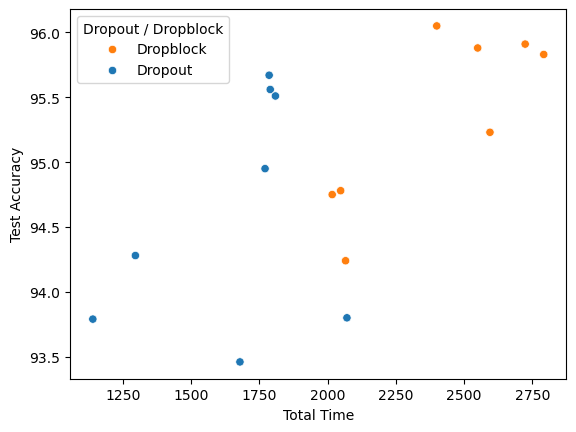

In [ ]:
# Create a scatter plot to visualize the relationship between training time and test accuracy
sns.scatterplot(data=dropout_dropblock_filter,                  # DataFrame containing Dropout and DropBlock models
                x='Total Time',                                 # X-axis: total training time (in seconds)
                y='Test Accuracy',                              # Y-axis: final test accuracy (%)
                hue='Dropout / Dropblock',                      # Color points based on regularization method
                palette=palette )                               # Use custom color scheme


This bar chart compares the efficiency of different CNN models defined here as the ratio of test accuracy to total training time

C:\Users\seand\AppData\Local\Temp\ipykernel_43944\4248506518.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  efficiency["efficiency"] = efficiency["Test Accuracy"] / efficiency["Total Time"]


<Axes: xlabel='Model', ylabel='efficiency'>

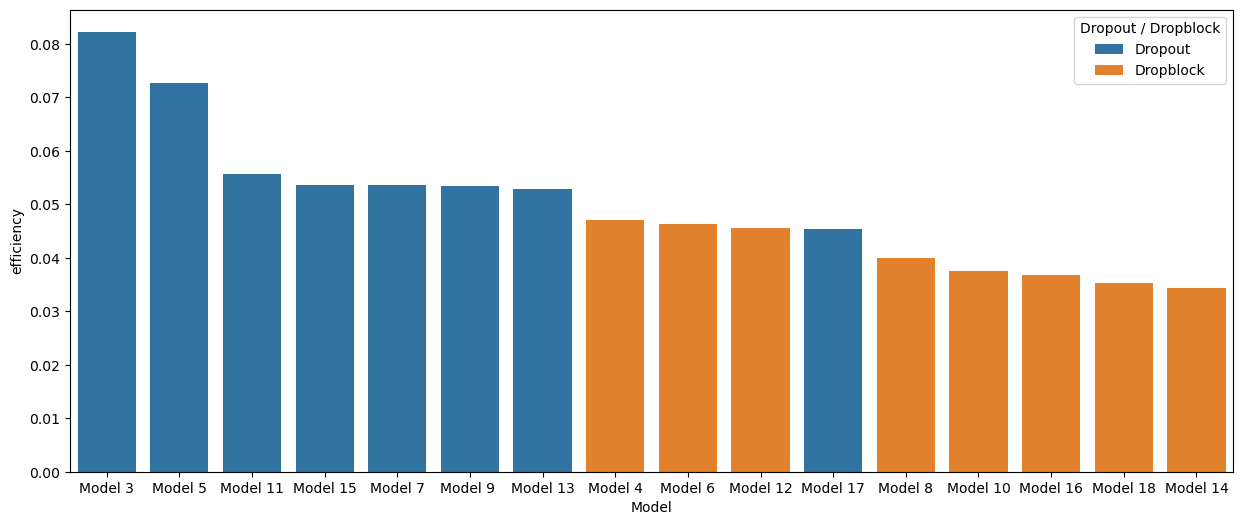

In [ ]:
# Create a new DataFrame with only the columns needed to evaluate efficiency
efficiency = dropout_dropblock_filter[["Model","Dropout / Dropblock", "Total Time", "Test Accuracy"]]

# Calculate an "efficiency" score: test accuracy per second of training time
efficiency["efficiency"] = efficiency["Test Accuracy"] / efficiency["Total Time"]

# Sort models by their efficiency score in descending order (higher = better)
efficiency = efficiency.sort_values(by="efficiency", ascending=False)

# Create a bar plot to visualize model efficiency
plt.figure(figsize=(15, 6))
sns.barplot(data=efficiency,                        # Data with calculated efficiency
            x="Model",                              # X-axis: model ID
            y="efficiency",                         # Y-axis: efficiency score
            hue="Dropout / Dropblock",              # Bar color by regularization method        
            palette=palette)                        # Use defined color palette

This bar chart compares the efficiency of different CNN models including the baseline models defined here as the ratio of test accuracy to total training time

C:\Users\seand\AppData\Local\Temp\ipykernel_21944\1030310500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  efficiency_v2['Test Accuracy'] = efficiency_v2['Test Accuracy'].str.rstrip('%').astype('float')
C:\Users\seand\AppData\Local\Temp\ipykernel_21944\1030310500.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  efficiency_v2['Total Time'] = pd.to_timedelta(efficiency_v2['Total Time']).dt.total_seconds()


<Axes: xlabel='Model', ylabel='efficiency'>

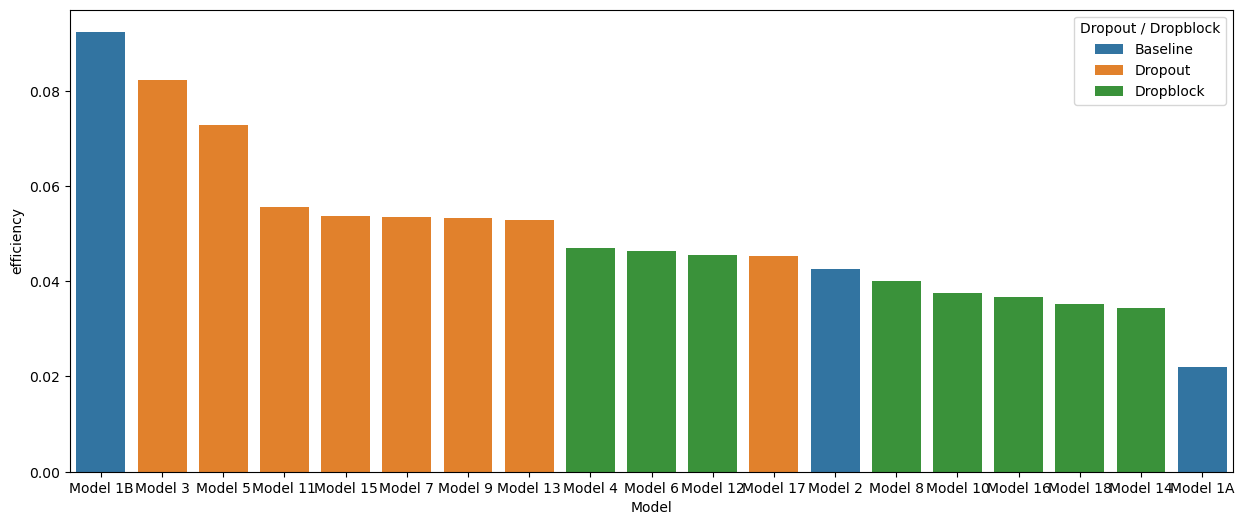

In [ ]:
# Filter out the replicated model (only keep Dropout, DropBlock, and Baseline models)
efficiency_v2 = model_results_df[(model_results_df['Dropout / Dropblock'] != 'replicated') ]

# Convert 'Test Accuracy' from string percentage to float (e.g., '95.67%' → 95.67)
efficiency_v2['Test Accuracy'] = efficiency_v2['Test Accuracy'].str.rstrip('%').astype('float')

# Convert 'Total Time' from string (hh:mm:ss) to total seconds as float
efficiency_v2['Total Time'] = pd.to_timedelta(efficiency_v2['Total Time']).dt.total_seconds()

# Sort models by highest test accuracy (not necessary for efficiency, but good for quick reference)
efficiency_v2 = efficiency_v2.sort_values(by='Test Accuracy', ascending=False) 

# Select only the relevant columns for efficiency calculation 
efficiency_v2 = efficiency_v2[["Model","Dropout / Dropblock", "Total Time", "Test Accuracy"]]

# Calculate model efficiency: test accuracy per second of training
efficiency_v2["efficiency"] = efficiency_v2["Test Accuracy"] / efficiency_v2["Total Time"]

# Sort models by efficiency (highest to lowest)
efficiency_v2 = efficiency_v2.sort_values(by="efficiency", ascending=False)

# Create a bar plot showing efficiency for all models,
plt.figure(figsize=(15, 6))
sns.barplot(data=efficiency_v2, x="Model", y="efficiency", hue="Dropout / Dropblock")

This following bar chart compares the average number of correct classifications per digit (0–9) for models using Dropout and DropBlock regularization methods.

In [ ]:
# Filter the DataFrame to exclude baseline and replicated models
model_name_df = model_results_df[(model_results_df['Dropout / Dropblock'] != 'replicated') & (model_results_df['Dropout / Dropblock'] != 'Baseline')]

# Keep only the 'Model' and 'Dropout / Dropblock' columns for reference or merging
model_name_df = model_name_df[['Model','Dropout / Dropblock']]



In [ ]:
# Filter the model_name_df DataFrame to include only models that used DropBlock
model_name_dropblock_df = model_name_df[model_results_df['Dropout / Dropblock'] == 'Dropblock']

# Create a dictionary mapping model names to their regularization method ('Dropblock')
model_name_dropblock_dict = { k:v for (k,v) in zip(model_name_dropblock_df['Model'], model_name_dropblock_df['Dropout / Dropblock'])}

# Output the dictionary
model_name_dropblock_dict

C:\Users\seand\AppData\Local\Temp\ipykernel_21944\2173342333.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  model_name_dropblock_df = model_name_df[model_results_df['Dropout / Dropblock'] == 'Dropblock']


{'Model 4': 'Dropblock',
 'Model 6': 'Dropblock',
 'Model 8': 'Dropblock',
 'Model 10': 'Dropblock',
 'Model 12': 'Dropblock',
 'Model 14': 'Dropblock',
 'Model 16': 'Dropblock',
 'Model 18': 'Dropblock'}

In [ ]:
# List of best-performing models using DropBlock regularization
dropblock_list = [

    initial_relu_model_with_dropblock_best_hyper_p,

    model_6_relu_model_with_dropblock_aug_best,

    model_8_relu_w_dropblock_aug_batch_best,

    model_10_bottleneck_best,

    model_12_maxout_best,

    model_14_maxnorm_best,

    model_16_l2_best,

    model_18_lr_range_1_cycle_best,
]


In [ ]:
# Filter the model_name_df to include only models that used Dropout
model_name_dropout_df = model_name_df[model_results_df['Dropout / Dropblock'] == 'Dropout']

# Convert the filtered DataFrame to a dictionary
model_name_dropout_df = model_name_dropout_df.to_dict()

#  Display the resulting dictionary
model_name_dropout_df 

C:\Users\seand\AppData\Local\Temp\ipykernel_21944\4197048639.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  model_name_dropout_df = model_name_df[model_results_df['Dropout / Dropblock'] == 'Dropout']


{'Model': {3: 'Model 3',
  5: 'Model 5',
  7: 'Model 7',
  9: 'Model 9 ',
  11: 'Model 11',
  13: 'Model 13',
  15: 'Model 15',
  17: 'Model 17'},
 'Dropout / Dropblock': {3: 'Dropout',
  5: 'Dropout',
  7: 'Dropout',
  9: 'Dropout',
  11: 'Dropout',
  13: 'Dropout',
  15: 'Dropout',
  17: 'Dropout'}}

In [ ]:
# List of best-performing models using Dropout regularization
dropout_list = [
    initial_relu_model_with_dropout_best_hyper_p,

    model_5_relu_model_with_dropout_aug_best,

    model_7_relu_w_dropout_aug_batch_best,

    model_9_bottleneck_best,

    model_11_maxout_best,

    model_13_maxnorm_best,

    model_15_l2_best,

    model_17_lr_range_1_cycle_best,
]

In [ ]:
import pandas as pd
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import confusion_matrix_avarage_correct_classifications

# Initialize lists to store per-model correct classification counts for each digit
dropout_counts = []
dropblock_counts = []

# Loop through paired Dropout and DropBlock models for comparison
for dropout_model, dropblock_model in zip(dropout_list, dropblock_list):
    # Get the number of correct classifications per digit for the current Dropout model
    dropout_misclassifications = confusion_matrix_avarage_correct_classifications(dropout_model, test_dataset)

    # Add to Dropout results list
    dropout_counts.append(dropout_misclassifications)

    # Get the number of correct classifications per digit for the current Dropblock model
    dropblock_misclassifications = confusion_matrix_avarage_correct_classifications(dropblock_model, test_dataset)

    # Add to Dropblock results list
    dropblock_counts.append(dropblock_misclassifications)




<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

In [ ]:
# Convert the list of per-model dropout classification counts into a NumPy array
dropout_counts = np.array(dropout_counts)

# Compute the average number of correct classifications per class (digit)
dropout_counts = np.mean(dropout_counts, axis=0)

# Display the averaged class-wise performance for Dropout models
dropout_counts

array([1683.875, 4843.   , 3978.25 , 2641.875, 2417.25 , 2242.875,
       1855.5  , 1939.375, 1520.875, 1510.875])

In [ ]:
# Convert the list of per-model dropout classification counts into a NumPy array
dropblock_counts = np.array(dropblock_counts)

# Compute the average number of correct classifications per class (digit)
dropblock_counts = np.mean(dropblock_counts, axis=0)

# Display the averaged class-wise performance for Dropout models
dropblock_counts

array([1687.5  , 4855.125, 4009.   , 2695.25 , 2430.875, 2254.25 ,
       1870.625, 1947.5  , 1547.5  , 1520.375])

In [ ]:
# Initialize an empty dictionary to store structured data for plotting or DataFrame creation

dropout_count_dict = {
    'method': {},
    'digit': {},
    'count': {}
    
}
# Loop over each digit and its corresponding average correct classification count
for i, count in enumerate(dropout_counts):
    # Set 'Dropout' as the method label
    dropout_count_dict['method'][i] ='Dropout'

    # Store the digit (e.g., 0 to 9)
    dropout_count_dict['digit'][i] = i

    # Store the average correct count for this digit
    dropout_count_dict['count'][i] = count

In [ ]:
# Convert the structured dictionary into a pandas DataFrame
dropout_count_df = pd.DataFrame(dropout_count_dict)

# Display the resulting DataFrame
dropout_count_df

method  digit     count
0  Dropout      0  1683.875
1  Dropout      1  4843.000
2  Dropout      2  3978.250
3  Dropout      3  2641.875
4  Dropout      4  2417.250
5  Dropout      5  2242.875
6  Dropout      6  1855.500
7  Dropout      7  1939.375
8  Dropout      8  1520.875
9  Dropout      9  1510.875

In [ ]:
# Create a dictionary to store structured data for DropBlock results
dropblock_count_dict = {
    'method': {},
    'digit': {},
    'count': {}
    
}

# Populate the dictionary using the averaged DropBlock results
for i, count in enumerate(dropblock_counts):
    dropblock_count_dict['method'][i] ='Dropblock'
    dropblock_count_dict['digit'][i] = i
    dropblock_count_dict['count'][i] = count

In [ ]:
# Convert the structured dictionary into a pandas DataFrame
dropblock_count_df = pd.DataFrame(dropblock_count_dict)

# Display the resulting DataFrame
dropblock_count_df

method  digit     count
0  Dropblock      0  1687.500
1  Dropblock      1  4855.125
2  Dropblock      2  4009.000
3  Dropblock      3  2695.250
4  Dropblock      4  2430.875
5  Dropblock      5  2254.250
6  Dropblock      6  1870.625
7  Dropblock      7  1947.500
8  Dropblock      8  1547.500
9  Dropblock      9  1520.375

In [ ]:
# Combine the Dropout and DropBlock classification DataFrames into one
classification_count_df = pd.concat([dropout_count_df, dropblock_count_df])

# Reset the index to ensure it's sequential and clean after concatenation
classification_count_df.reset_index(drop=True, inplace=True)

# Display the final combined DataFrame
classification_count_df

method  digit     count
0     Dropout      0  1683.875
1     Dropout      1  4843.000
2     Dropout      2  3978.250
3     Dropout      3  2641.875
4     Dropout      4  2417.250
5     Dropout      5  2242.875
6     Dropout      6  1855.500
7     Dropout      7  1939.375
8     Dropout      8  1520.875
9     Dropout      9  1510.875
10  Dropblock      0  1687.500
11  Dropblock      1  4855.125
12  Dropblock      2  4009.000
13  Dropblock      3  2695.250
14  Dropblock      4  2430.875
15  Dropblock      5  2254.250
16  Dropblock      6  1870.625
17  Dropblock      7  1947.500
18  Dropblock      8  1547.500
19  Dropblock      9  1520.375

Text(0.5, 1.0, 'Average Correct Classifications results per Digit: Dropblock vs Dropout')

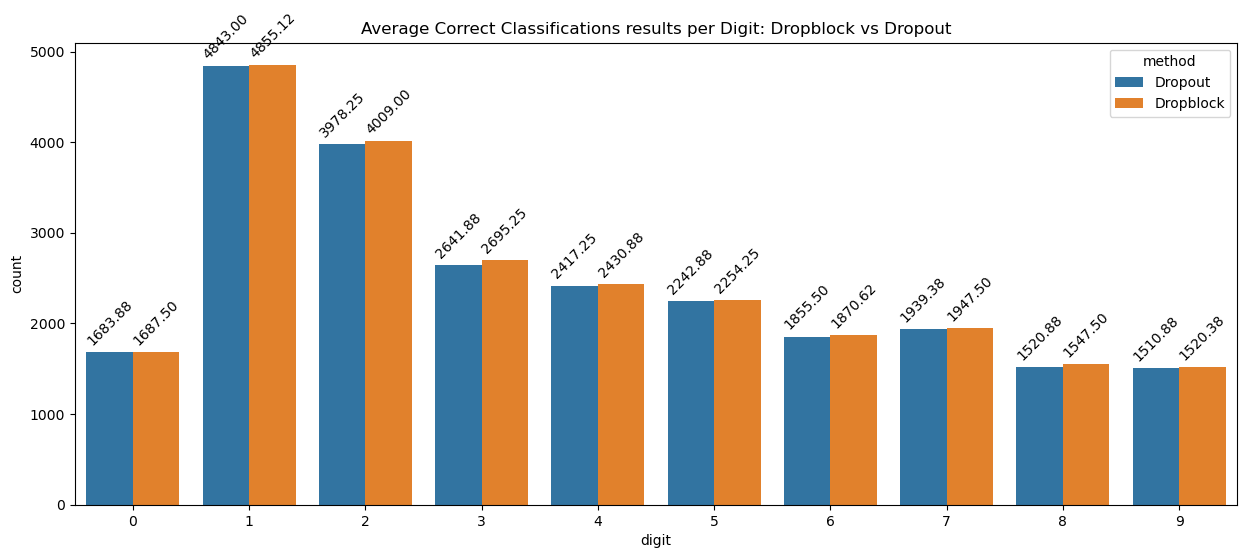

In [ ]:
import seaborn as sns

# Set the figure size for better readability
plt.figure(figsize=(15, 6))

# Create a grouped barplot to compare average correct classifications per digit
ax = sns.barplot(data=classification_count_df, x='digit', y='count', hue='method')

# Annotate each bar with its value 
for i in ax.containers:
    ax.bar_label(i,fmt="%.2f", padding=3, rotation=45)

# Set a title for the plot
ax.set_title(label='Average Correct Classifications results per Digit: Dropblock vs Dropout')

Below is a comparison of the best performing models 7 & 8 against the replicated model

In [ ]:
import tensorflow as tf

# Define the directory where the best Srivastava-style dropout model is saved
srivastava_best_path = 'saved models/5. Srivastava/'

# Load the trained Keras model from the specified file
srivastava_dropout_best_model = tf.keras.models.load_model(srivastava_best_path +'srivastava_dropout_best_model.keras')

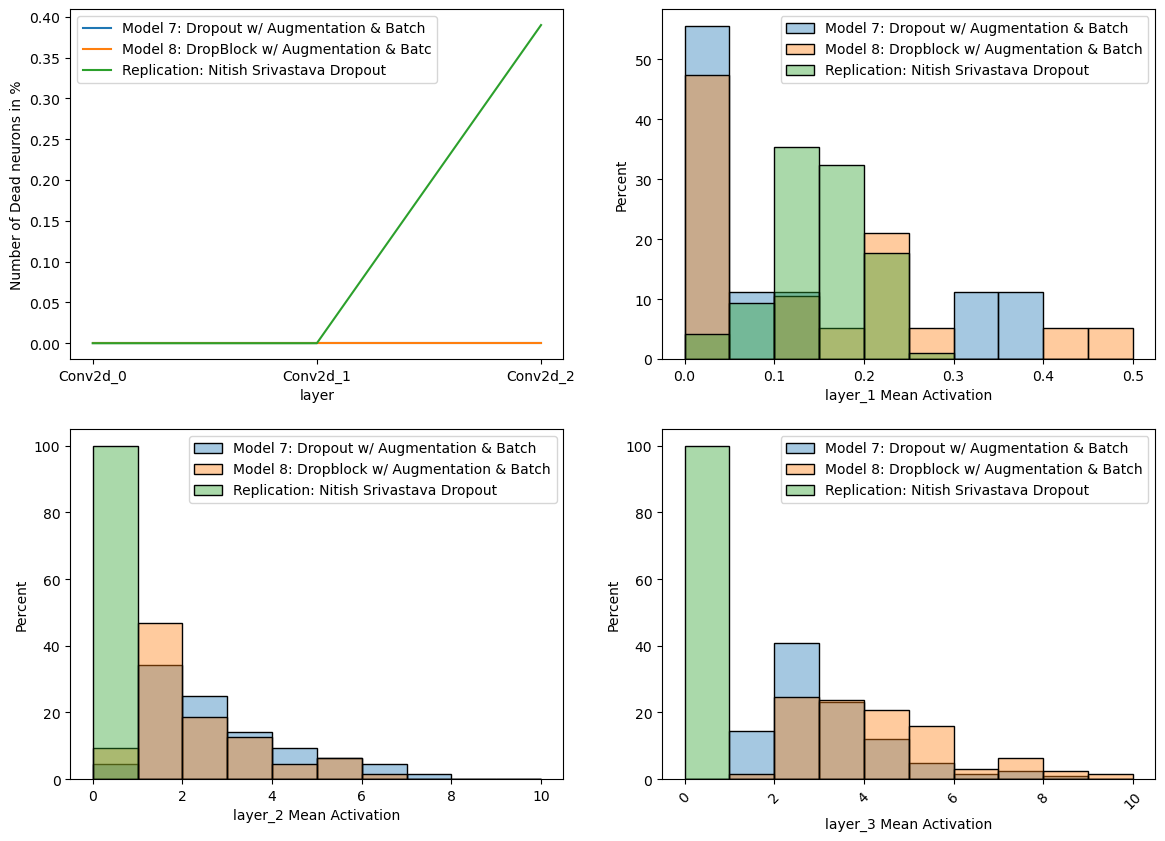

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_neurons_count, display_mean_activations

fig, axes = plt.subplots(2, 2, figsize=(14, 10))


display_neurons_count(model_7_relu_w_dropout_aug_batch_best, test_dataset, ('Model 7: Dropout w/ Augmentation & Batch', axes[0,0]) )
display_neurons_count(model_8_relu_w_dropblock_aug_batch_best, test_dataset, ('Model 8: DropBlock w/ Augmentation & Batc', axes[0,0]) )
display_neurons_count(srivastava_dropout_best_model, test_dataset, ('Replication: Nitish Srivastava Dropout', axes[0,0]) )

display_mean_activations(model_7_relu_w_dropout_aug_batch_best, test_dataset, '1', 0, 0.5, 11, ('Model 7: Dropout w/ Augmentation & Batch', axes[0,1]) )
display_mean_activations(model_8_relu_w_dropblock_aug_batch_best, test_dataset, '1',0, 0.5, 11, ('Model 8: Dropblock w/ Augmentation & Batch', axes[0,1]) )
display_mean_activations(srivastava_dropout_best_model, test_dataset, '1',0, 0.5, 11, ('Replication: Nitish Srivastava Dropout', axes[0,1]) )

display_mean_activations(model_7_relu_w_dropout_aug_batch_best, test_dataset, '2', 0, 10, 11, ('Model 7: Dropout w/ Augmentation & Batch', axes[1,0]) )
display_mean_activations(model_8_relu_w_dropblock_aug_batch_best, test_dataset, '2', 0, 10, 11, ('Model 8: Dropblock w/ Augmentation & Batch', axes[1,0]) )
display_mean_activations(srivastava_dropout_best_model, test_dataset, '2', 0, 10, 11, ('Replication: Nitish Srivastava Dropout', axes[1,0]) )

display_mean_activations(model_7_relu_w_dropout_aug_batch_best, test_dataset, '3', 0, 10, 11, ('Model 7: Dropout w/ Augmentation & Batch', axes[1,1]) )
display_mean_activations(model_8_relu_w_dropblock_aug_batch_best, test_dataset, '3', 0, 10, 11,  ('Model 8: Dropblock w/ Augmentation & Batch', axes[1,1]) )
display_mean_activations(srivastava_dropout_best_model, test_dataset, '3', 0, 10, 11,  ('Replication: Nitish Srivastava Dropout', axes[1,1]) )


# Replicated Model: Nitish Srivastava Dropout: A Simple Way to Prevent Neural Networks from Overfitting

In [ ]:
# Nitish Srivastava Dropout: A Simple Way to Prevent Neural Networks from Overfitting

import tensorflow as tf
import tensorflow_addons as tfa
from keras import activations
from keras.constraints import MaxNorm
from keras.optimizers import SGD

# Build the CNN model using Srivastava-style Dropout and MaxNorm constraints
srivastava_dropout = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),  # Input layer
    tf.keras.layers.Dropout(0.1),

    # First convolutional block
    tf.keras.layers.Conv2D(96, (5, 5),strides=1, activation='relu',
                            kernel_constraint=MaxNorm(4), padding='same'),                    
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),
    tf.keras.layers.Dropout(0.25),
    
    # Second convolutional block
    tf.keras.layers.Conv2D(128, (5, 5),strides=1, activation='relu',
                            kernel_constraint=MaxNorm(4), padding='same'),                    
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),
    tf.keras.layers.Dropout(0.25),
    
     # Third convolutional block
    tf.keras.layers.Conv2D(256, (5, 5),strides=1, activation='relu',
                            kernel_constraint=MaxNorm(4), padding='same'),                     
    tf.keras.layers.MaxPooling2D((3, 3), strides=2,), 
    tf.keras.layers.Dropout(0.5),
       

    tf.keras.layers.Flatten(),

    # First fully connected layer
    tf.keras.layers.Dense(2048, activation='relu',
                           kernel_constraint=MaxNorm(4)),
    tf.keras.layers.Dropout(0.5),

     # Second fully connected layer
    tf.keras.layers.Dense(2048, activation='relu',
                           kernel_constraint=MaxNorm(4)),
    tf.keras.layers.Dropout(0.5),

    # Output layer with 10 softmax units for classification
    tf.keras.layers.Dense(10, activation='softmax'),    # Output layer for 10 classes
    
])

# optimizer = Adam(beta_1=0.95)

optimizer = SGD(learning_rate=0.0001, momentum=0.99)

# Compile the model
srivastava_dropout.compile(optimizer=optimizer ,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
srivastava_dropout.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 96)        7296      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 96)       0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 15, 15, 96)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 128)       307328    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                  

This code trains a Srivastava-style dropout model while saving the version with the lowest validation loss using a ModelCheckpoint callback. It also tracks training time using a custom TimeHistory callback and stores the training history for further analysis.

In [ ]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)

# Call Modelcheckpoint to save the best model with the validation loss
best_model = [tf.keras.callbacks.ModelCheckpoint(
        filepath="srivastava_dropout_best_model.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Record the training time of the model
srivastava_dropout_time = TimeHistory()

# Save model History and fit the model
srivastava_dropout_history = srivastava_dropout.fit(
    train_dataset,                                                  # Training data and labels
    validation_data=(val_dataset),                                  # Validation data and labels
    epochs=300,                                                     # Number of epochs
    class_weight=d_class_weights,                                   # Adding Class Weights
    callbacks=[best_model, srivastava_dropout_time],                # Callbacks
    verbose=1                                                       # Verbosity mode (1 for progress bar)
)

Below, I am saving the models history information

In [ ]:
np.save('Saved Models/srivastava_dropout.npy',srivastava_dropout_history.history)

Below, I am loading the models history information

In [157]:
# Configure the directory
srivastava_dropout_path = 'saved models/5. Srivastava/'
# History
srivastava_dropout_history_df = np.load(srivastava_dropout_path + 'srivastava_dropout.npy', allow_pickle=True).item()

Below I am saving the model information

In [ ]:
srivastava_dropout.save("saved models/srivastava_dropout.keras")

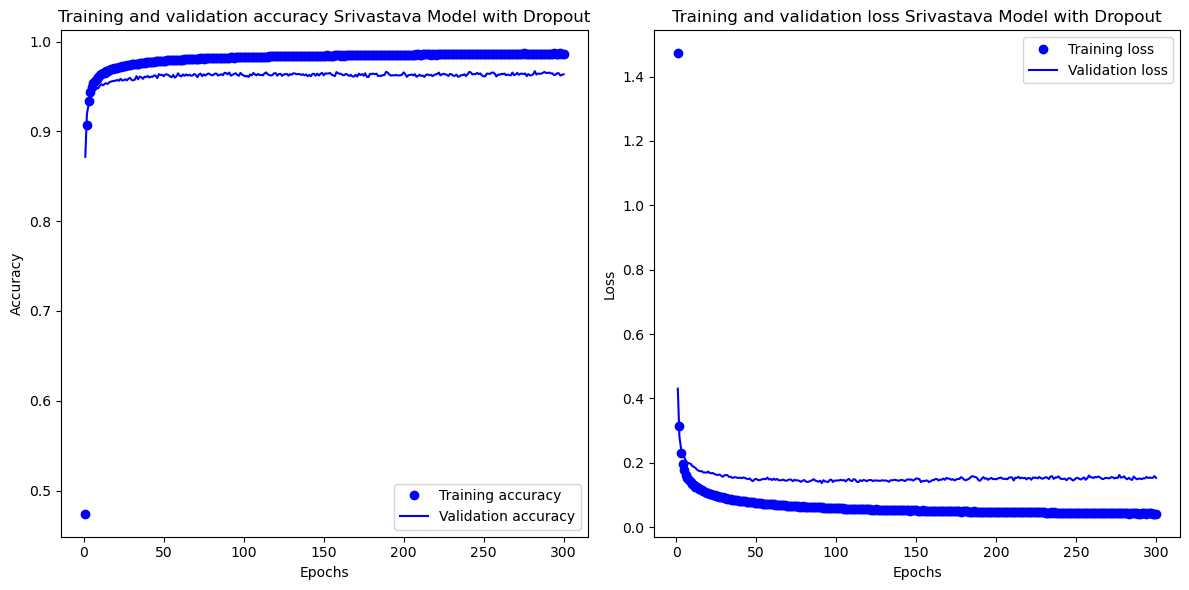

In [ ]:
import importlib
import utils.plotting
from utils.plotting import display_accuracy_loss
importlib.reload(utils.plotting)
import pandas as pd

display_accuracy_loss(srivastava_dropout_history_df, 'Srivastava Model with Dropout', reload=True)

Below, I am loading the models Total Traing time information

In [ ]:
# Time
srivastava_dropout_average_time  = np.load('Saved Models/5. Srivastava/srivastava_dropout_average_time.npy', allow_pickle=True)
srivastava_dropout_total_time = np.load('Saved Models/5. Srivastava/srivastava_dropout_total_time.npy', allow_pickle=True)

In [ ]:
from datetime import timedelta

# Retrieve the list of epoch durations (in seconds) recorded by the TimeHistory callback
srivastava_dropout_time_result = srivastava_dropout_time.times

# Calculate the average epoch time and convert it to a timedelta
srivastava_dropout_average_time = timedelta(seconds=np.mean(
    srivastava_dropout_time_result))

# Calculate the total training time
srivastava_dropout_total_time = timedelta(seconds=np.sum(
    srivastava_dropout_time_result))

# Print total training time and average time per epoch
print('Total Time:', str(srivastava_dropout_total_time),
       'Average Epoch Time:', str(srivastava_dropout_average_time))

Total Time: 7:37:38.564356 Average Epoch Time: 0:01:31.528548


Below, I am saving the models Total Training time information

In [ ]:
np.save('Saved Models/srivastava_dropout_average_time.npy',srivastava_dropout_average_time)
np.save('Saved Models/srivastava_dropout_total_time.npy',srivastava_dropout_total_time)

Below, I am loading the best model with the lowest validation loss.

In [161]:
import tensorflow as tf

srivastava_best_path = 'saved models/5. Srivastava/'

srivastava_dropout_best_model = tf.keras.models.load_model(srivastava_best_path +'srivastava_dropout_best_model.keras')

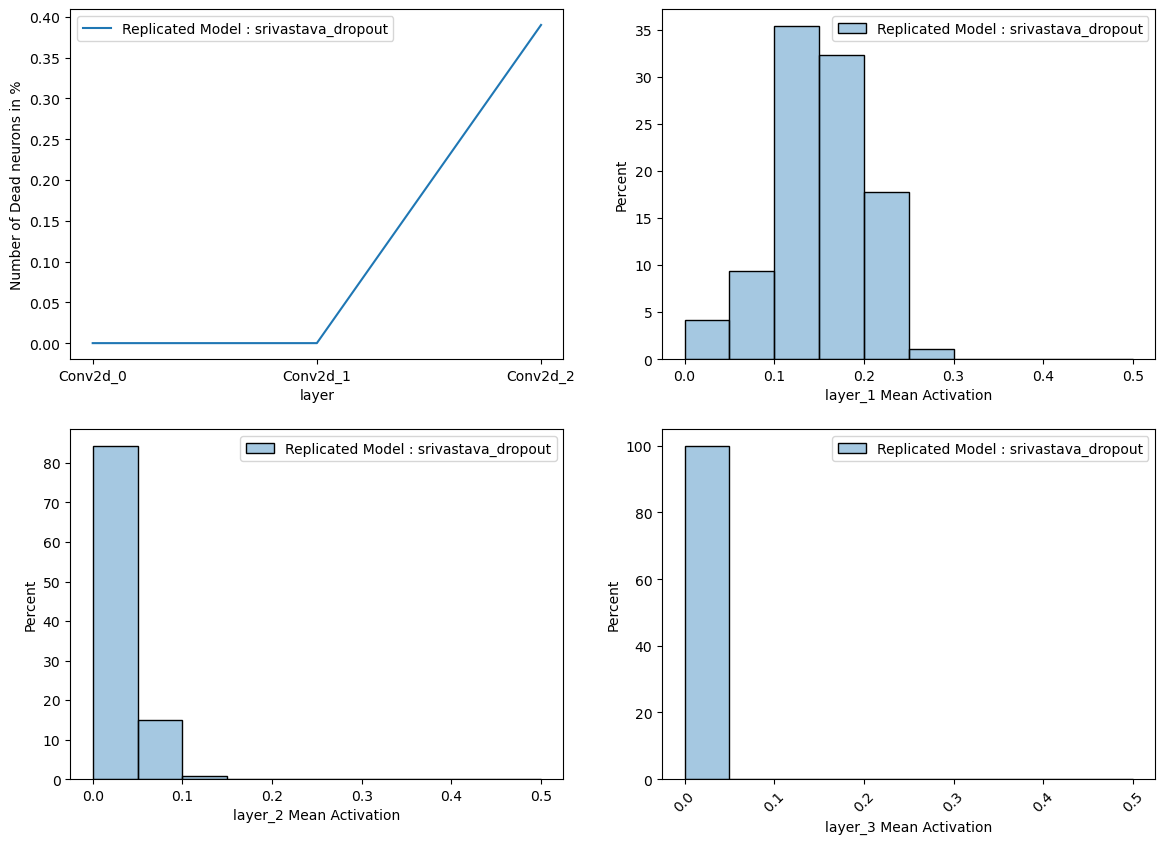

In [163]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import display_neurons_count, display_mean_activations

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

display_neurons_count(srivastava_dropout_best_model, test_dataset, ('Replicated Model : srivastava_dropout', axes[0,0]) )

display_mean_activations(srivastava_dropout_best_model, test_dataset, '1', 0, 0.5, 11, ('Replicated Model : srivastava_dropout', axes[0,1]) )

display_mean_activations(srivastava_dropout_best_model, test_dataset, '2', 0, 0.5, 11, ('Replicated Model : srivastava_dropout', axes[1,0]) )

display_mean_activations(srivastava_dropout_best_model, test_dataset, '3', 0, 0.5, 11, ('Replicated Model : srivastava_dropout', axes[1,1]) )

# srivastava_dropout_activations = count_dead_neurons(test_dataset, srivastava_dropout_best_model )

In [ ]:
srivastava_dropout_best_model.evaluate(test_dataset)

204/204 [==============================] - 2s 8ms/step - loss: 0.1214 - accuracy: 0.9706


[0.12141448259353638, 0.970574676990509]

The srivastava_dropout replicated Model achieves an accuracy of 97.06%

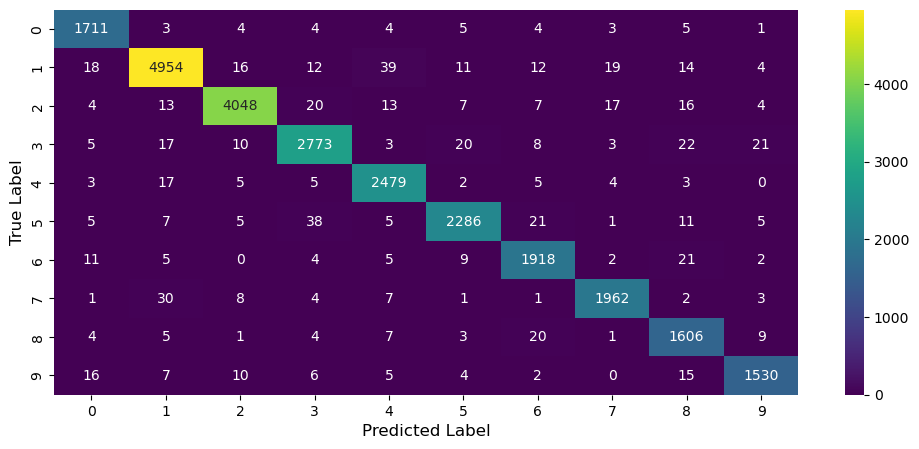

In [164]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import generate_confusion_matrix


dropout_aug_cm = generate_confusion_matrix(srivastava_dropout_best_model, test_dataset)

# Clear Memory

This command helps clear the memory when it becomes to full.

In [ ]:
import gc
import tensorflow as tf

# Clear memory
gc.collect()
tf.keras.backend.clear_session()